# KERAS and TENSORFLOW
TUTORIAL: Using a Multi Layer Perceptron in order to separate resonant di-Higgs into WWbb from TTbar. In this example we train several Signal masses instead than a single mass point. 
(%lsmagic for magic commanda and ! for bash instruction)

In [1]:
# We start by importing all the necessary packages
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import compute_class_weight
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array 
from IPython.display import HTML, IFrame
import seaborn as sns; sns.set()
print "I you had no error so far, this is great! We can start the tutorial."

Using Theano backend.


Welcome to JupyROOT 6.08/06


/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.08/06 is currently active but you installed root_numpy against ROOT 6.08/00. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


I you had no error so far, this is great! We can start the tutorial.


Here there are few paramters we may want to change.

In [2]:
print "I'm now importing an external file with few function and defining the input/output files location."
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# Fix random seed for reproducibility
seed = 7; np.random.seed(seed);
# Input paramters
debug = True #(Verbose output)
folder='Plots_hh_tt_parametric_MLP' # Folder with Plots
MakePlots=True # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()
h_file1 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-260_narrow_13TeV-madgraph-v2.root"
h_file2 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-270_narrow_13TeV-madgraph-v2.root"
h_file3 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-300_narrow_13TeV-madgraph-v2.root"
h_file4 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-350_narrow_13TeV-madgraph-v2.root"
h_file5 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-400_narrow_13TeV-madgraph-v2.root"
h_file6 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-450_narrow_13TeV-madgraph-v2.root"
h_file7 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root"
h_file8 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-550_narrow_13TeV-madgraph-v2.root"
h_file9 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-600_narrow_13TeV-madgraph-v2.root"
h_file10 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-650_narrow_13TeV-madgraph-v2.root"
h_file11 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-750_narrow_13TeV-madgraph-v2.root"
h_file12 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-800_narrow_13TeV-madgraph-v2.root"
h_file13 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-900_narrow_13TeV-madgraph-v2.root"
h_file14 = "files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-1000_narrow_13TeV-madgraph-v2.root"
h_file_ALL = [h_file1,h_file2,h_file3,h_file4,h_file5,h_file6,h_file7,h_file8,h_file9,h_file10,h_file11,h_file12,h_file13,h_file14]
TT_df_list = ['files/tt_dataframe_0.csv','files/tt_dataframe_1.csv','files/tt_dataframe_2.csv','files/tt_dataframe_3.csv','files/tt_dataframe_4.csv']

I'm now importing an external file with few function and defining the input/output files location.


Now we manipulate the input ROOT files into a format we can pass to Keras.

In [3]:
print "Now we manipulate the input ROOT files into a format we can pass to Keras."
# Our goal is to separate BX Signal from TT background. The machine learning only want to analyze "good events": 
# 1) Applying a preselection to out Signal and background events
my_selec = 'met_pt>20 && met_pt<500 && muon1_pt>20 && fabs(muon1_eta)<2.4 && muon2_pt>10 && fabs(muon2_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>20 && fabs(b1jet_eta)<2.4 && b2jet_pt>20 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches = ["MT2","mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt","muon1_pogSF","muon2_pogSF","XsecBr"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training = ["MT2","mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt"]#,"mass"]
    
# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
hh1     = root2panda(h_file1, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh2     = root2panda(h_file2, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh3     = root2panda(h_file3, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh4     = root2panda(h_file4, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh5     = root2panda(h_file5, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh6     = root2panda(h_file6, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh7     = root2panda(h_file7, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh8     = root2panda(h_file8, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh9     = root2panda(h_file9, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh10    = root2panda(h_file10, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh11    = root2panda(h_file11, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh12    = root2panda(h_file12, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh13    = root2panda(h_file13, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
hh14    = root2panda(h_file14, 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
HH_ALL = [hh1,hh2,hh3,hh4,hh5,hh6,hh7,hh8,hh9,hh10,hh11,hh12,hh13,hh14]
sampleName = ['Radion_260','Radion_270','Radion_300','Radion_350','Radion_400','Radion_450','Radion_500','Radion_550','Radion_600','Radion_650','Radion_750','Radion_800','Radion_900','Radion_1000']
## TT is so heavy that I already saved the final dataframe (and I splitted it if 5 so that each df is smaller than 100 Mb).
ttbar_df_list = (pd.read_csv(f_df) for f_df in TT_df_list)
ttbar = pd.concat(ttbar_df_list, ignore_index=True)                    
ttbar = ttbar.drop(ttbar.columns[[0, 1]], 1) #Remove 2 extra columns we have in this df, so it match with Signal


Now we manipulate the input ROOT files into a format we can pass to Keras.


In [4]:
# These processes have a different cross-sextion. You need to know how to weight each event such that yuo can estimate the real number of events expected in a given Luminosity.
# The weight is (Xsec*Br)*Lumi/N_totalEvent_genrated.
# First you need to knwow the Total number of MC events generated
Lumi = 36.42 * 1000 #1000 is for passing from fb-1 to pb-1 (in which the xsec is expressed).
for iH in range(len(h_file_ALL)):
    MyFile_hh =  ROOT.TFile.Open(h_file_ALL[iH],"read");
    h_prehlt_hh = ROOT.TH1F(MyFile_hh.Get("TriggerResults/hevent_filter"))
    nTOT_prehlt_hh = h_prehlt_hh.GetBinContent(2) # Here is stored the number of total event generated
    HH_ALL[iH]['XsecBr'] = HH_ALL[iH]['XsecBr']*Lumi/nTOT_prehlt_hh
    # Add all weights in the df 
    HH_ALL[iH]['fin_weight']    = HH_ALL[iH]['XsecBr'] * HH_ALL[iH]['muon1_pogSF'] * HH_ALL[iH]['muon2_pogSF'] #1pb is S Xsec.
    print "Assuming a Signal (",sampleName[iH],") of 1pb (B.R. included) you expect, after the preselection, to have:",HH_ALL[iH]['fin_weight'].sum(),"events"
nTOT_prehlt_ttbar = 102114184 #Harcoded
ttbar['XsecBr'] = ttbar['XsecBr']*Lumi/nTOT_prehlt_ttbar
ttbar['fin_weight'] = ttbar['XsecBr'] * ttbar['muon1_pogSF'] * ttbar['muon2_pogSF'] #87pb is TT Xsec.
print "Assuming a background of 87pb (B.R. included) you expect, after the preselection, to have:",ttbar['fin_weight'].sum(),"events."
                
## Alternatively you can save a df as a h5 file (for quick loading in the future)
#  Ex: io.save(open('models/ttbar.h5', 'wb'), ttbar); ttbar = io.load(open('models/ttbar.h5', 'rb'));


Assuming a Signal ( Radion_260 ) of 1pb (B.R. included) you expect, after the preselection, to have: 404.458 events
Assuming a Signal ( Radion_270 ) of 1pb (B.R. included) you expect, after the preselection, to have: 417.438 events
Assuming a Signal ( Radion_300 ) of 1pb (B.R. included) you expect, after the preselection, to have: 505.153 events
Assuming a Signal ( Radion_350 ) of 1pb (B.R. included) you expect, after the preselection, to have: 624.786 events
Assuming a Signal ( Radion_400 ) of 1pb (B.R. included) you expect, after the preselection, to have: 735.564 events
Assuming a Signal ( Radion_450 ) of 1pb (B.R. included) you expect, after the preselection, to have: 814.464 events
Assuming a Signal ( Radion_500 ) of 1pb (B.R. included) you expect, after the preselection, to have: 889.349 events
Assuming a Signal ( Radion_550 ) of 1pb (B.R. included) you expect, after the preselection, to have: 983.503 events
Assuming a Signal ( Radion_600 ) of 1pb (B.R. included) you expect, afte

In [5]:
#print "Now let's add a parameter in each df that represet the mass"
#HH_ALL[0]['mass'] = 260 
#HH_ALL[1]['mass'] = 270 
#HH_ALL[2]['mass'] = 300 
#HH_ALL[3]['mass'] = 350 
#HH_ALL[4]['mass'] = 400 
#HH_ALL[5]['mass'] = 450 
#HH_ALL[6]['mass'] = 500 
#HH_ALL[7]['mass'] = 550 
#HH_ALL[8]['mass'] = 600 
#HH_ALL[9]['mass'] = 650 
#HH_ALL[10]['mass'] = 750 
#HH_ALL[11]['mass'] = 850 
#HH_ALL[12]['mass'] = 900 
#HH_ALL[13]['mass'] = 1000
#ttbar['mass'] = 0

if debug:
    print("---> HH_ALL[0] Displayed as panda dataframe: "); print(HH_ALL[0])
    print("The shape for hh is (samples, features): "); print(HH_ALL[0].shape)
    print("The shape for tt is (samples, features): "); print(ttbar.shape)
    print HH_ALL[0].keys()
    print ttbar.keys()

---> HH_ALL[0] Displayed as panda dataframe: 
      mass_trans  dphi_llmet  dphi_llbb  eta_l1l2     pt_l1l2  mass_l1l2  \
0      58.836517    2.036996  -2.195011 -1.761931   53.369804  47.703281   
1      91.472862    1.837220   1.374906 -1.877273   52.681824  24.148767   
2      84.094986    1.812677  -0.262167 -0.938847   66.133118  64.216621   
3     113.967056    2.257362  -1.764214 -0.466149   71.513741  26.362066   
4      62.980377   -1.595165   0.880271  0.067176   39.395412  34.028343   
5      94.639915   -2.998709   2.102583 -0.483183   58.199478  15.722157   
6     127.376617    2.766692  -2.421544 -1.769549   61.554604  13.851027   
7      12.867005   -0.165128  -0.968602  0.159346   59.969578  57.782337   
8     118.501419   -2.763937   0.571166 -0.473403   37.067215  44.826050   
9     103.312714   -2.600723  -2.595056 -1.248913   62.974575  43.908936   
10     49.520870    1.162006   3.122833 -0.601111   65.717010  37.003166   
11     10.860861    0.174303   0.523037 -0

In [6]:
# %matplotlib inline #Too many plots to dispal them here
# Plots of the branches we selected
if MakePlots:
    print "Producing plots of the features in S and B."
    for iH in range(len(HH_ALL)):
        for key in ttbar.keys() :
            if(key!="muon1_pogSF" and key!="muon2_pogSF" and key!="XsecBr" and key!="fin_weight"):
                matplotlib.rcParams.update({'font.size': 16})
                fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
                bins = np.linspace(my_max(min(ttbar[key]),0.), max(ttbar[key]), 50)
                _ = plt.hist(HH_ALL[iH][key],  bins=bins, histtype='step', normed=True, label=sampleName[iH], linewidth=2)
                _ = plt.hist(ttbar[key], bins=bins, histtype='step', normed=True, label=r'$t\overline{t}$')
                plt.xlabel(key)
                plt.ylabel('Entries')
                plt.legend(loc='best')
                plt.savefig(folder + "/" + str(key) + '_' + str(sampleName[iH]) + '.pdf')
    print "It could be also useful to plot in the same histo TT and few signals"
    for key in ttbar.keys() :
        if(key!="muon1_pogSF" and key!="muon2_pogSF" and key!="XsecBr" and key!="fin_weight"):
            matplotlib.rcParams.update({'font.size': 16})
            fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
            bins = np.linspace(my_max(min(ttbar[key]),0.), max(ttbar[key]), 50)
            _ = plt.hist(HH_ALL[0][key],  bins=bins, histtype='step', normed=True, label=sampleName[0], linewidth=2)
            _ = plt.hist(HH_ALL[3][key],  bins=bins, histtype='step', normed=True, label=sampleName[3], linewidth=2)
            _ = plt.hist(HH_ALL[5][key],  bins=bins, histtype='step', normed=True, label=sampleName[5], linewidth=2)
            _ = plt.hist(HH_ALL[9][key],  bins=bins, histtype='step', normed=True, label=sampleName[9], linewidth=2)
            _ = plt.hist(HH_ALL[13][key],  bins=bins, histtype='step', normed=True, label=sampleName[13], linewidth=2)
            _ = plt.hist(ttbar[key], bins=bins, histtype='step', normed=True, label=r'$t\overline{t}$')
            plt.xlabel(key)
            plt.ylabel('Entries')
            plt.legend(loc='best')
            plt.savefig(folder + "/" + str(key) + '_' + str(sampleName[iH]) + '.pdf')
        

Producing plots of the features in S and B.
It could be also useful to plot in the same histo TT and few signals


/Library/Python/2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing for each event if it is signal (0) or TT (1)"

In [7]:
print('Now lets start to talk about DNN!')
#You only need a Dataframe for the training. So you merge all the one you have
df =  pd.concat((HH_ALL[0][my_branches_training], HH_ALL[1][my_branches_training], HH_ALL[2][my_branches_training], HH_ALL[3][my_branches_training], HH_ALL[4][my_branches_training], HH_ALL[5][my_branches_training], HH_ALL[6][my_branches_training], HH_ALL[7][my_branches_training], HH_ALL[8][my_branches_training], HH_ALL[9][my_branches_training], HH_ALL[10][my_branches_training], HH_ALL[11][my_branches_training], HH_ALL[12][my_branches_training], HH_ALL[13][my_branches_training], ttbar[my_branches_training]), ignore_index=True)
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X = df.as_matrix() # Each row is an object to classify, each column corresponds to a specific variable.
# Take the weights
w =  pd.concat((HH_ALL[0]['fin_weight'],HH_ALL[1]['fin_weight'],HH_ALL[2]['fin_weight'],HH_ALL[3]['fin_weight'],HH_ALL[4]['fin_weight'],HH_ALL[5]['fin_weight'],HH_ALL[6]['fin_weight'],HH_ALL[7]['fin_weight'],HH_ALL[8]['fin_weight'],HH_ALL[9]['fin_weight'],HH_ALL[10]['fin_weight'],HH_ALL[11]['fin_weight'],HH_ALL[12]['fin_weight'],HH_ALL[13]['fin_weight'], ttbar['fin_weight']), ignore_index=True).values
# This is the array with the true values: 0 is signal, 1 if TT.
y = []
# In this case we have 15 different category to train (14 signals and 1 background). 
#for _df, ID in [(HH_ALL[0], 0),(HH_ALL[1], 0),(HH_ALL[2], 0),(HH_ALL[3], 0),(HH_ALL[4], 0),(HH_ALL[5], 0),(HH_ALL[6], 0),(HH_ALL[7], 0),(HH_ALL[8], 0),(HH_ALL[9], 0),(HH_ALL[10], 0),(HH_ALL[11], 0),(HH_ALL[12], 0),(HH_ALL[13], 0), (ttbar, 1)]:
for _df, ID in [(HH_ALL[0], 0),(HH_ALL[1], 1),(HH_ALL[2], 2),(HH_ALL[3], 3),(HH_ALL[4], 4),(HH_ALL[5], 5),(HH_ALL[6], 6),(HH_ALL[7], 7),(HH_ALL[8], 8),(HH_ALL[9], 9),(HH_ALL[10], 10),(HH_ALL[11], 11),(HH_ALL[12], 12),(HH_ALL[13], 13), (ttbar, 14)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges (it atually improve the results)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # You are applying the same transformation done to X_train, to X_test.

Now lets start to talk about DNN!


In [8]:
# Multilayer Perceptron (MLP) definition
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu')) # Linear transformation of the input vector. The first number is output_dim.
model.add(Dropout(0.1)) # To avoid overfitting. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation.
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(15, activation='softmax')) # Last layer has to have the same dimensionality as the number of classes we want to predict, here 2.
model.summary()
# Now you need to declare what loss function and optimizer to use (and compile your model).
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [9]:
print('---------------------------Training:---------------------------')
try:
    history = model.fit(X_train, y_train, batch_size=50, epochs=100, verbose=1,
              callbacks = [
                  EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
                  ModelCheckpoint('models/tutorial-progress.h5', monitor='val_loss', verbose=1, save_best_only=True)
              ],
              validation_split=0.2, validation_data=None, shuffle=True,
              class_weight={
                0 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[0], # Function that return "[1/N_classes * ((float(len(y)) / (y == 0).sum())), 1/N_classes * ((float(len(y)) / (y == 1).sum()))]"
                1 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[1], 
                2 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[2], 
                3 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[3], 
                4 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[4], 
                5 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[5], 
                6 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[6], 
                7 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[7], 
                8 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[8], 
                9 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[9], 
                10 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[10], 
                11 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[11], 
                12 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[12], 
                13 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[13],
                14 : compute_class_weight("balanced", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14], y)[14]
              },
              sample_weight=None,initial_epoch=0)
    
except KeyboardInterrupt:
    print 'Training ended early.'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


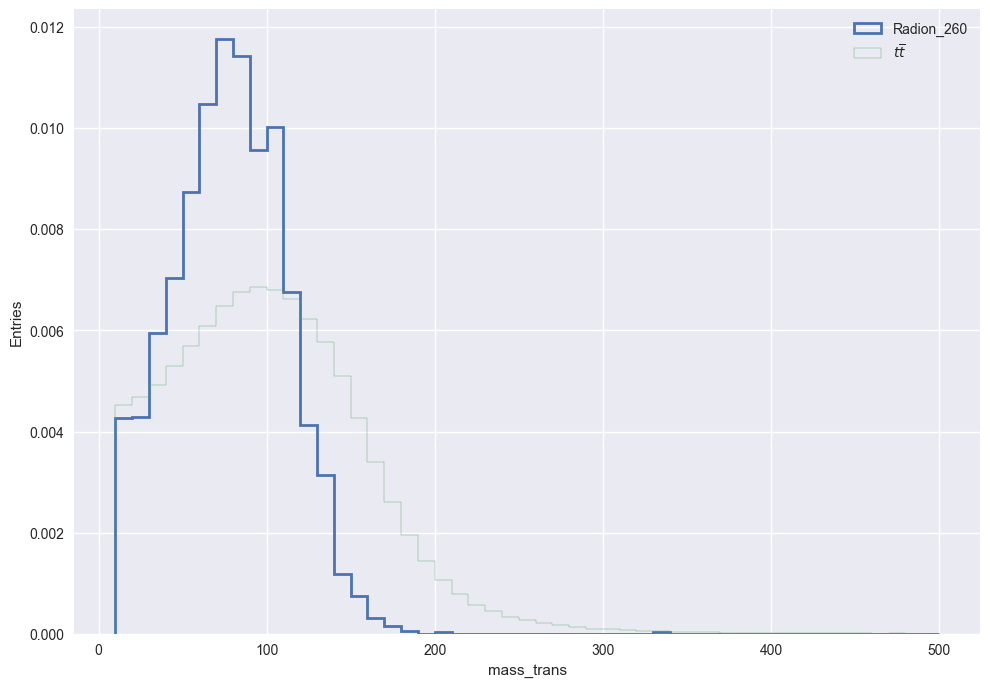

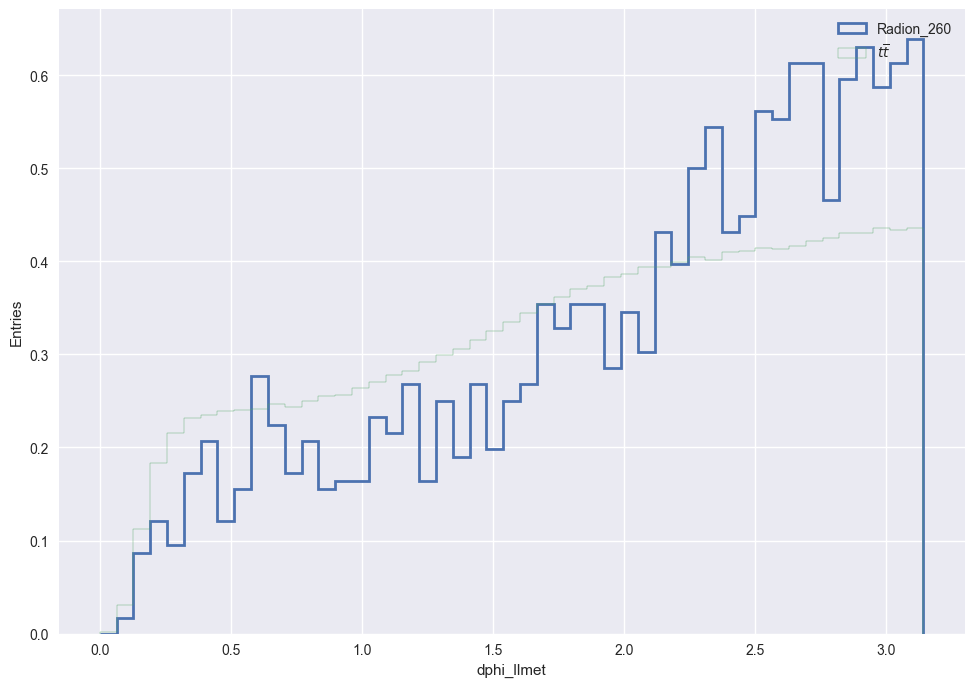

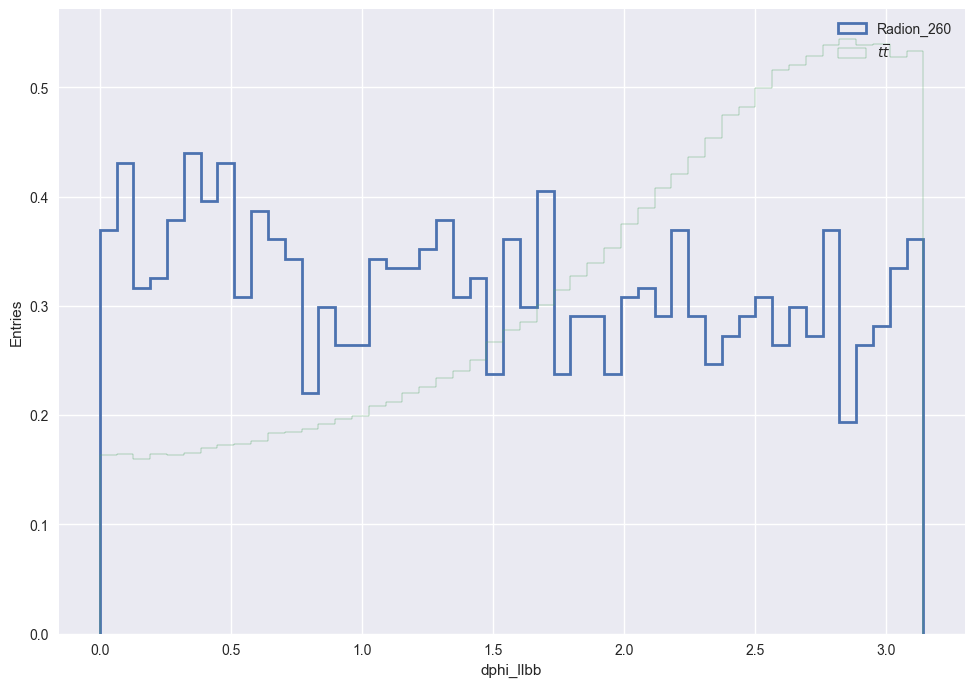

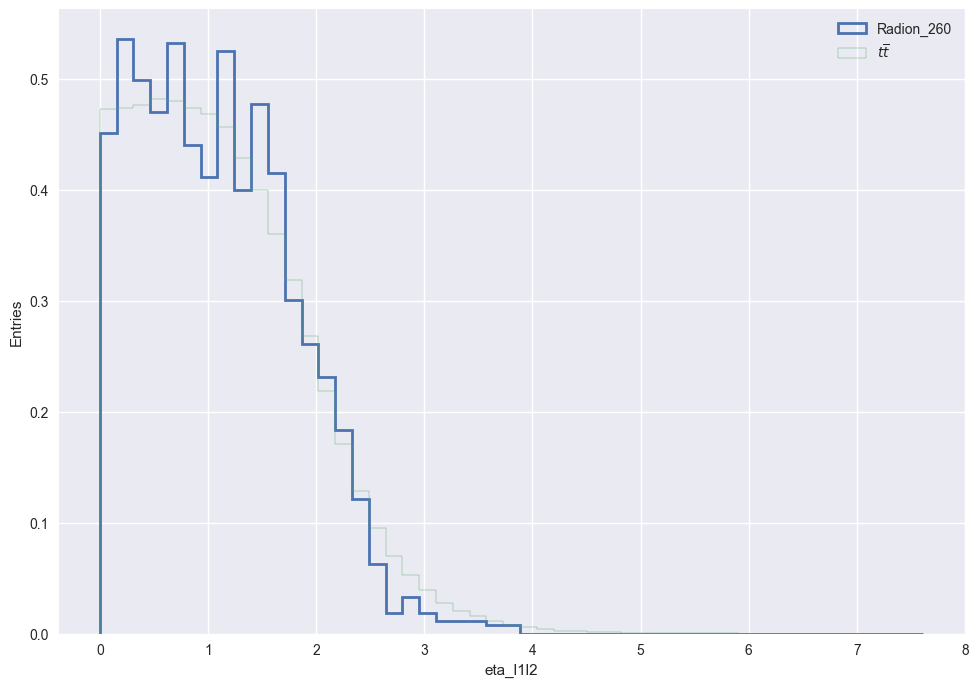

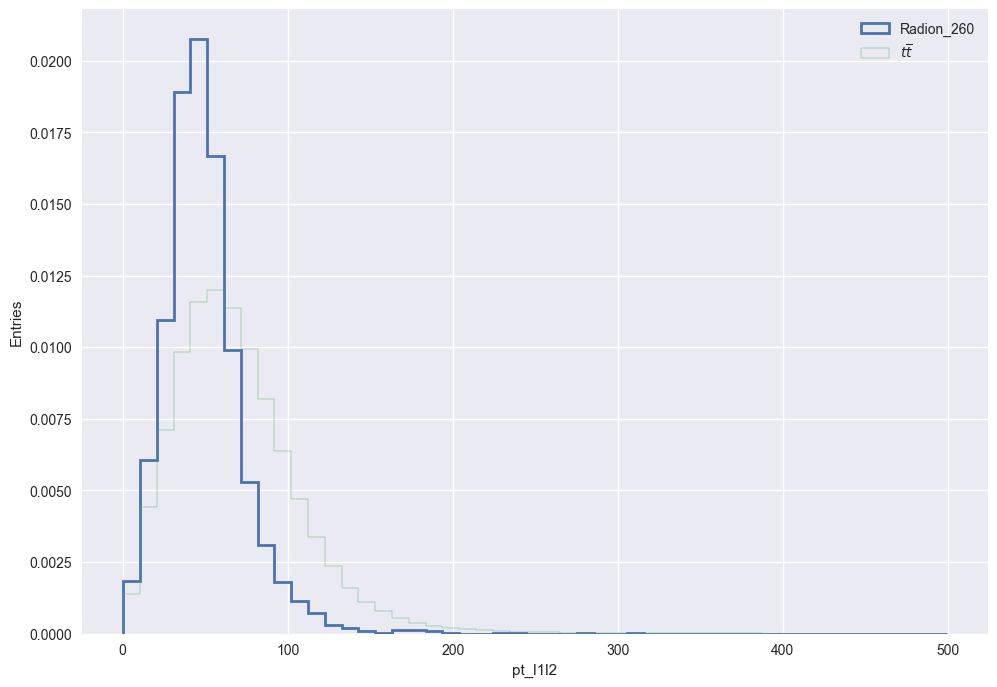

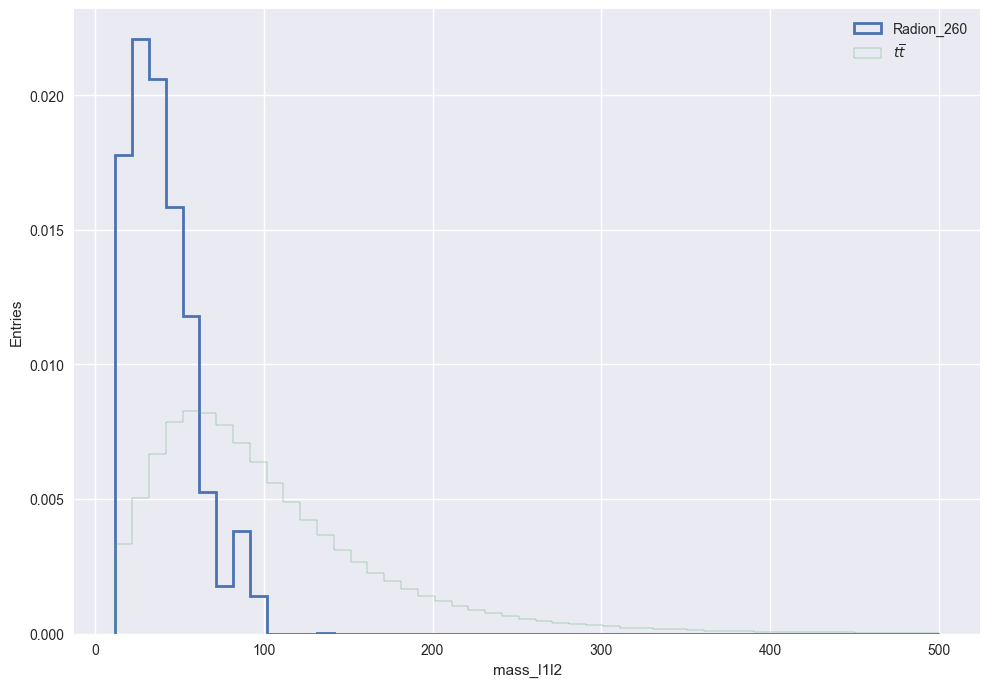

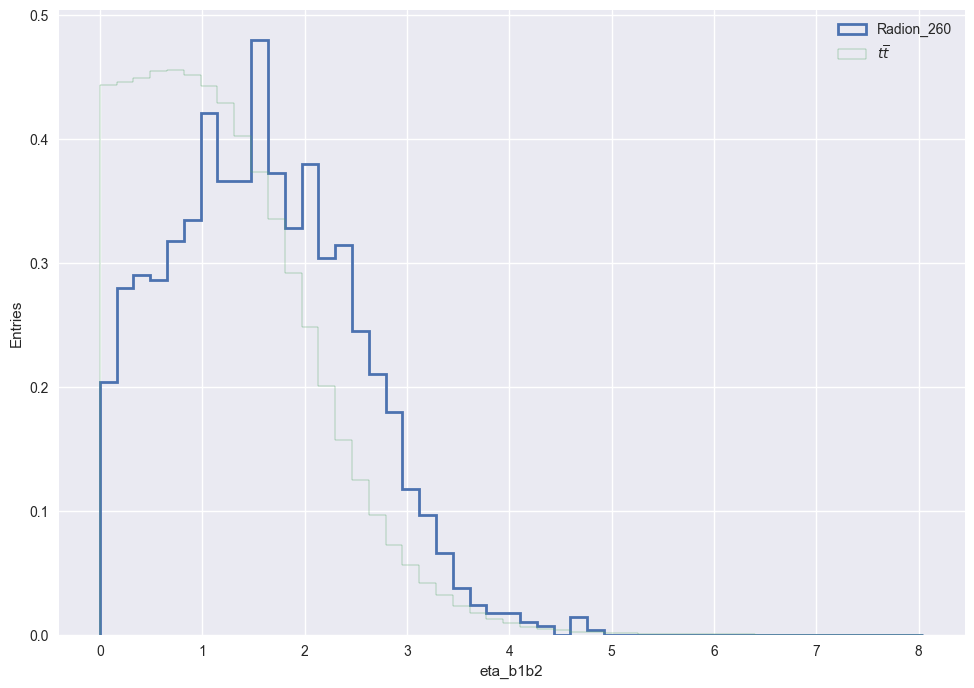

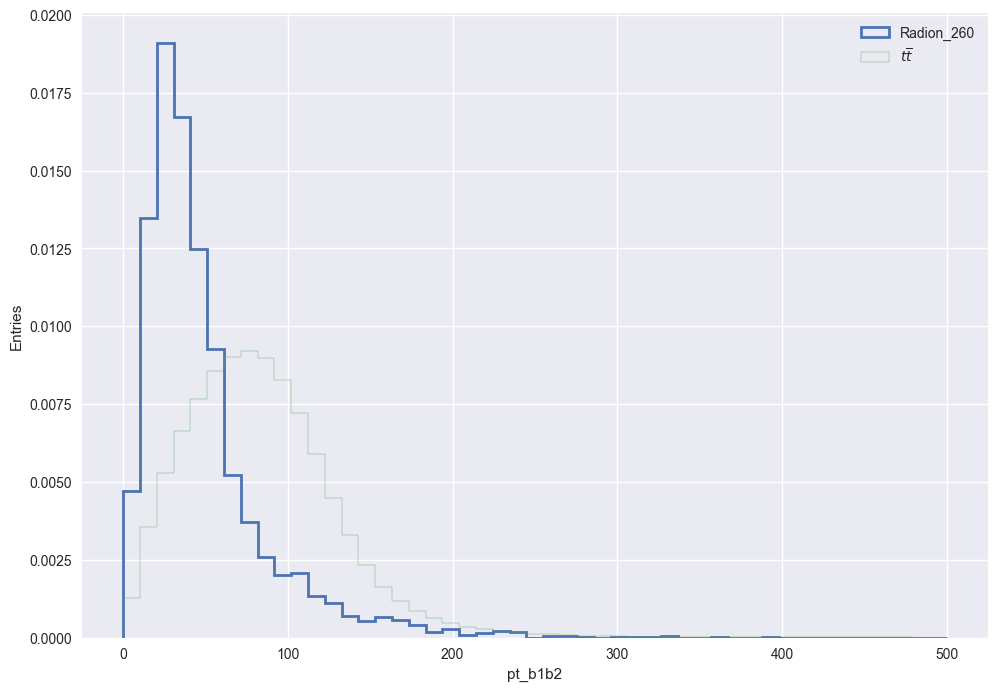

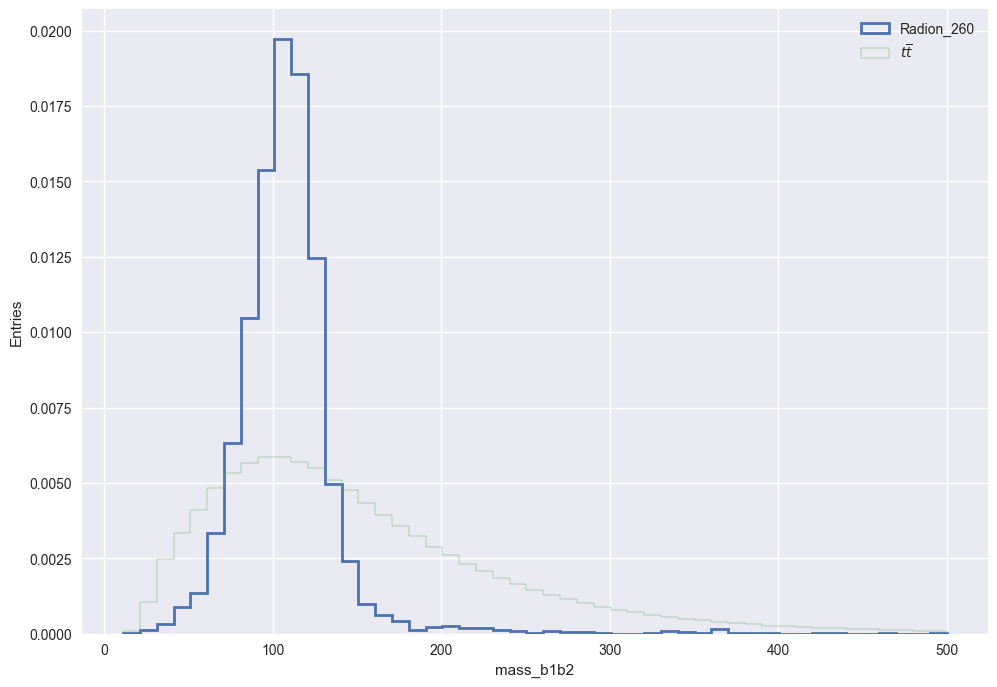

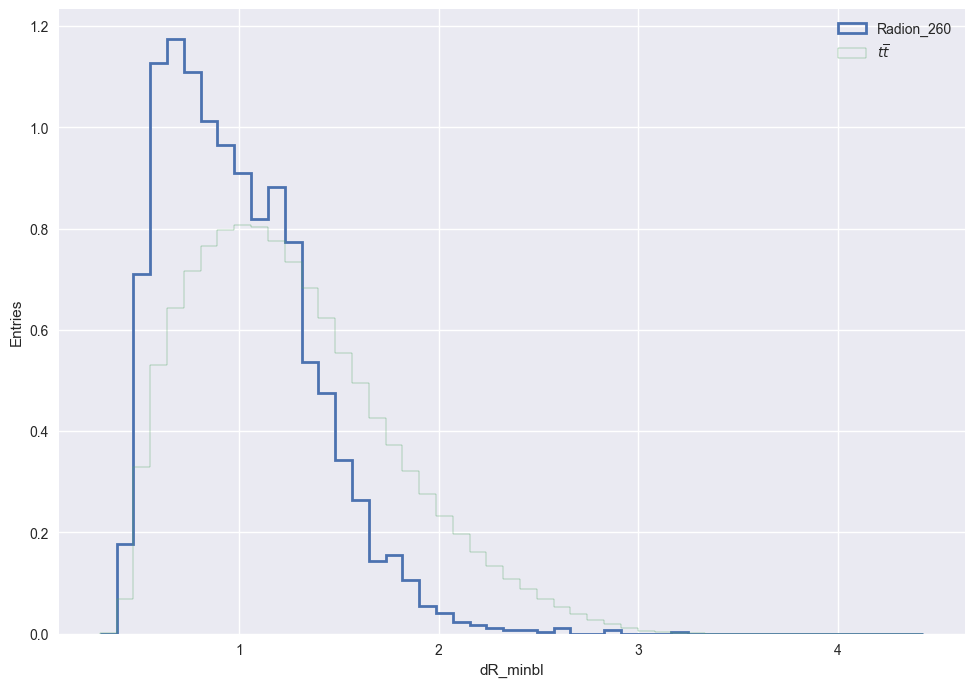

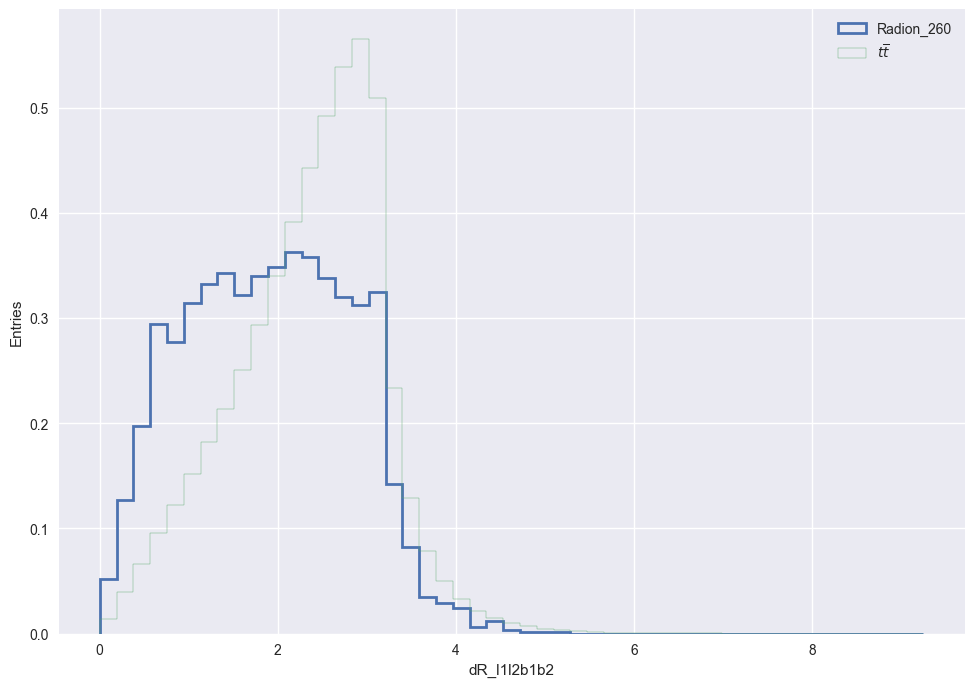

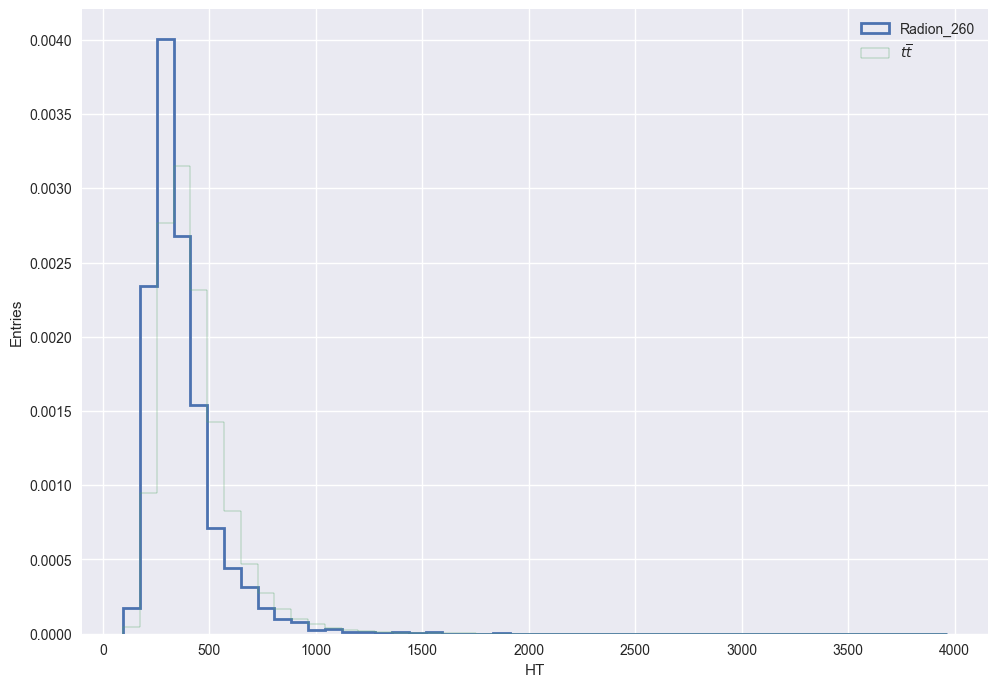

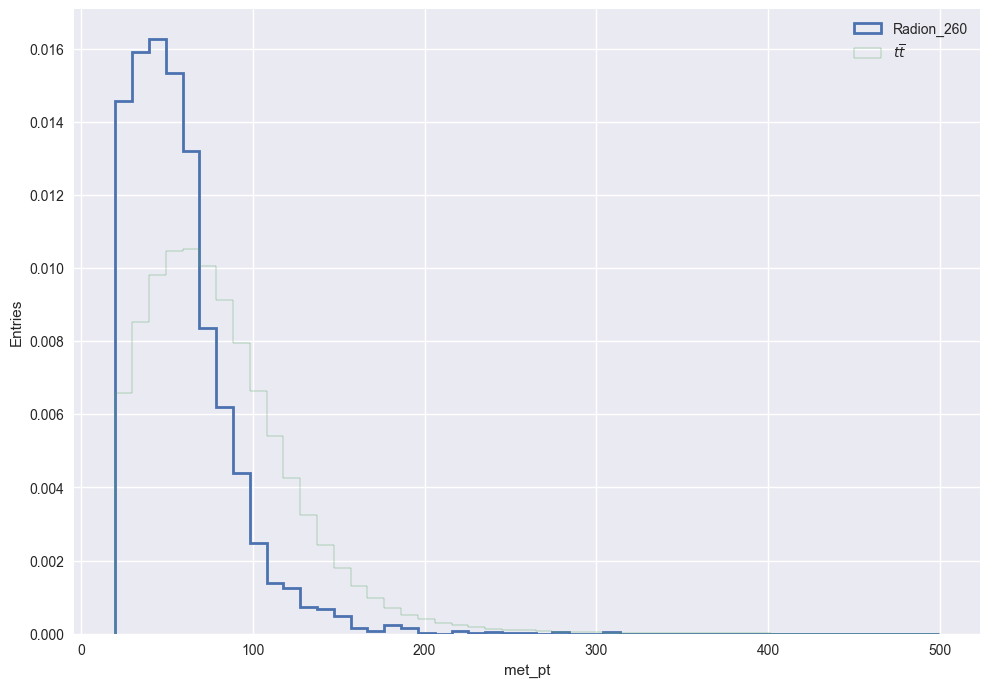

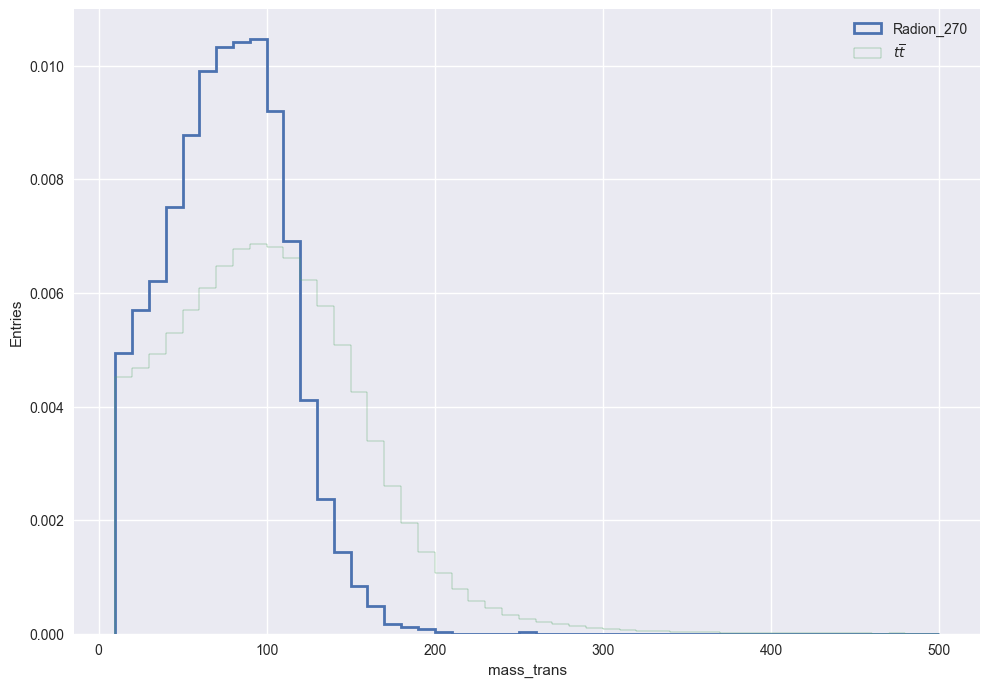

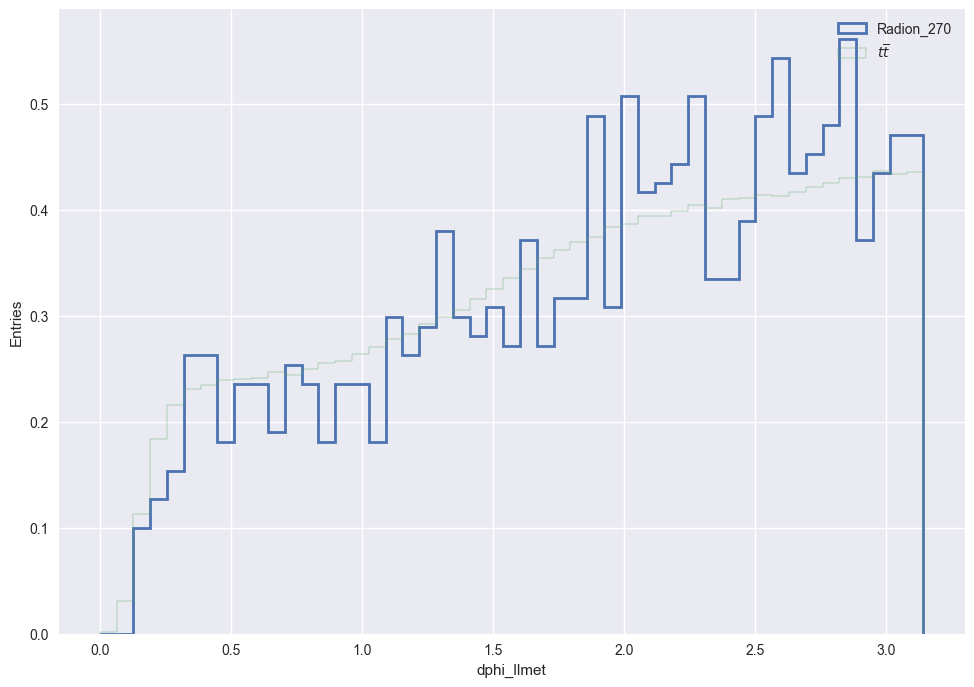

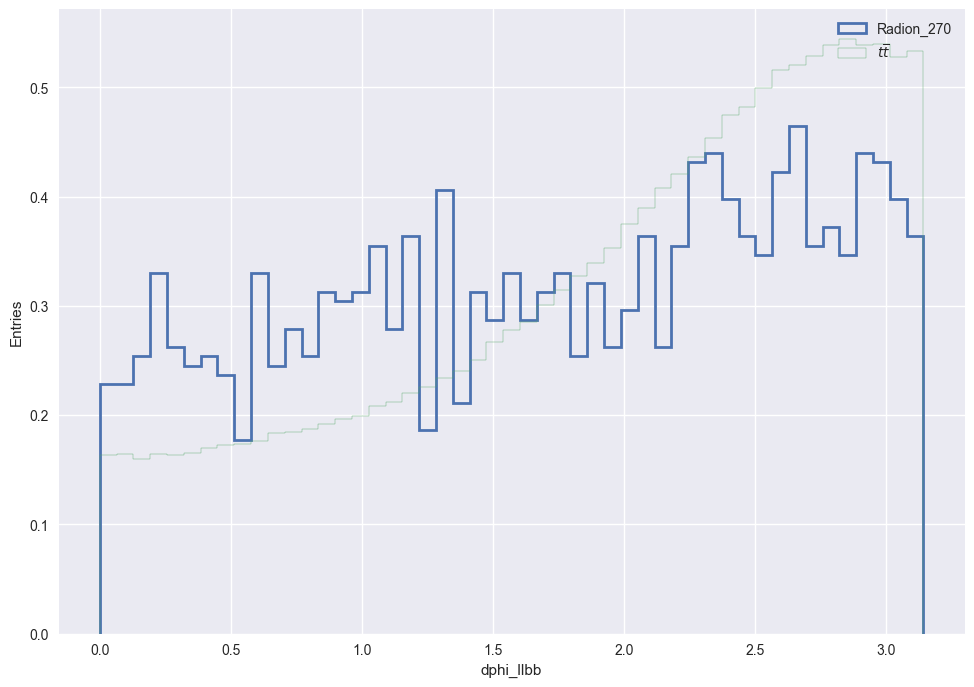

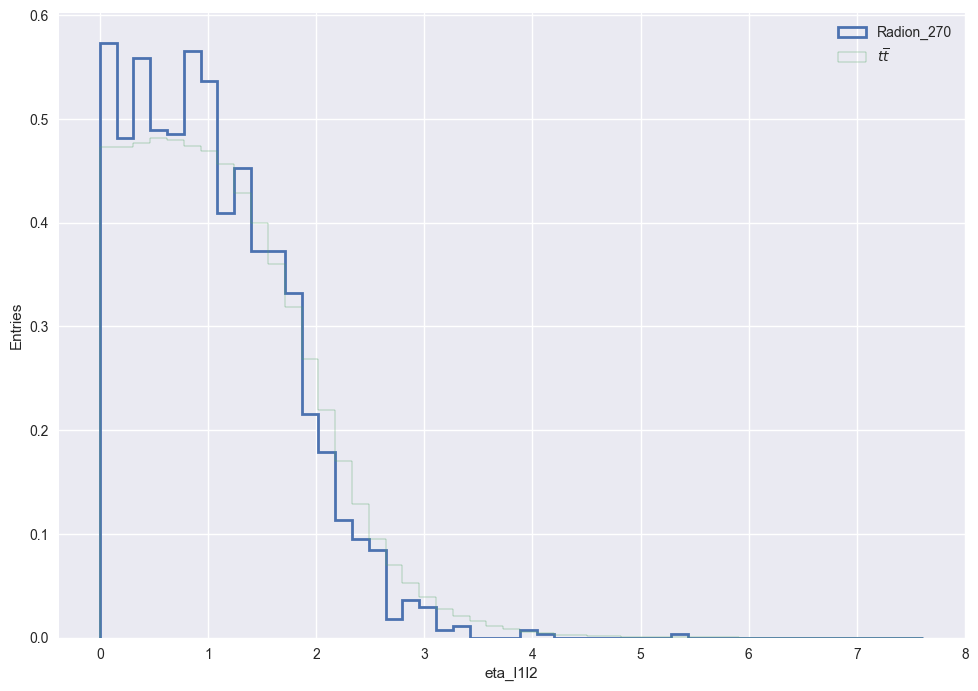

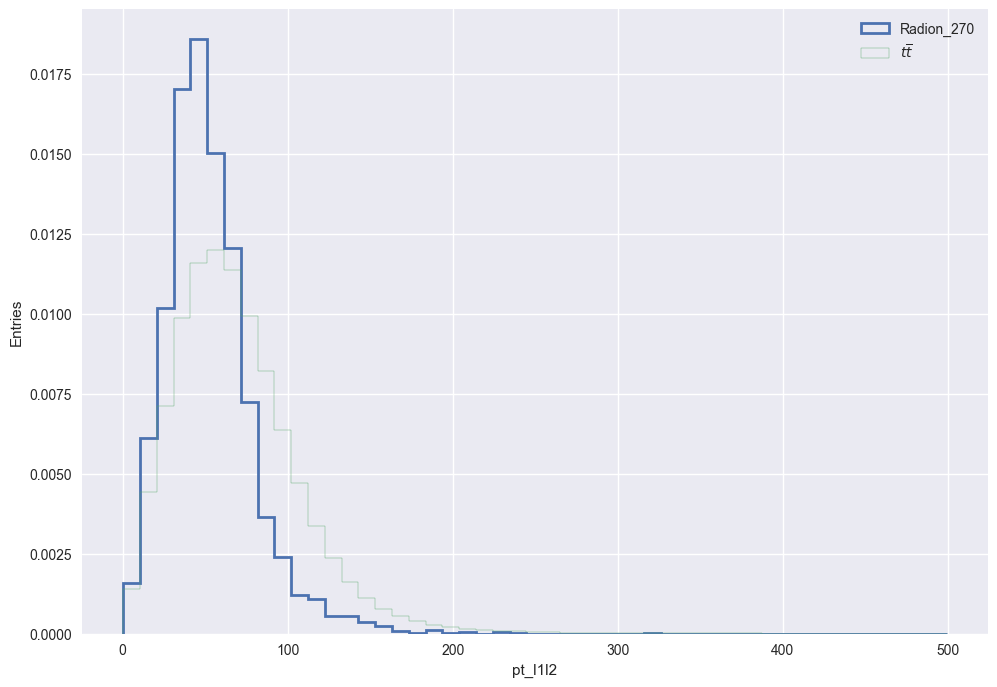

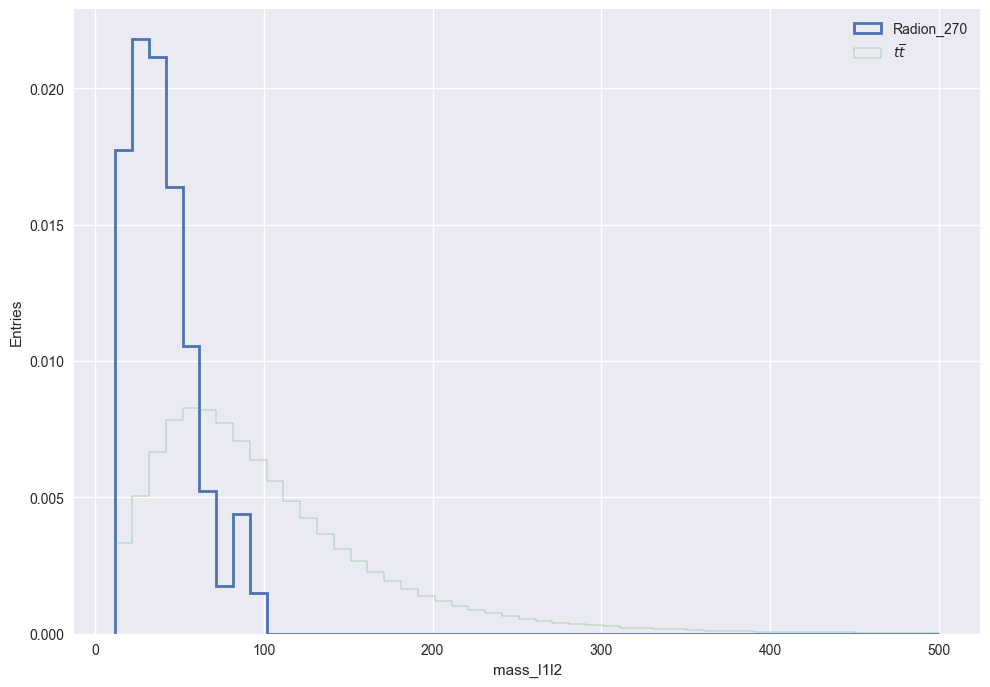

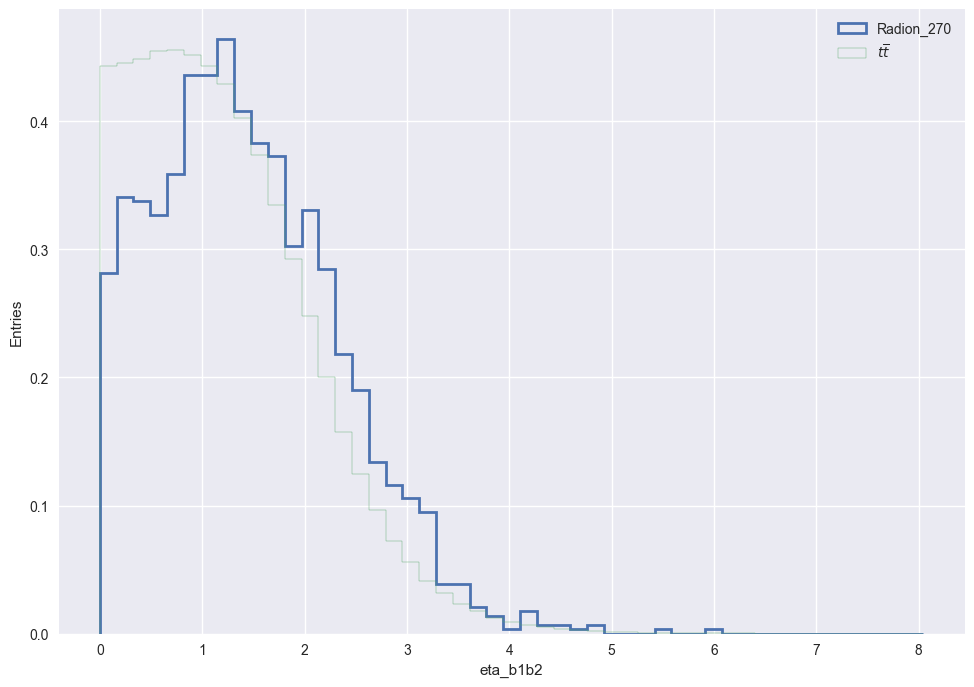

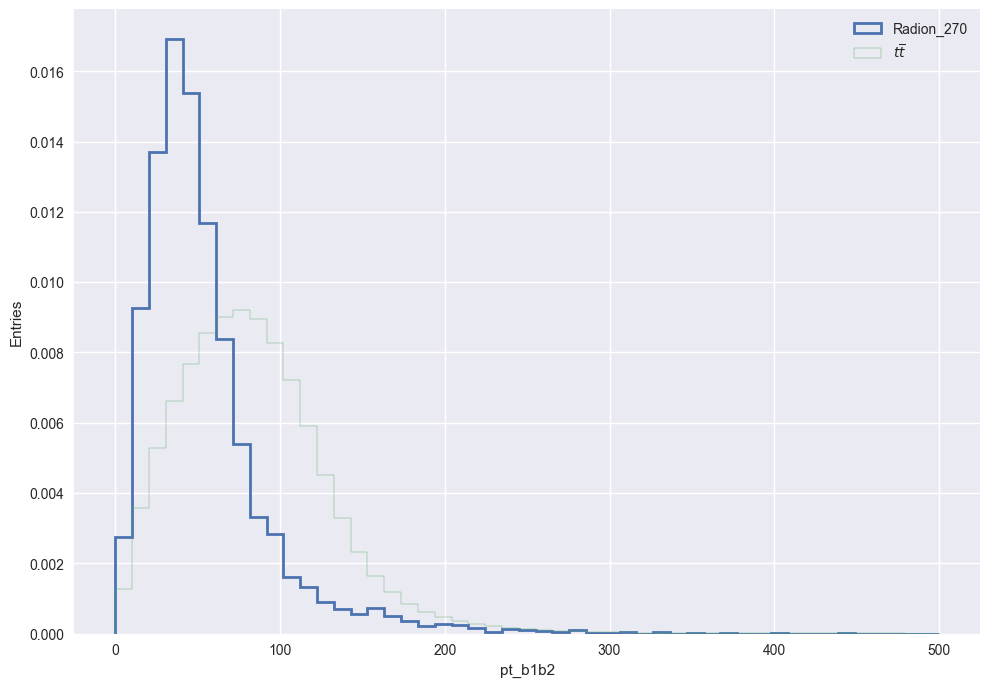

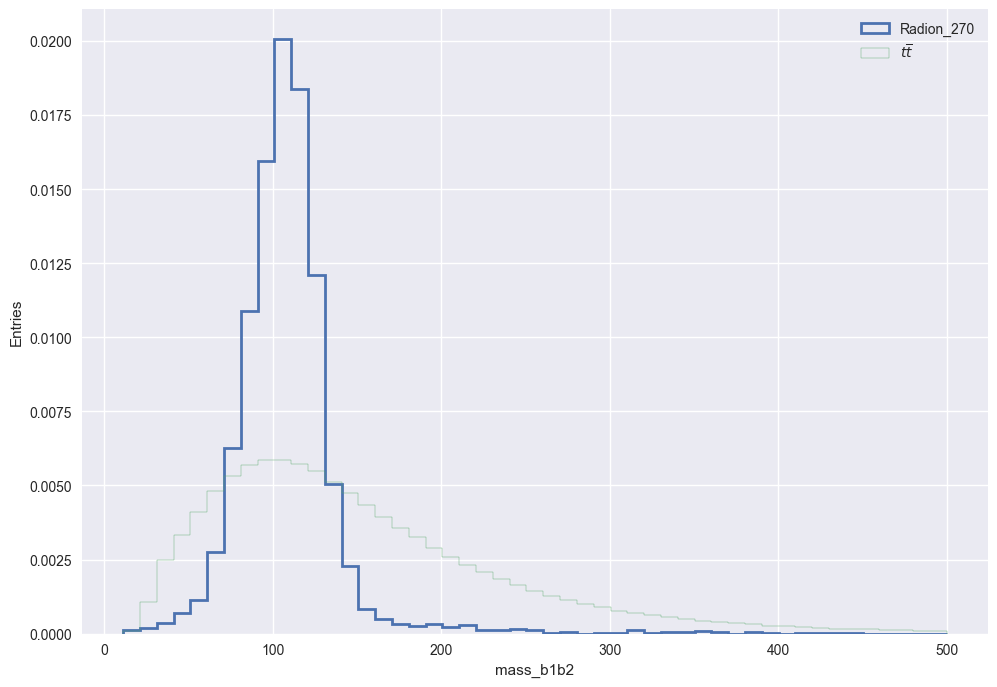

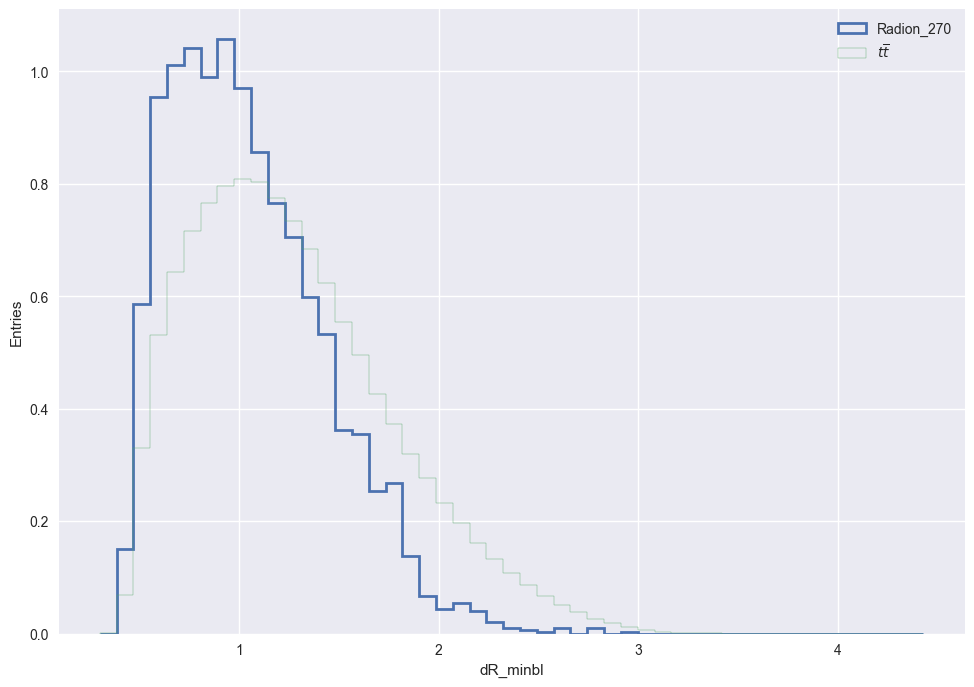

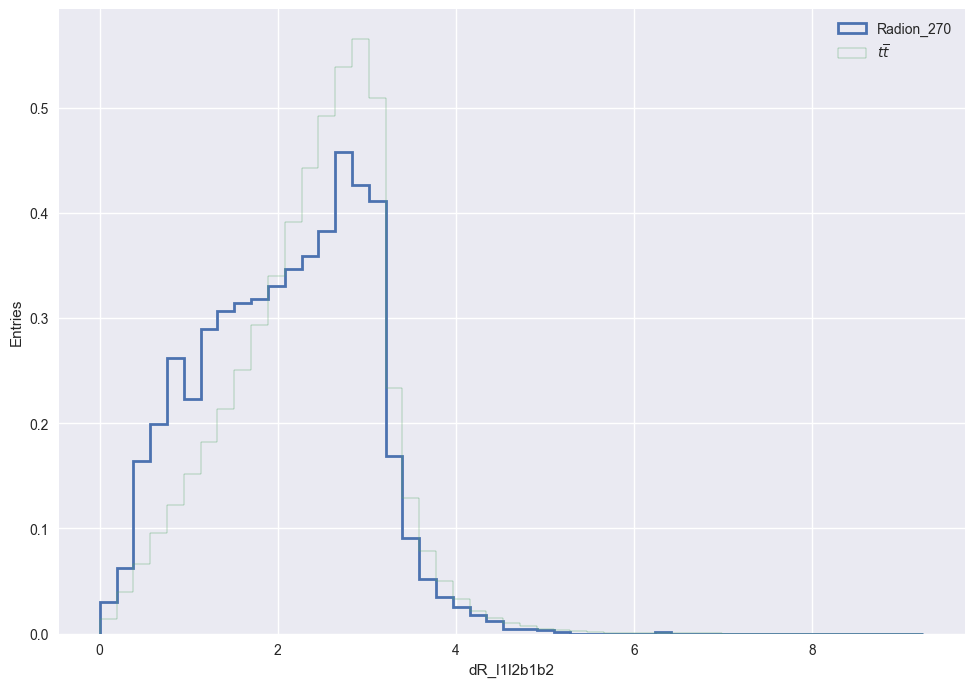

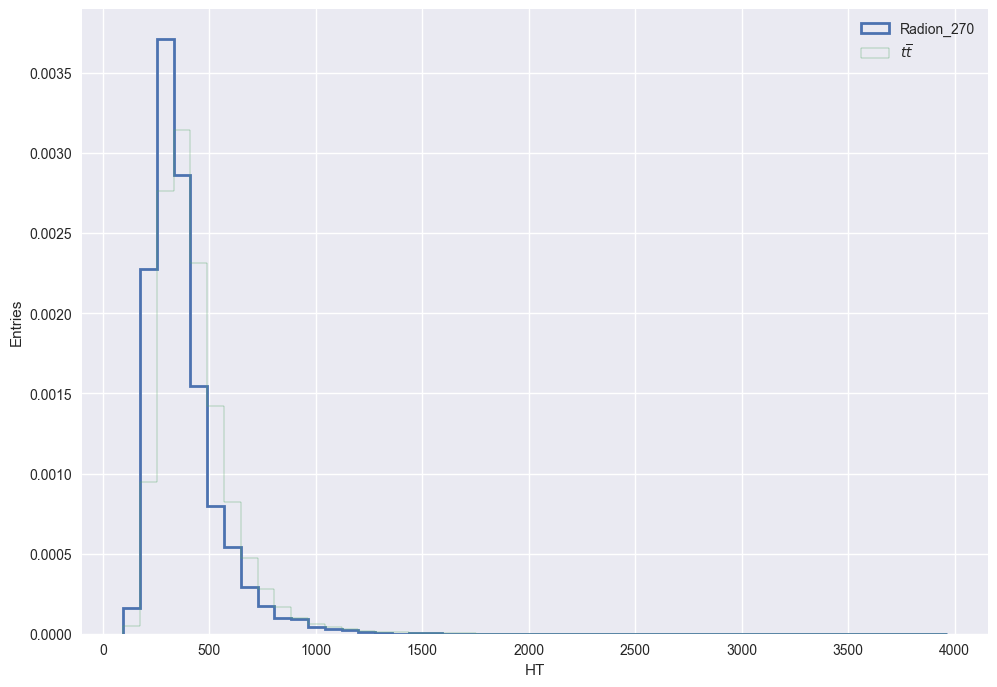

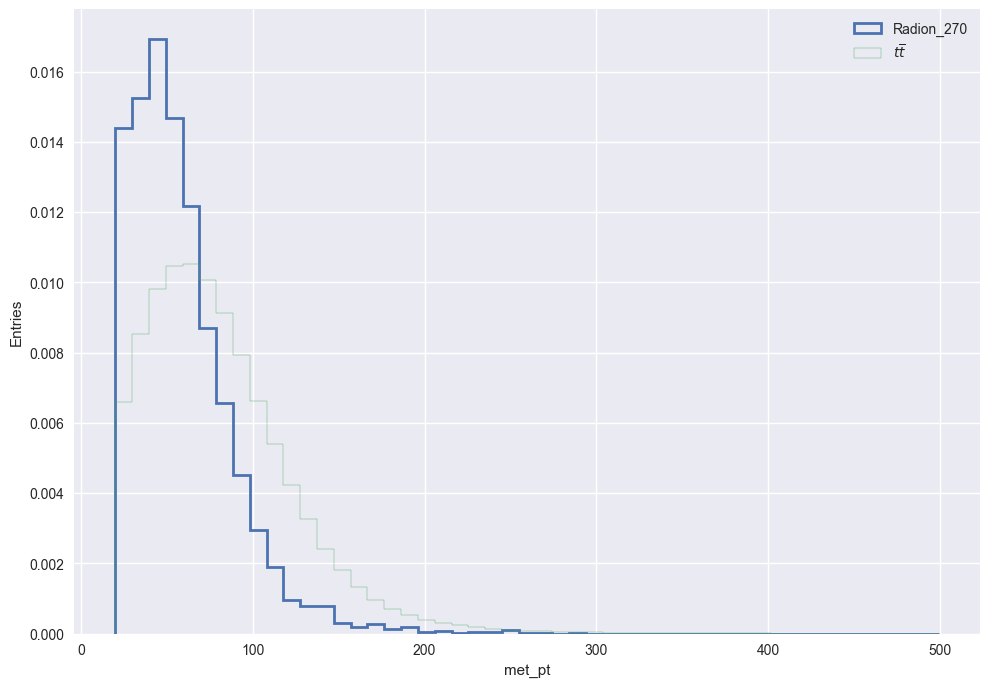

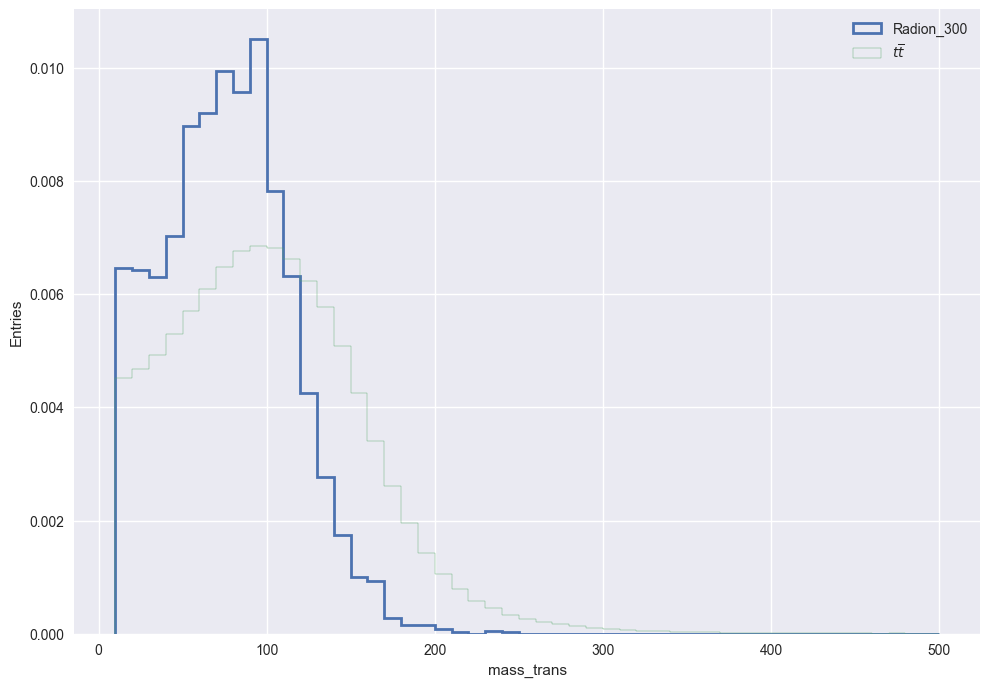

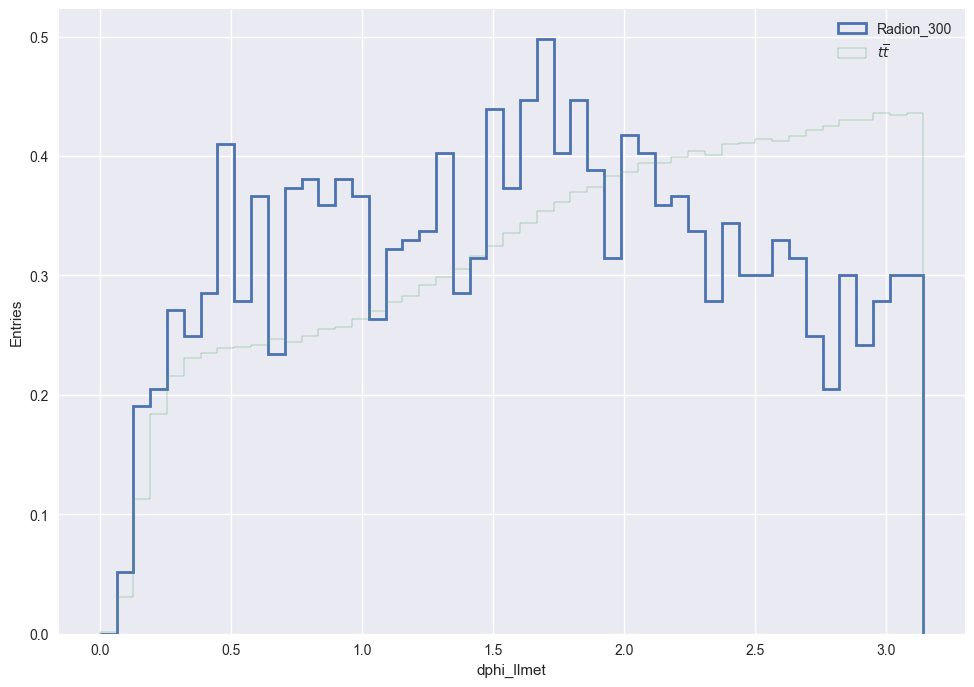

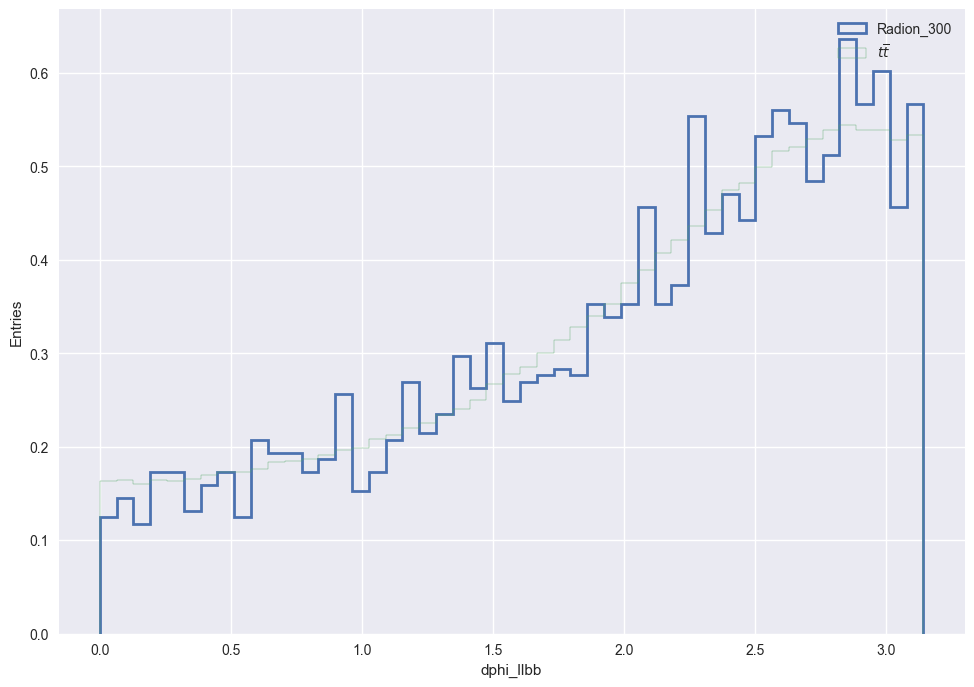

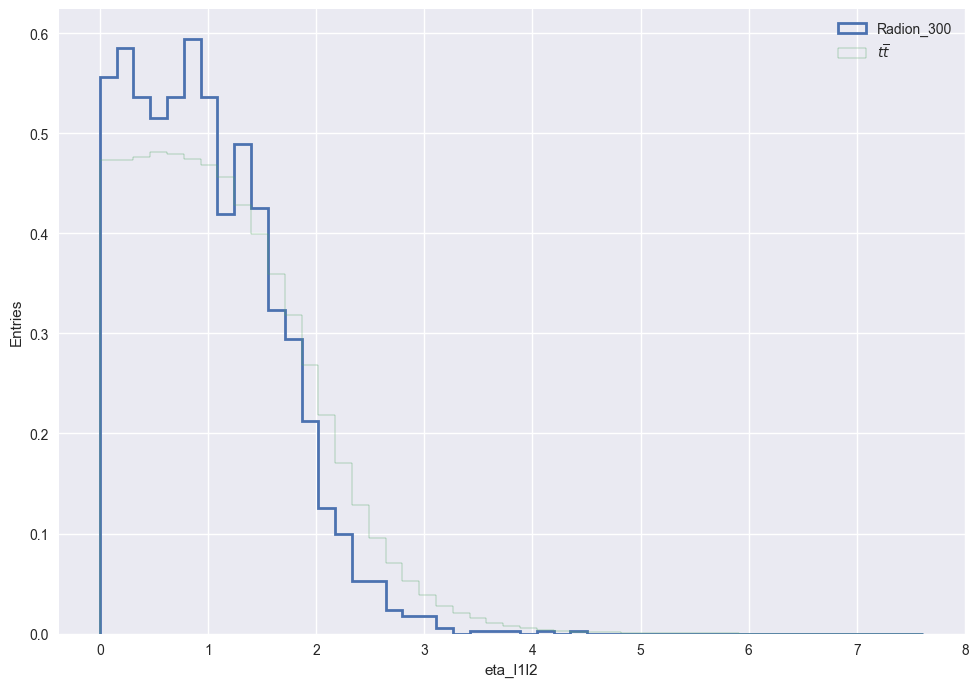

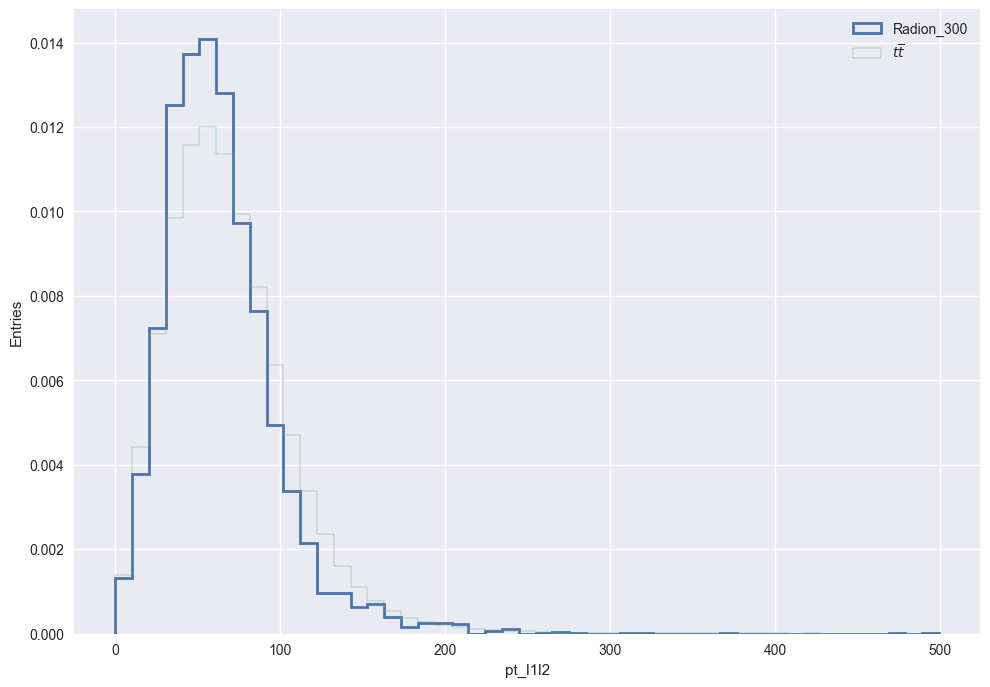

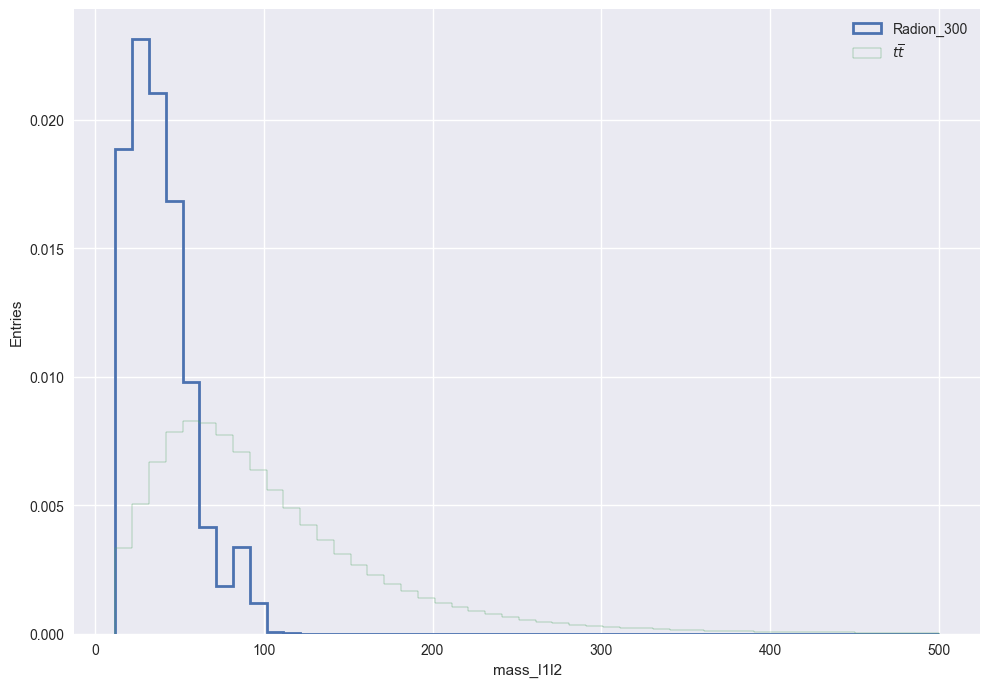

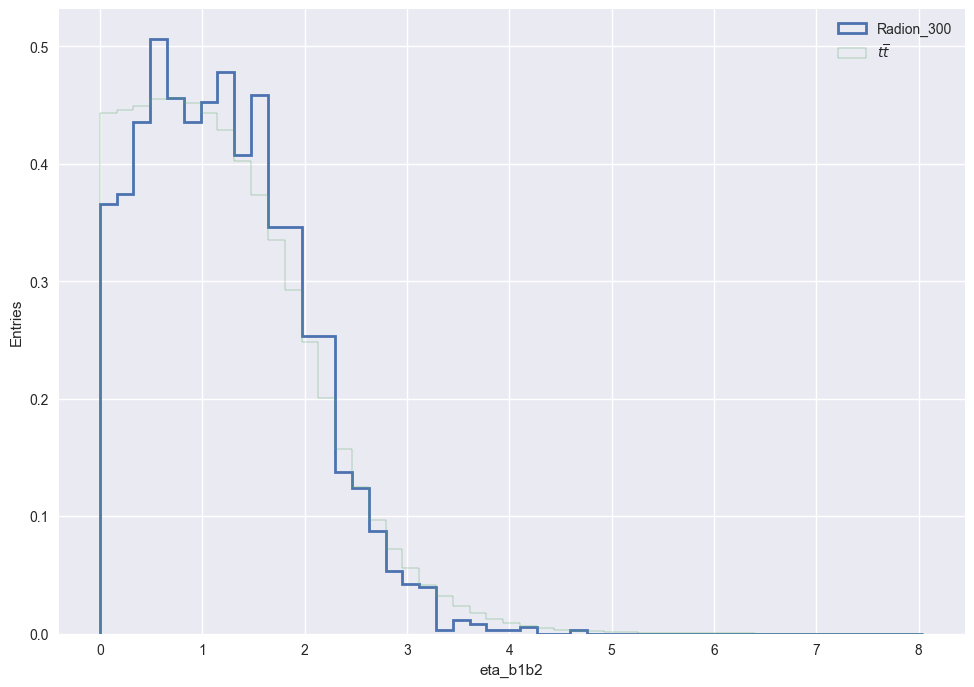

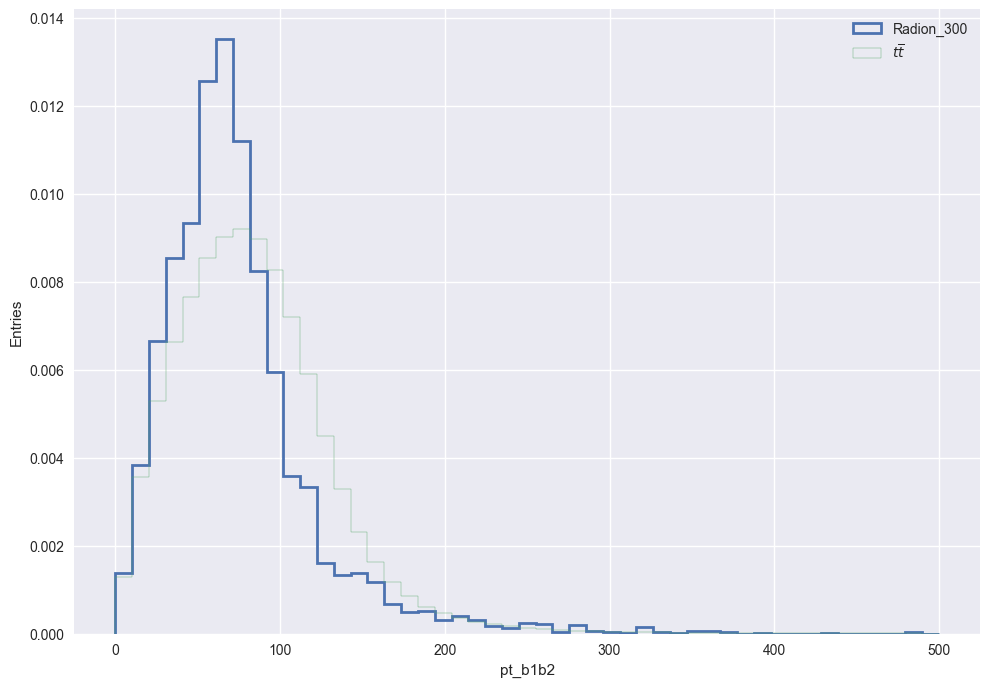

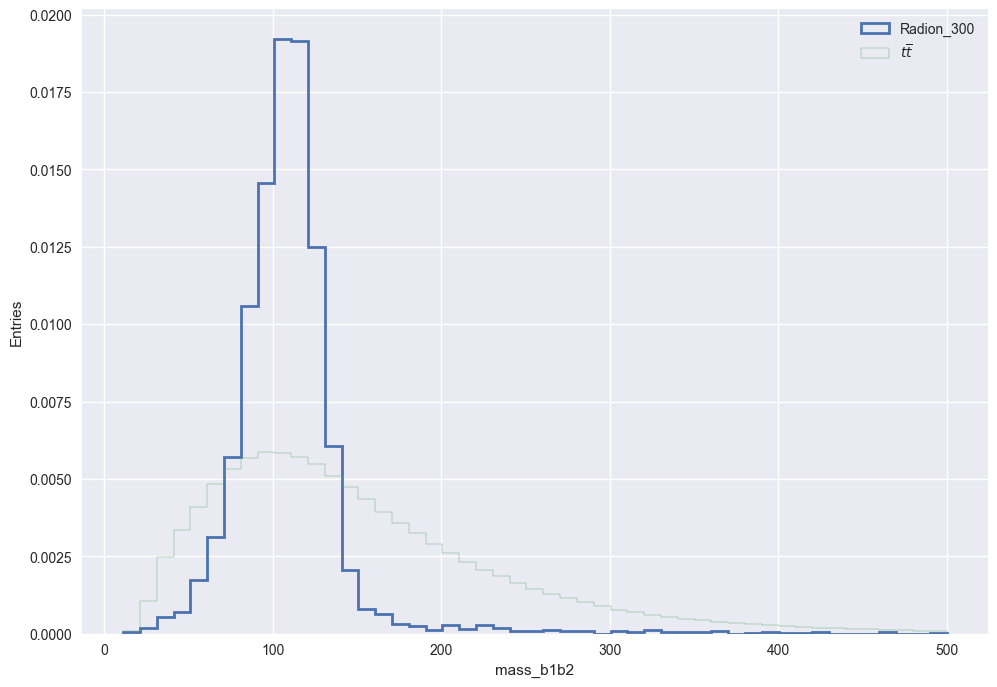

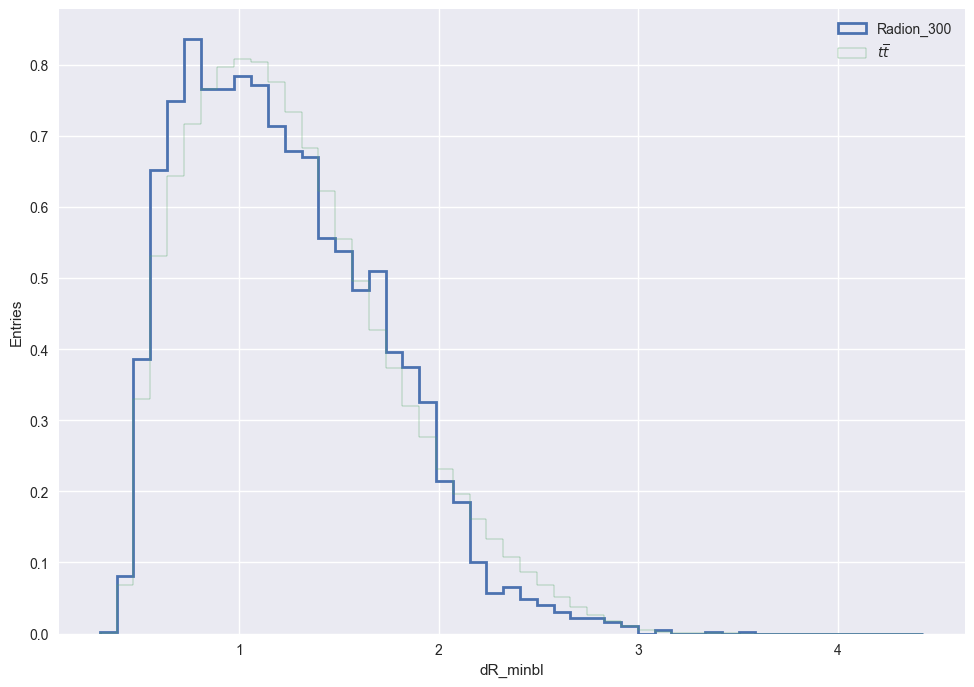

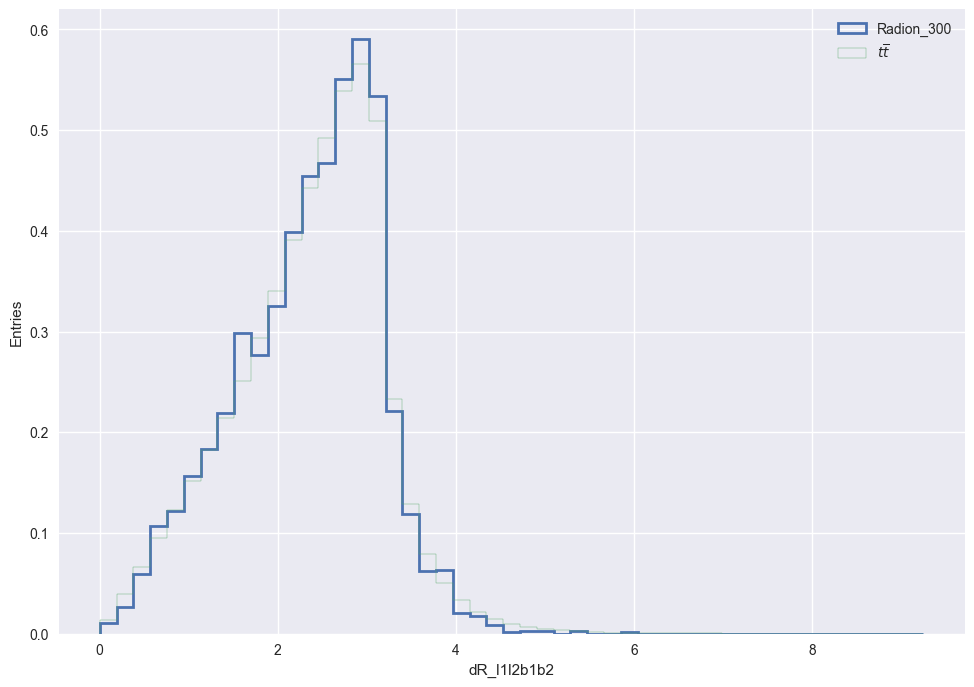

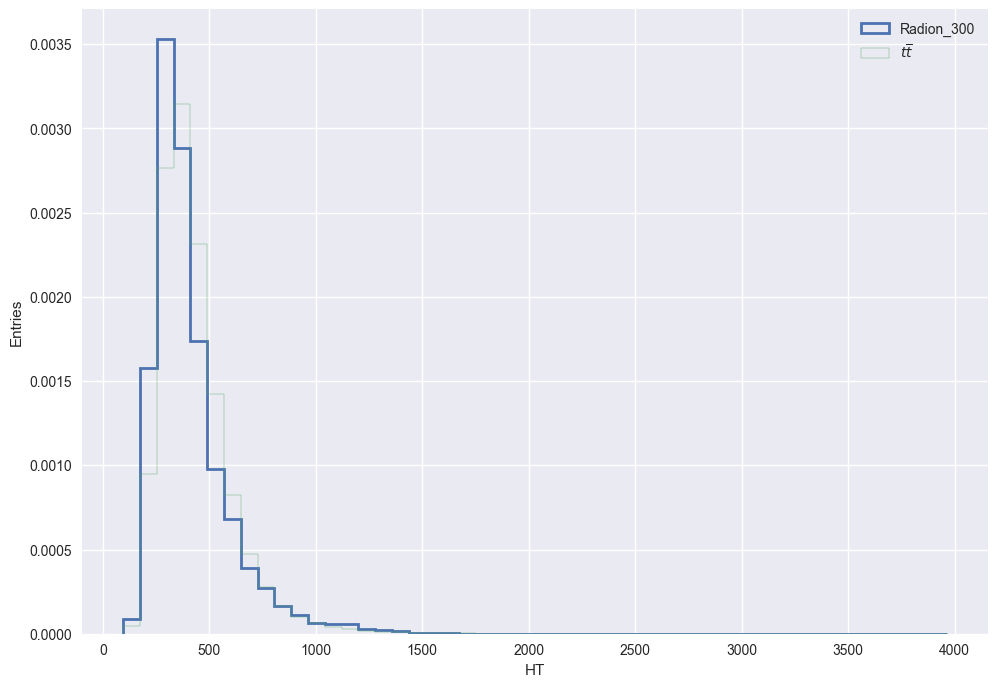

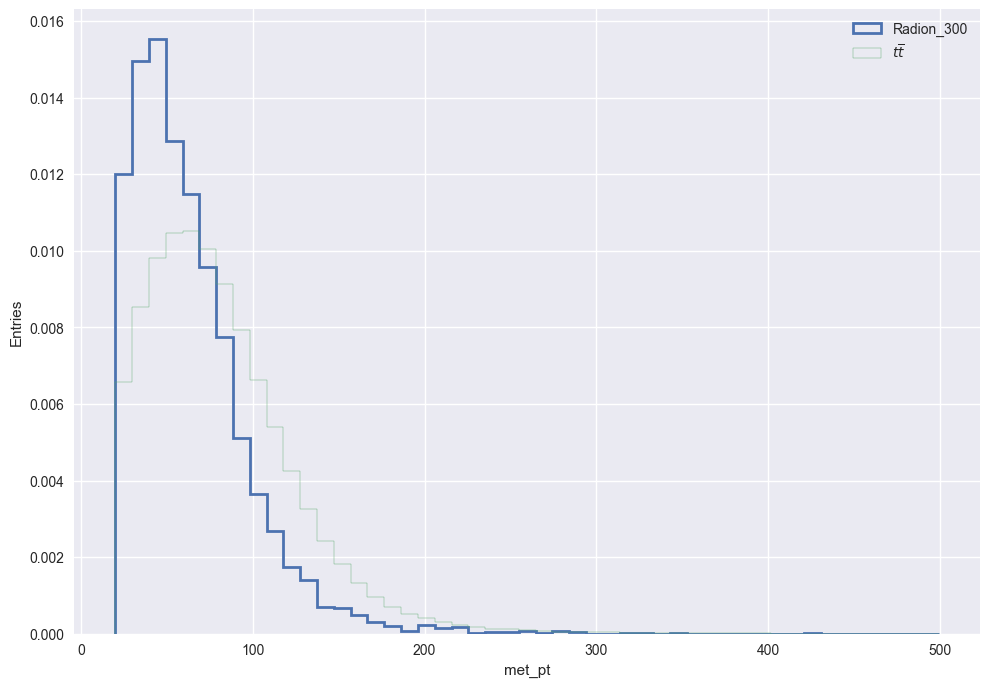

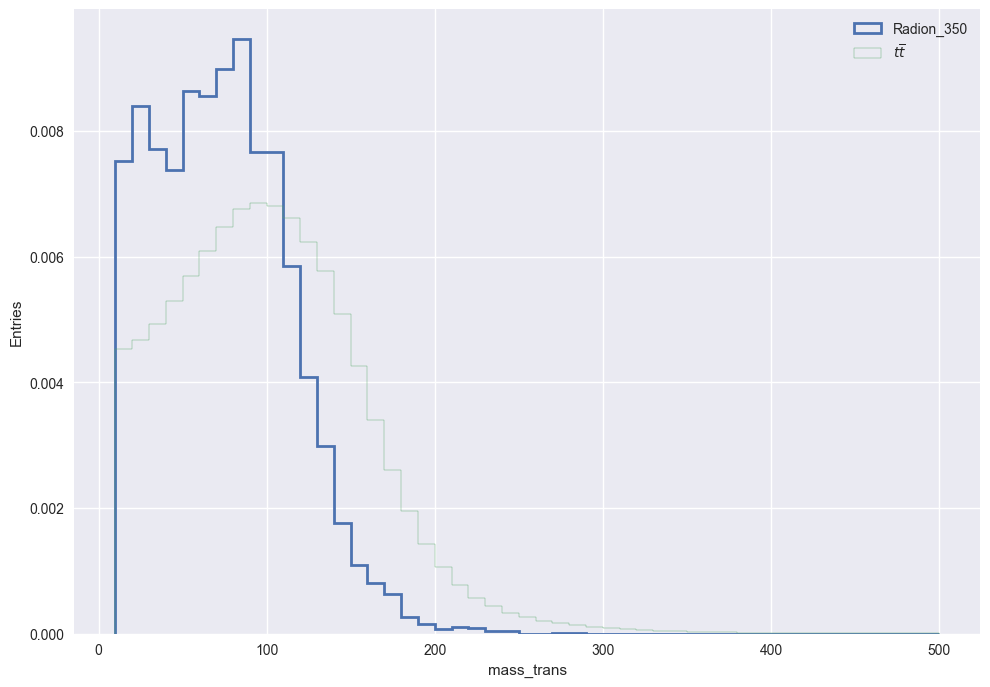

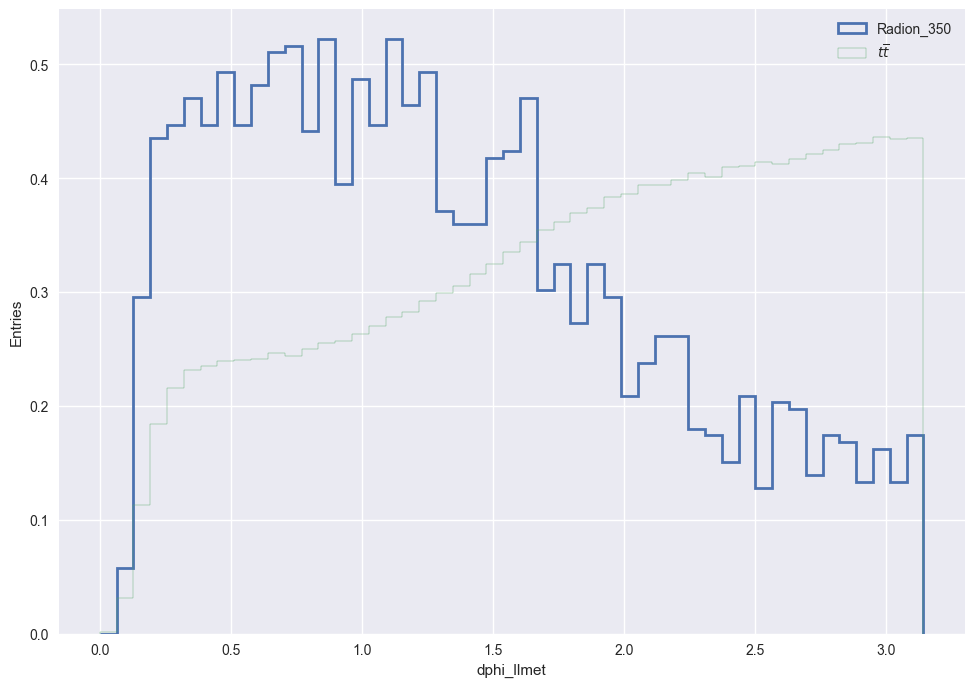

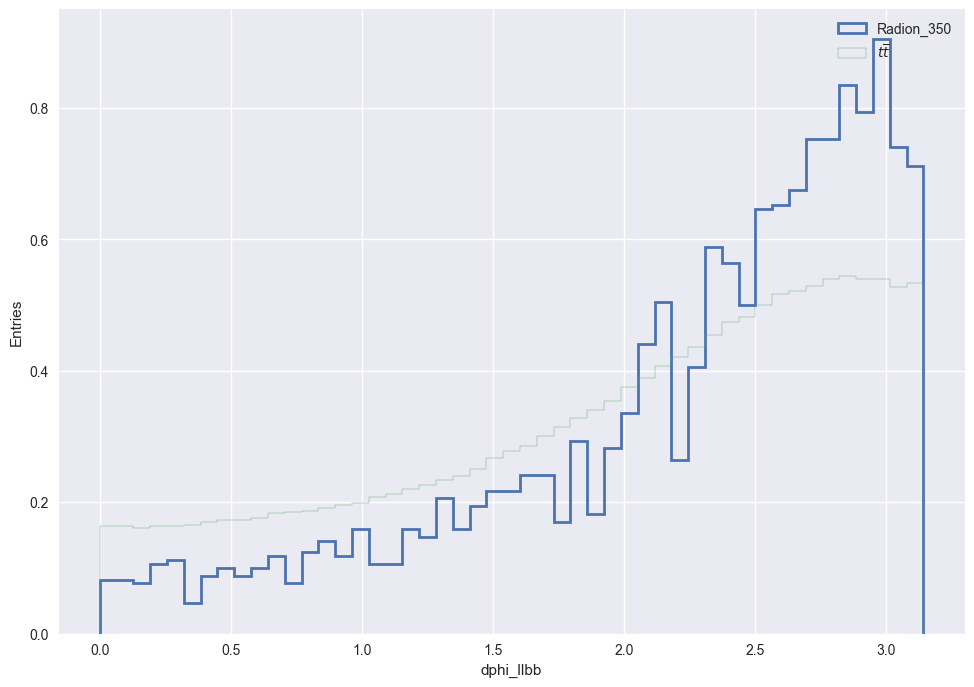

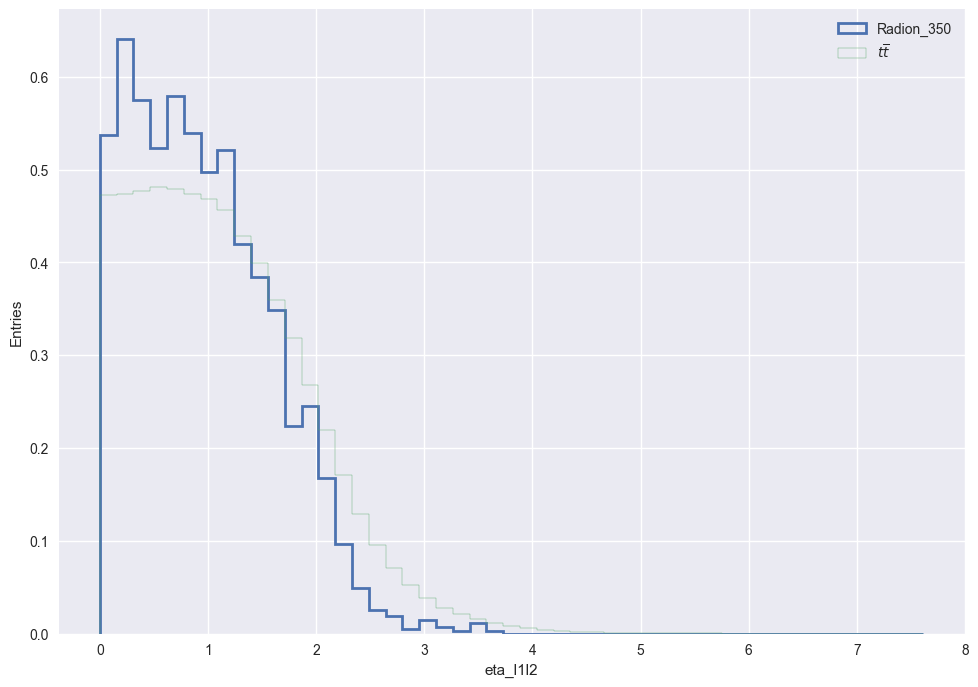

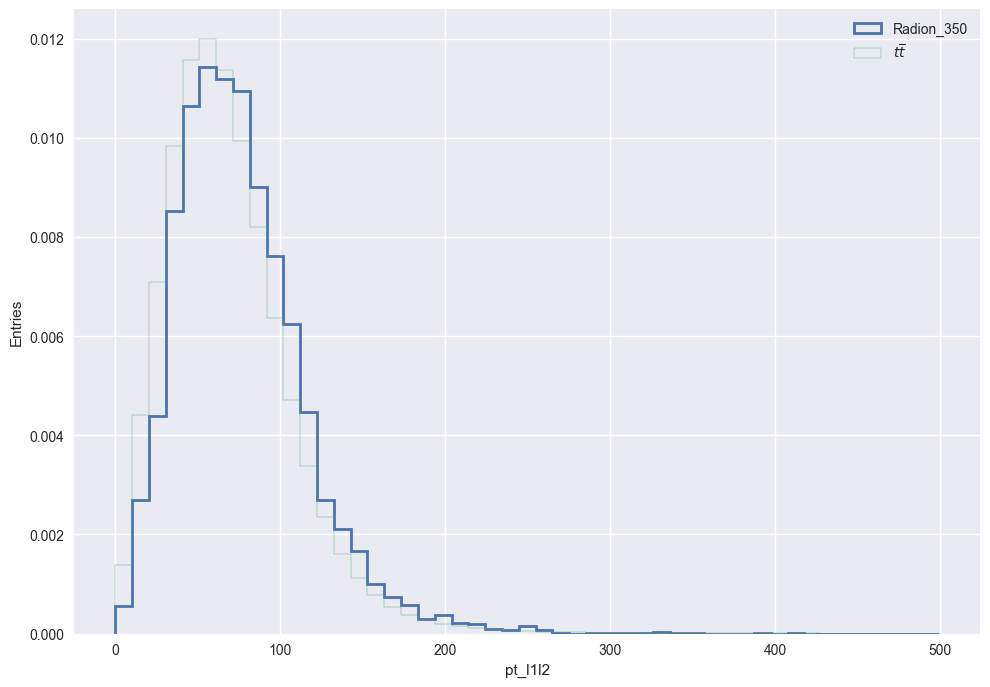

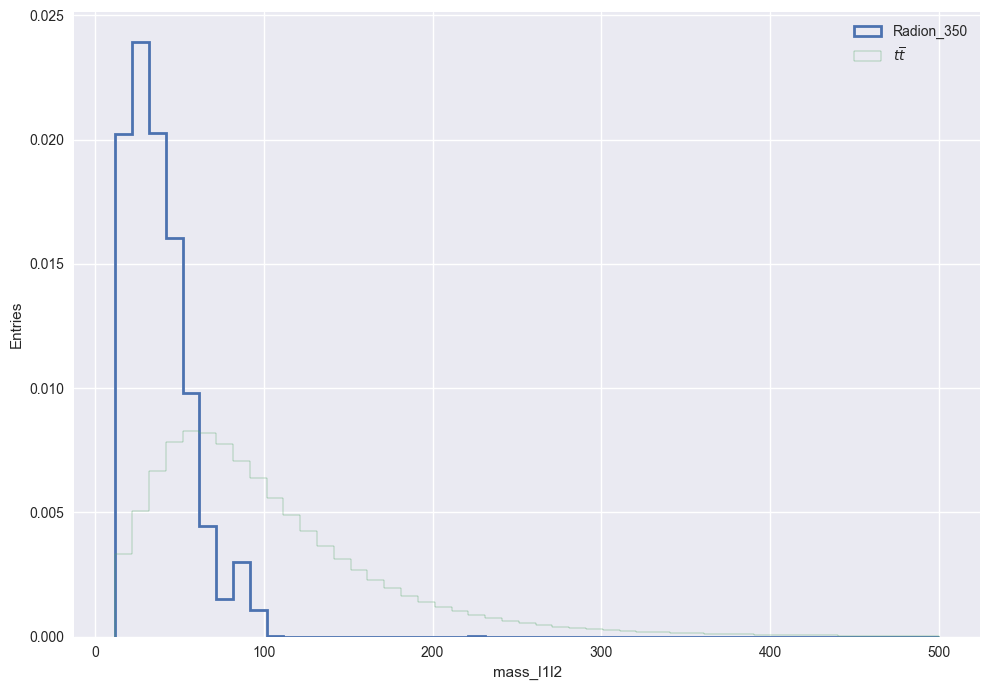

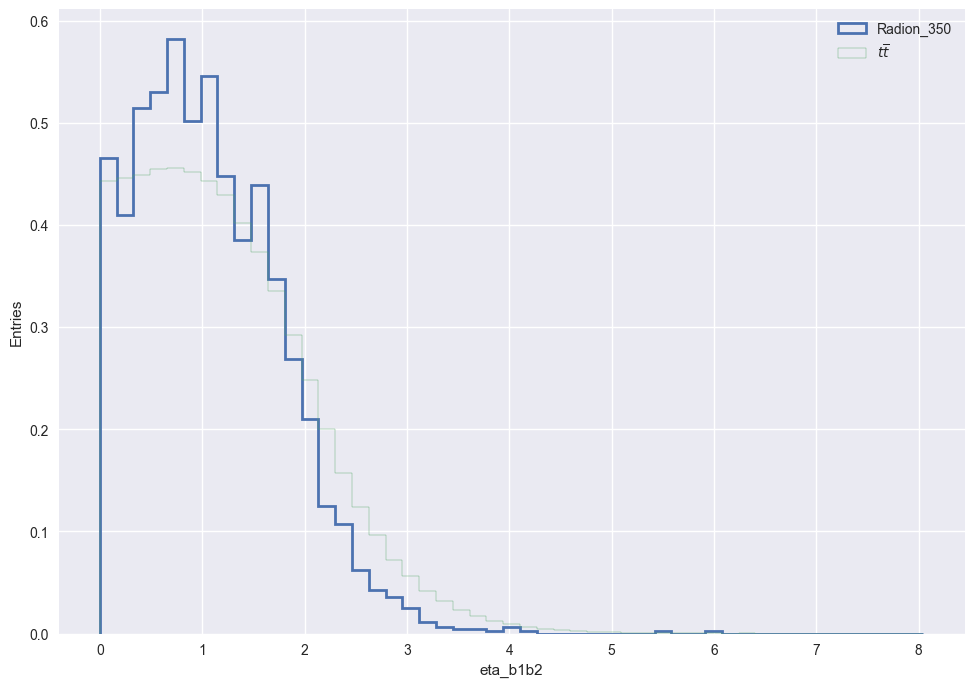

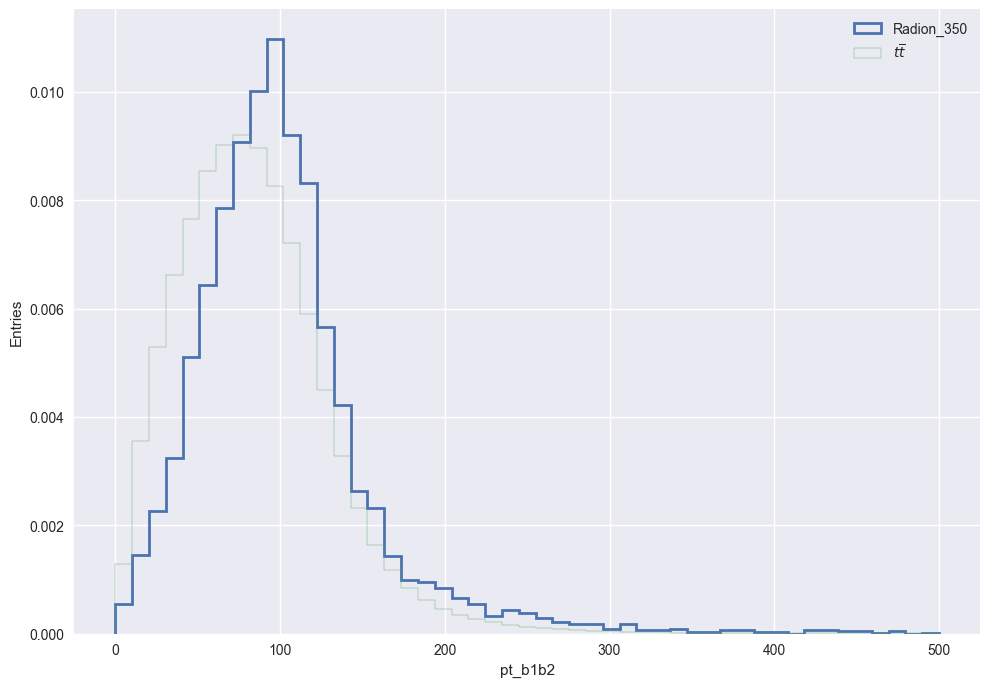

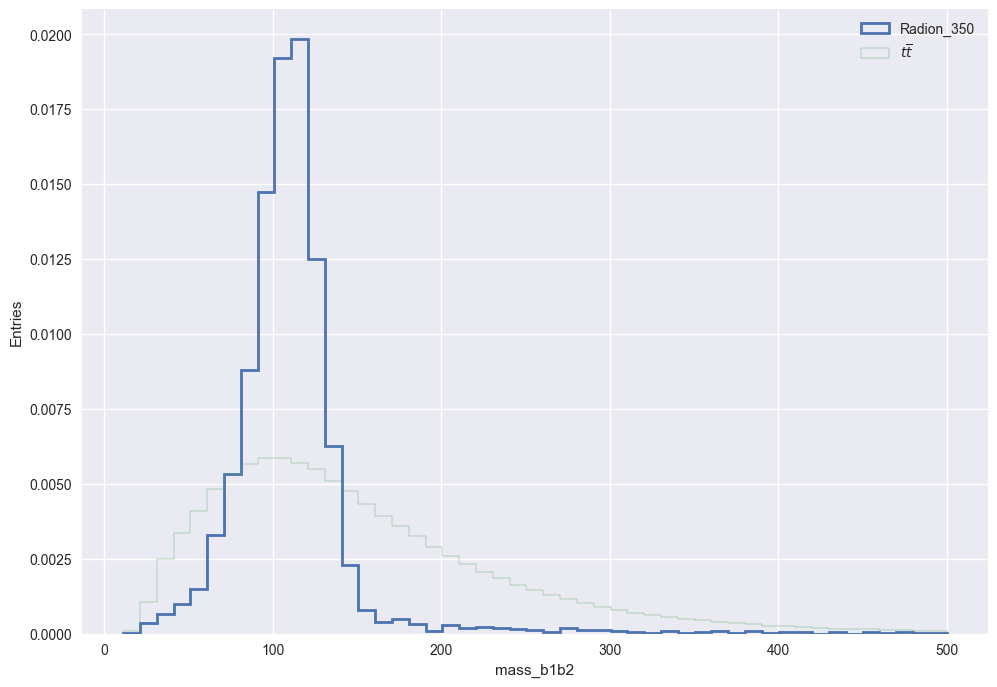

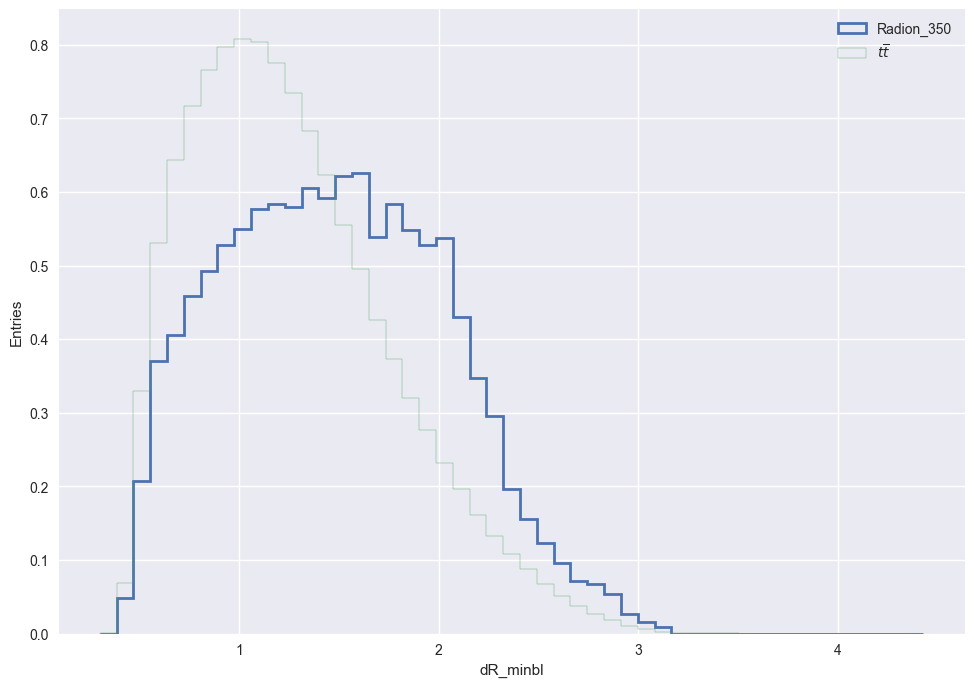

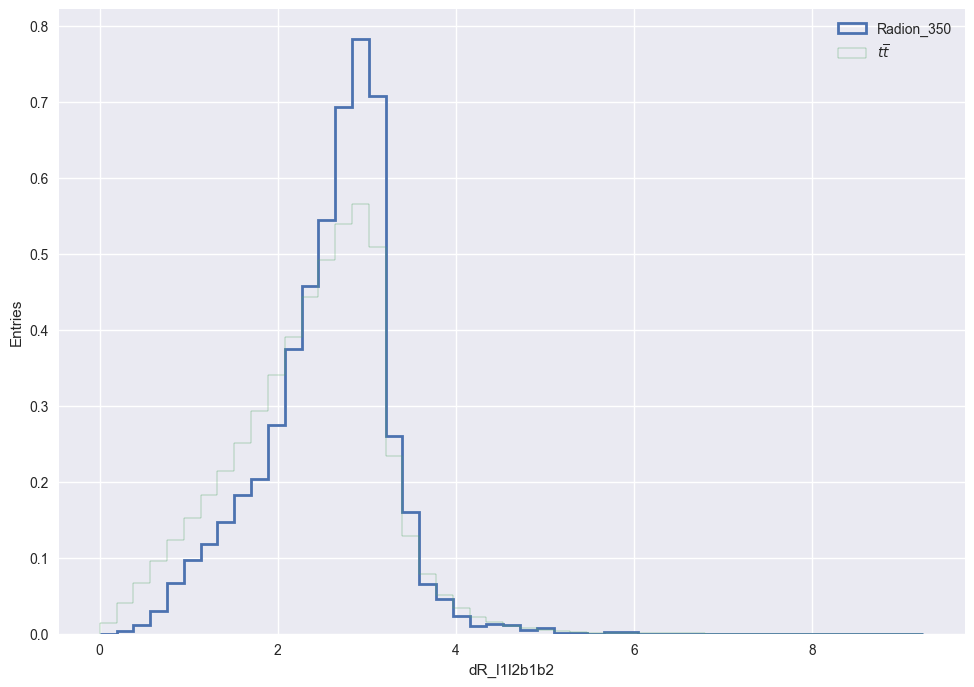

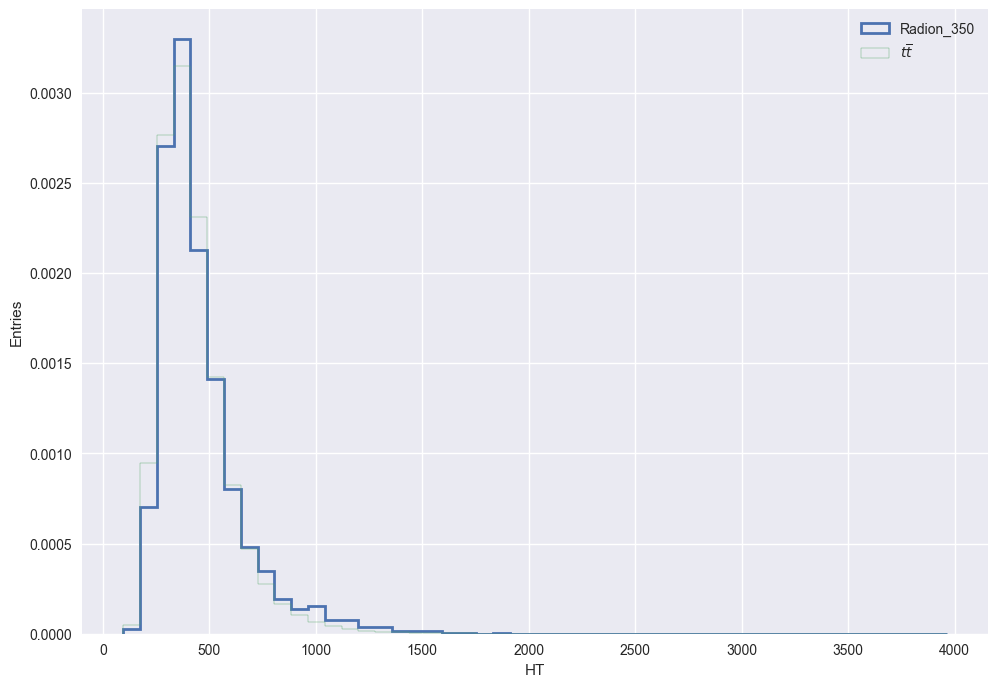

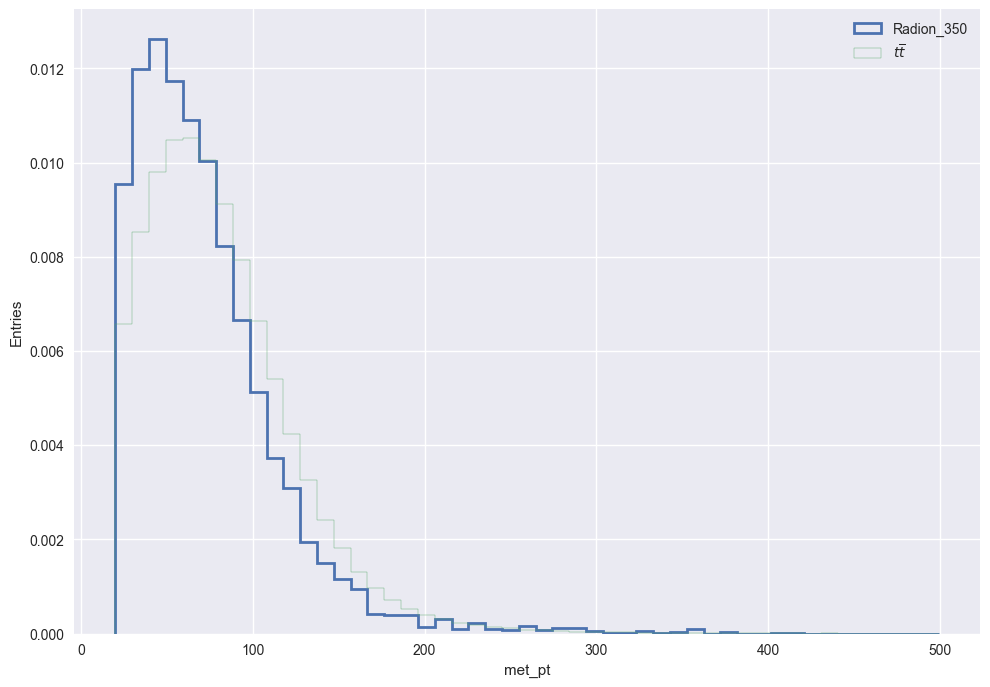

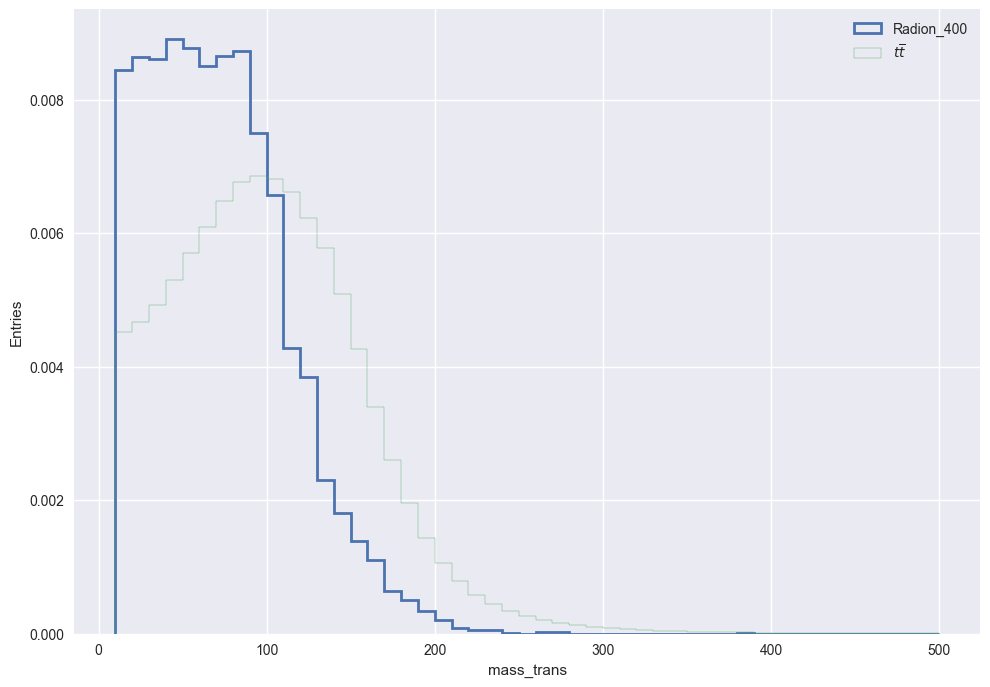

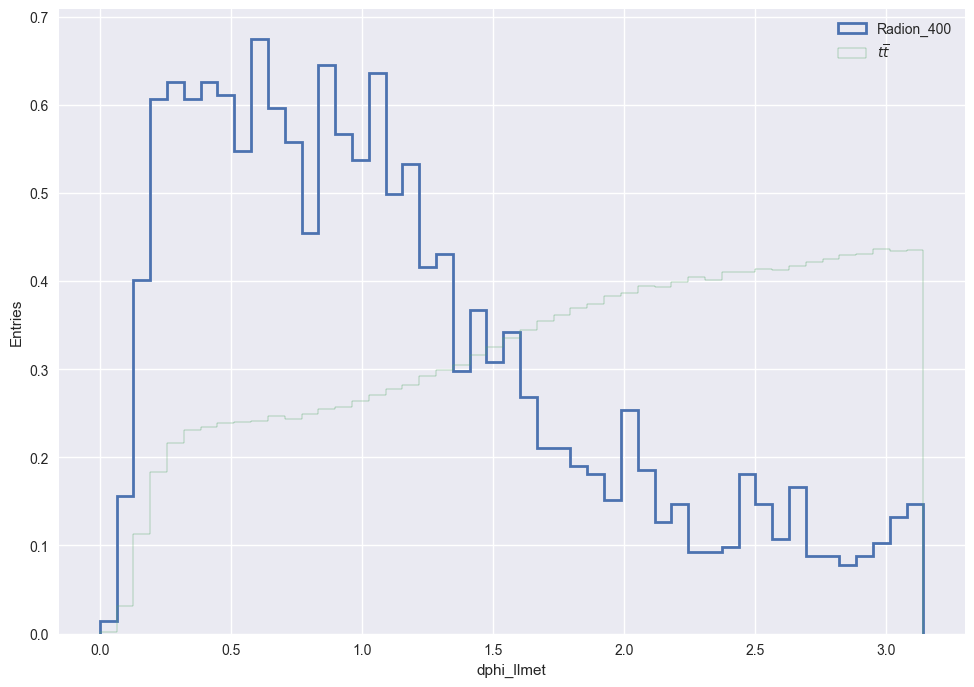

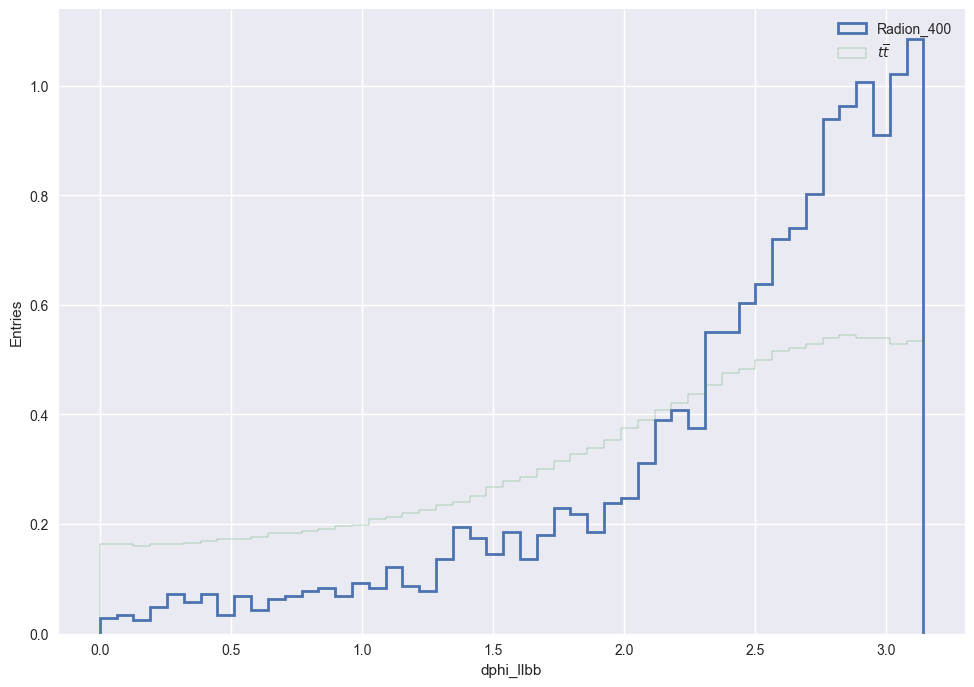

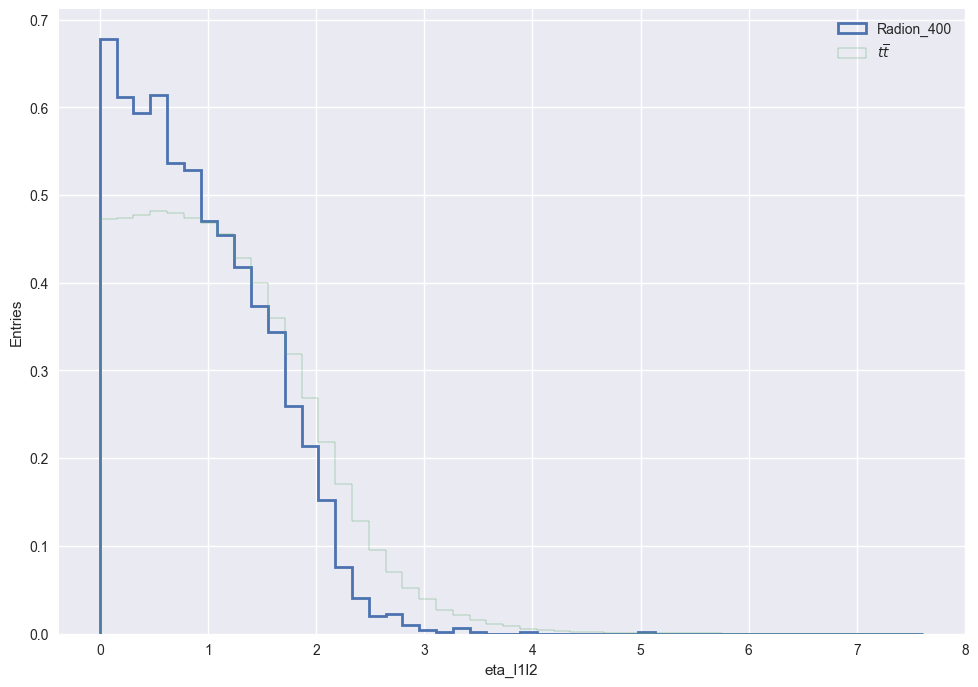

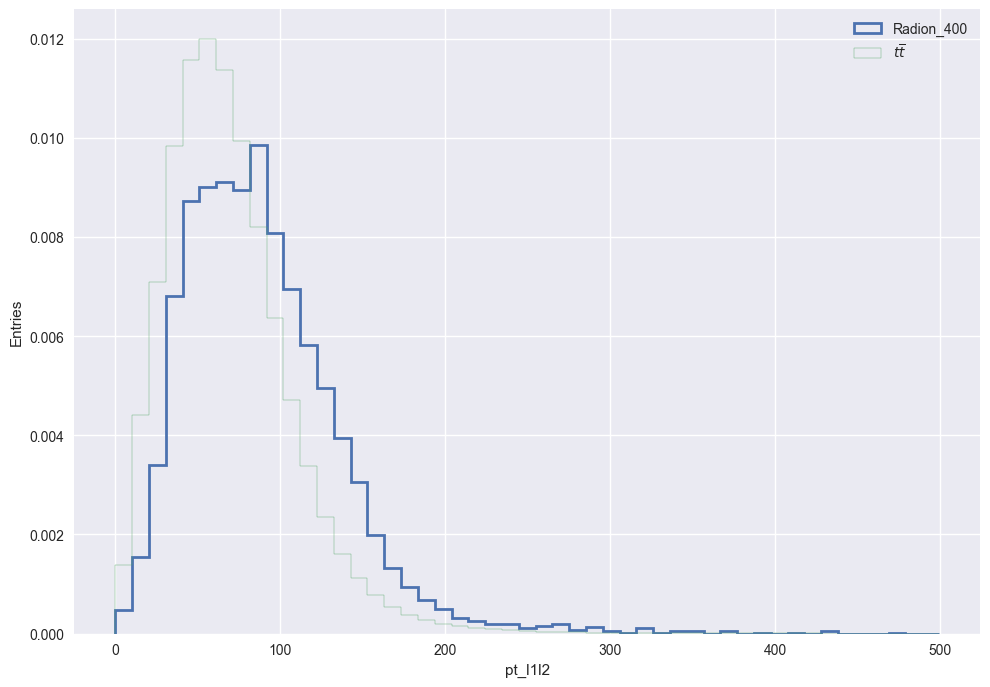

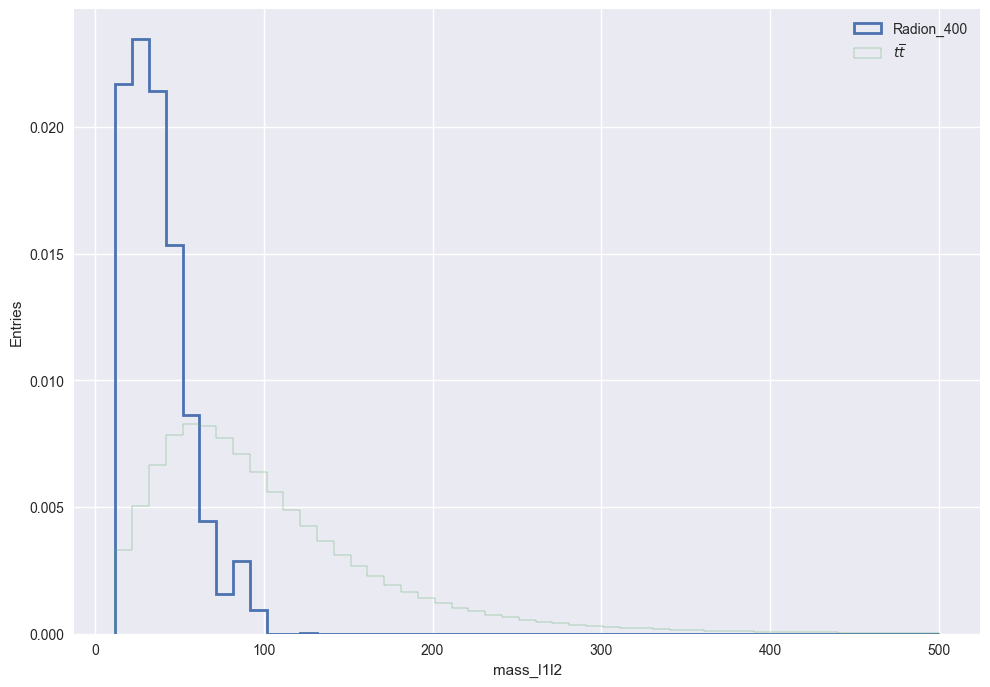

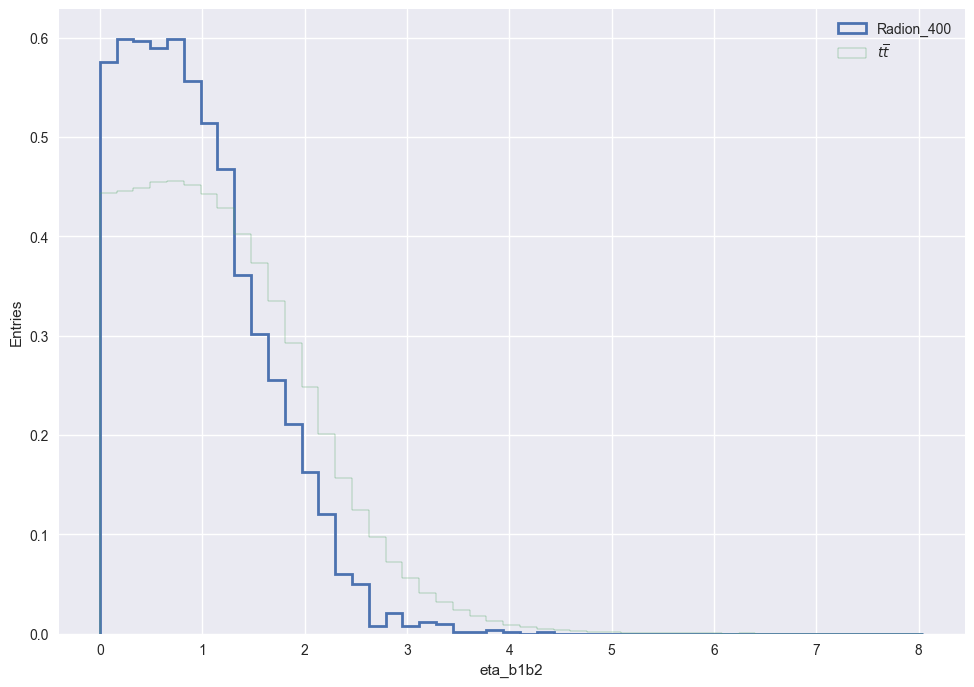

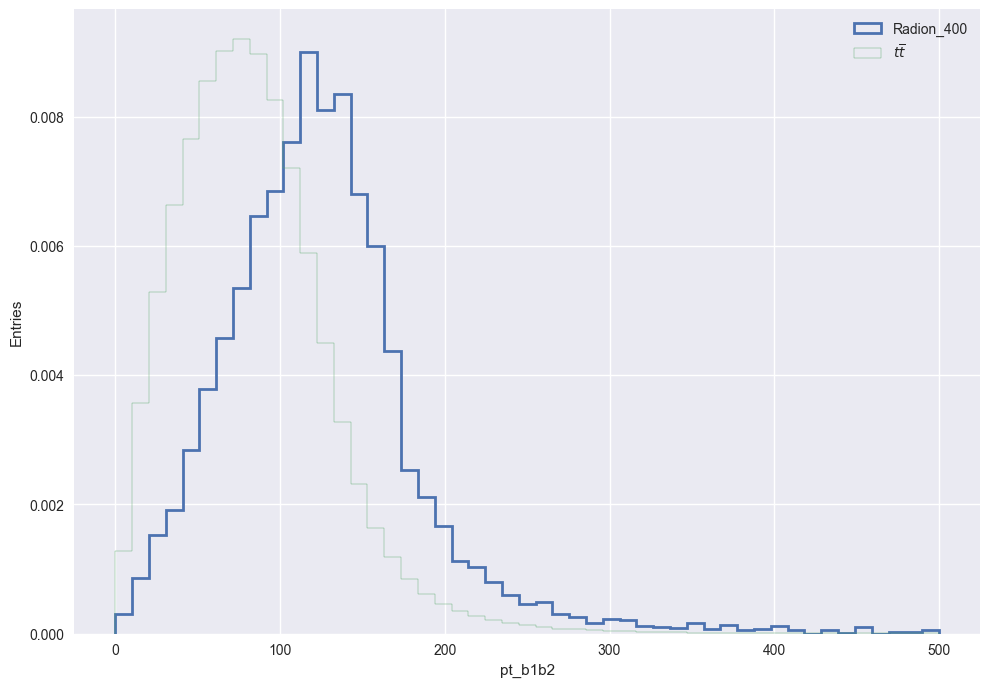

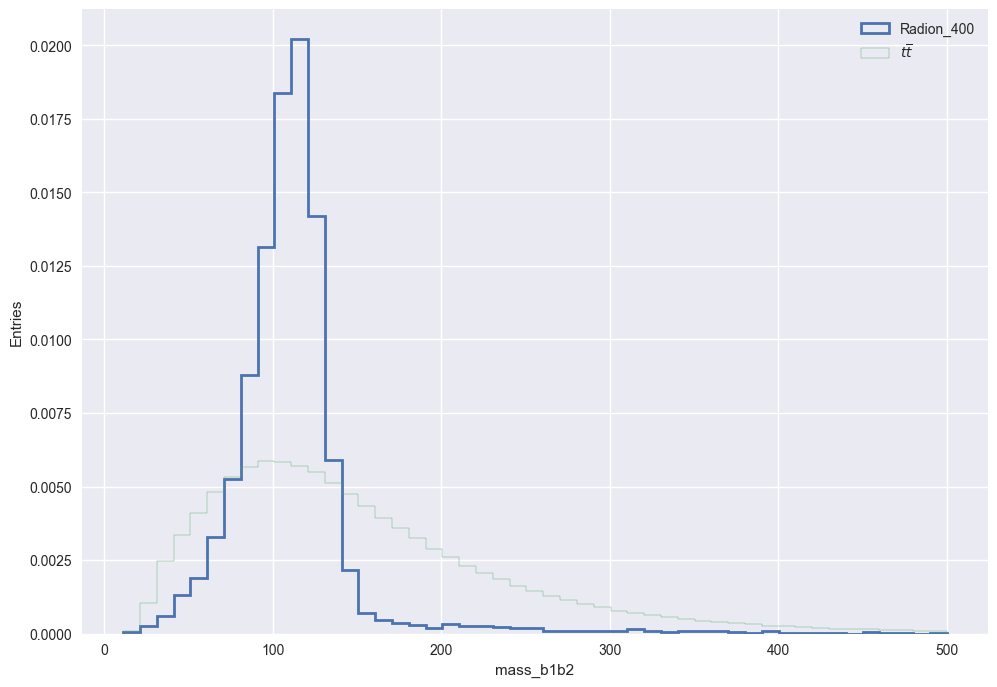

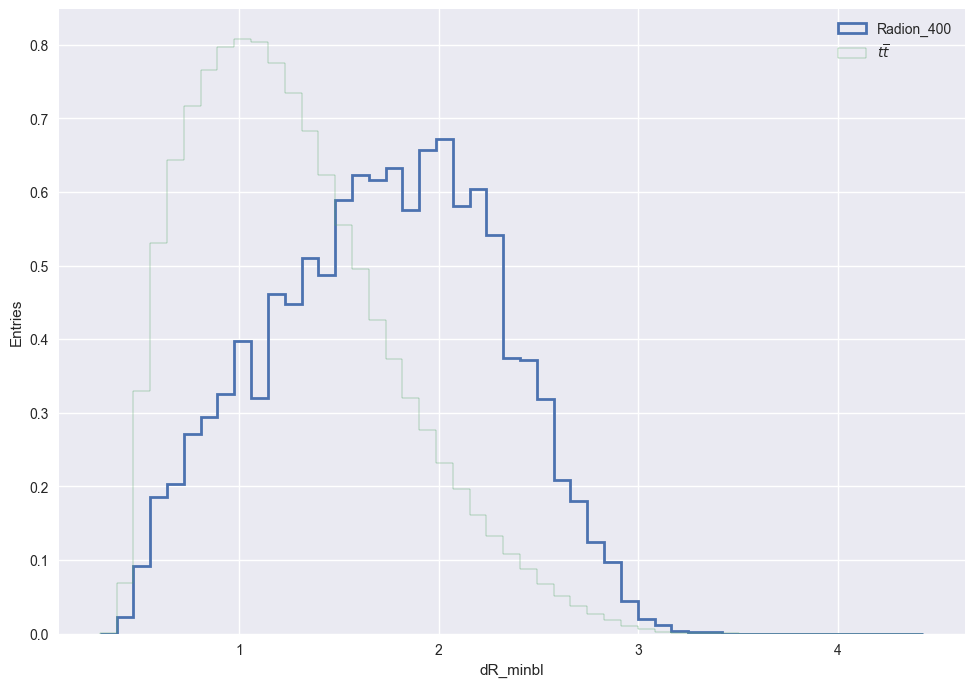

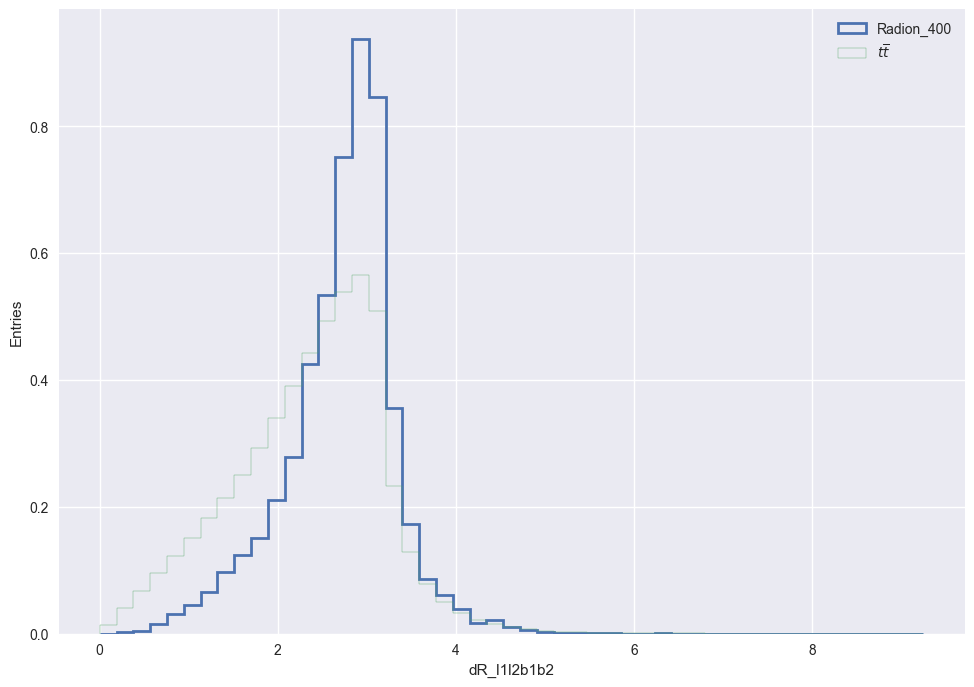

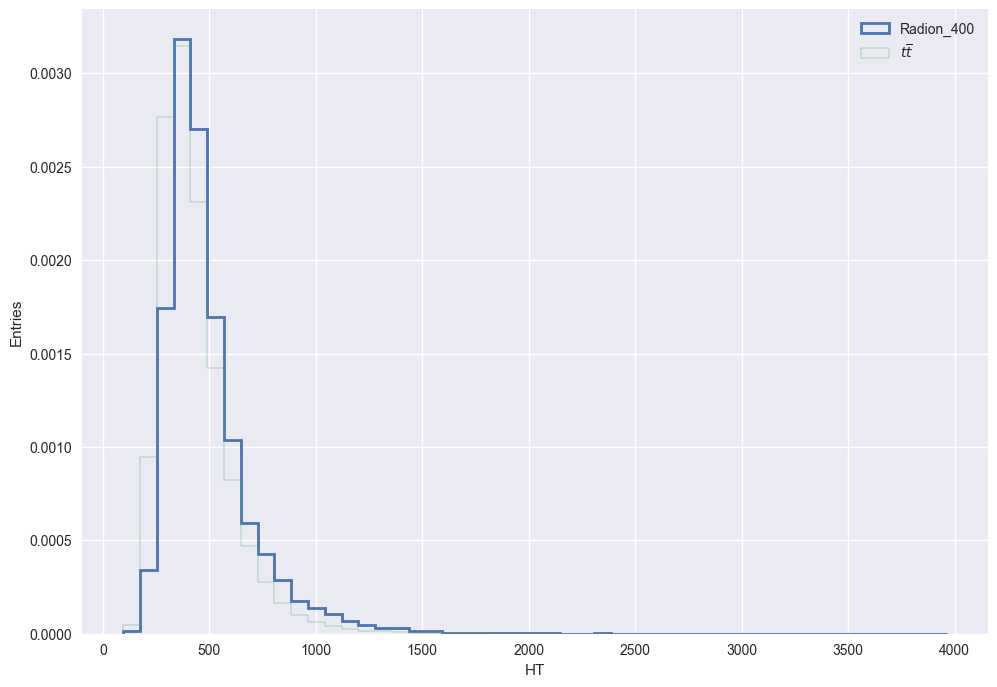

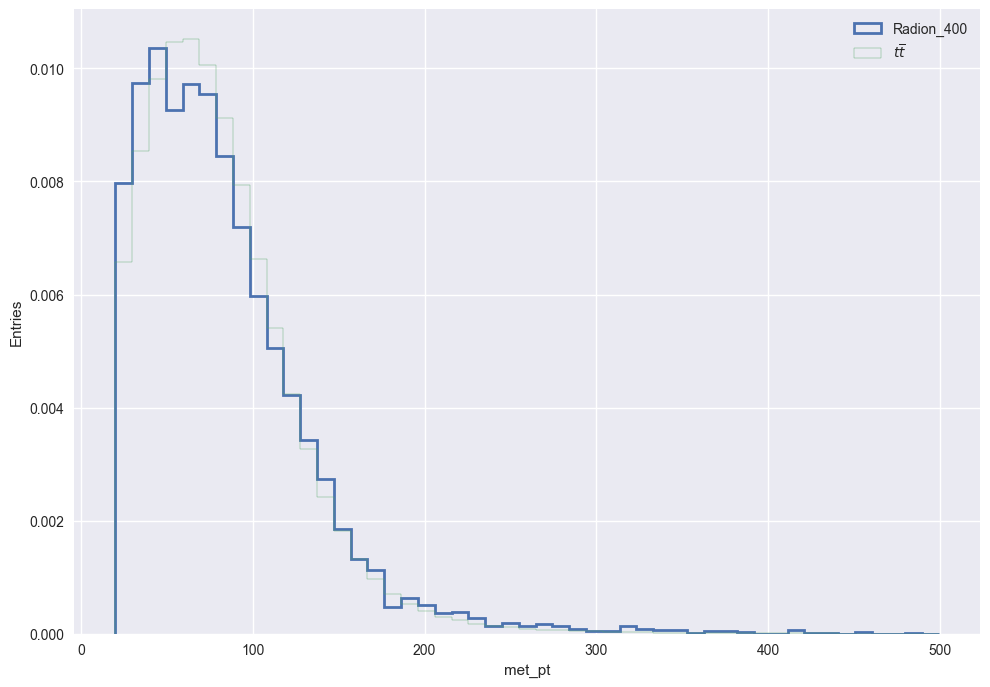

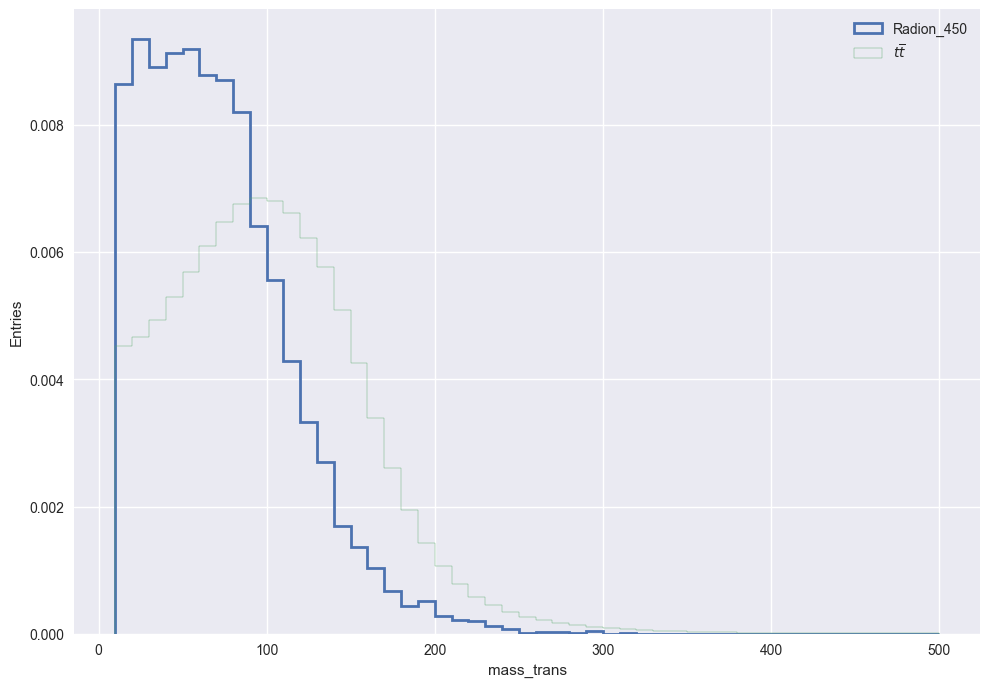

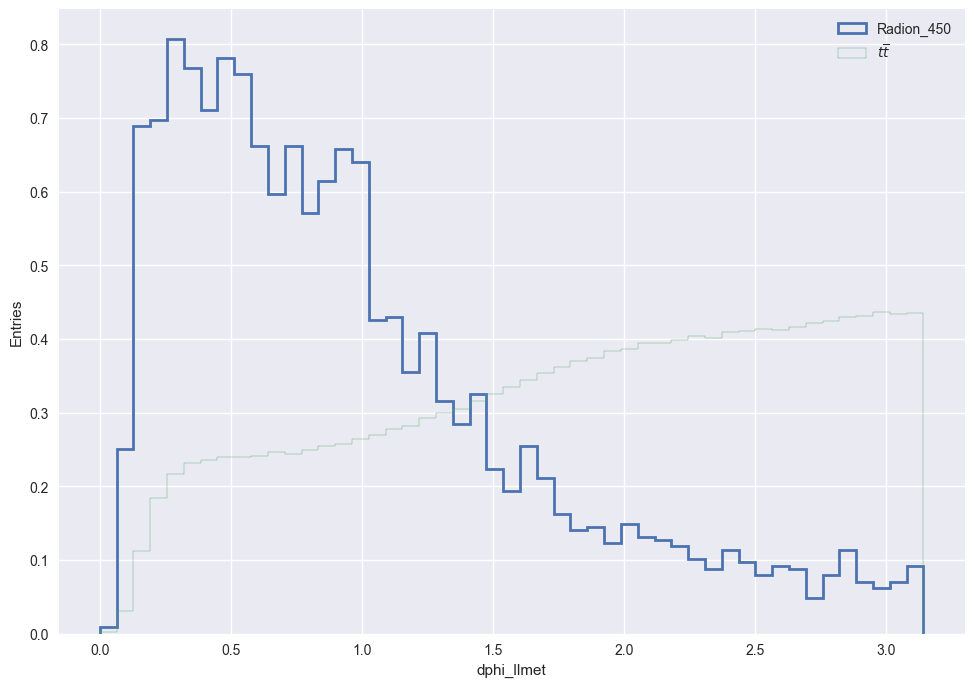

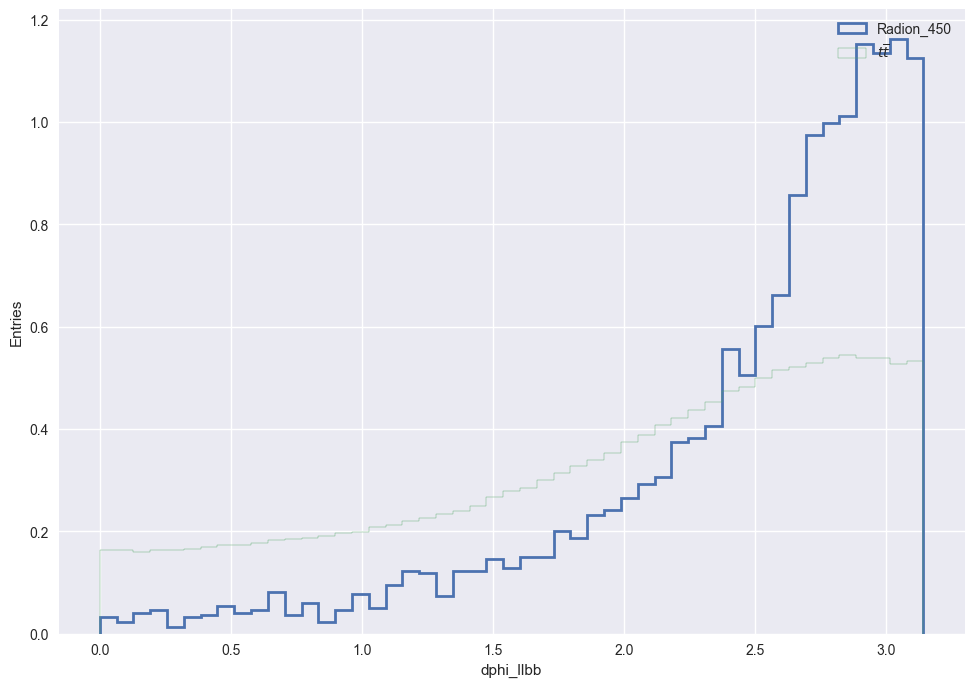

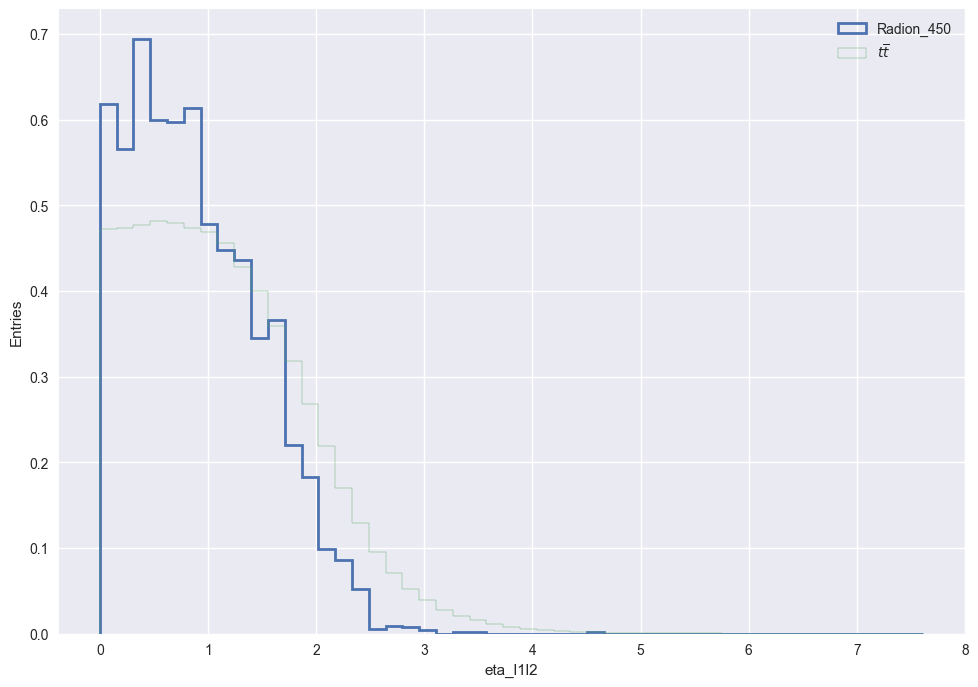

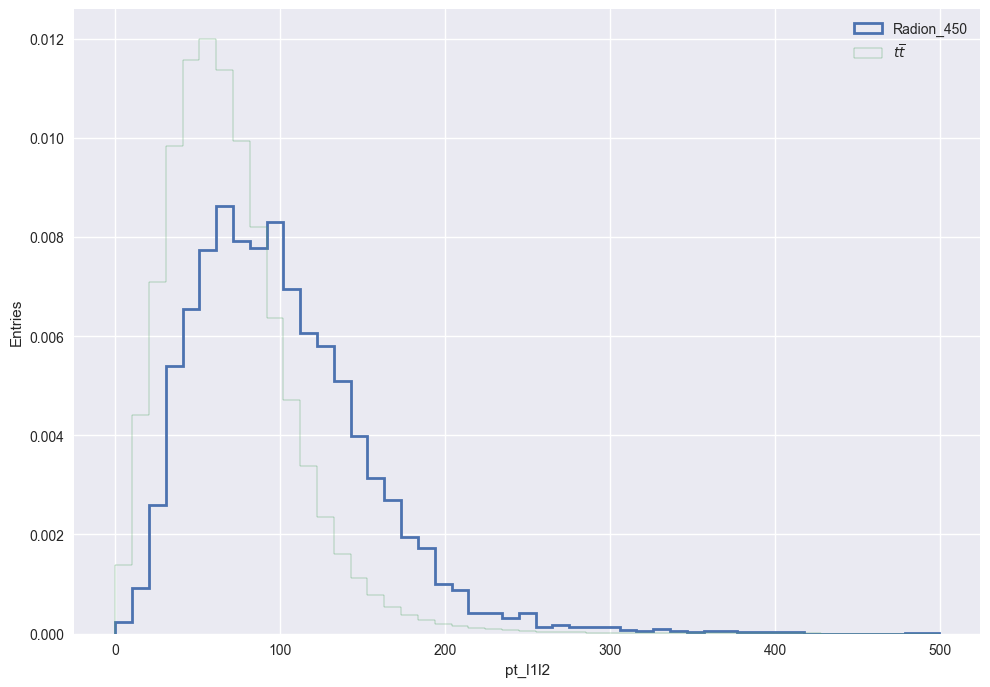

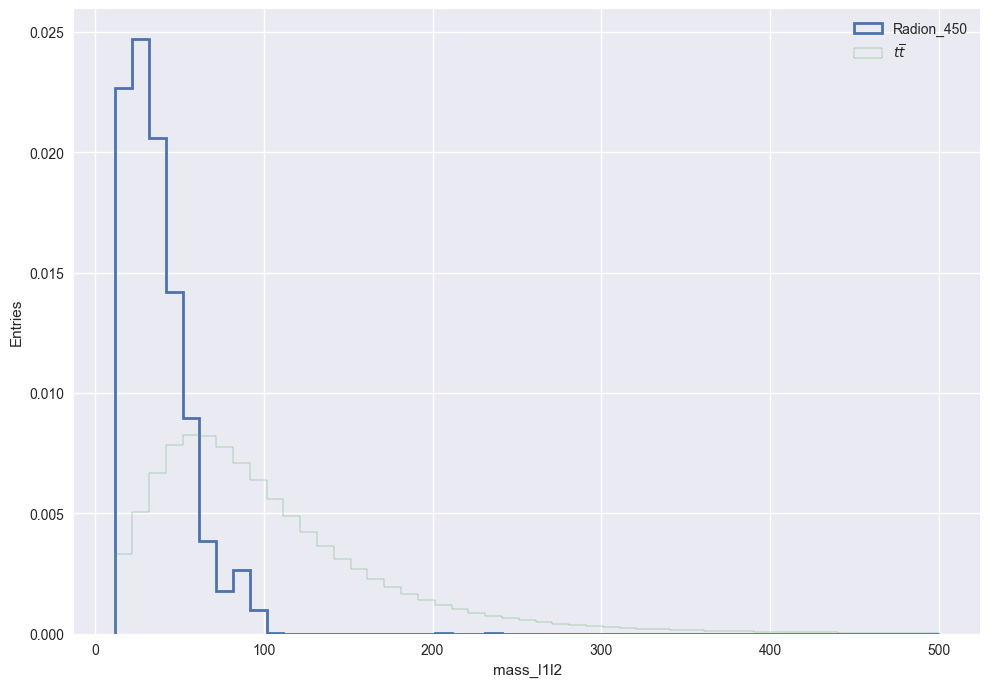

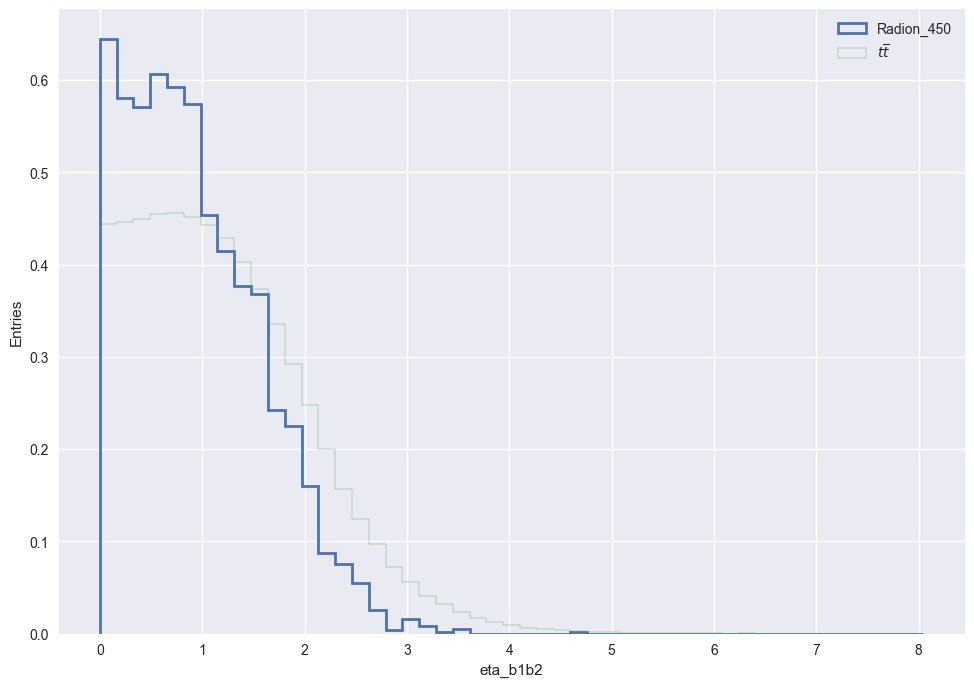

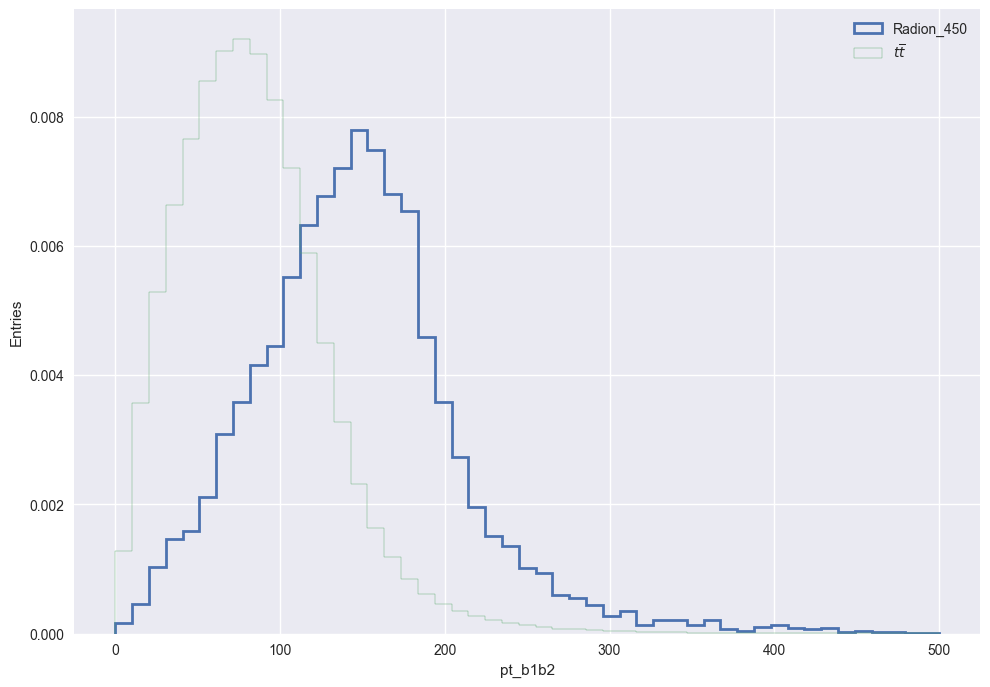

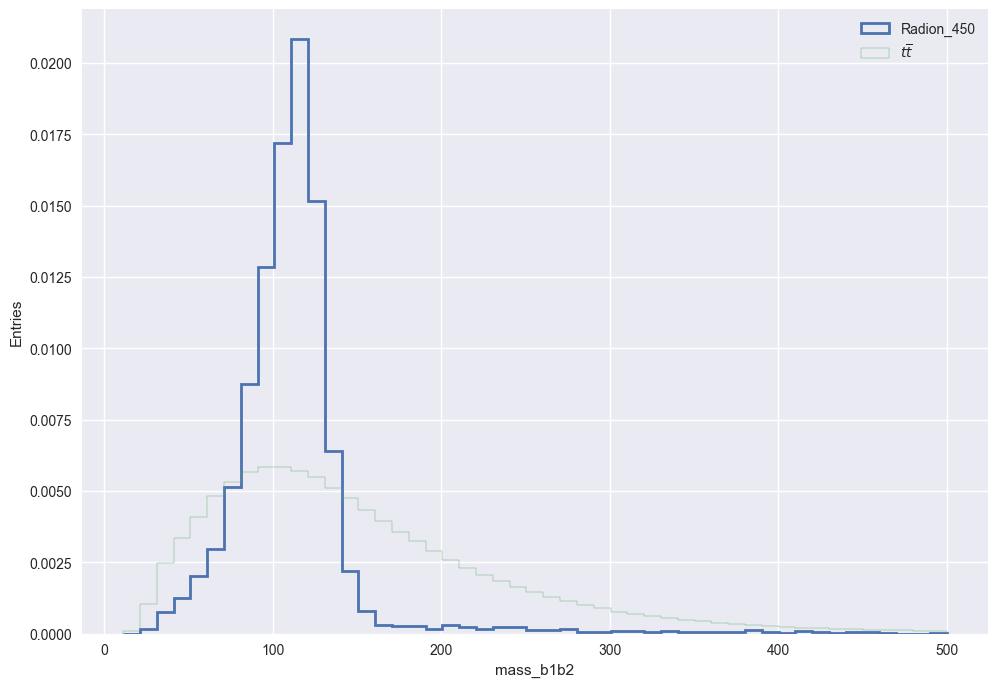

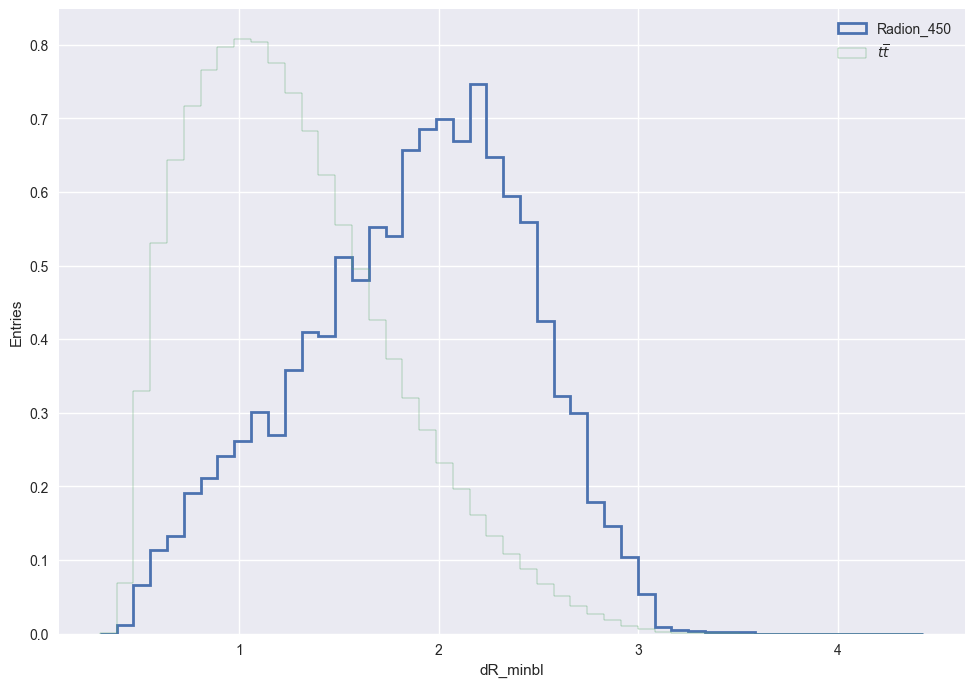

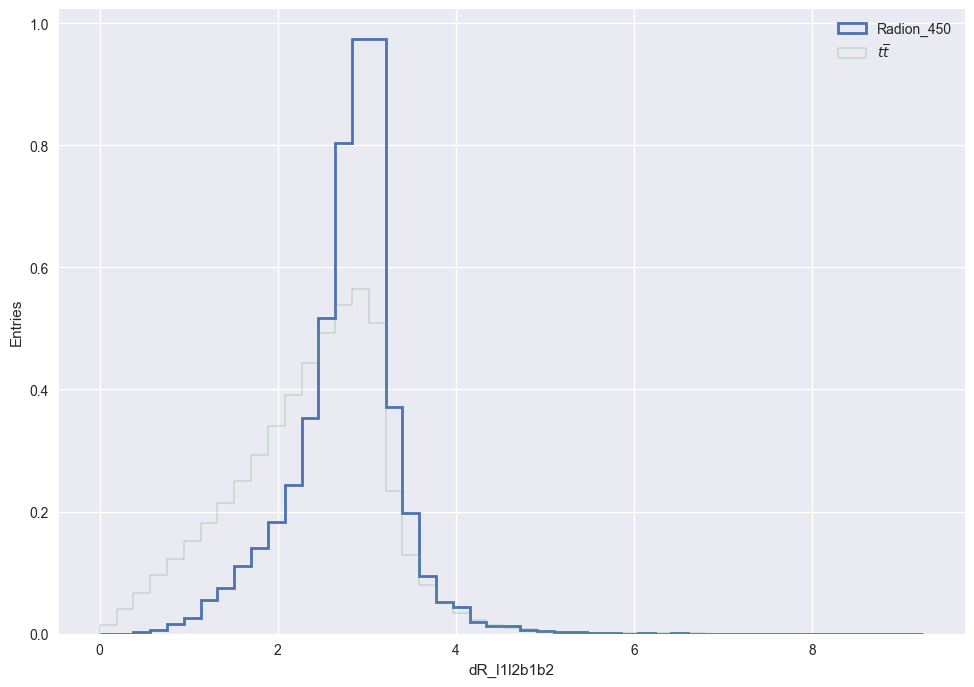

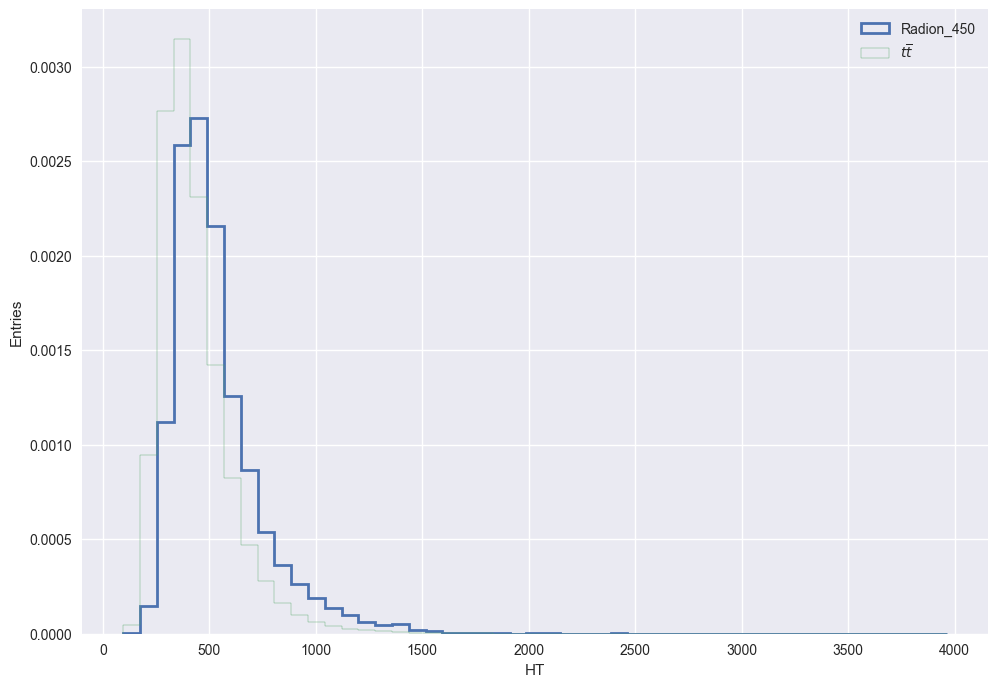

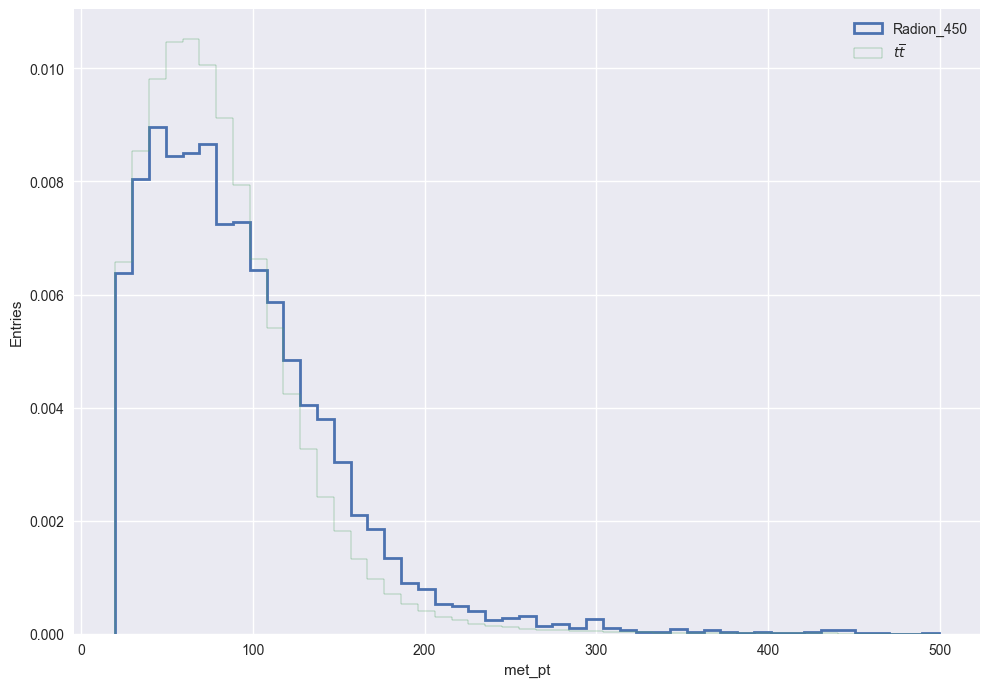

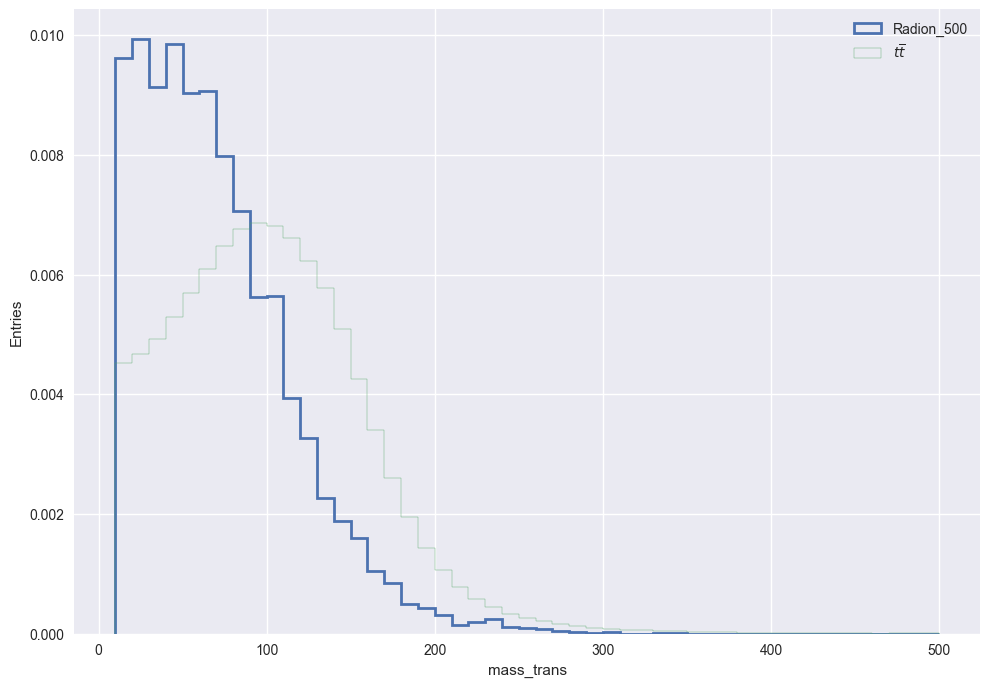

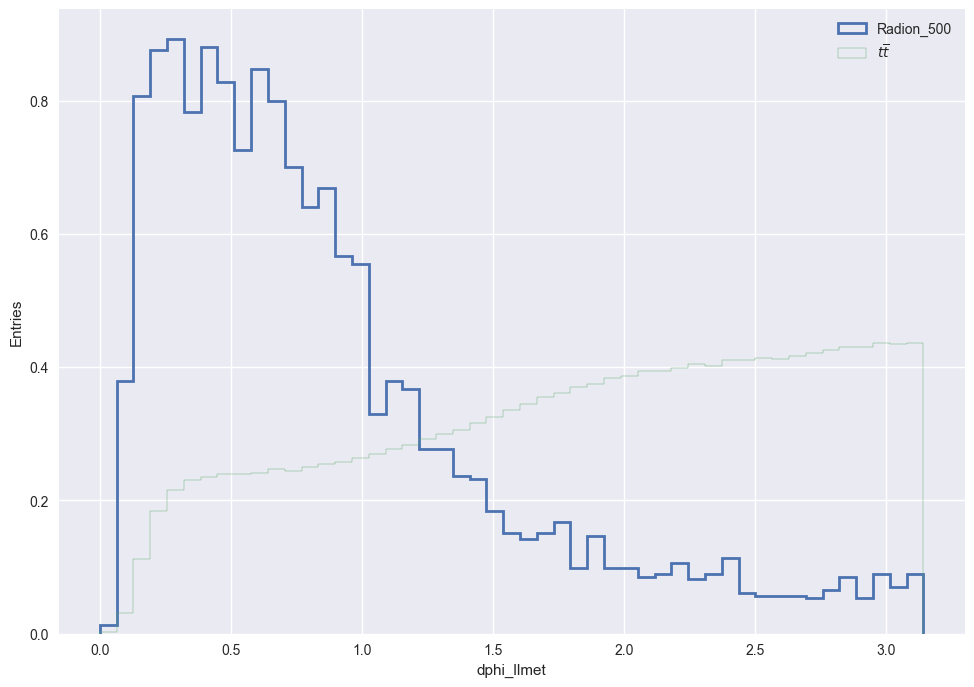

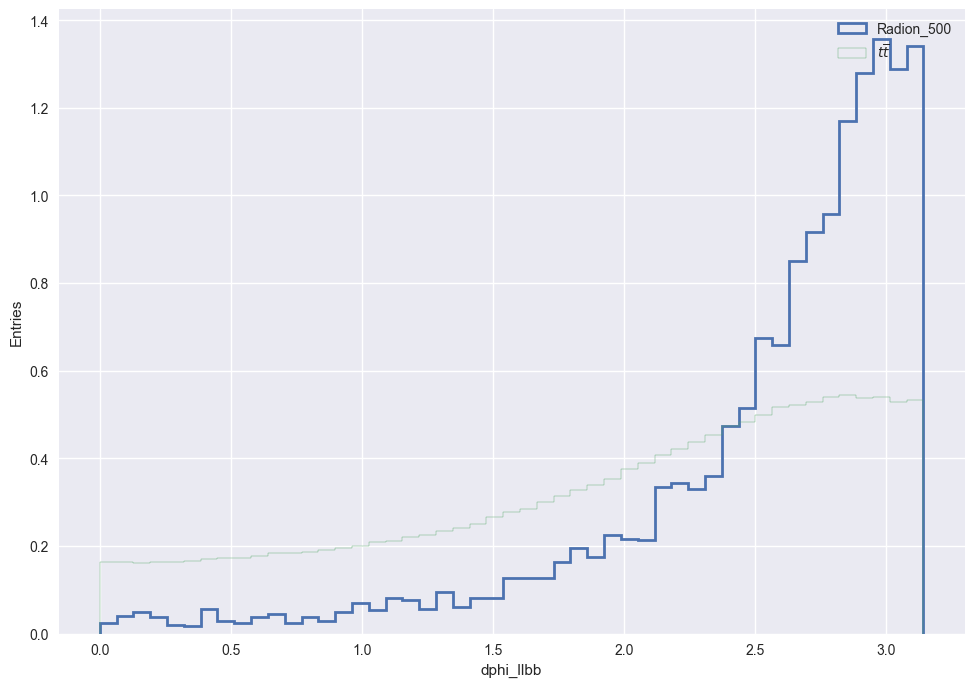

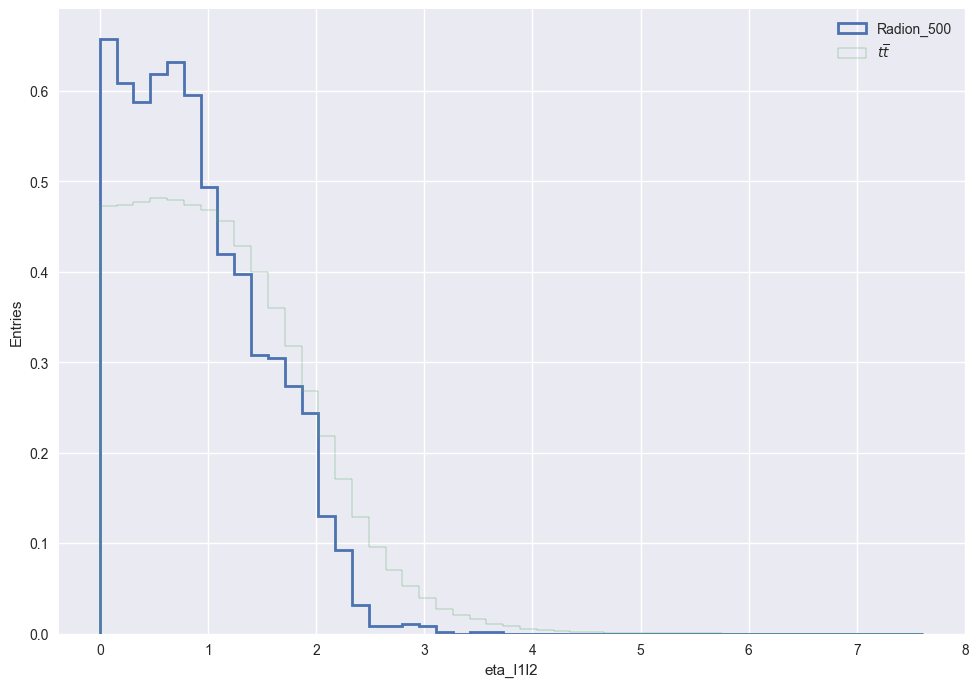

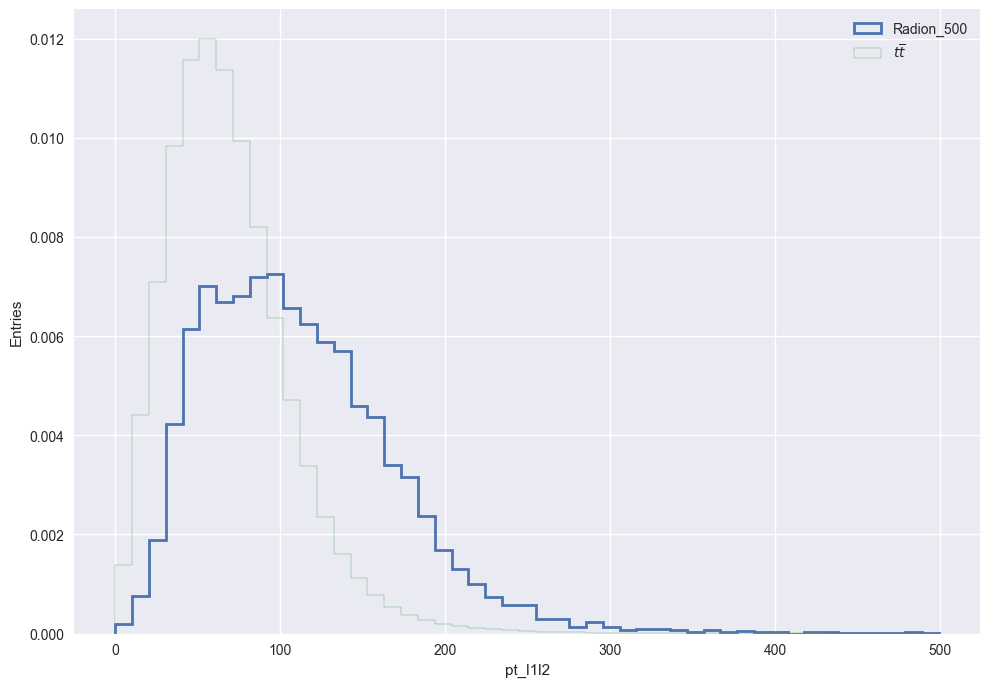

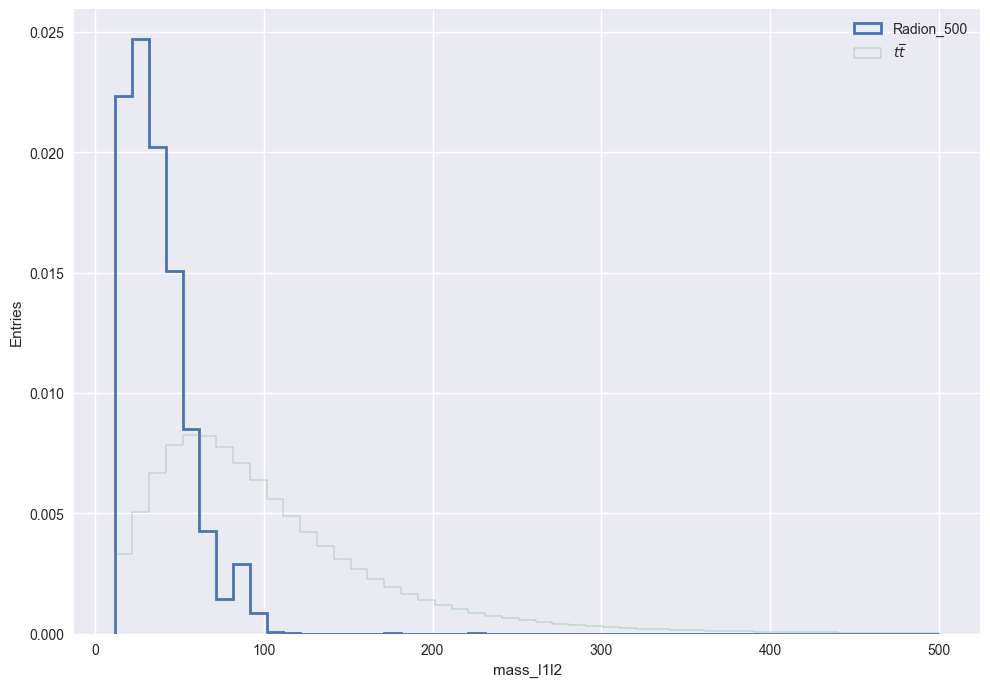

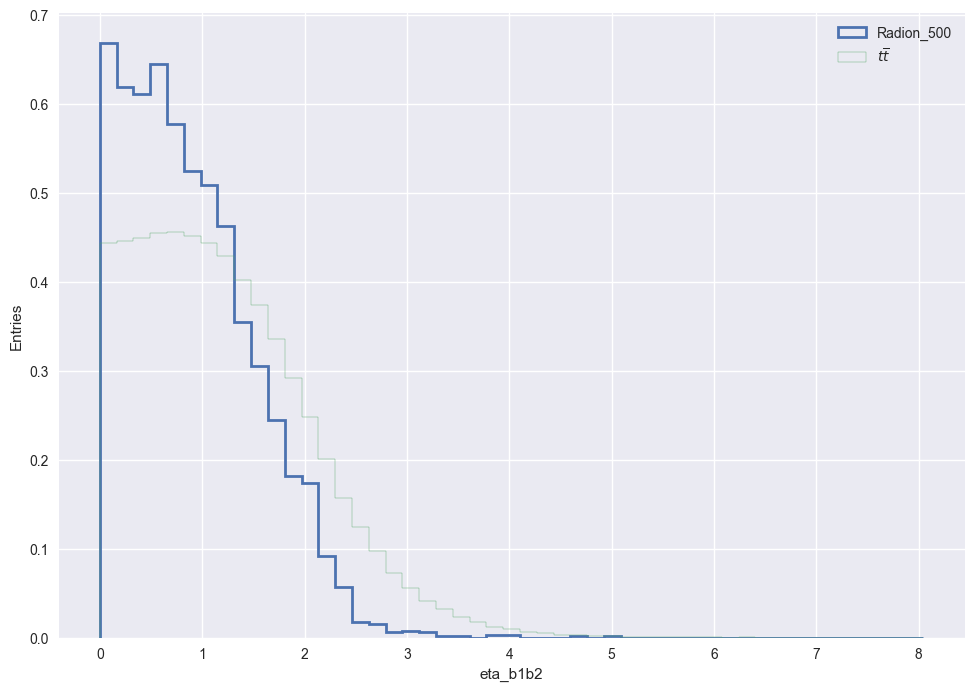

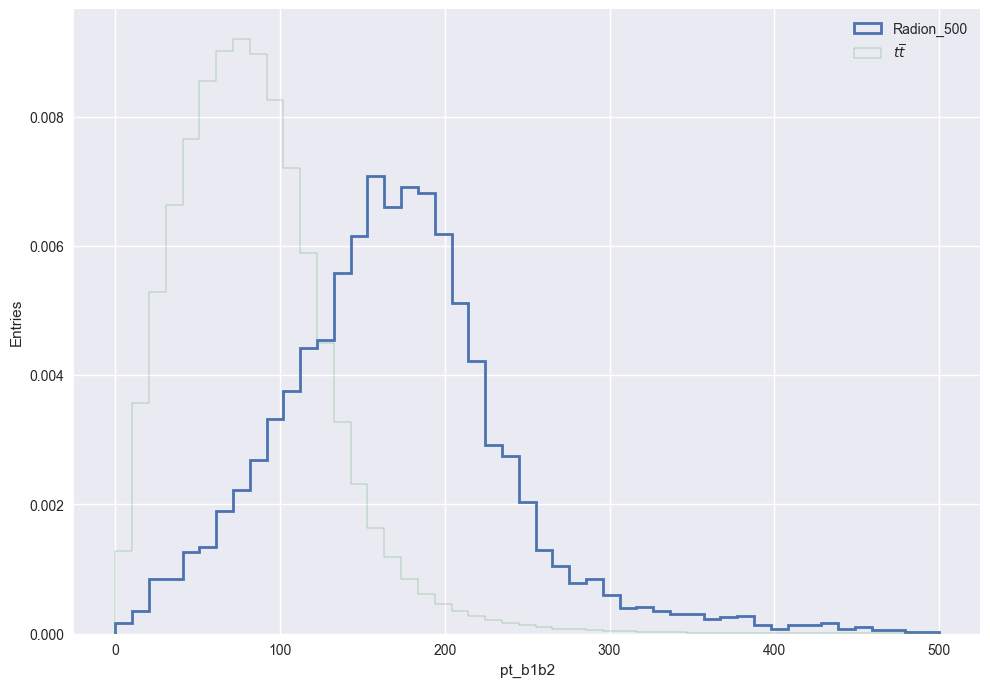

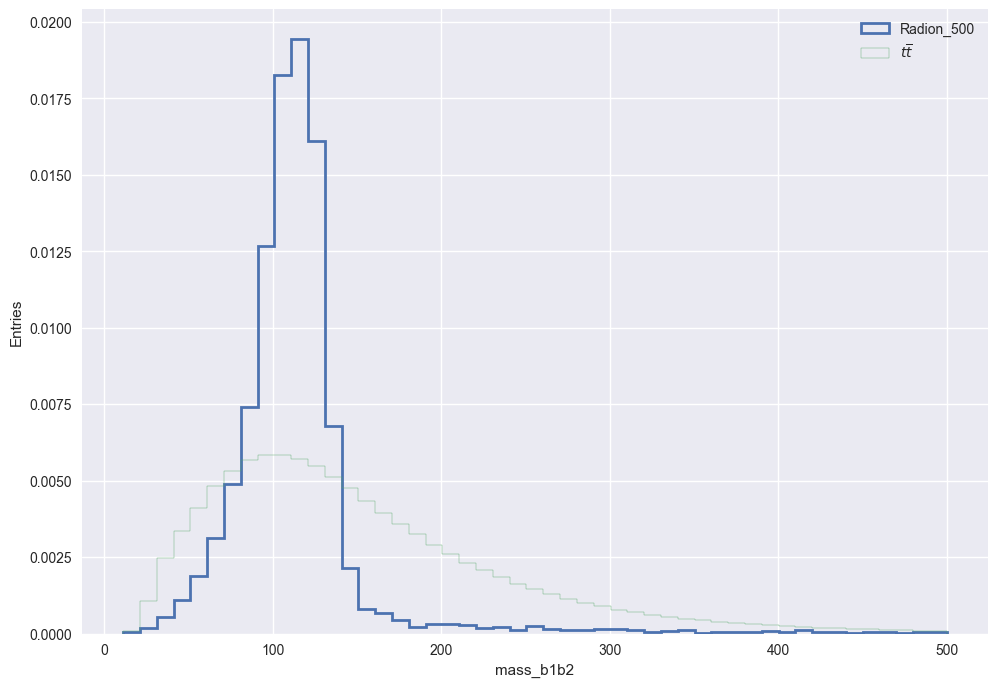

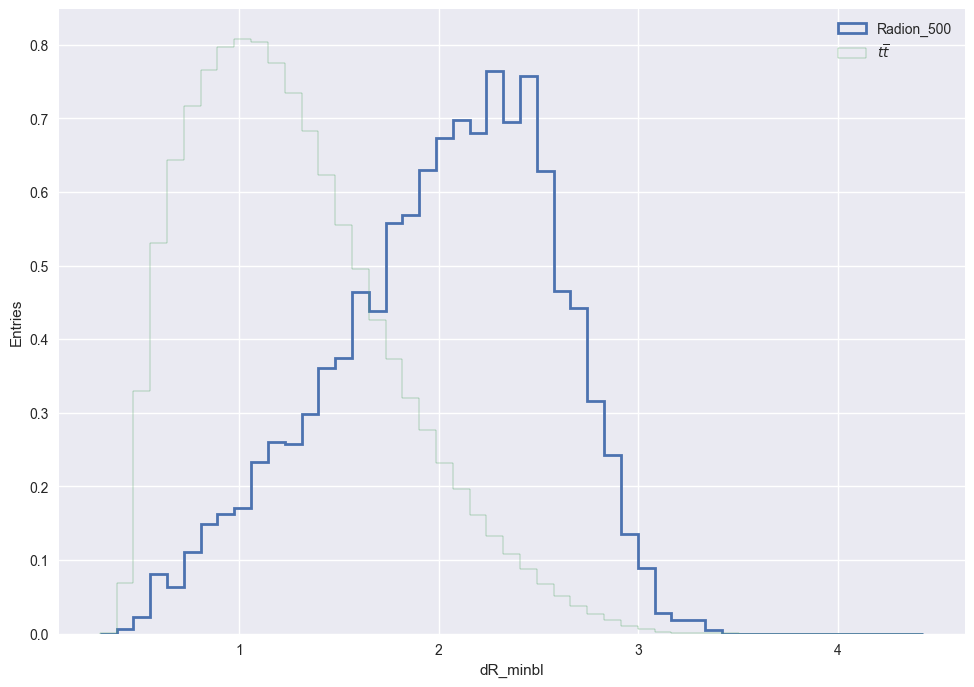

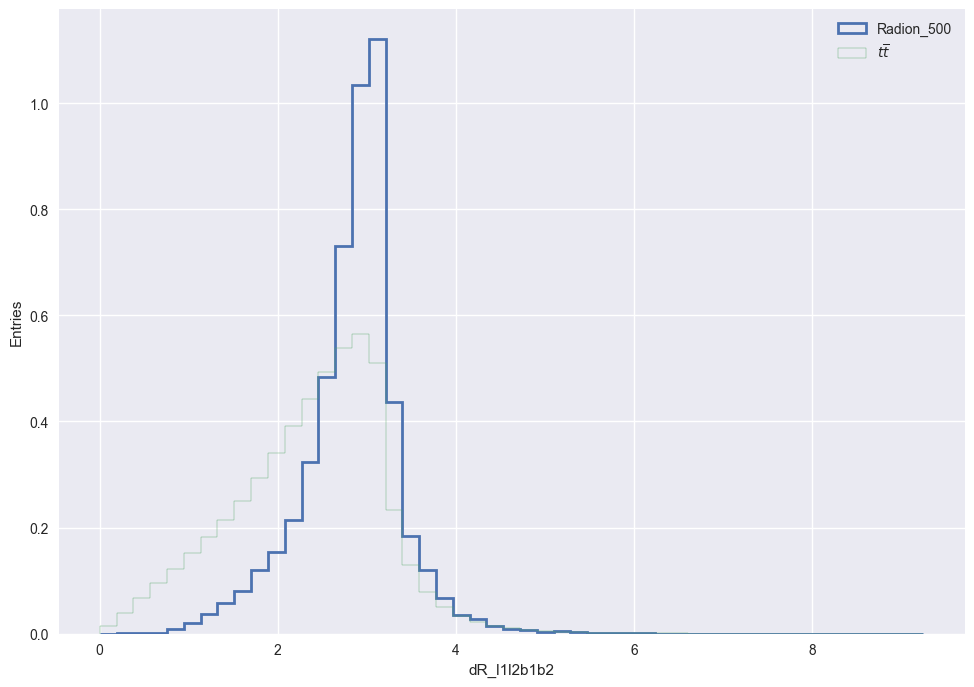

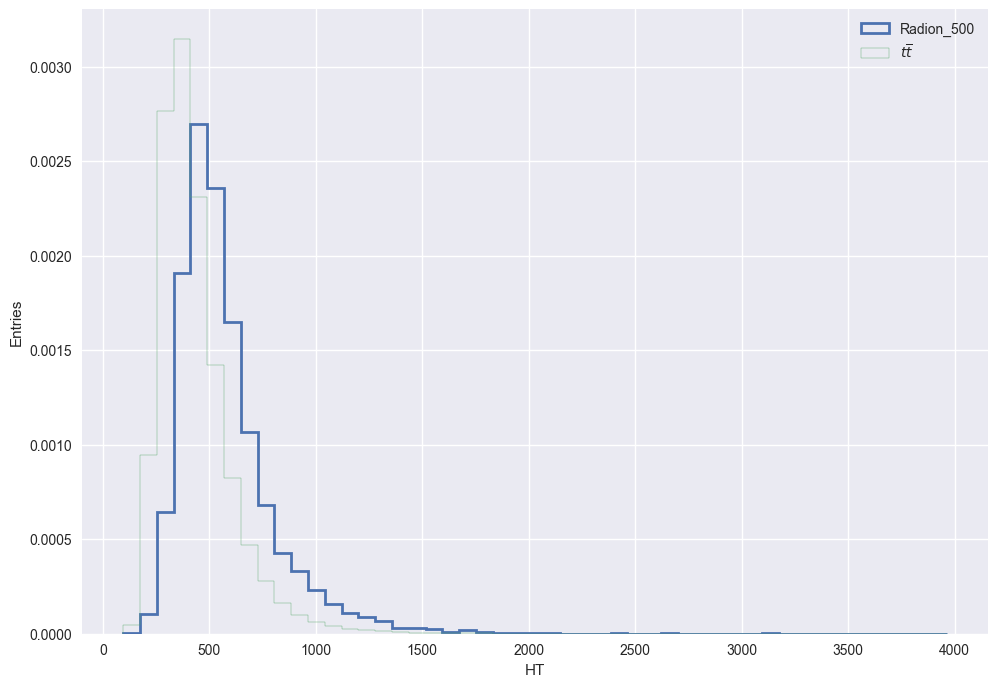

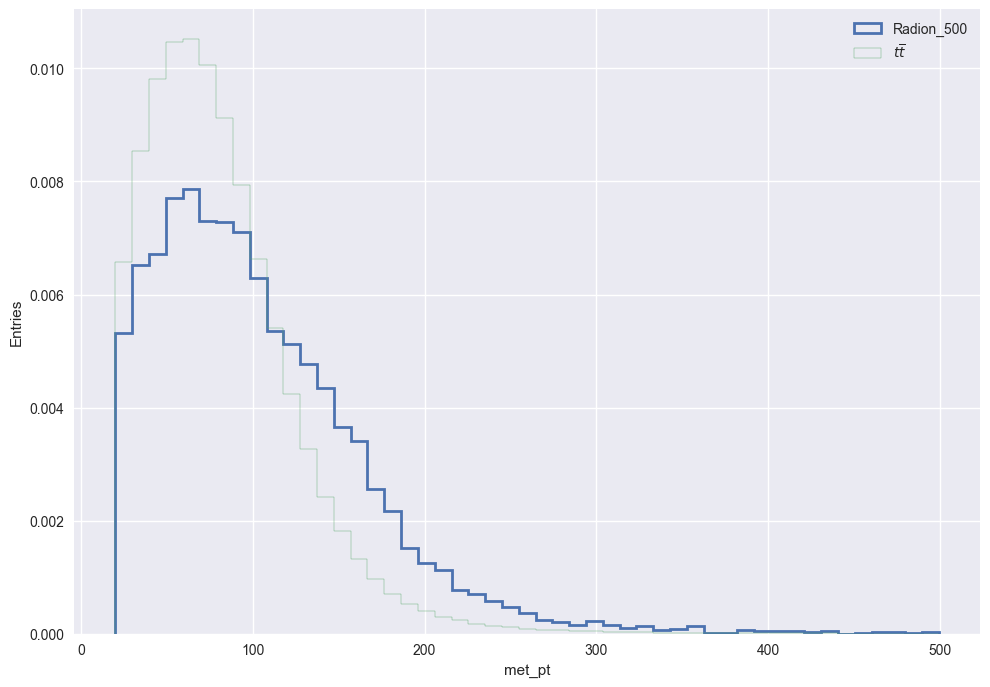

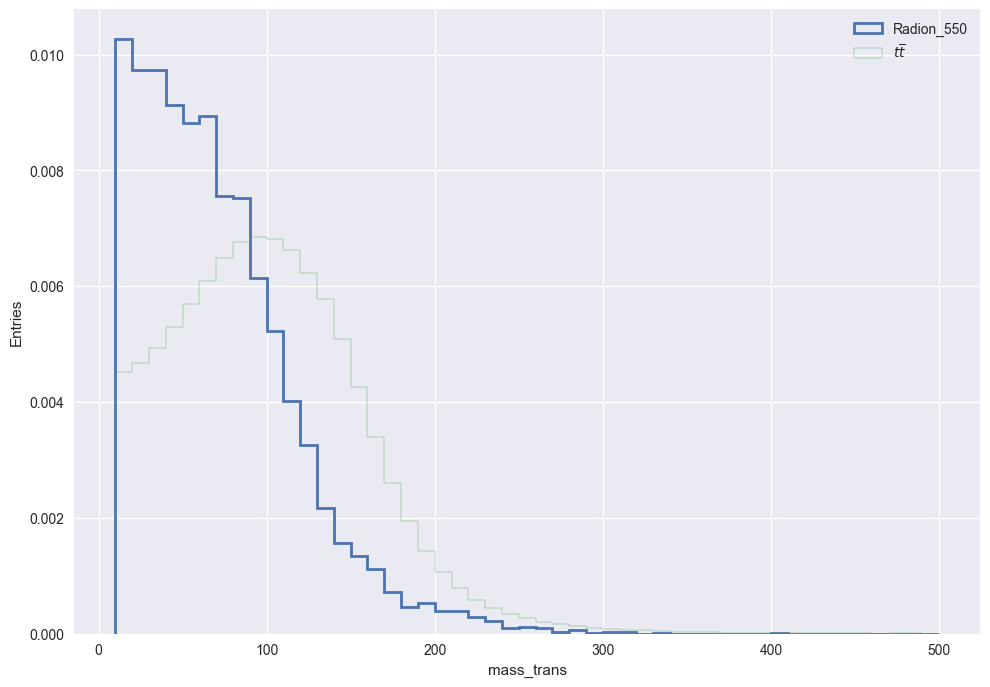

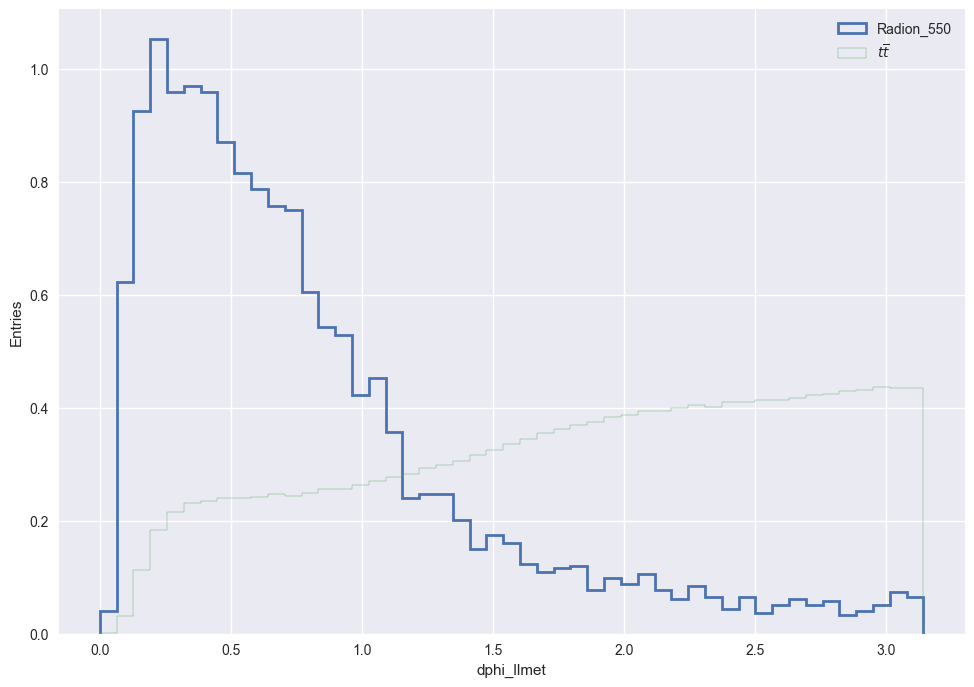

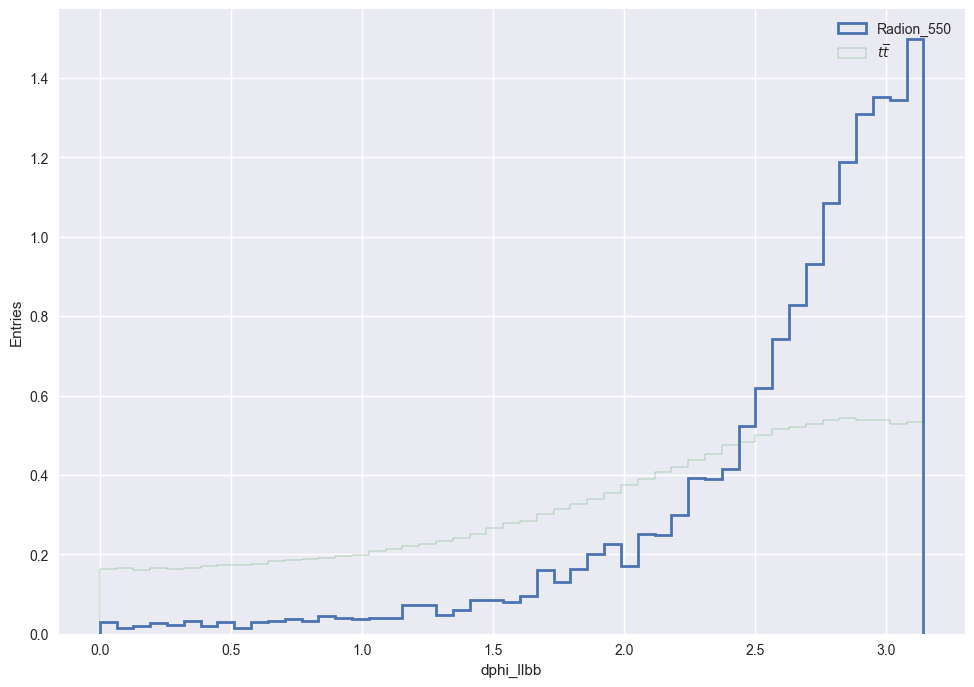

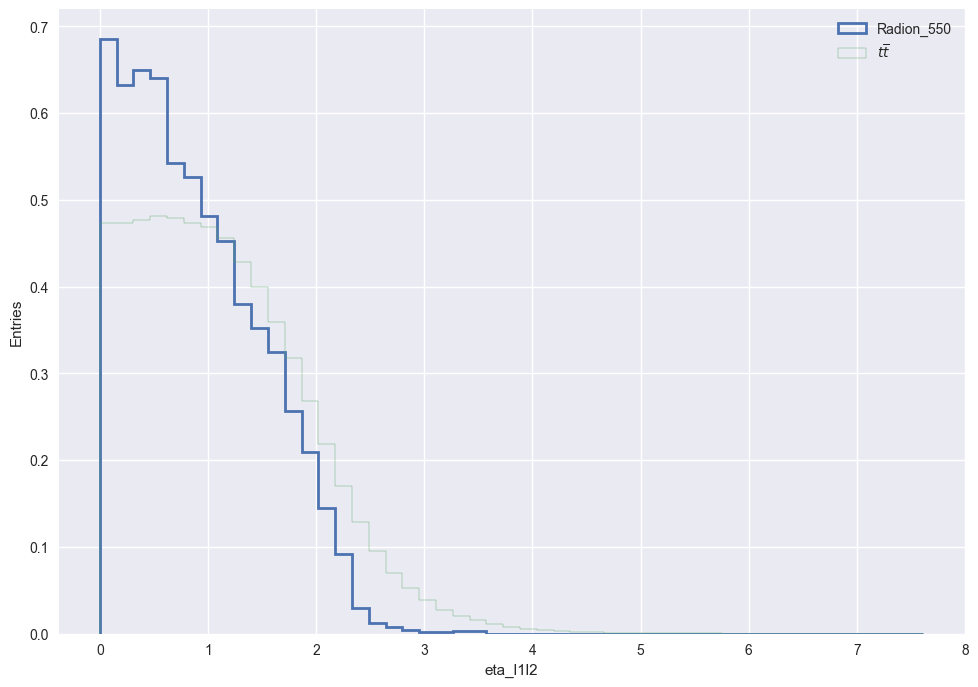

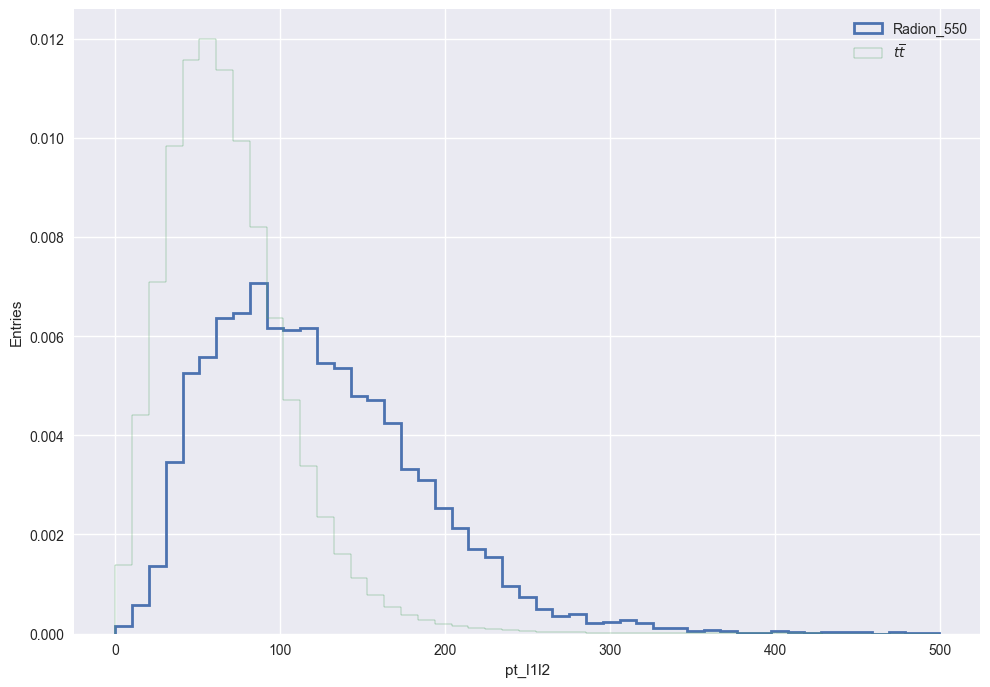

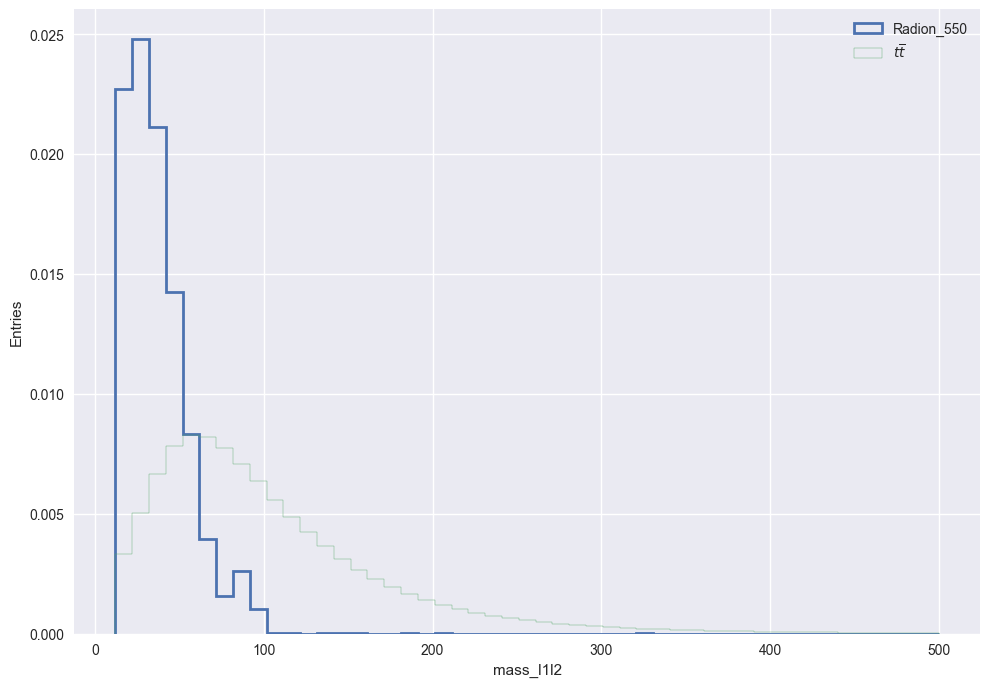

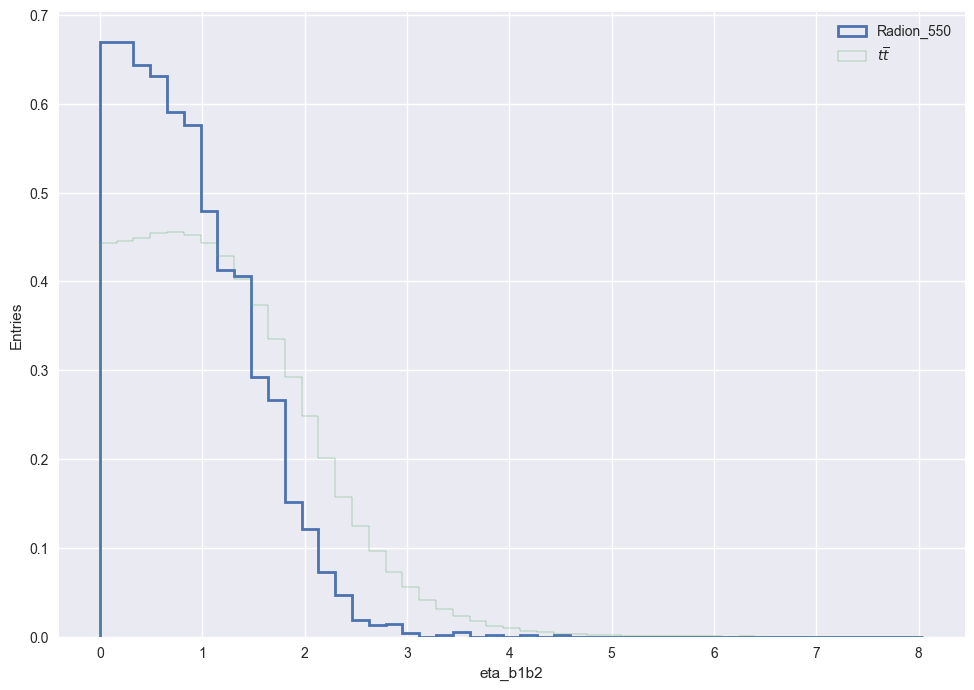

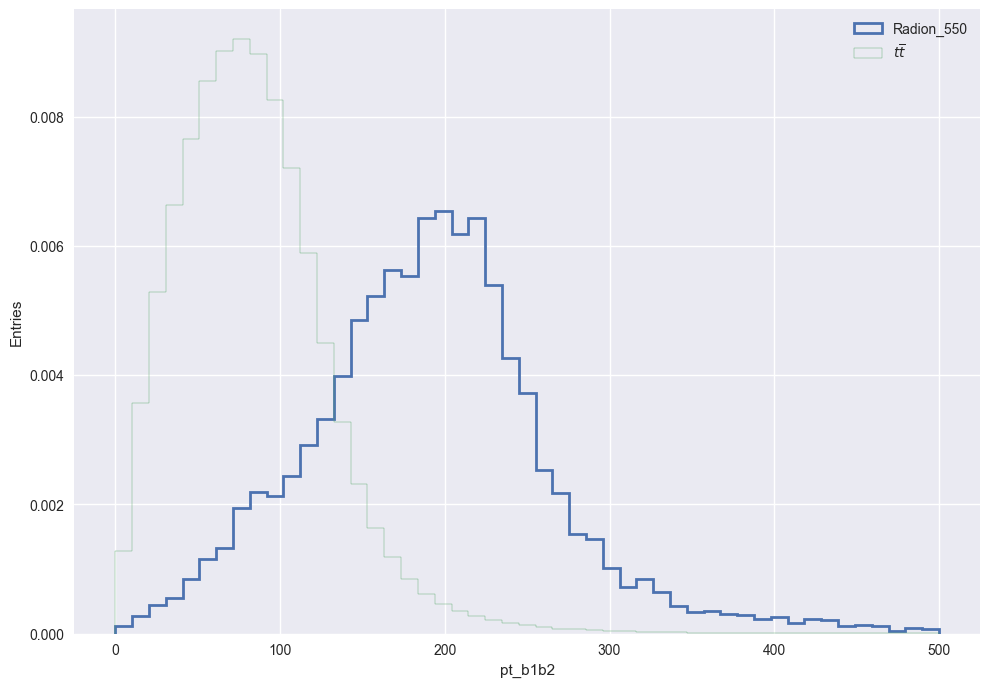

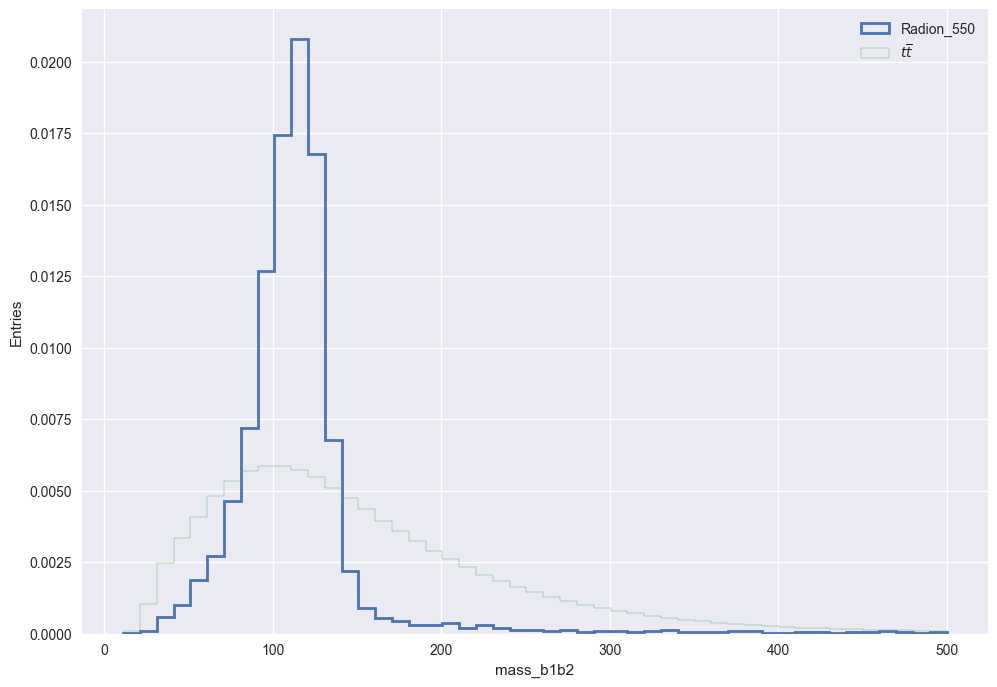

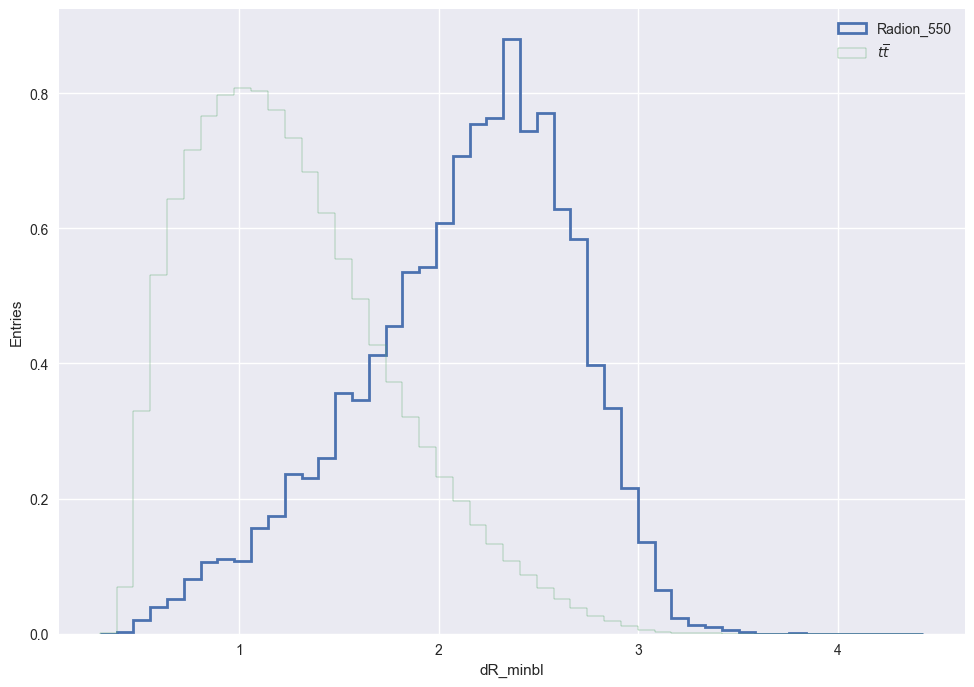

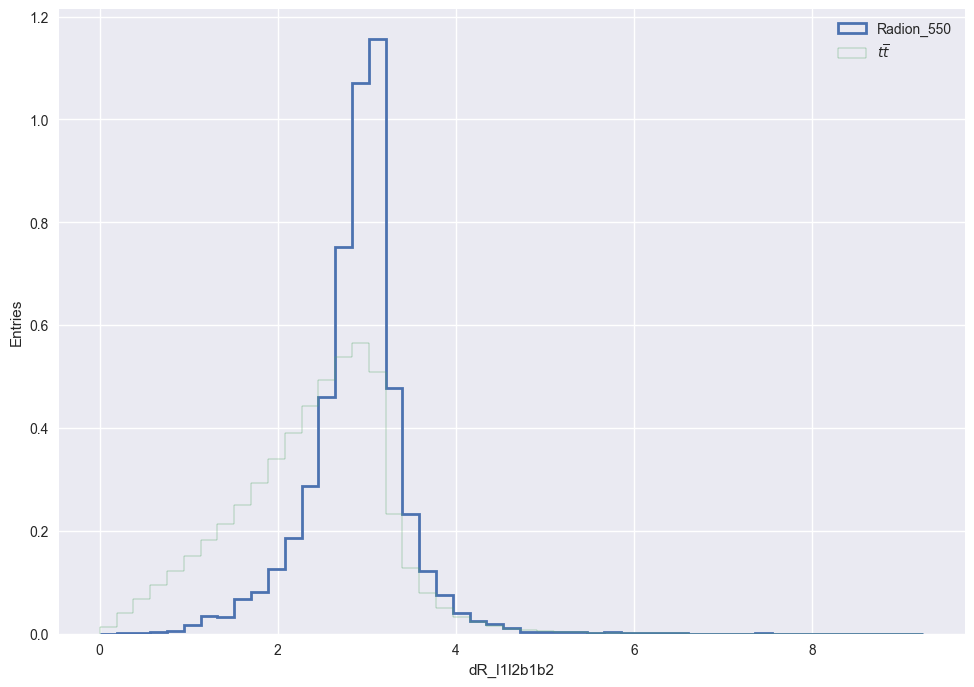

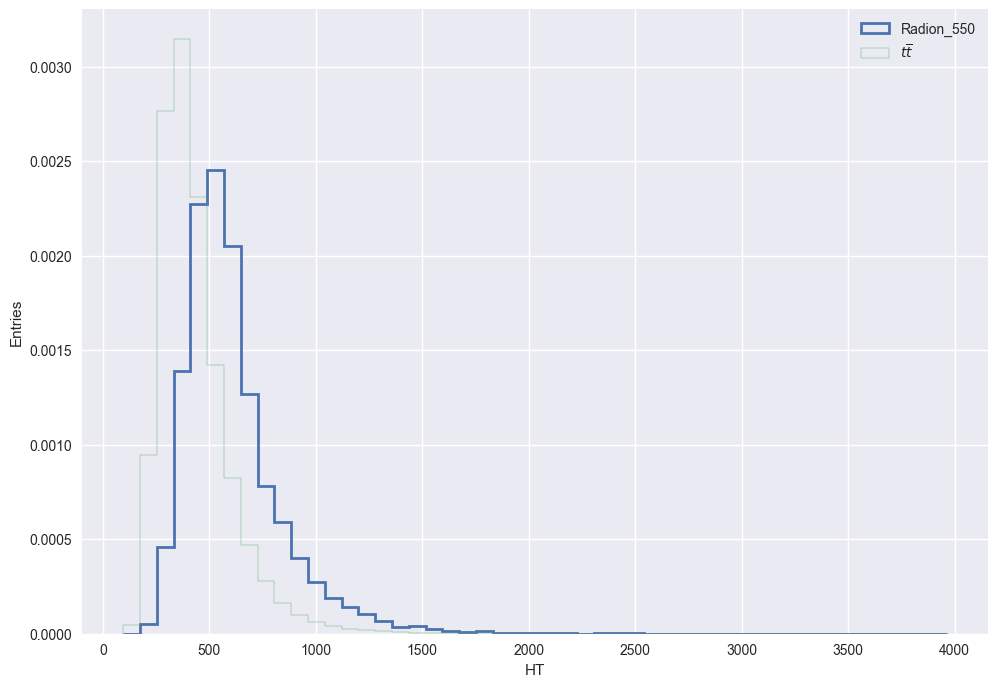

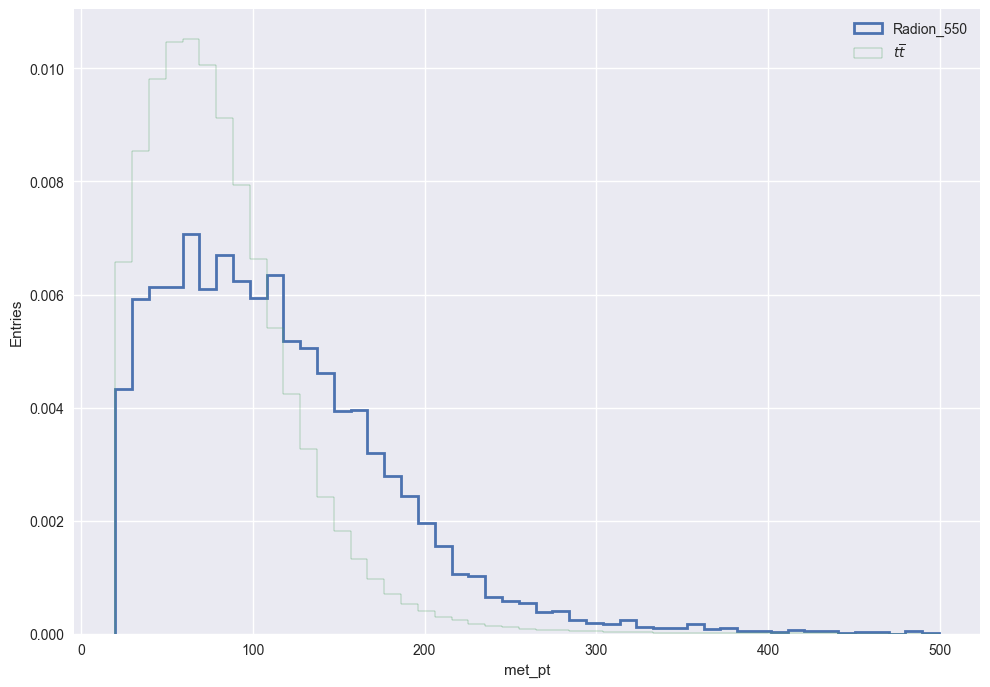

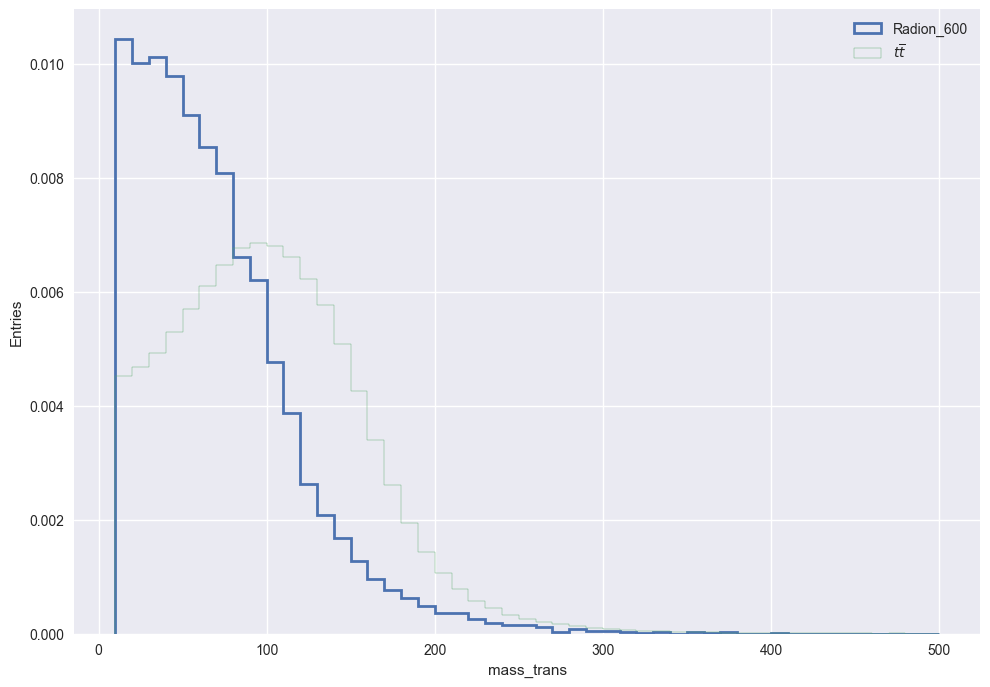

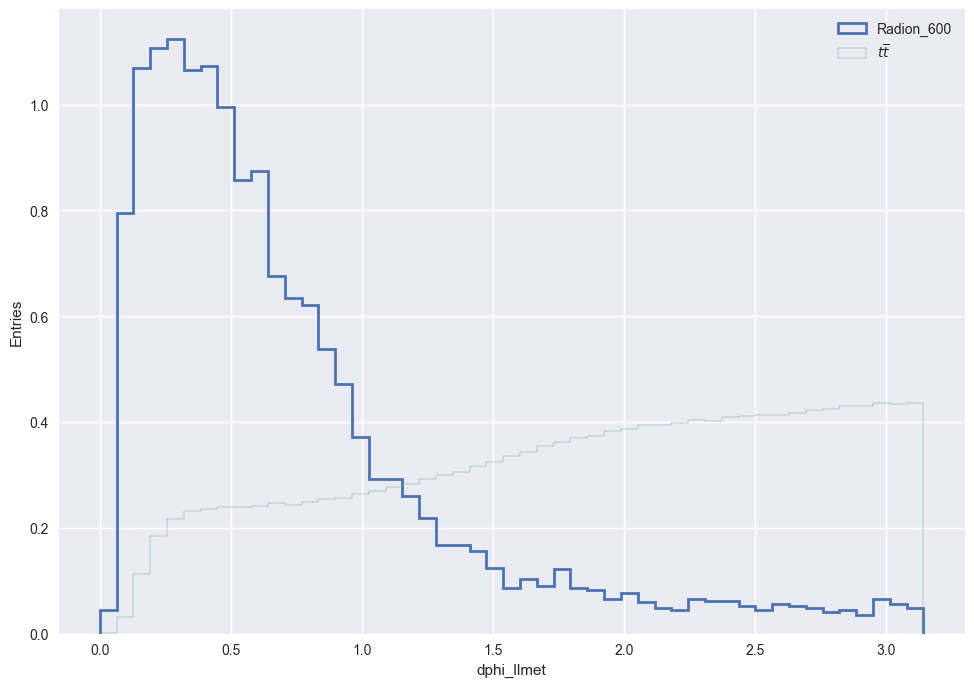

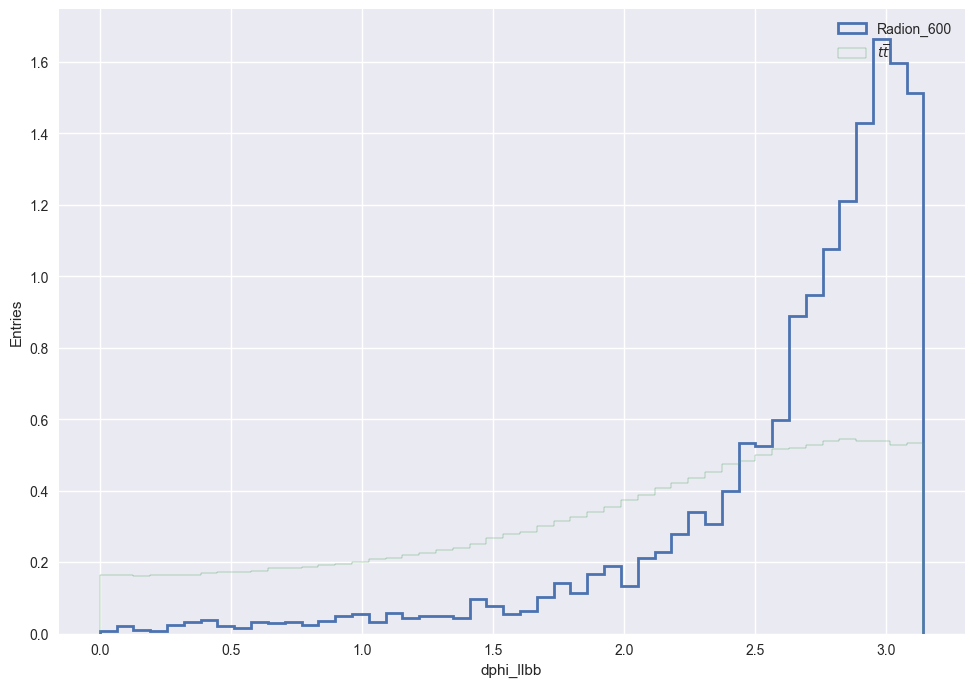

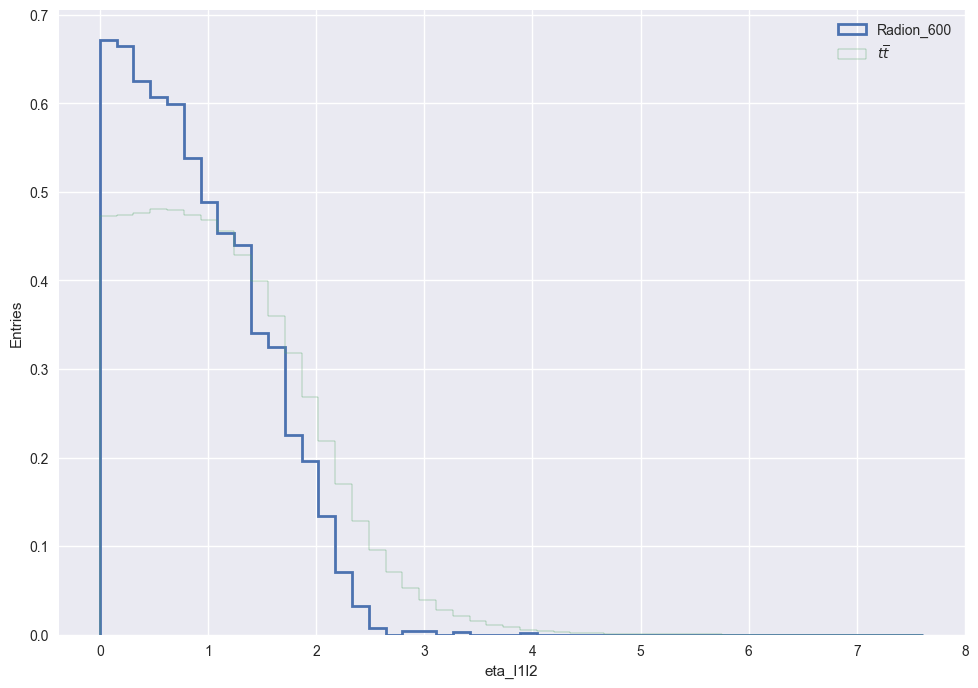

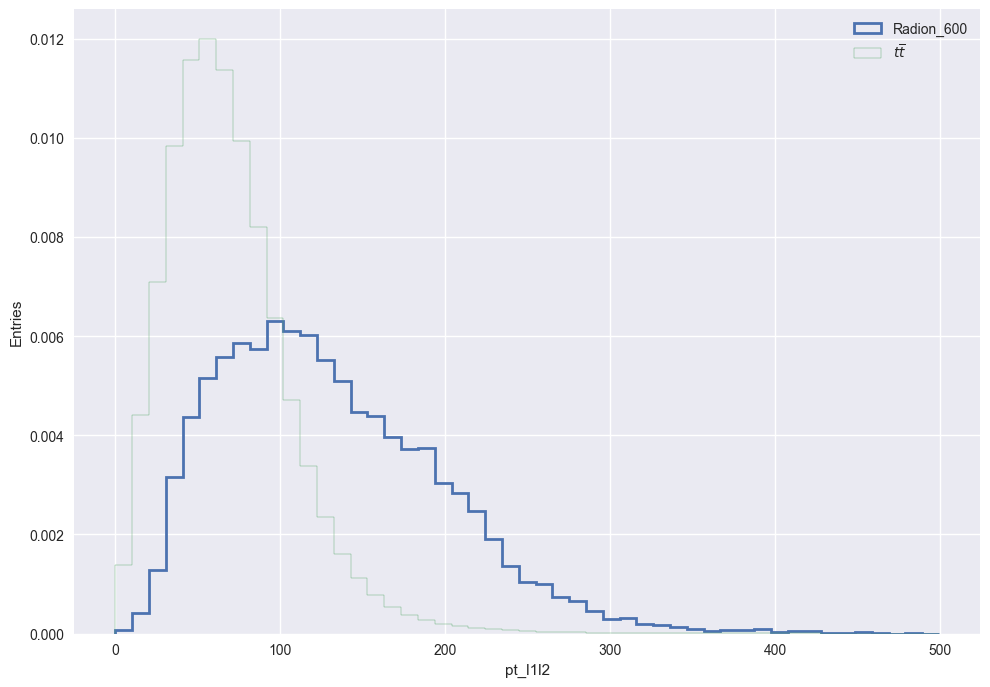

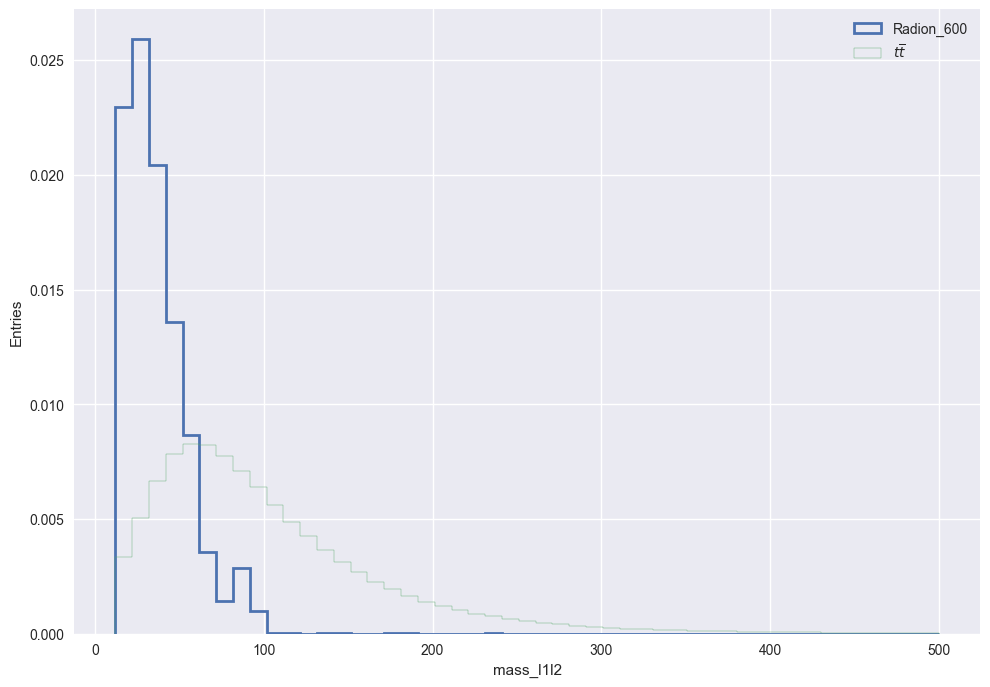

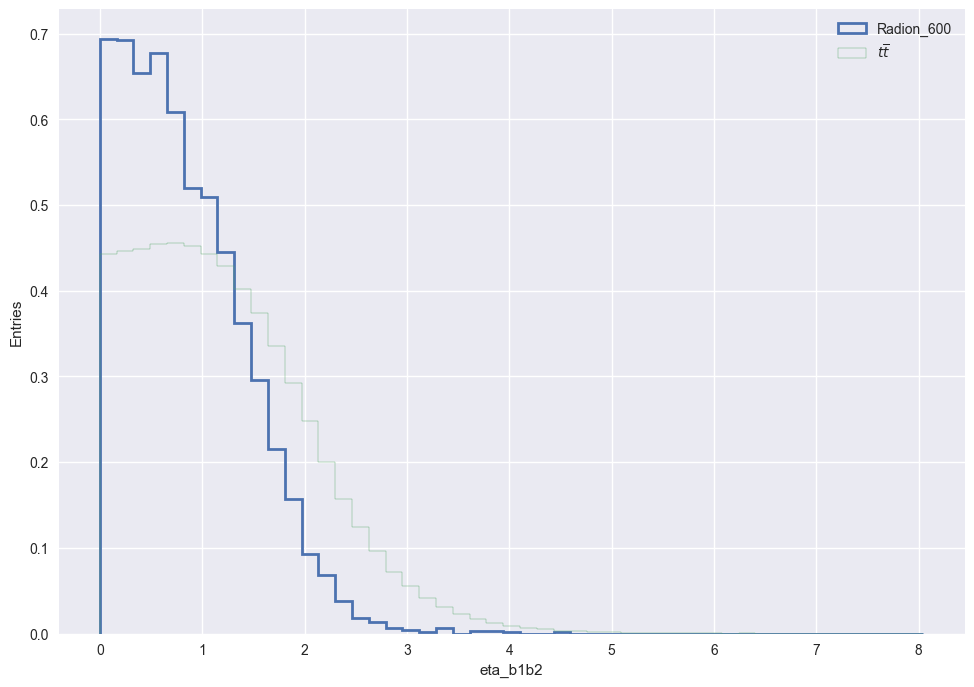

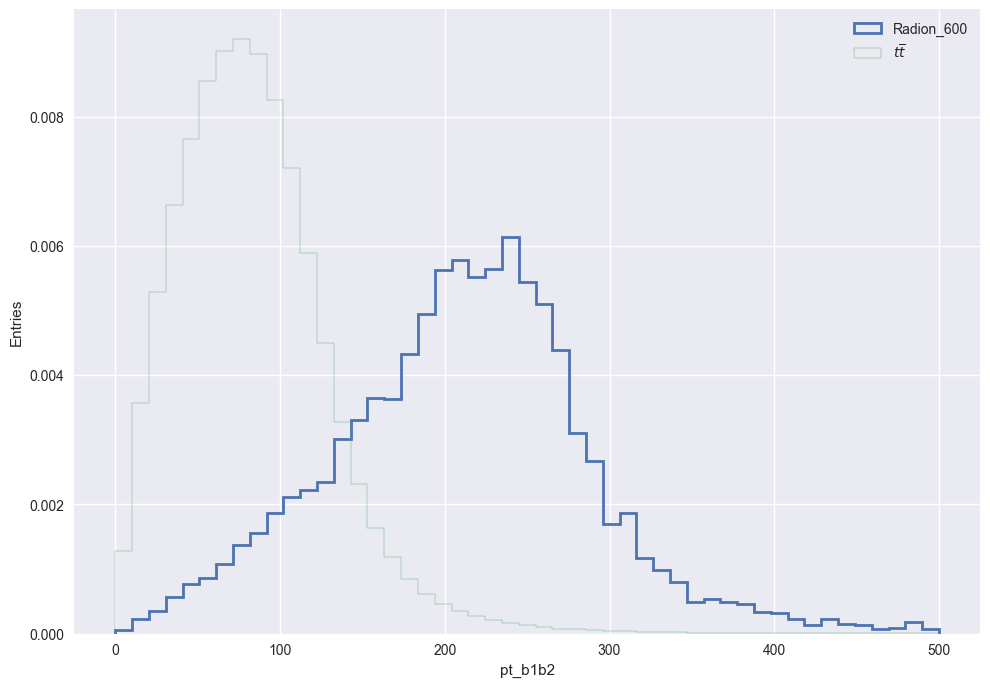

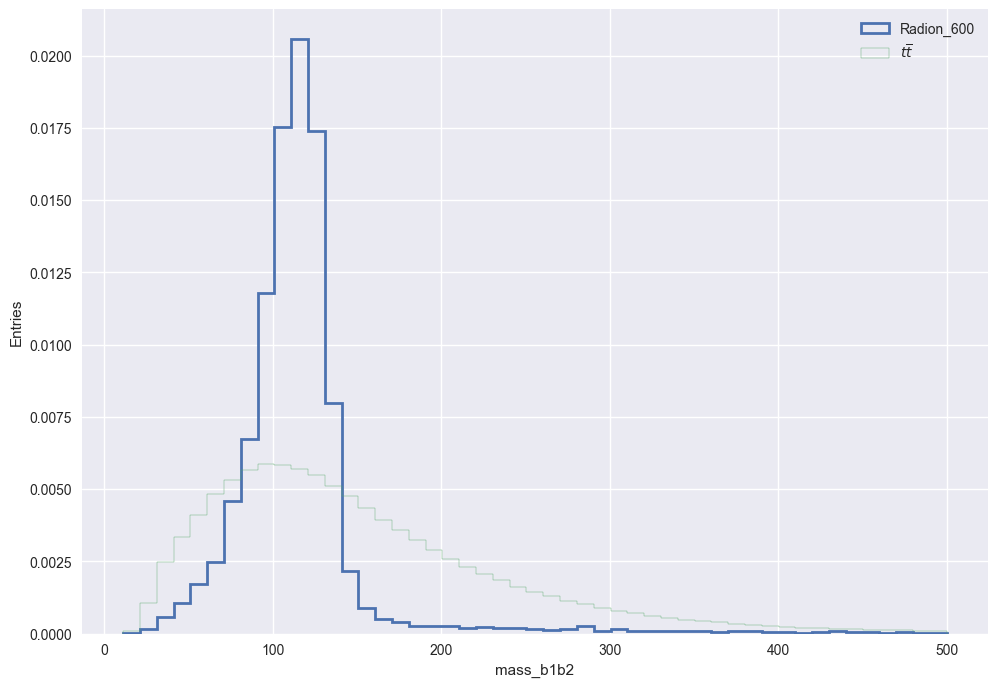

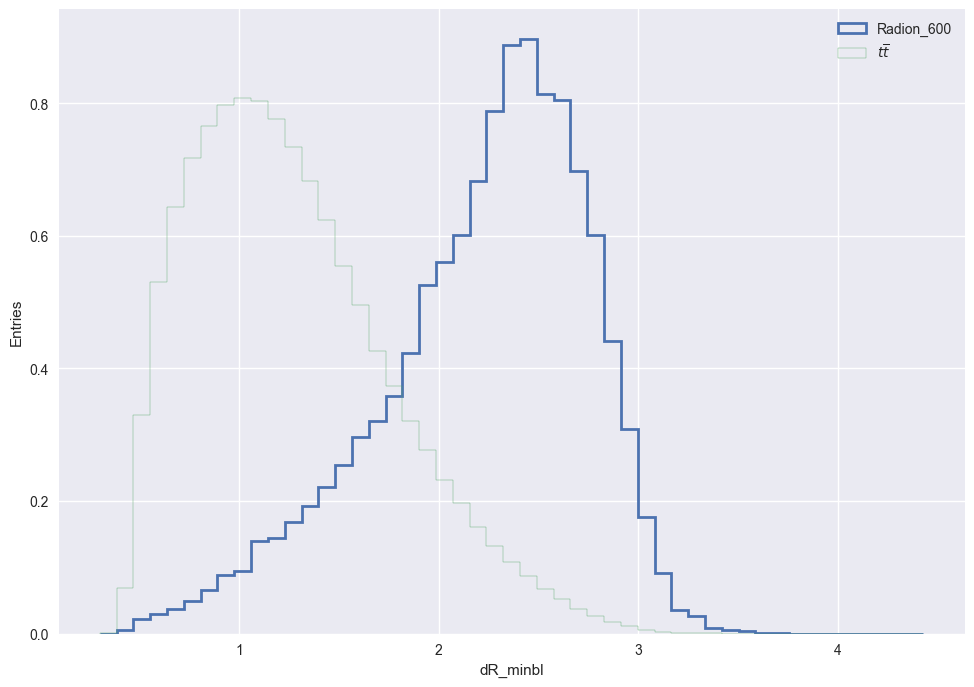

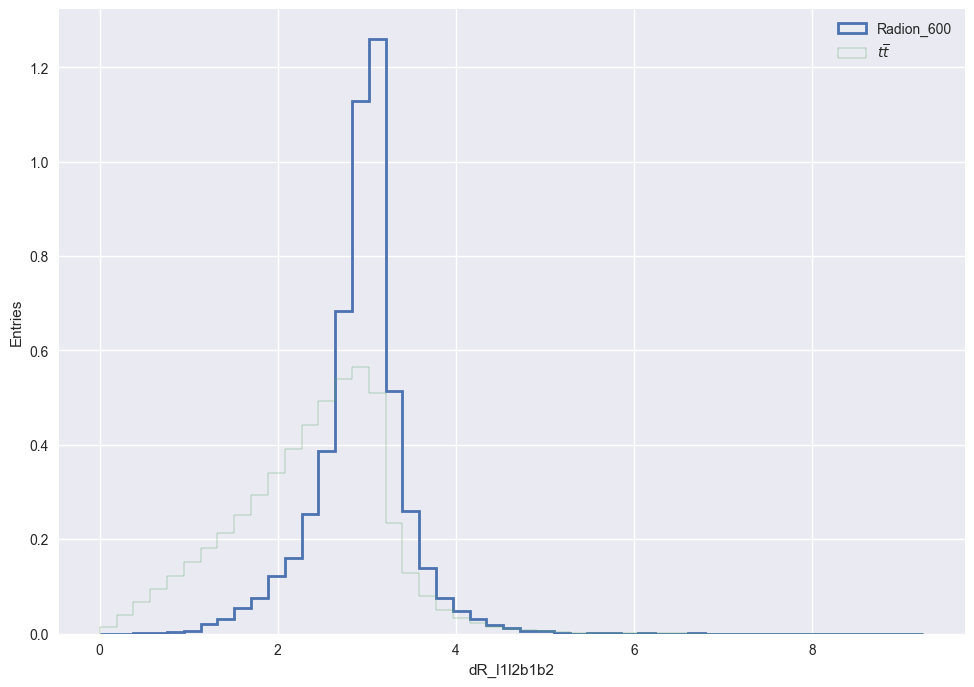

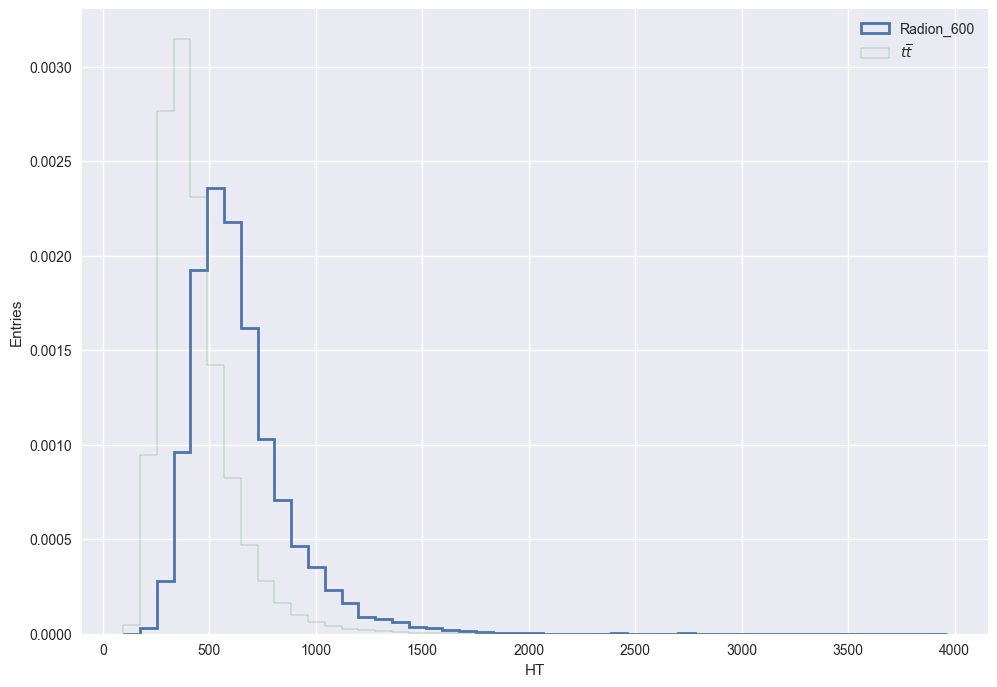

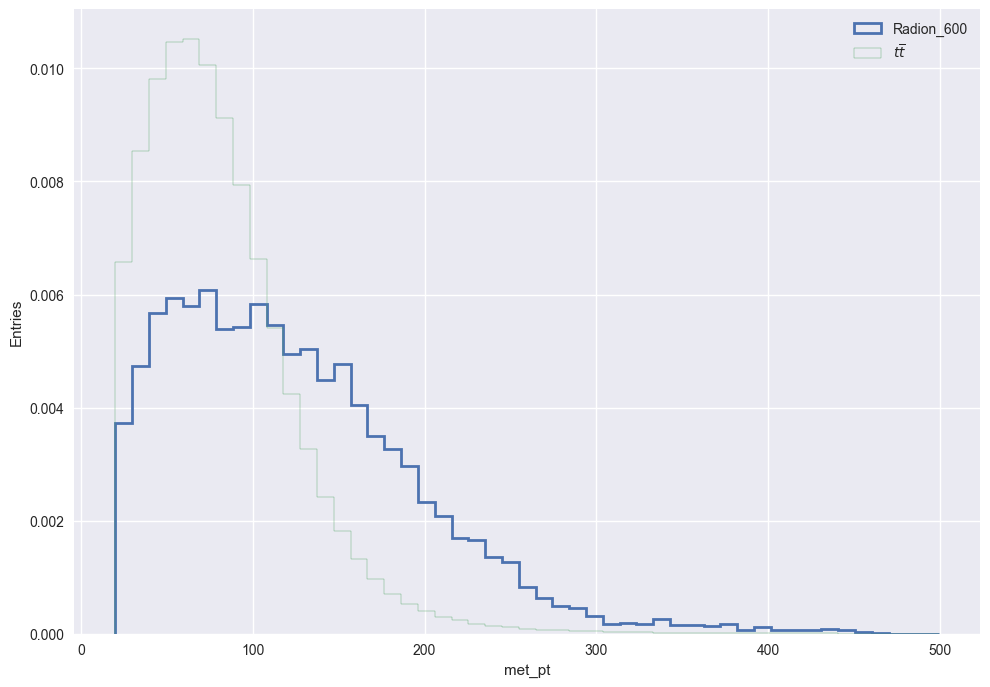

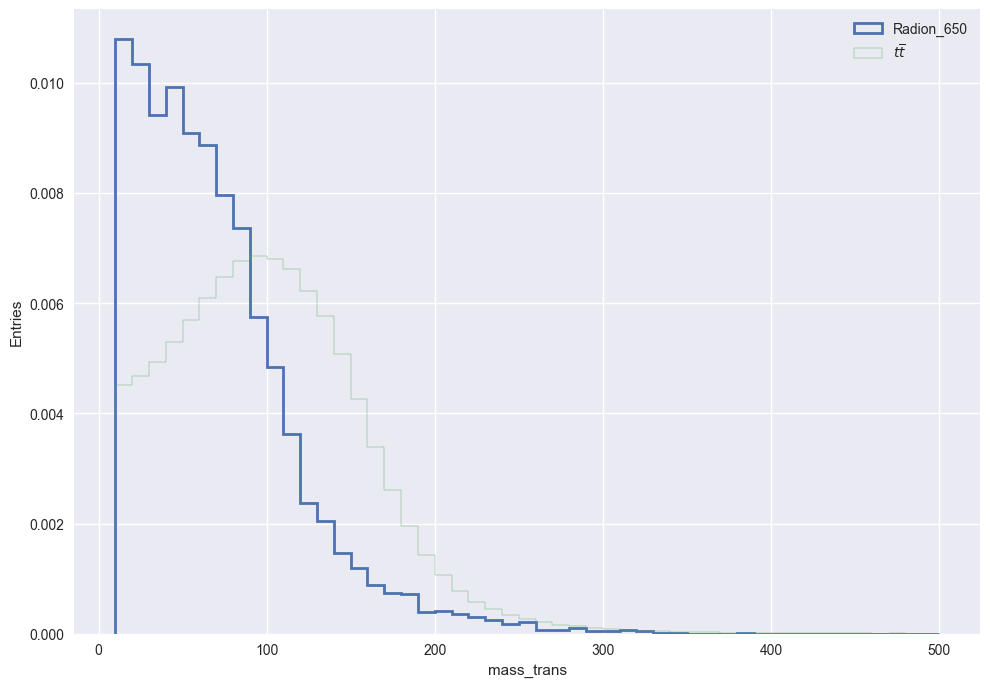

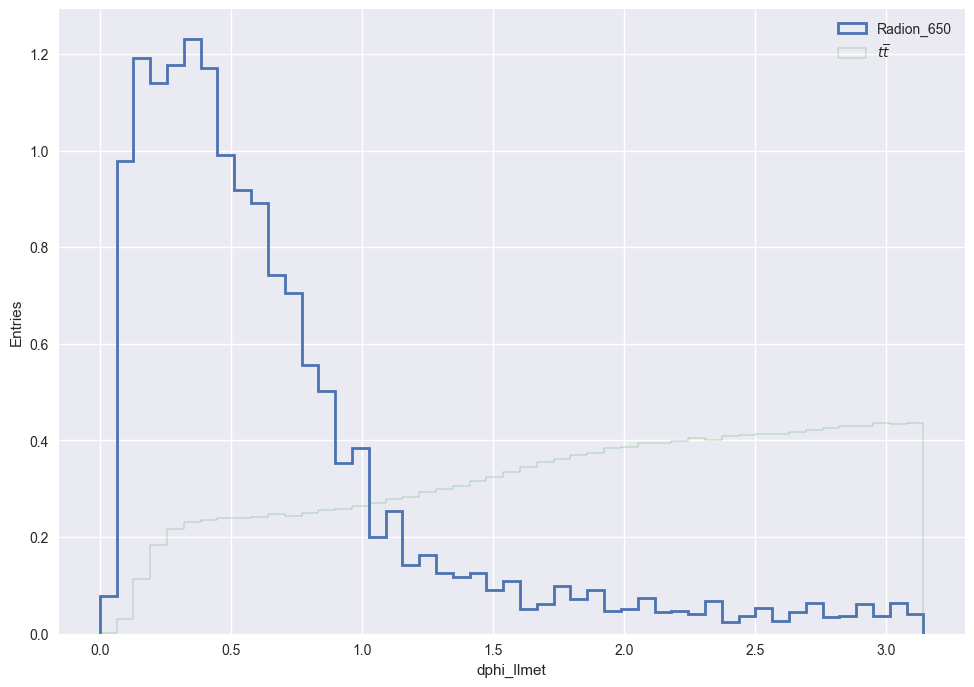

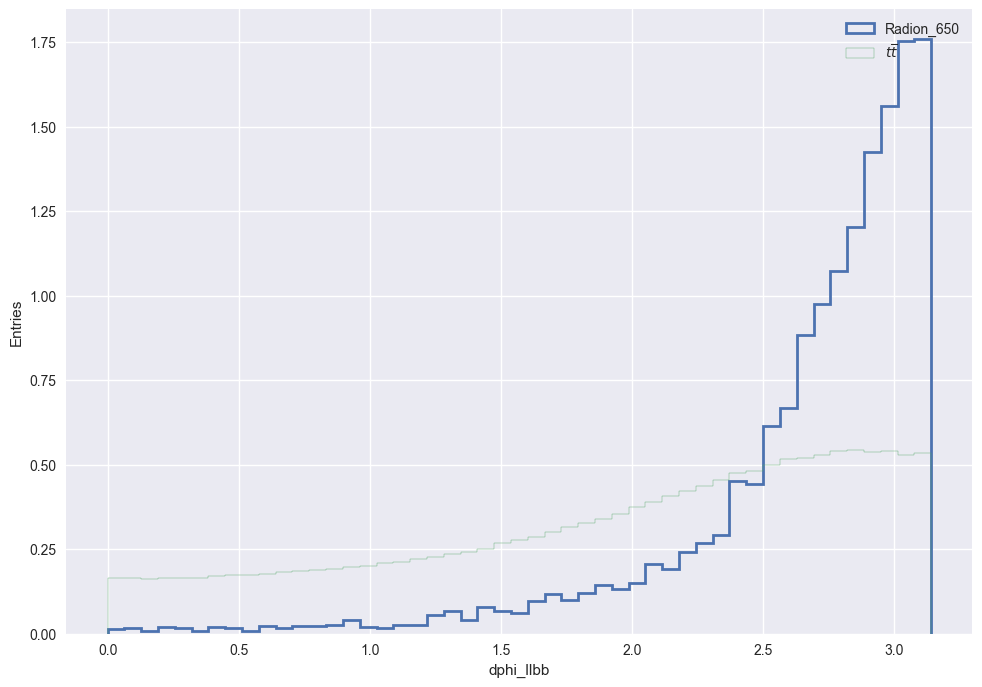

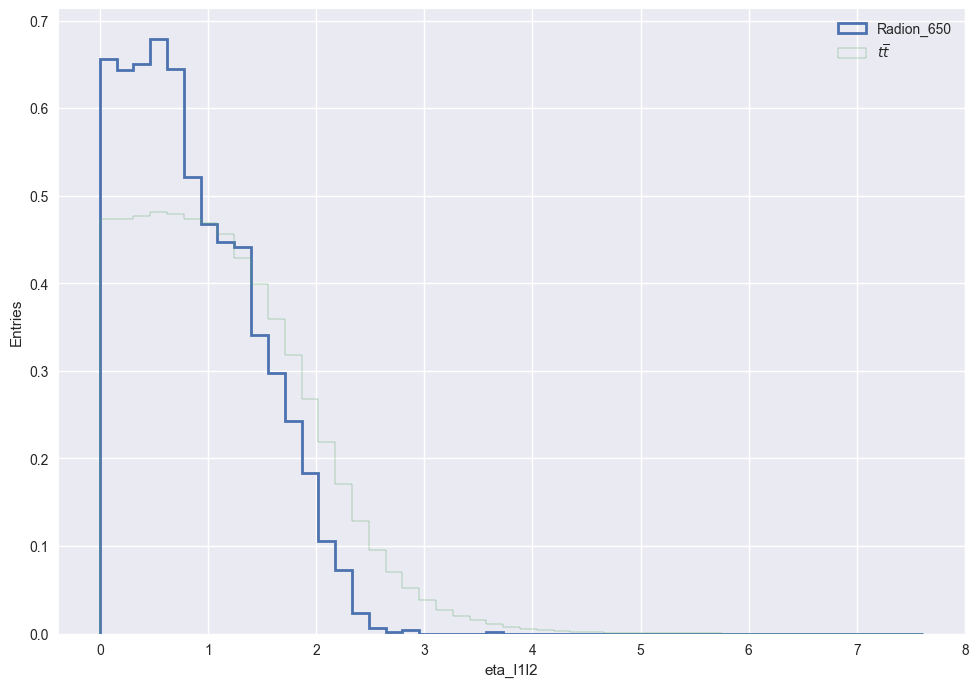

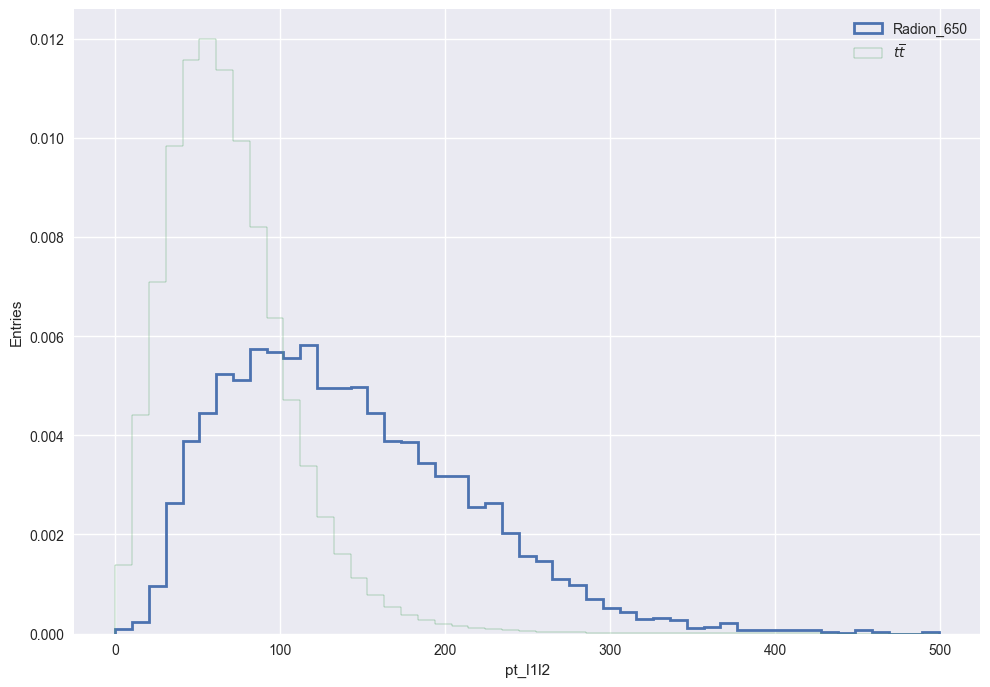

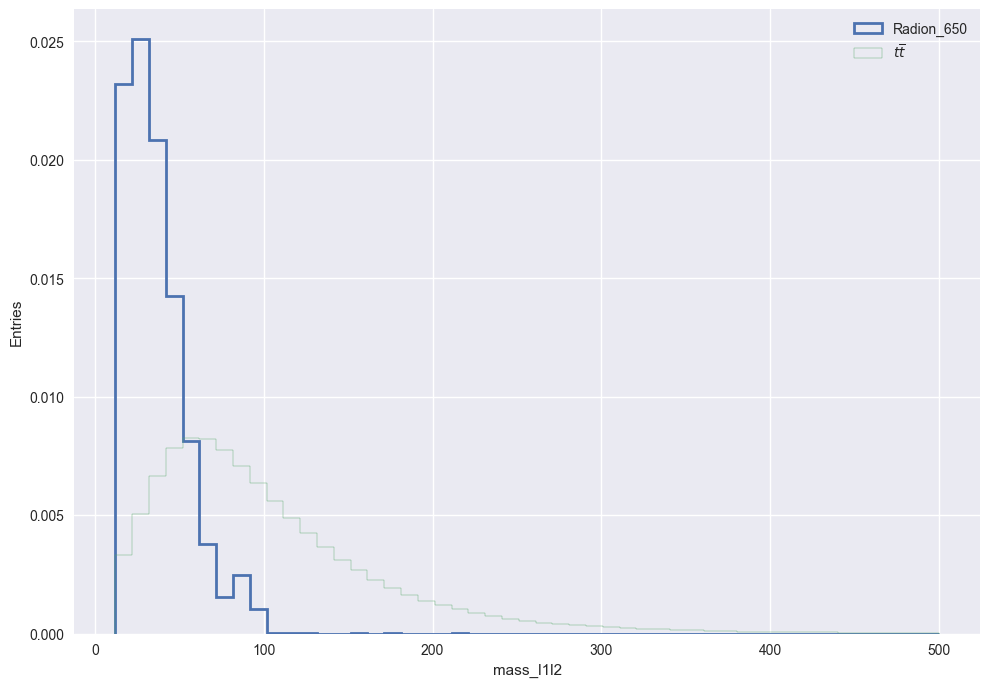

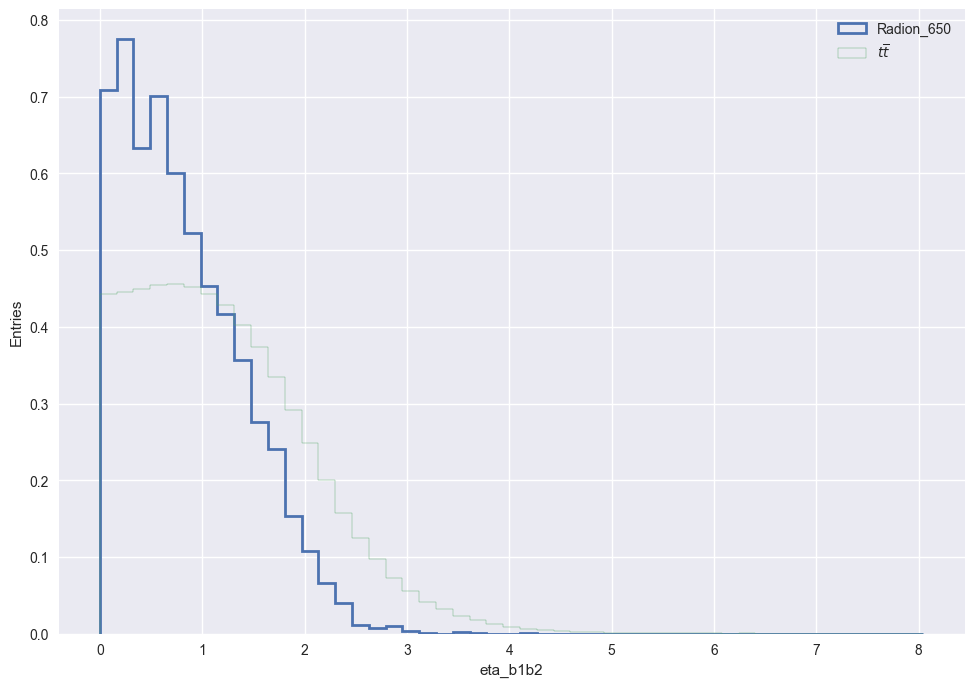

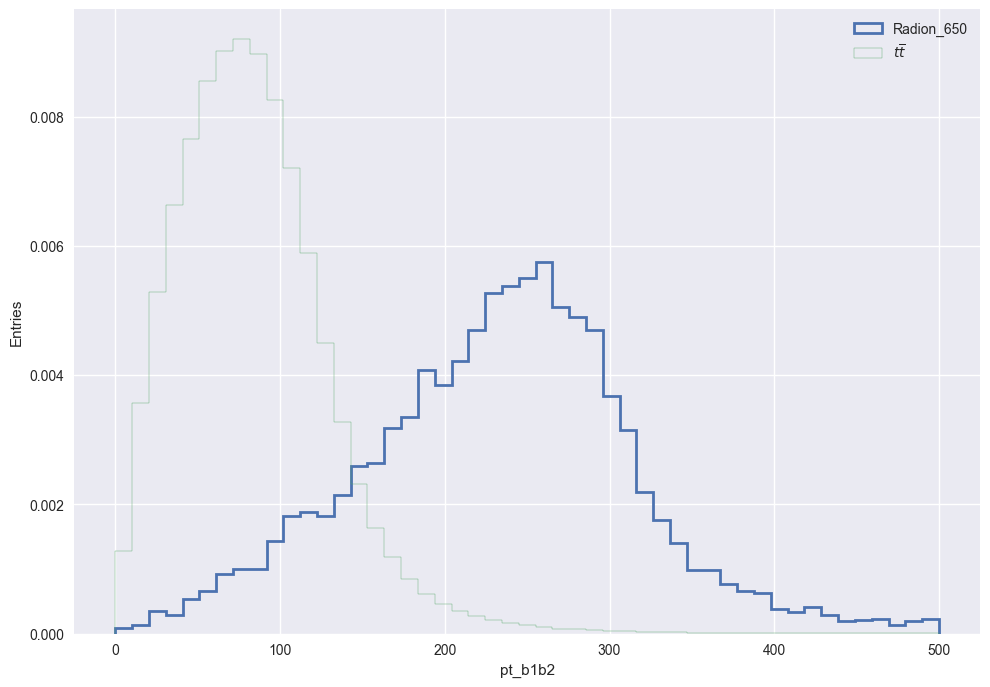

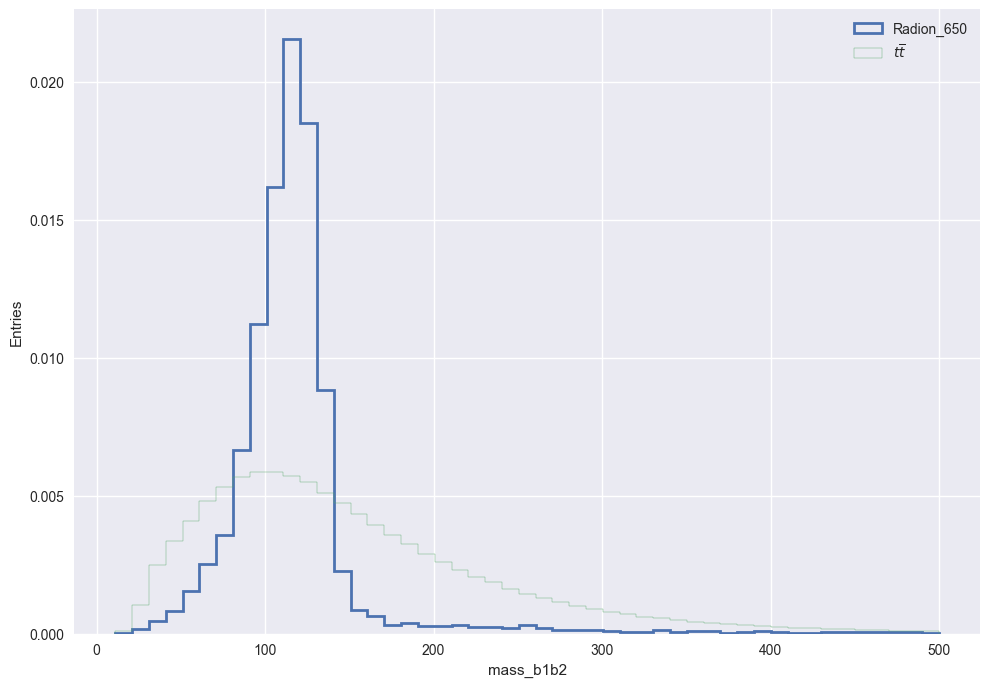

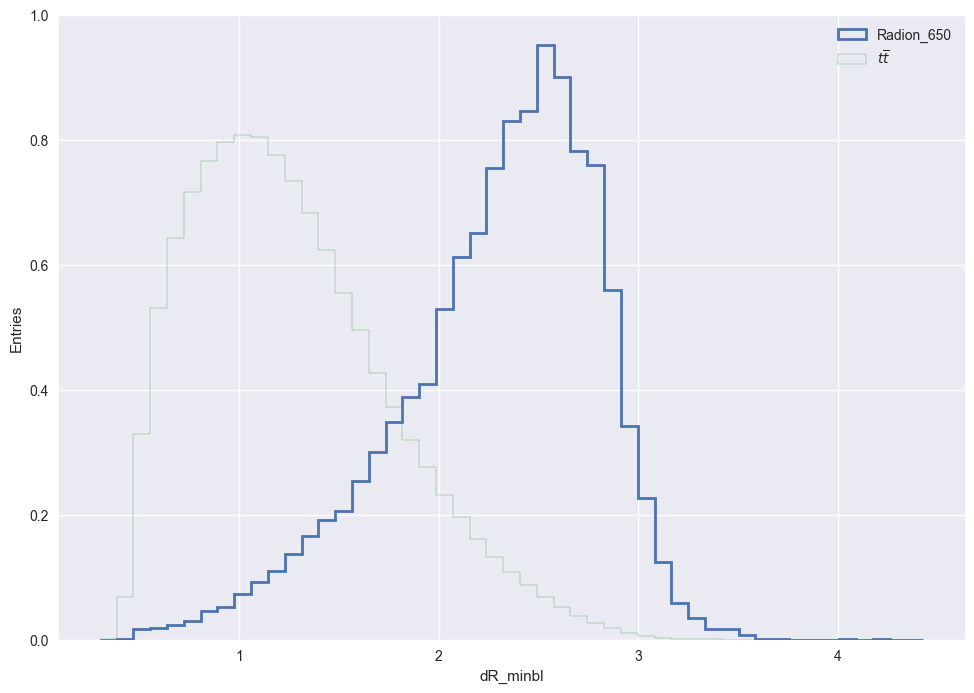

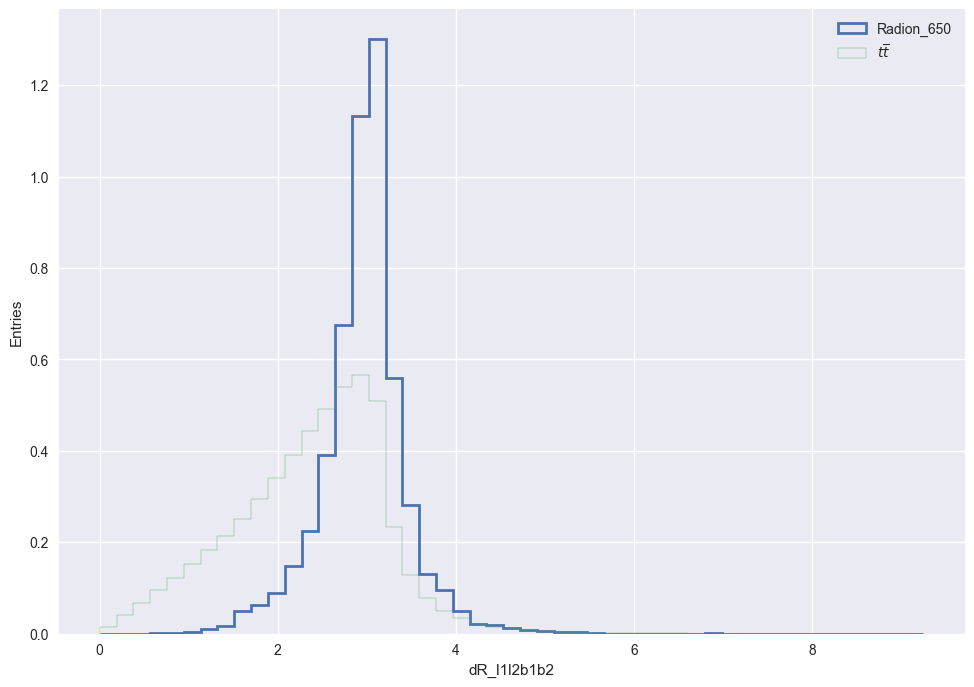

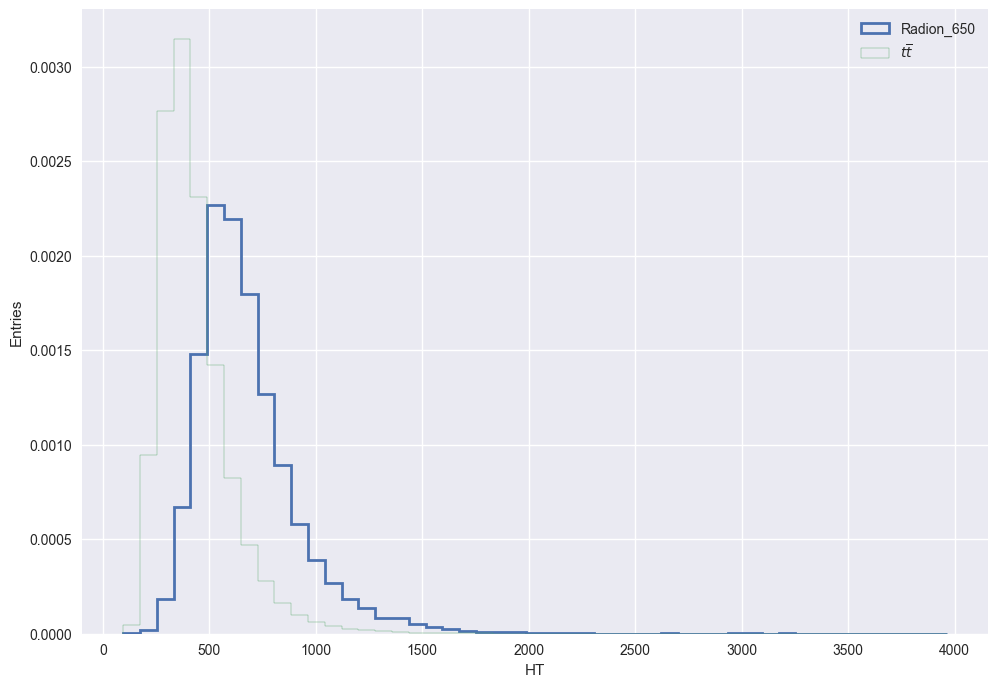

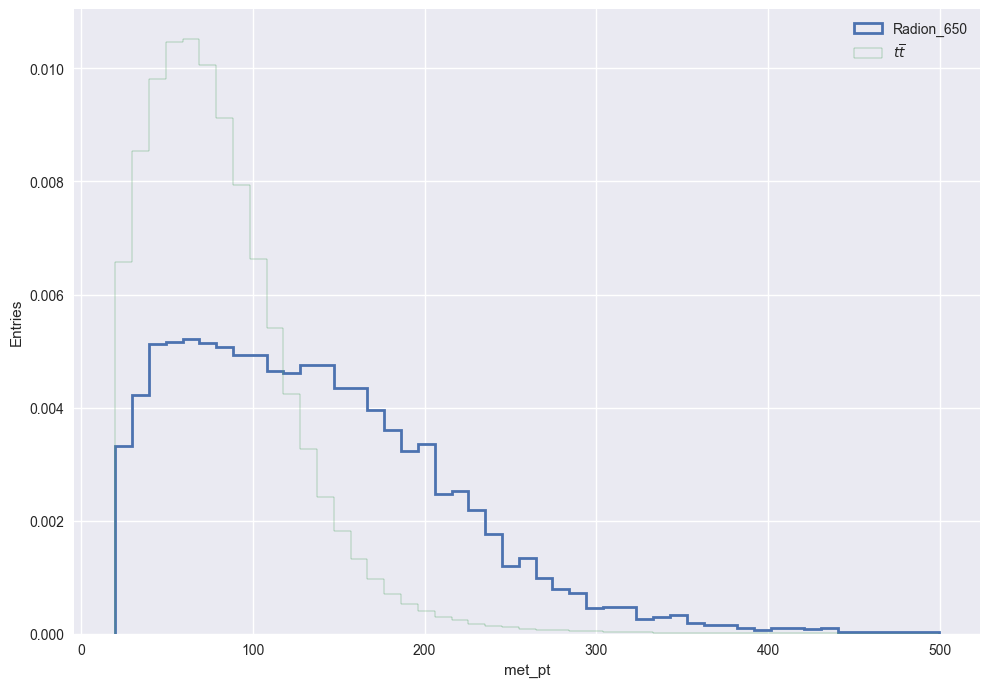

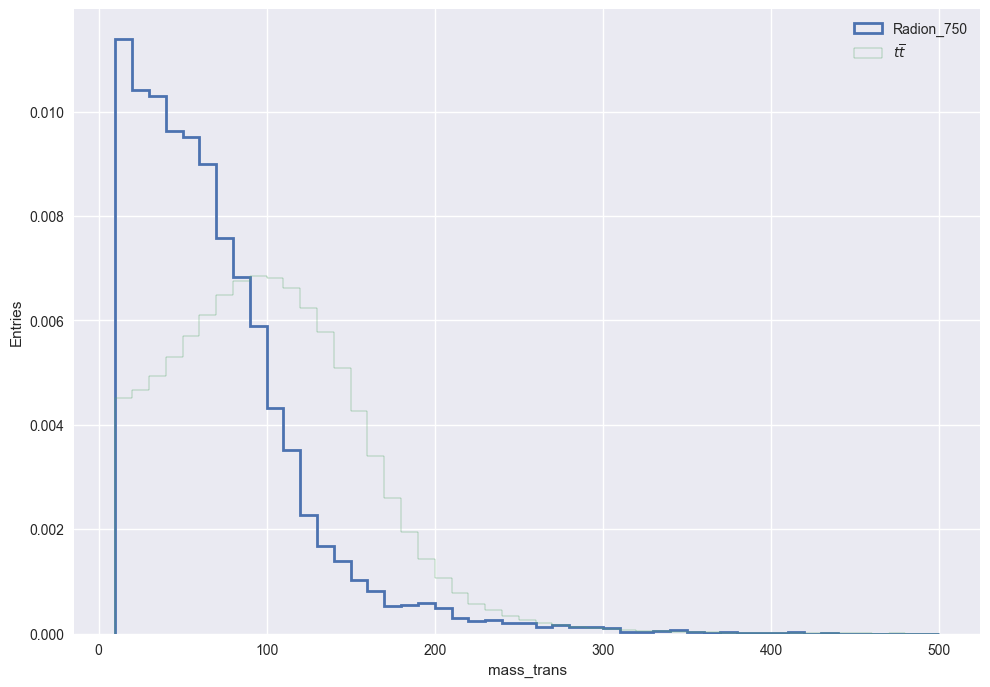

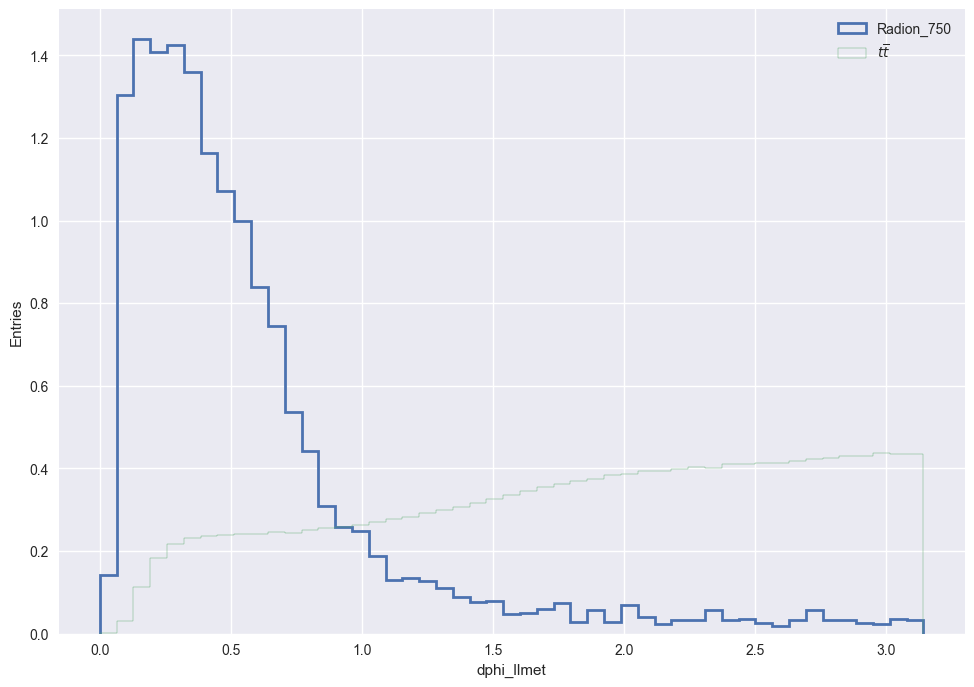

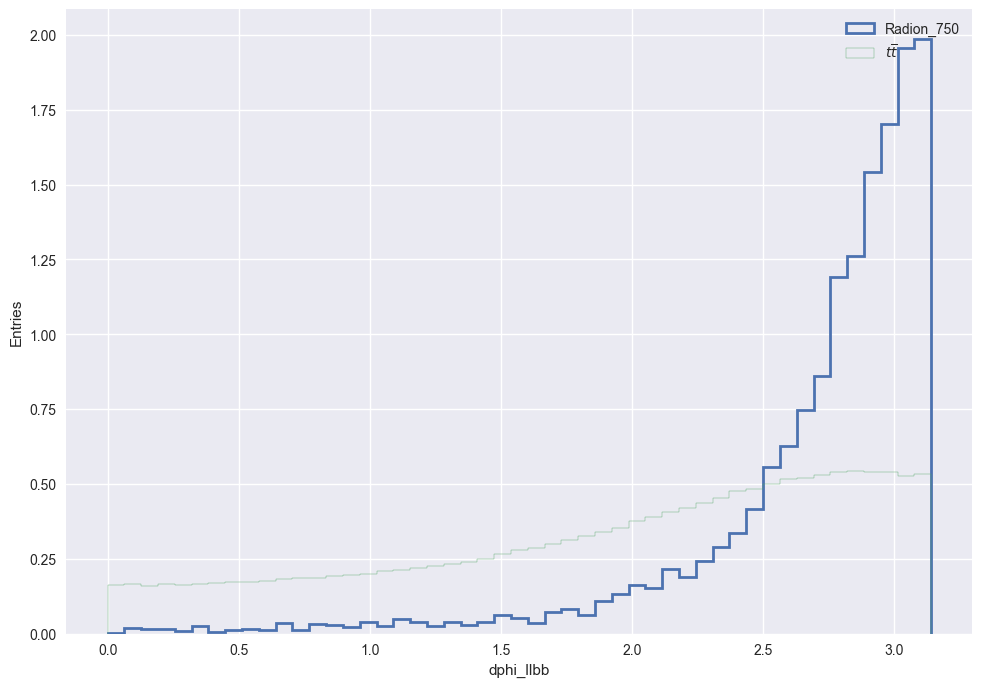

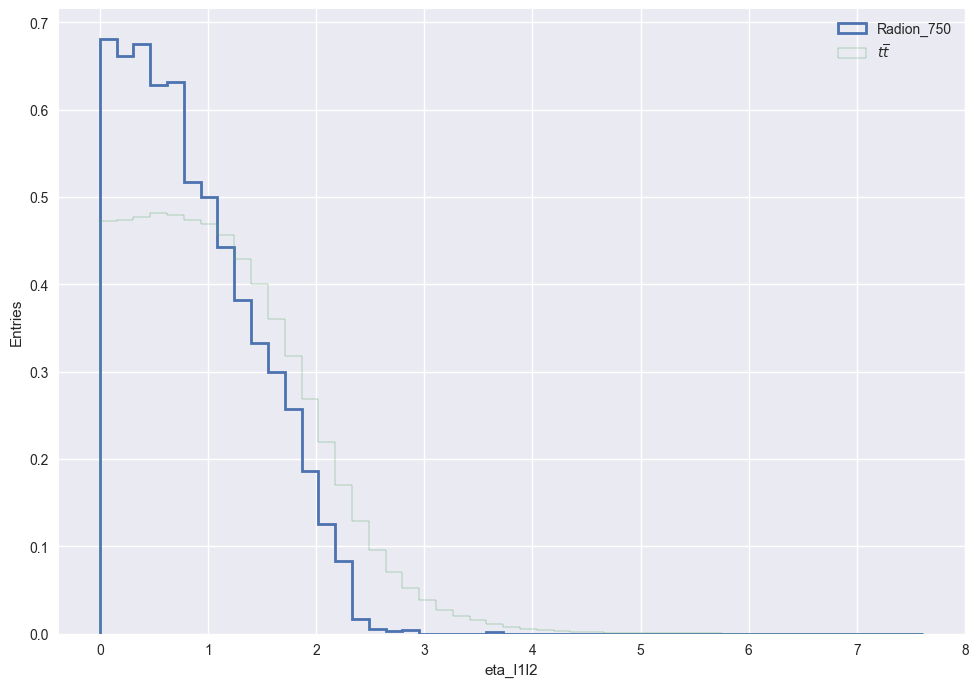

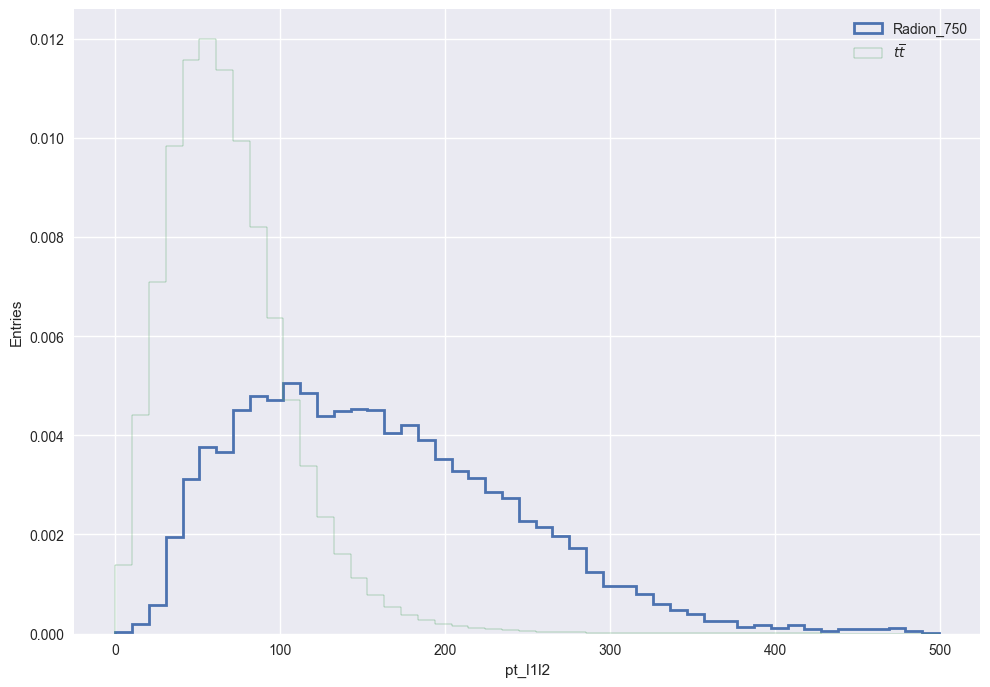

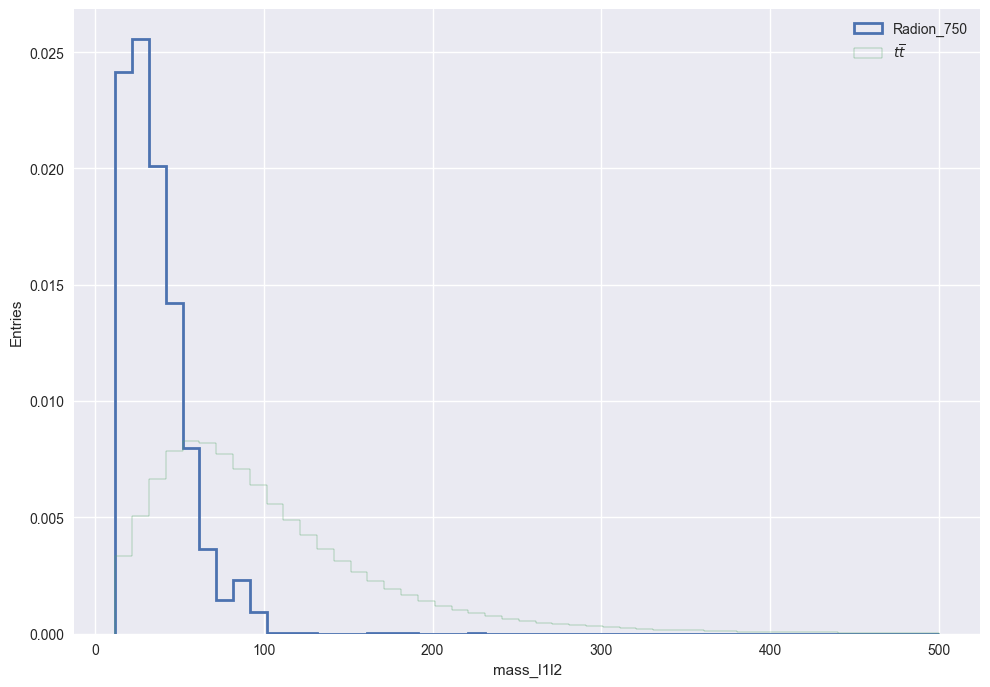

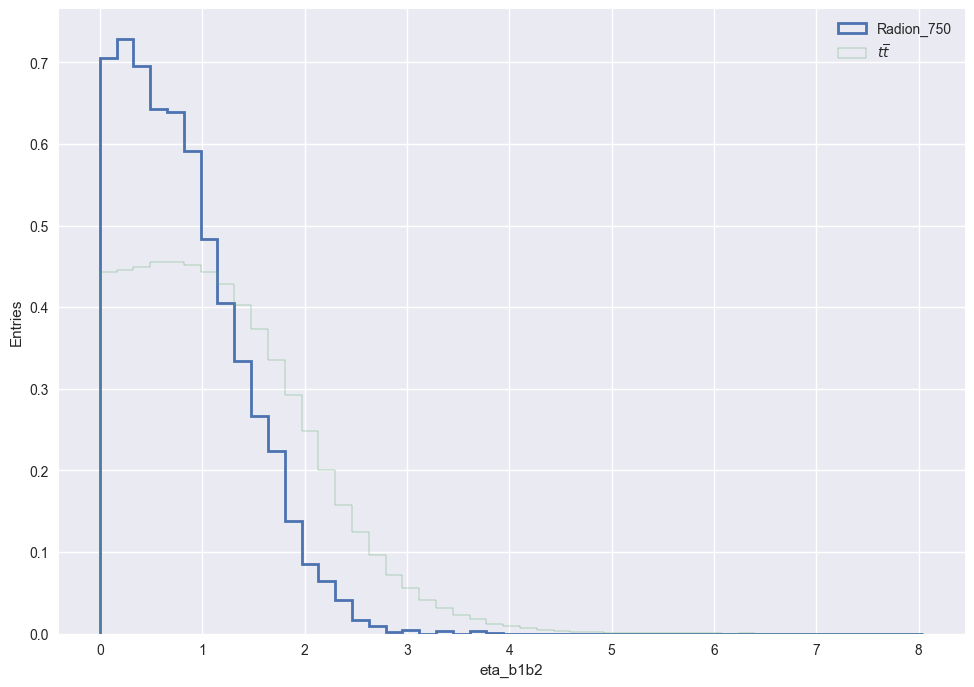

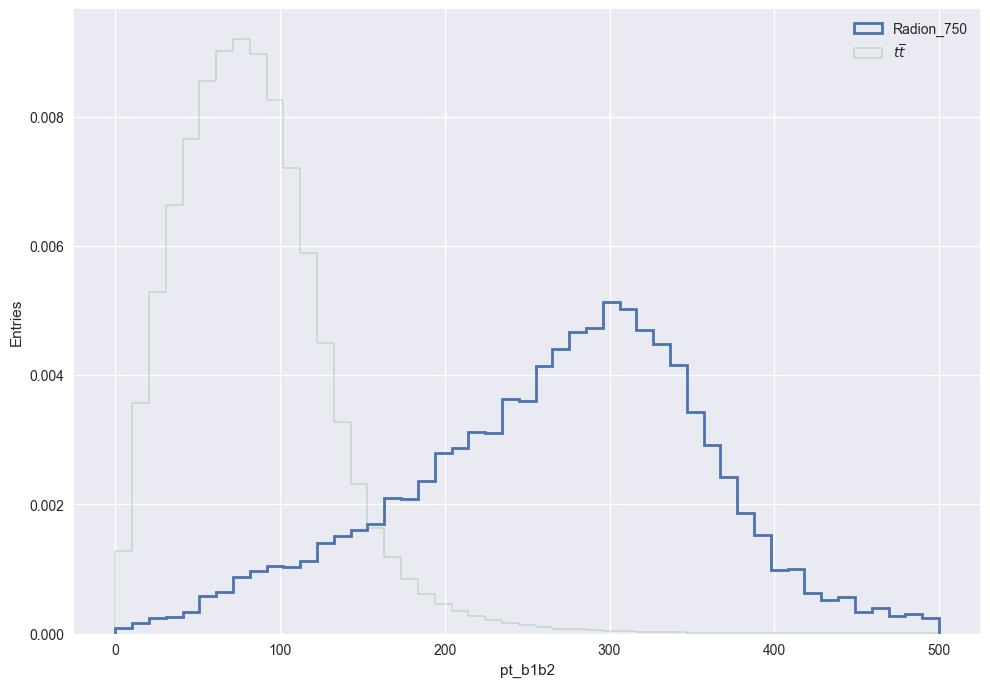

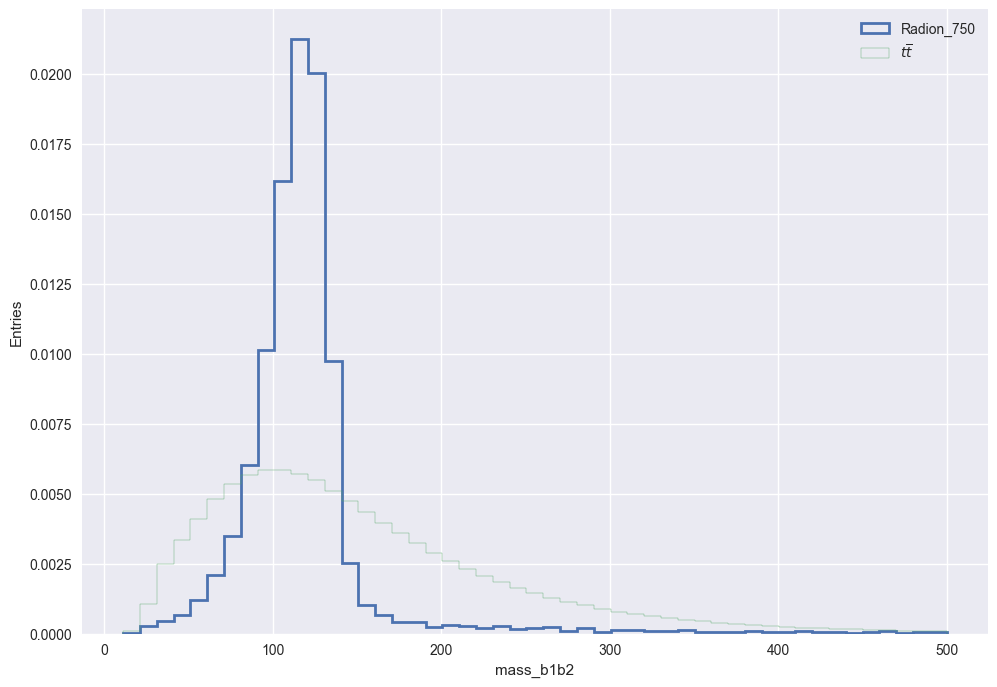

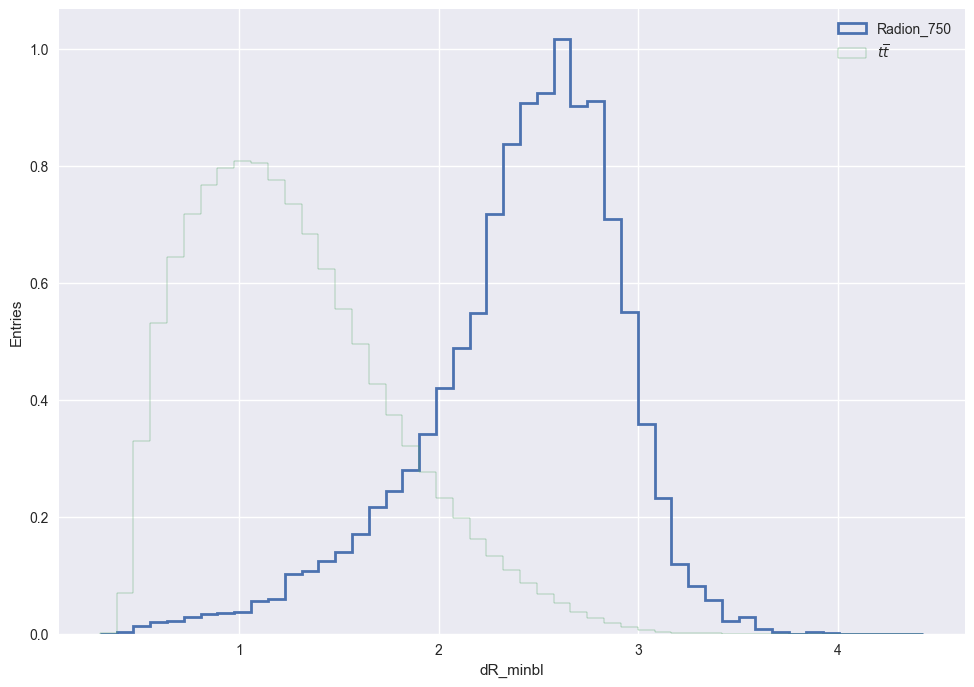

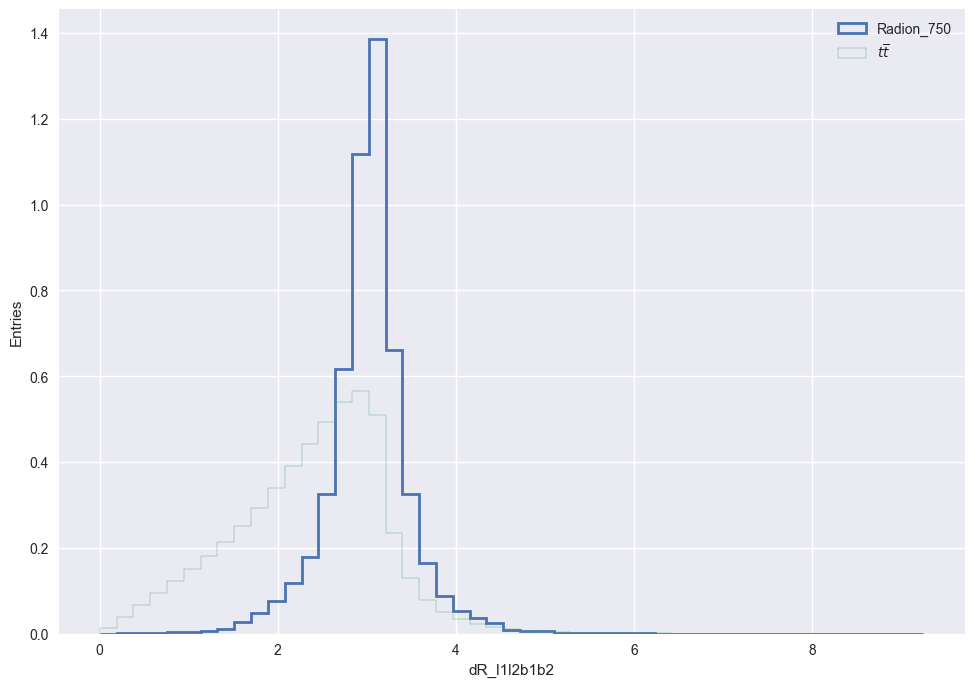

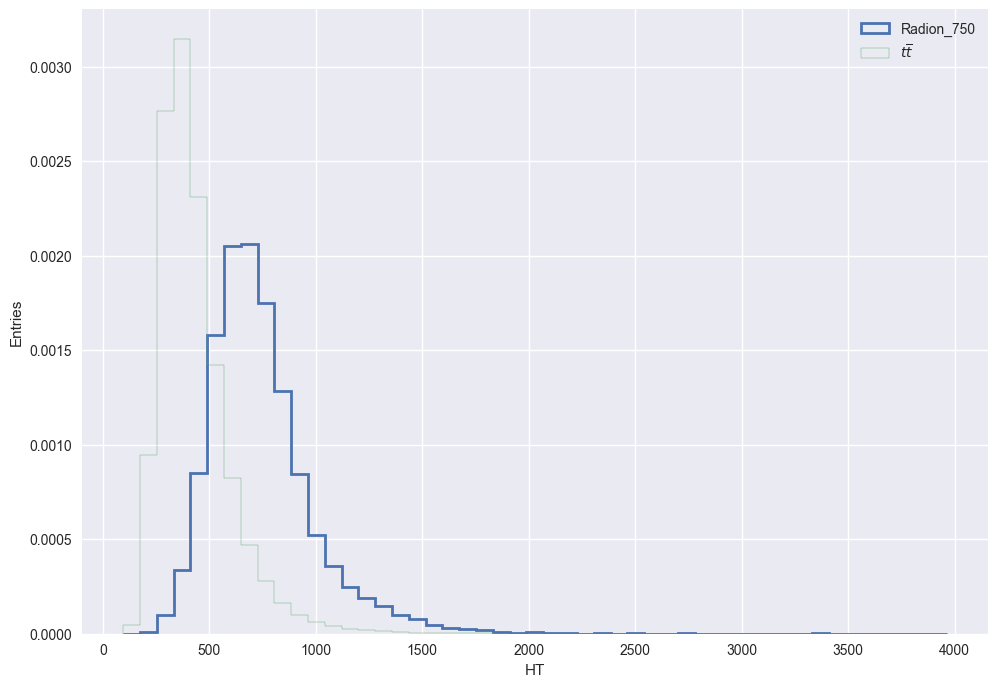

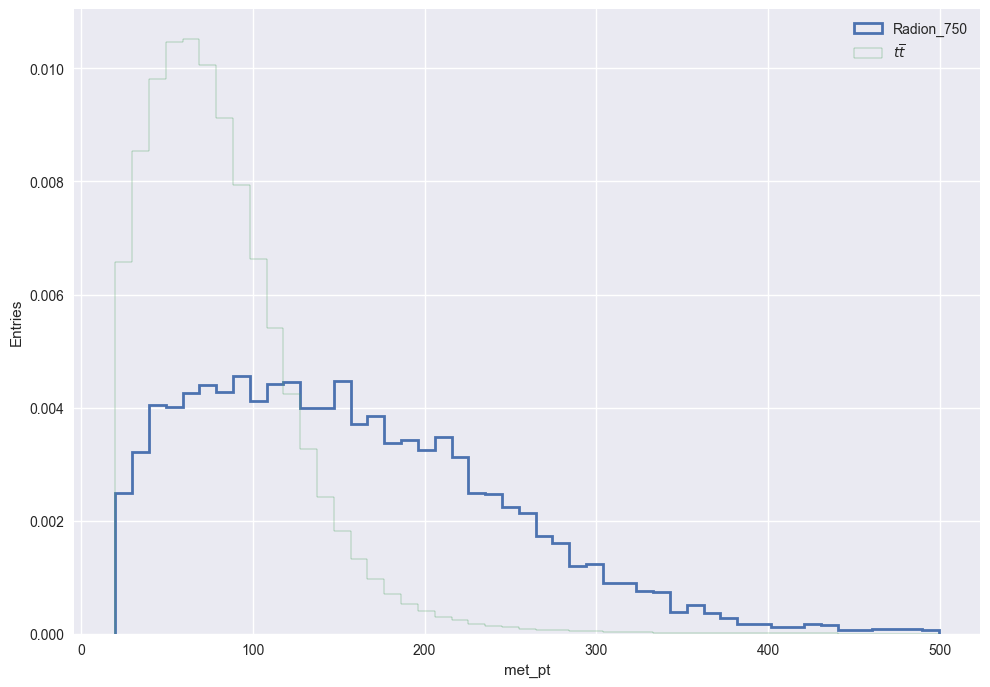

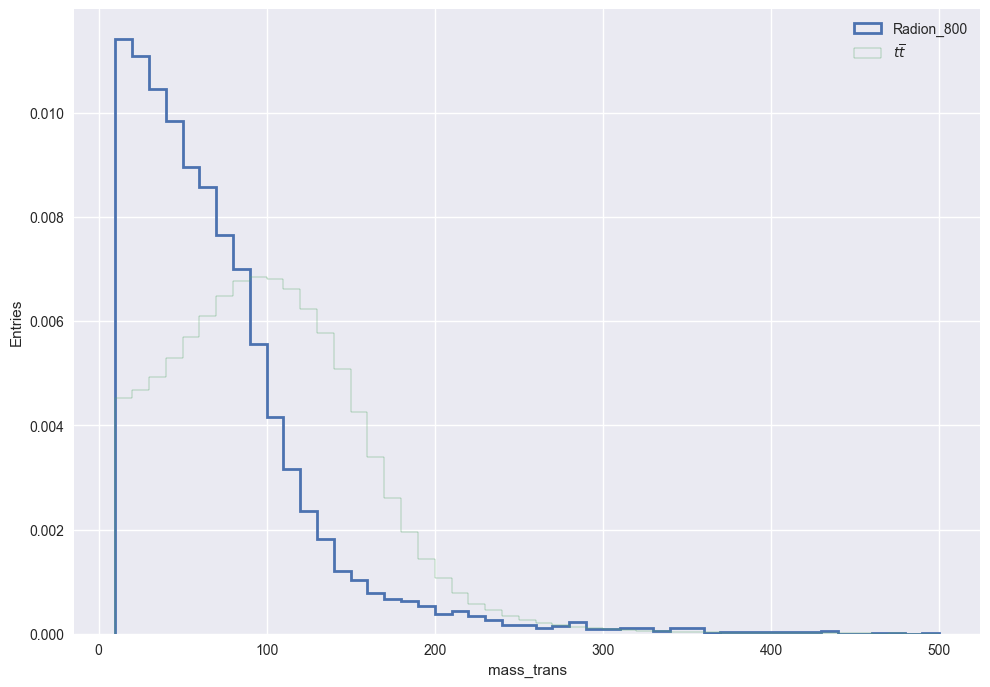

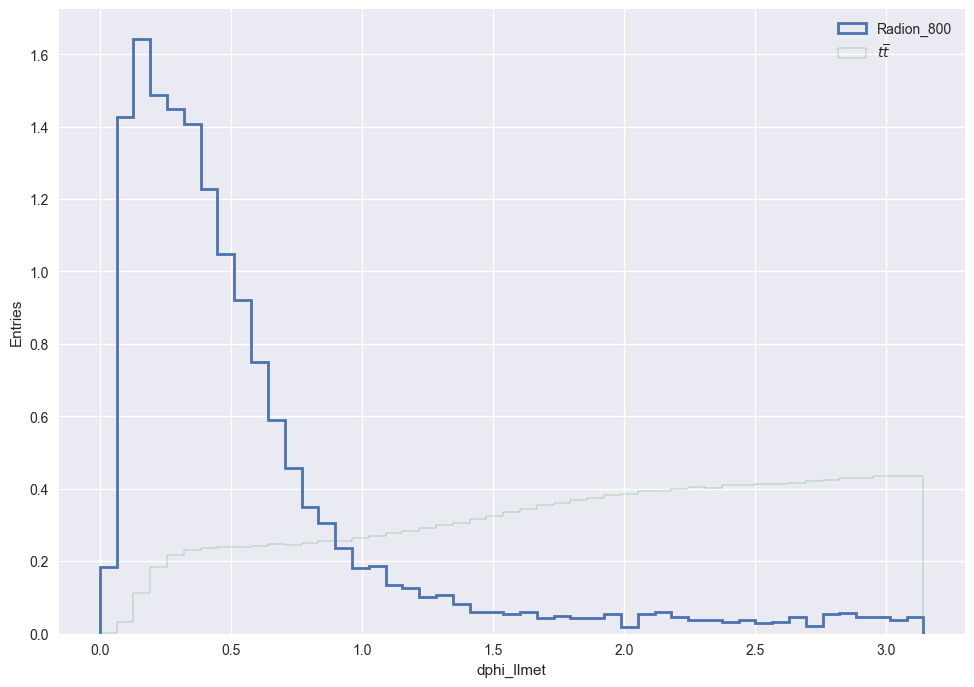

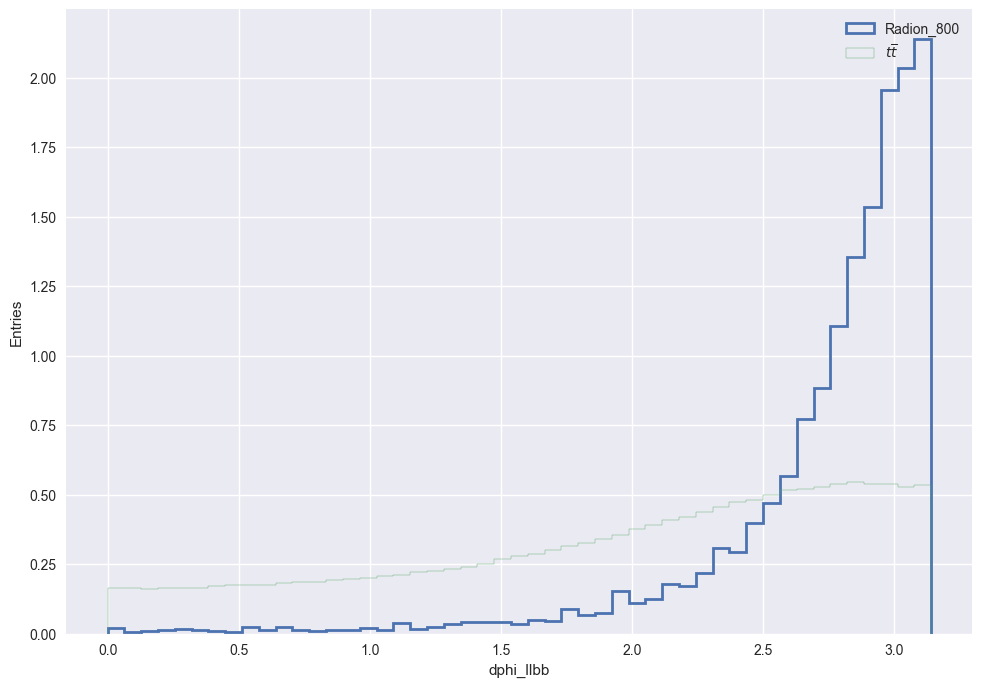

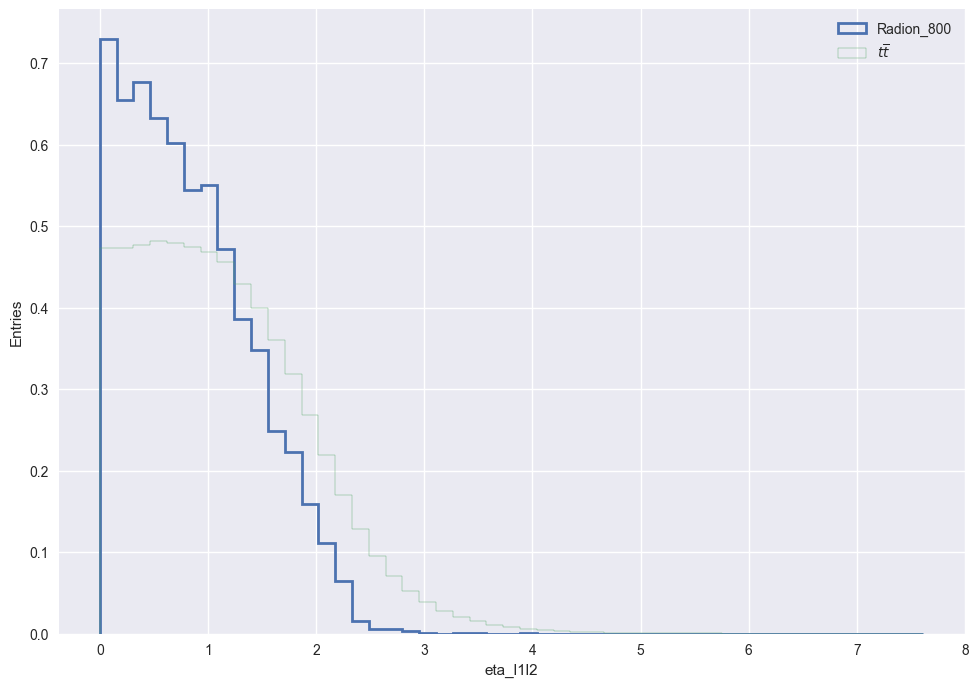

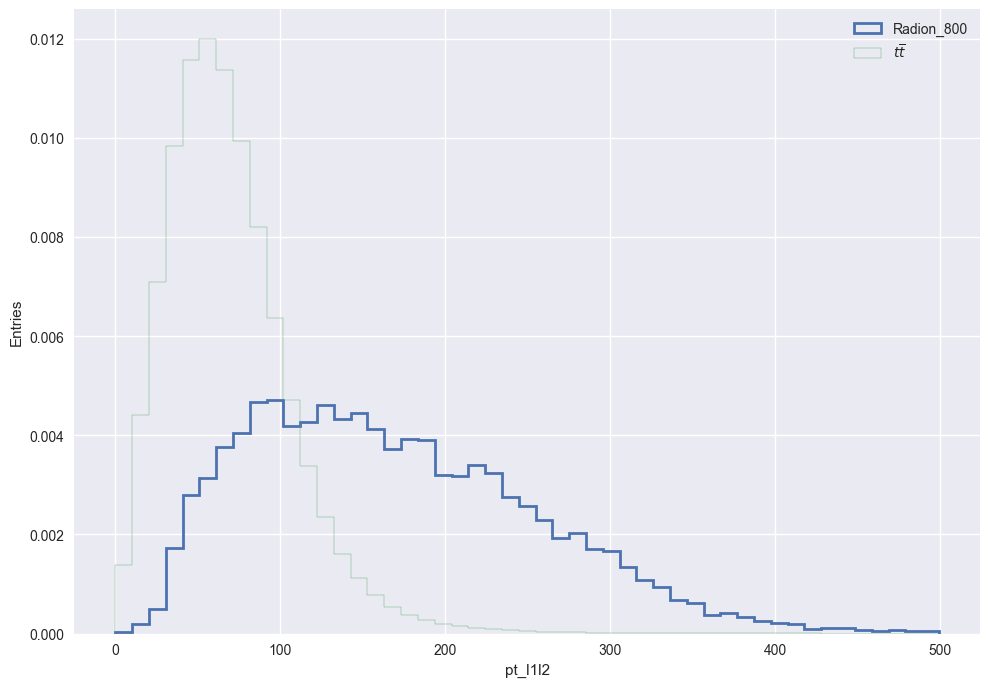

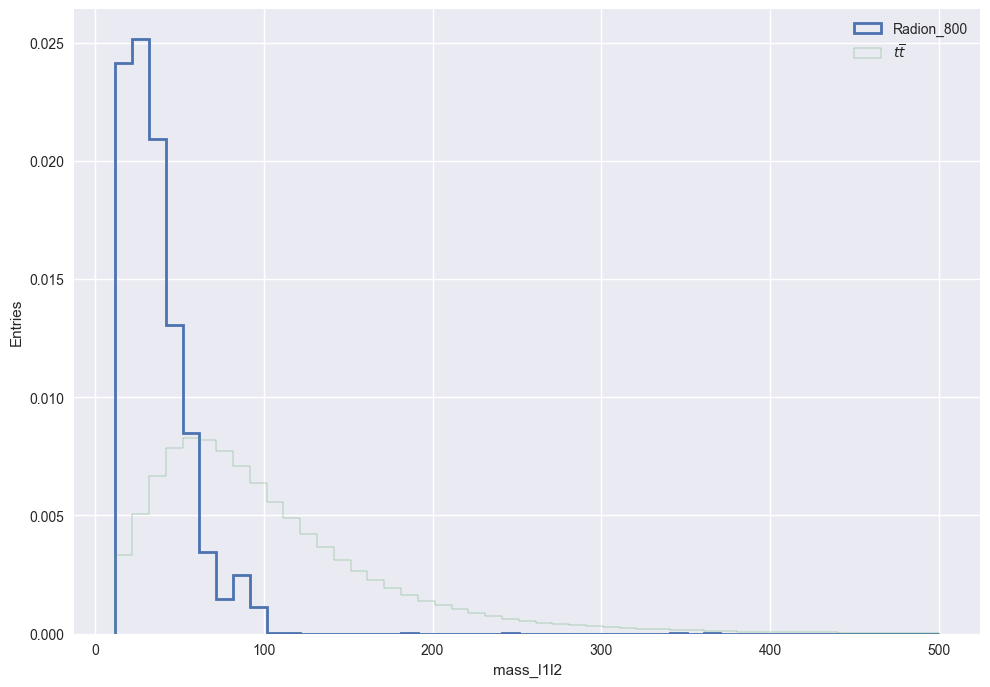

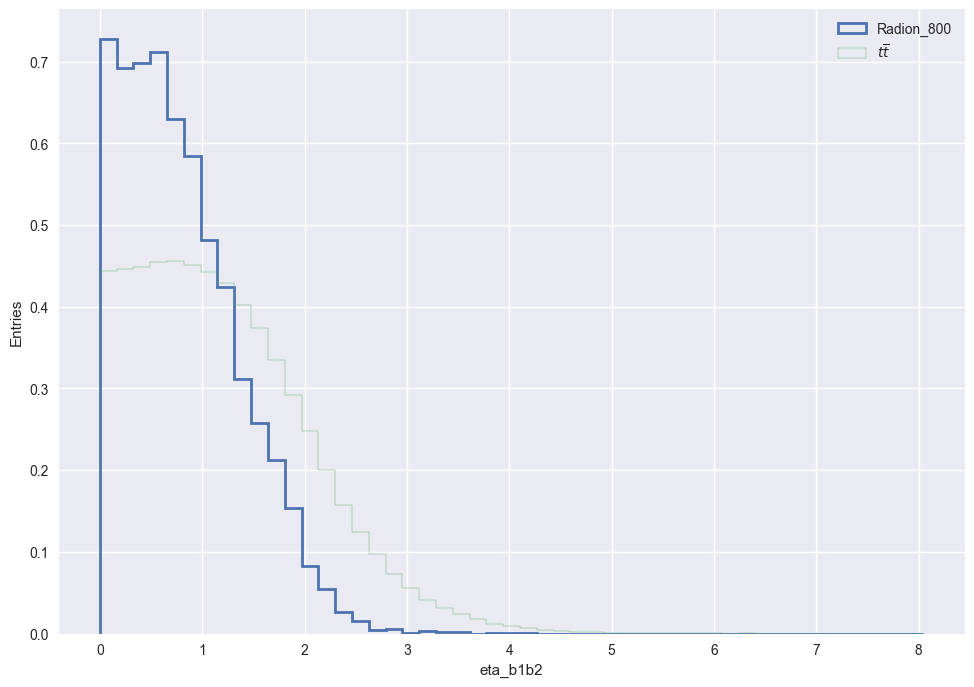

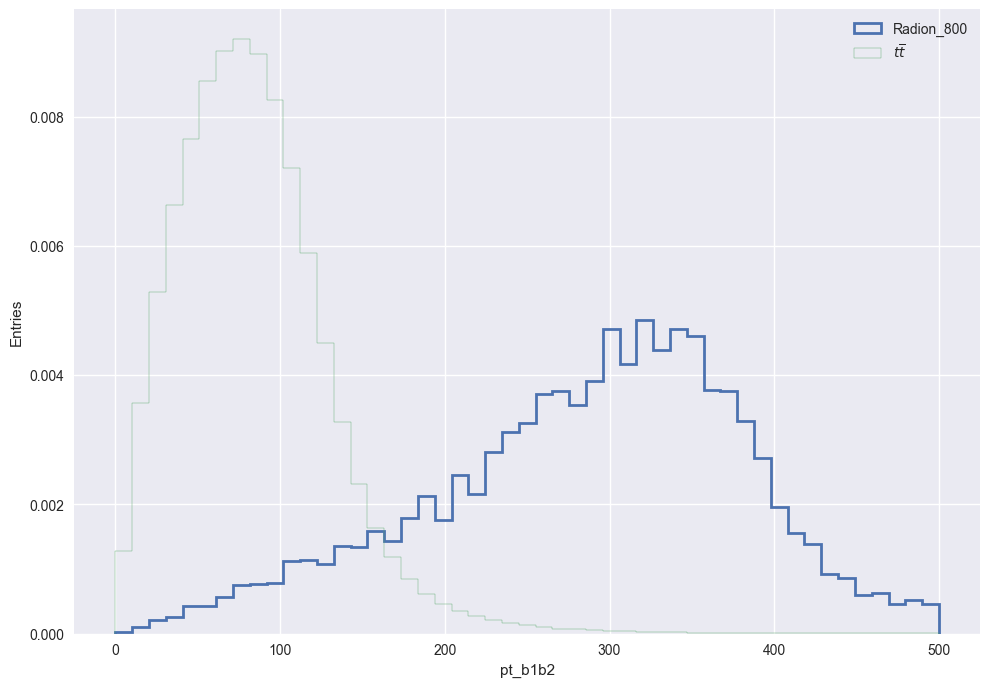

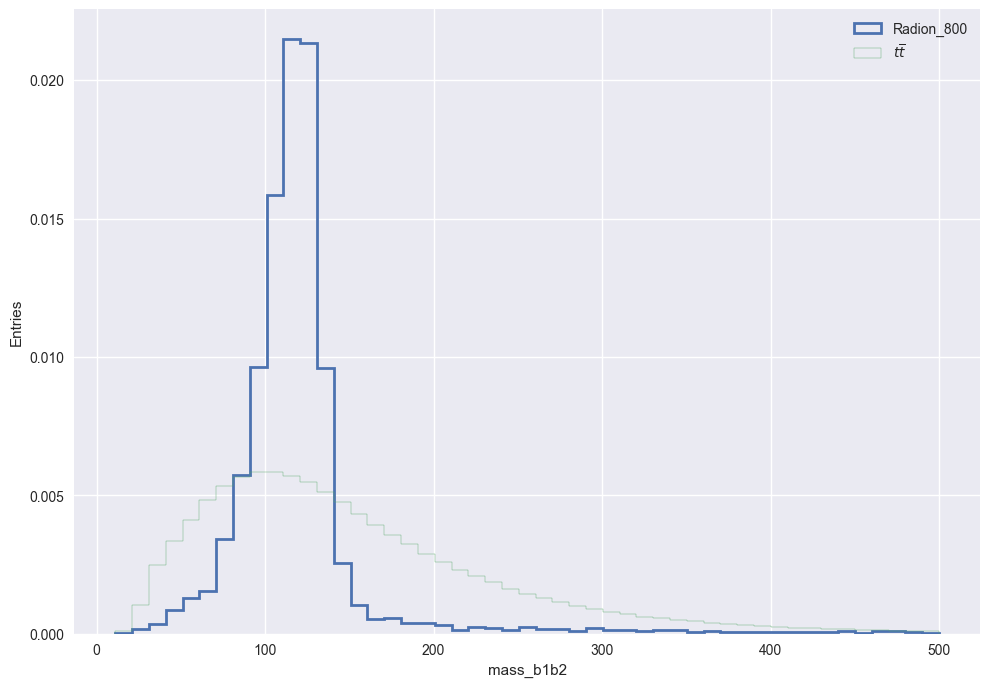

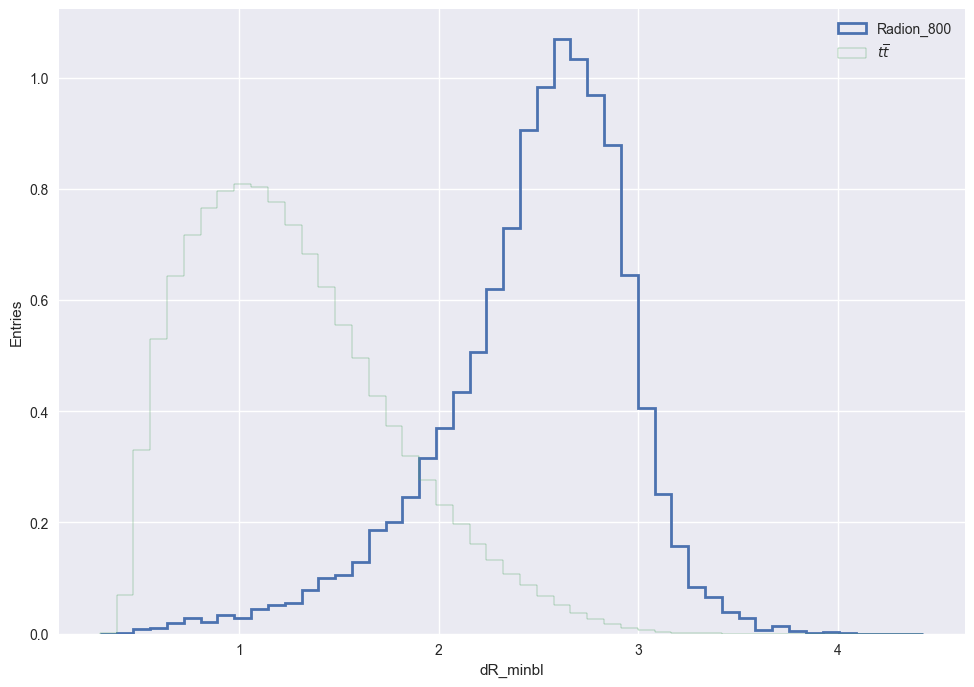

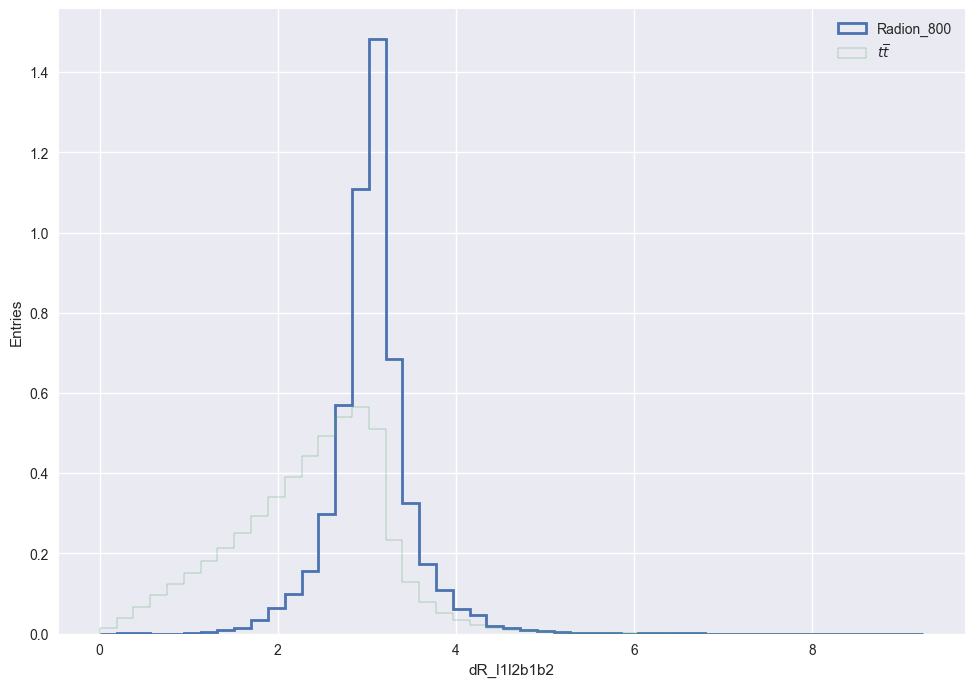

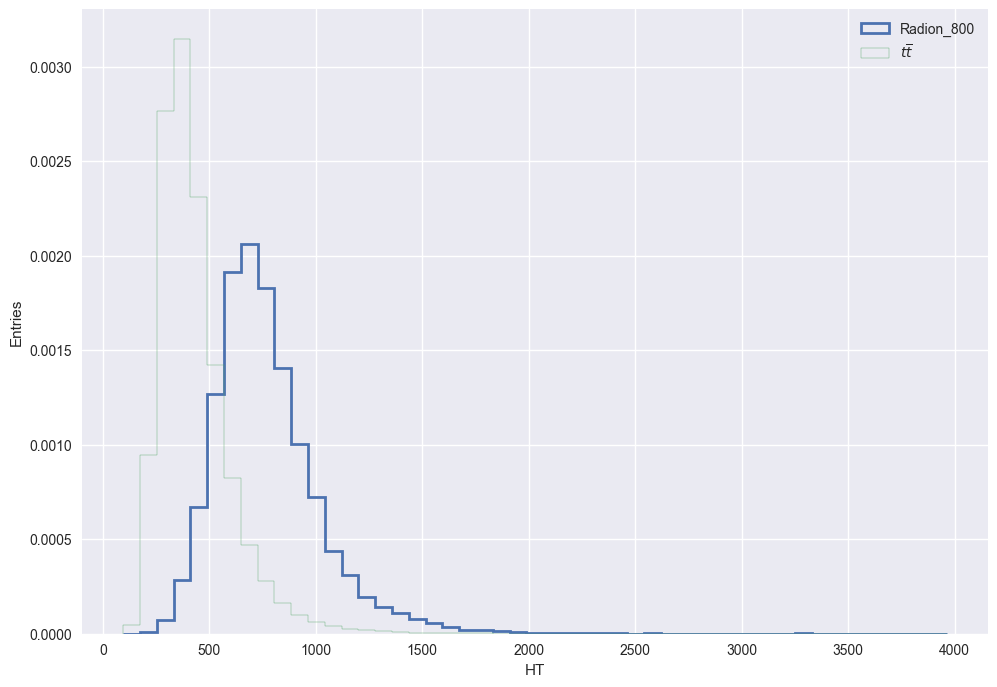

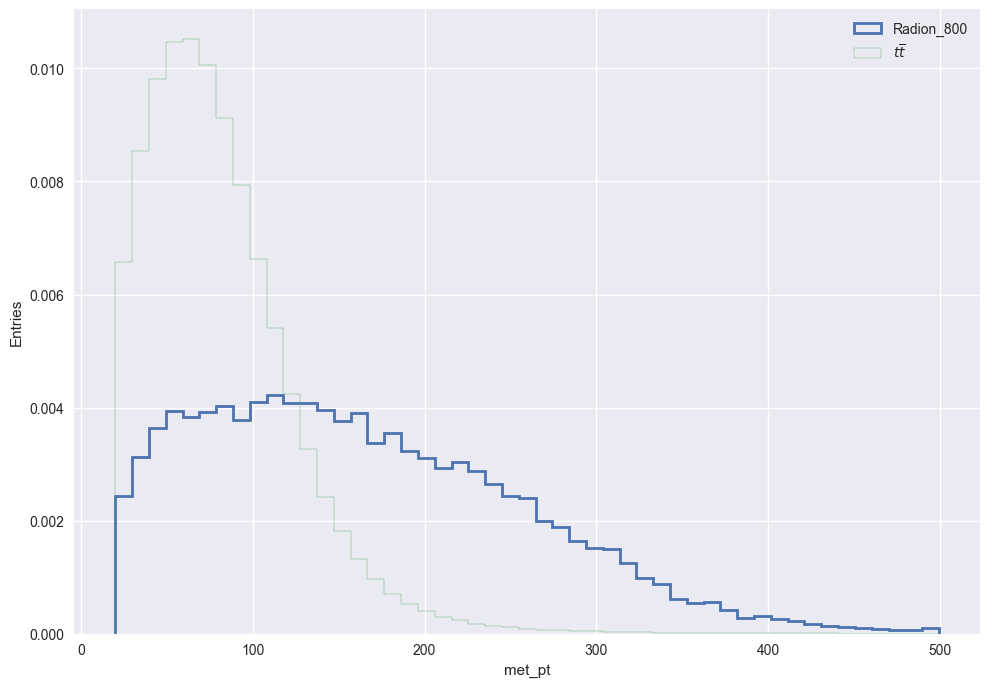

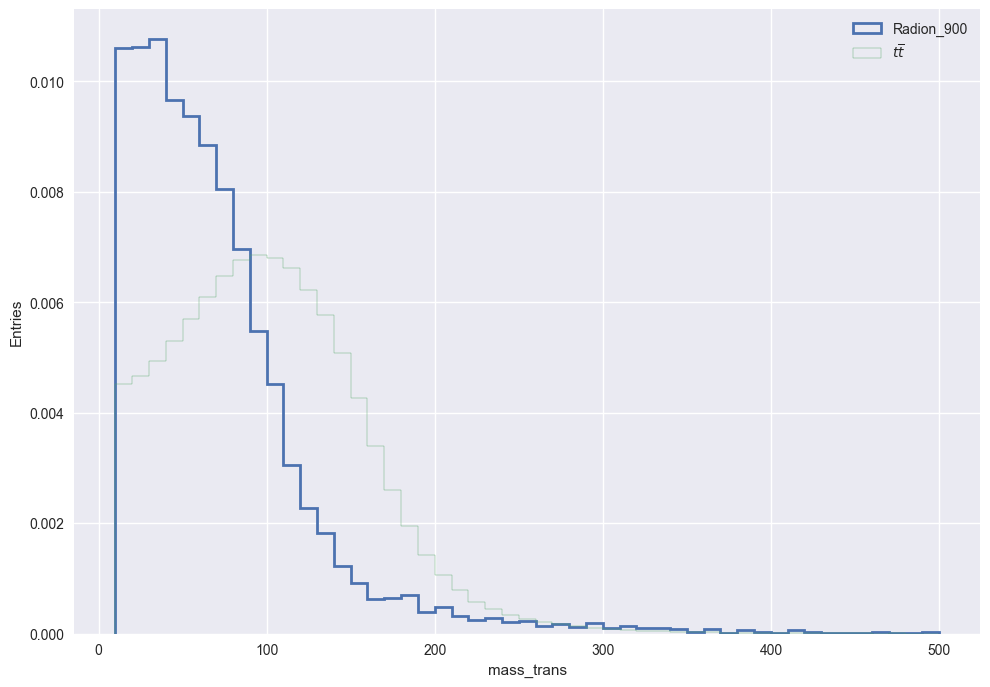

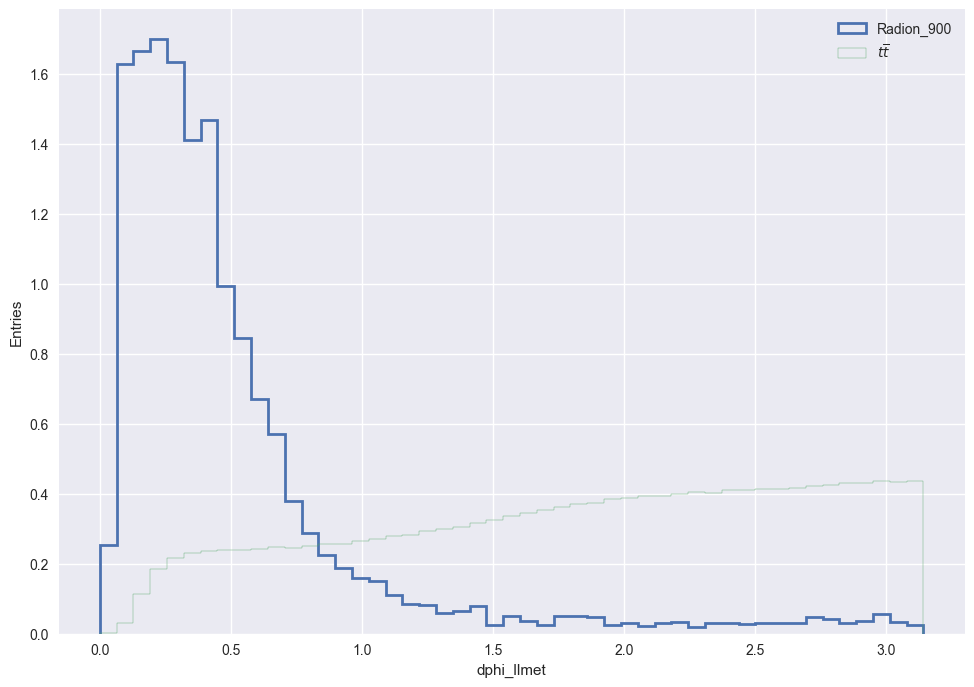

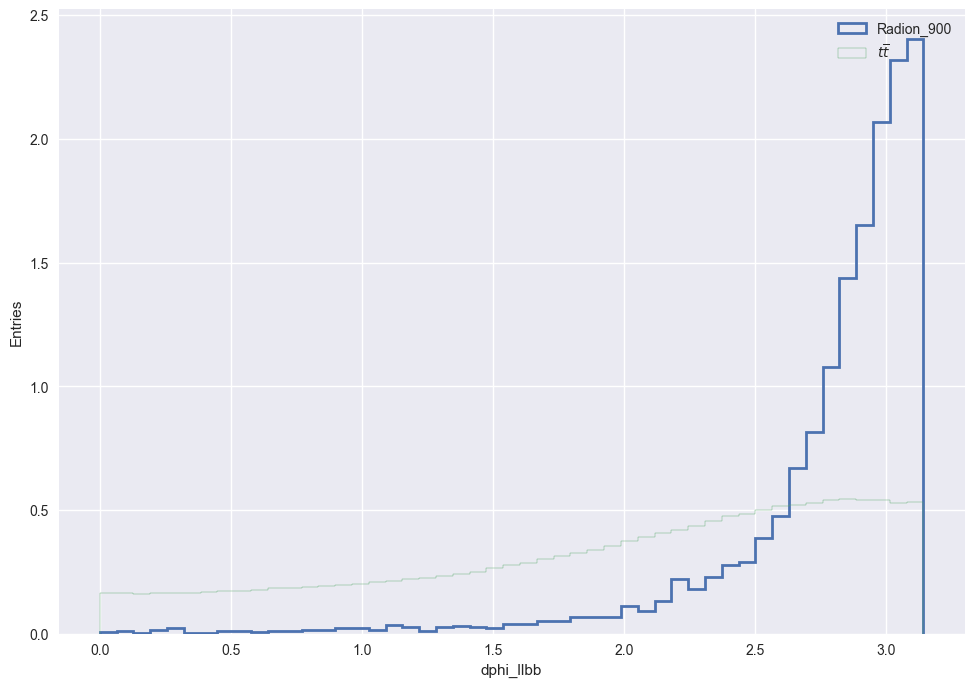

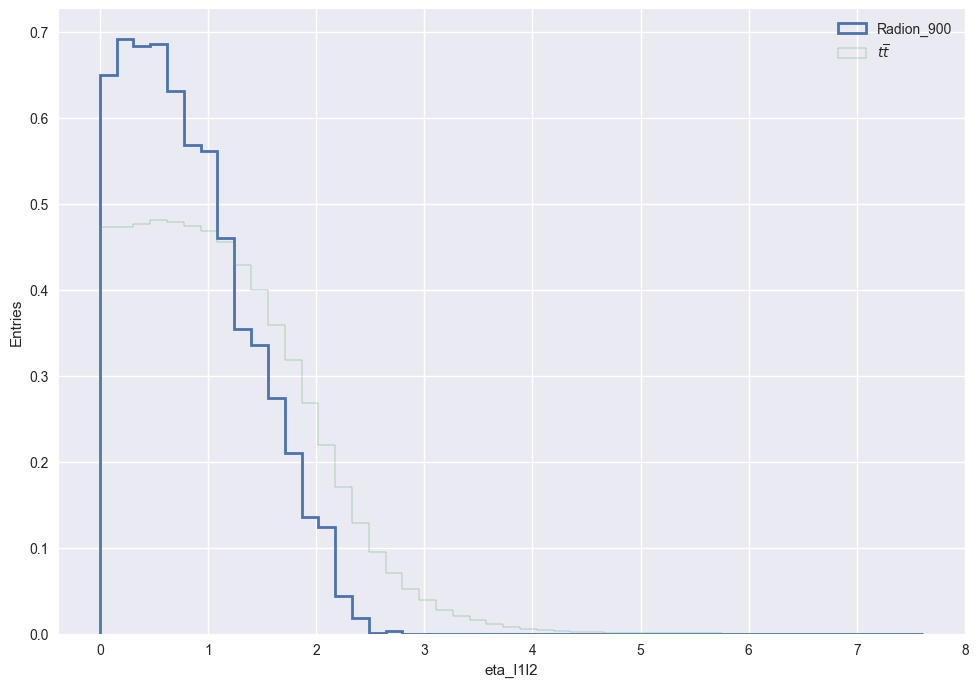

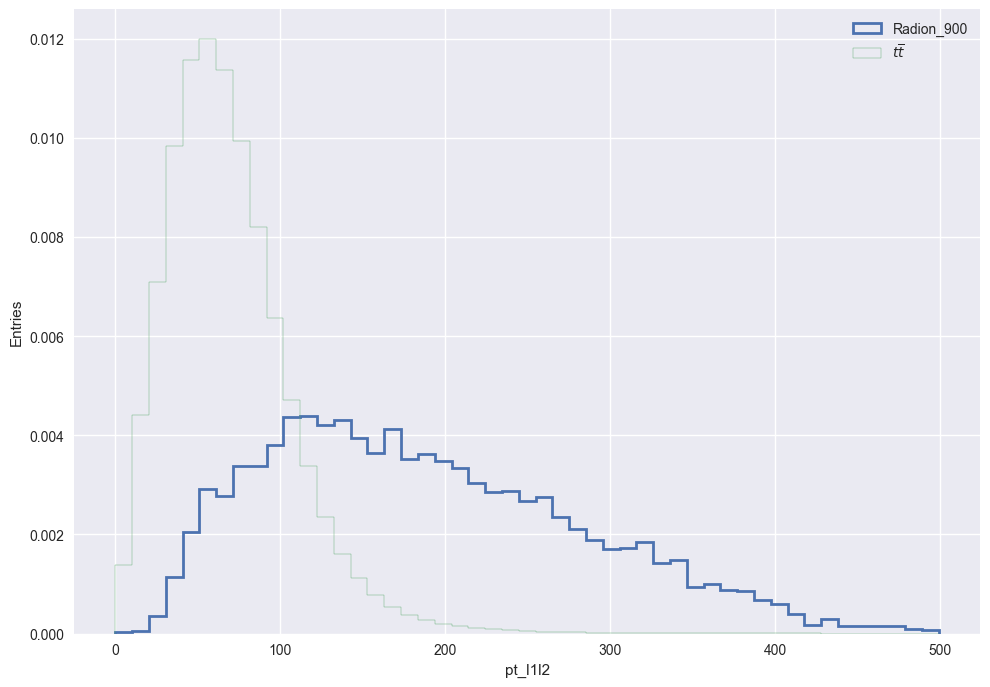

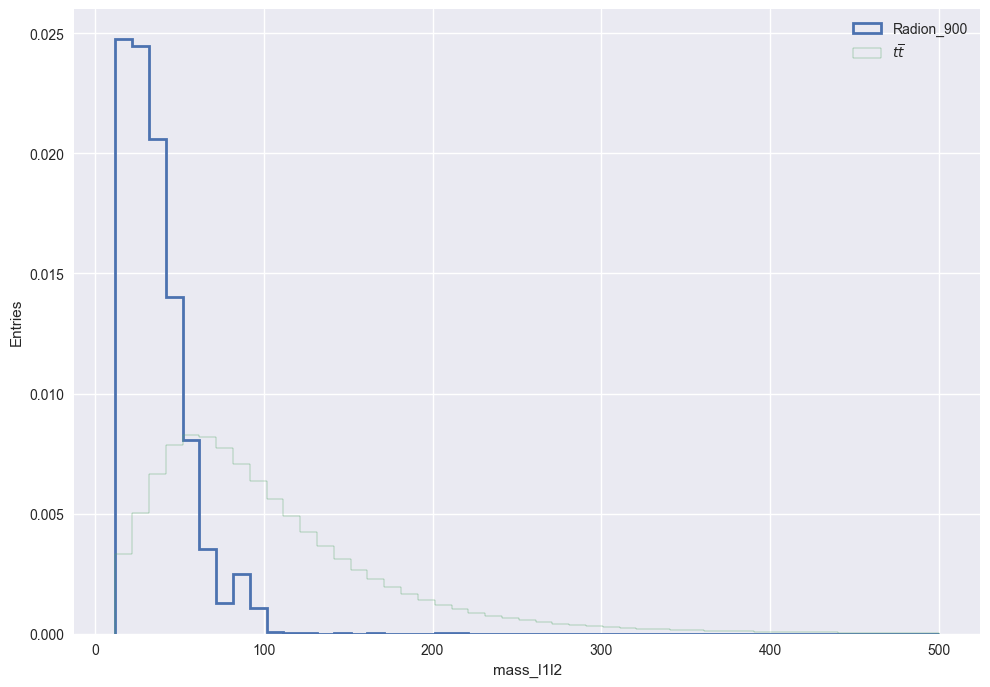

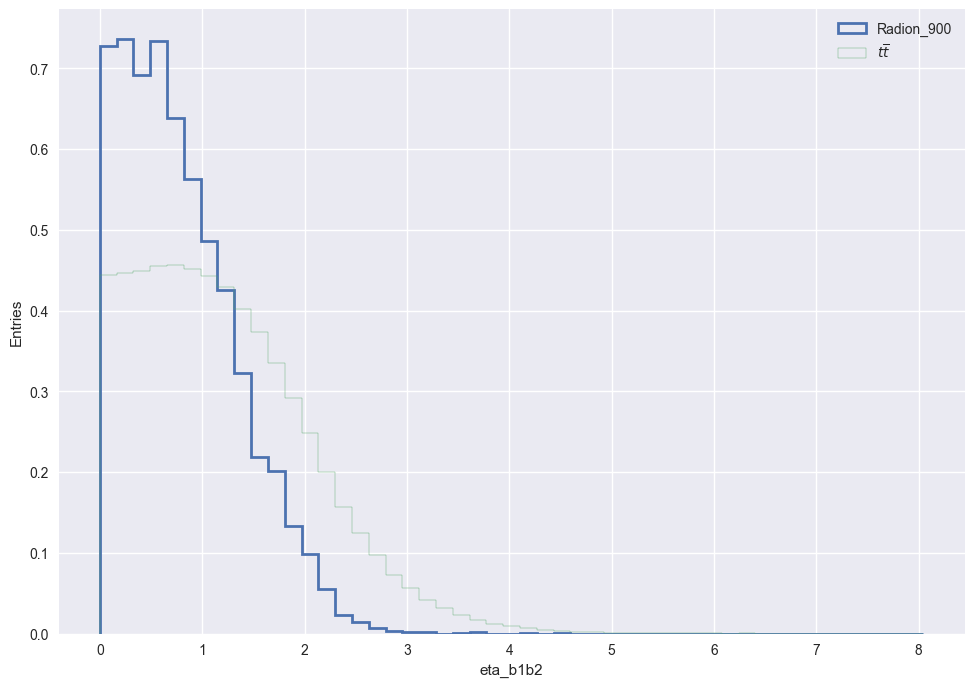

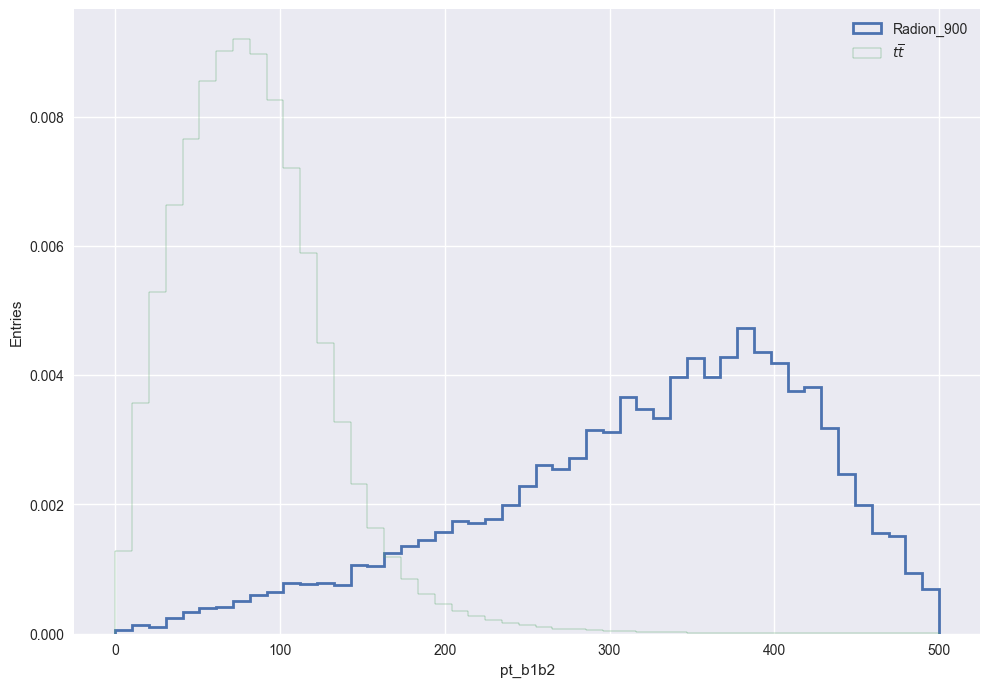

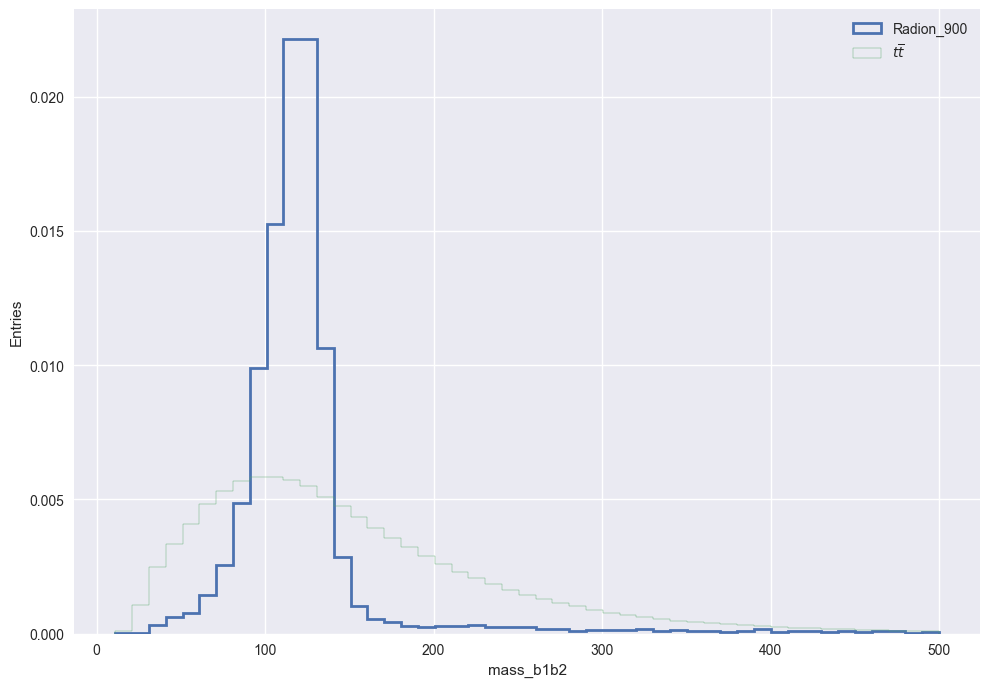

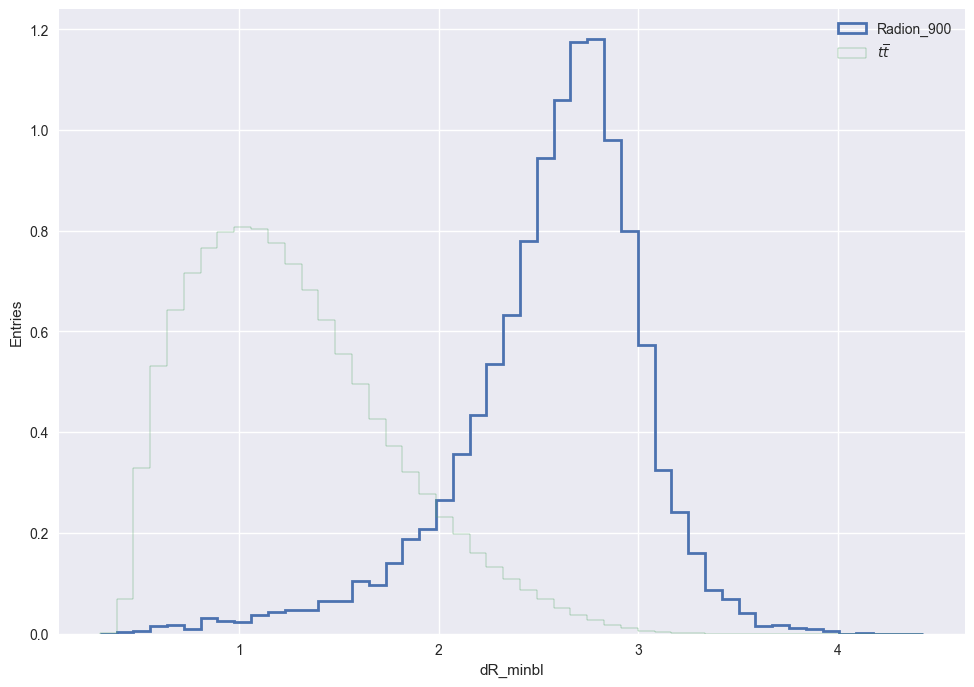

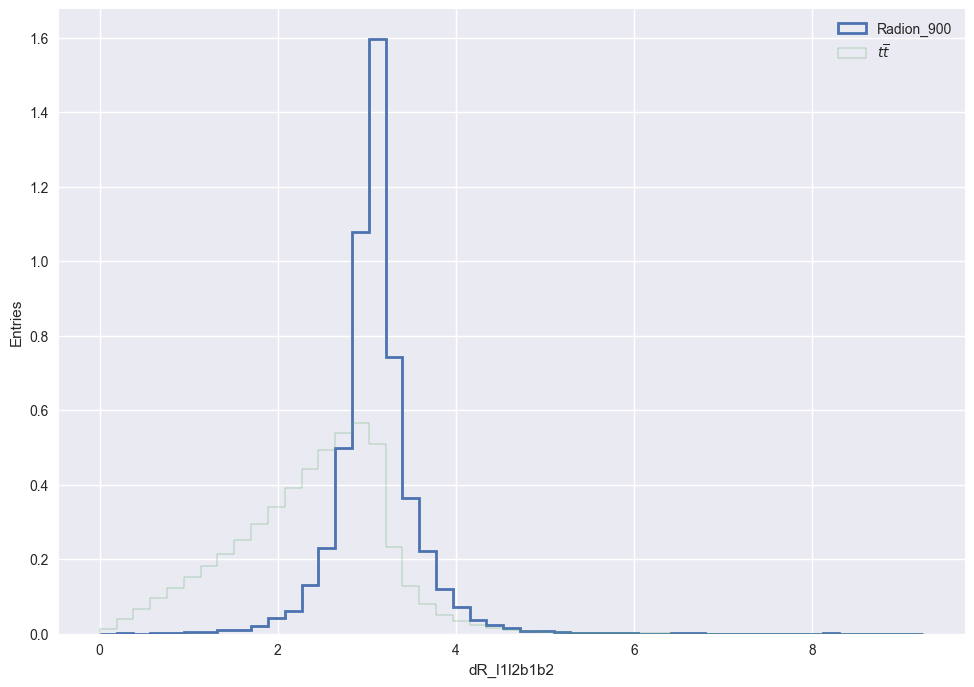

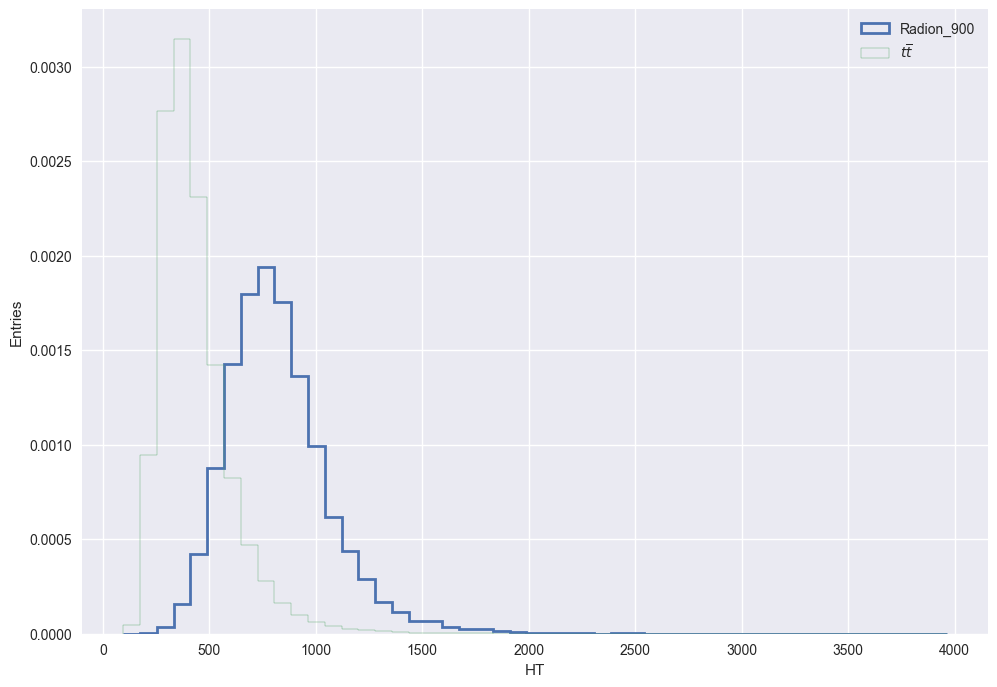

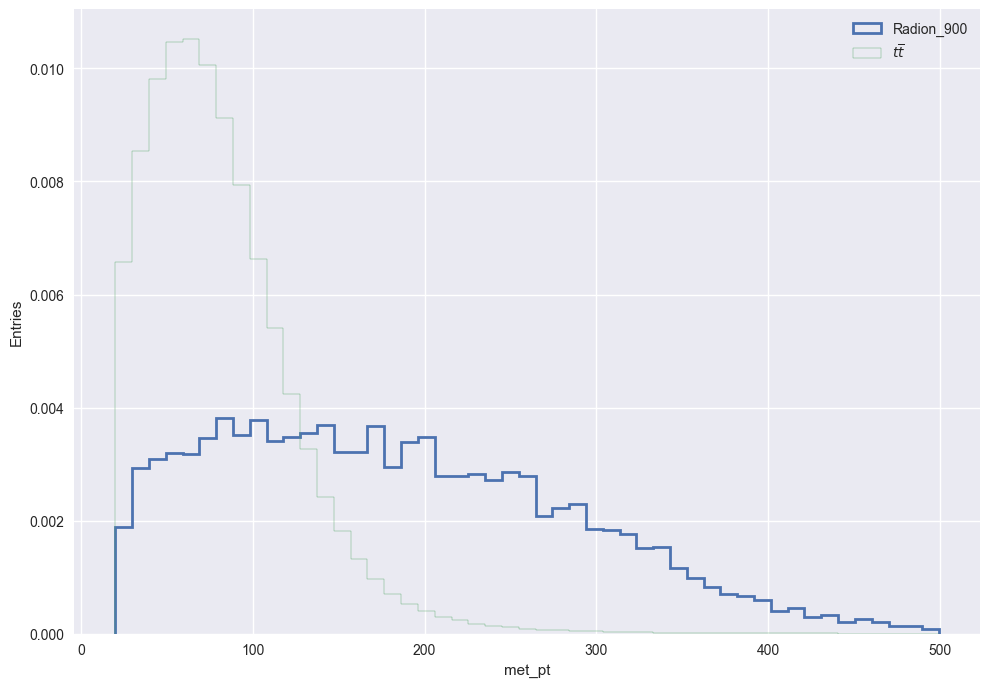

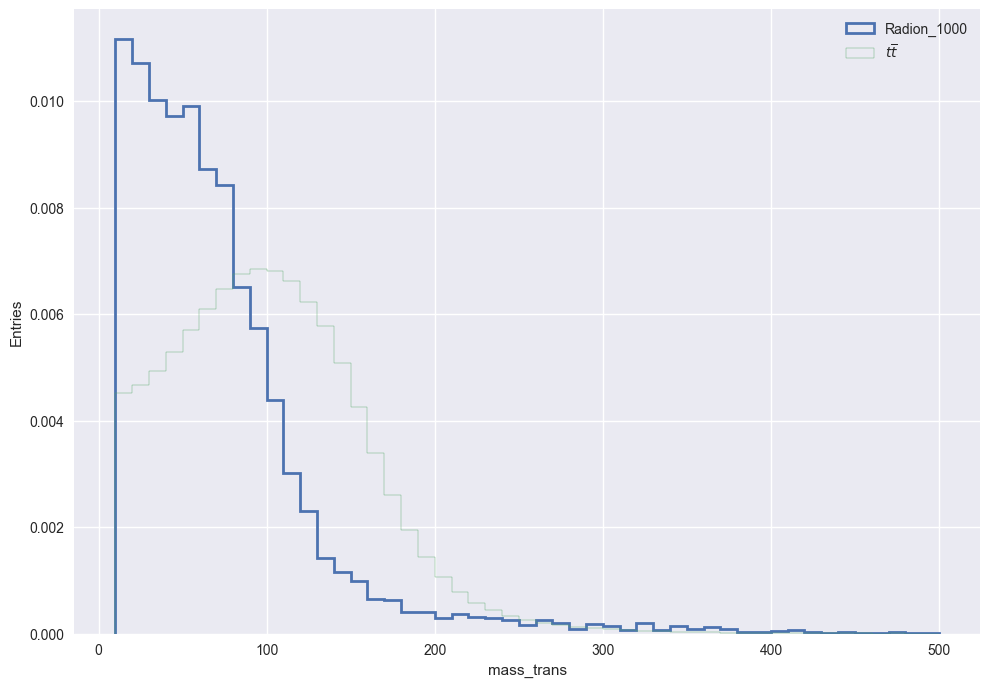

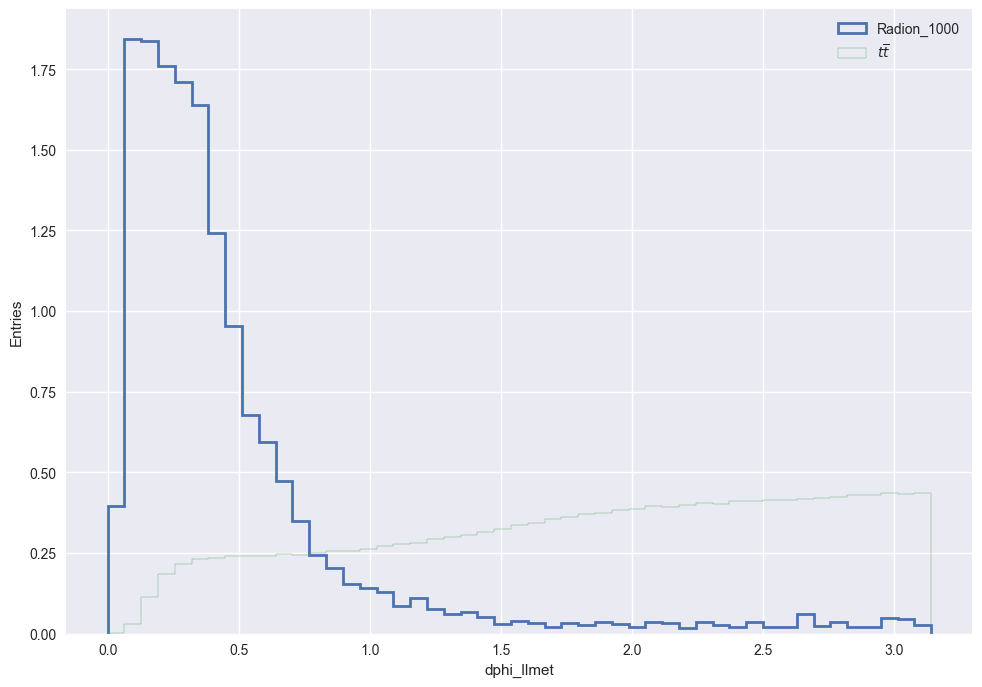

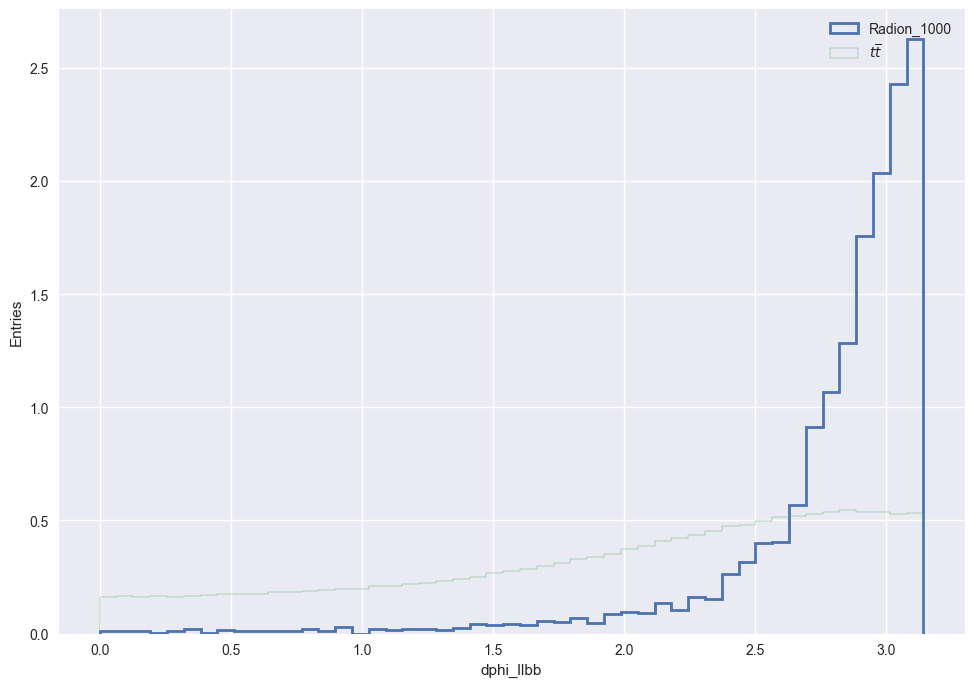

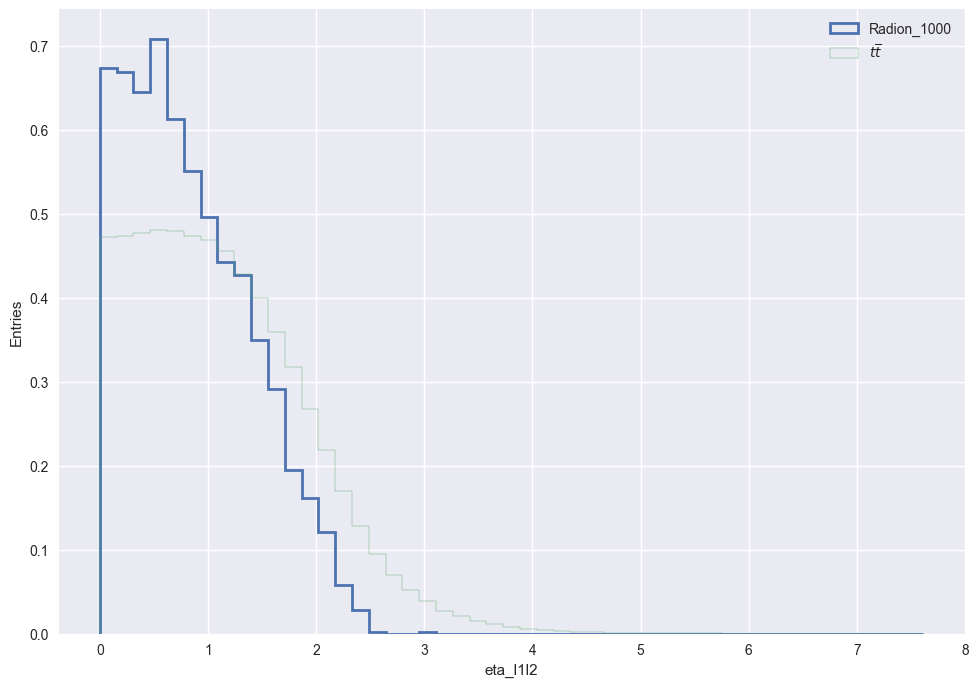

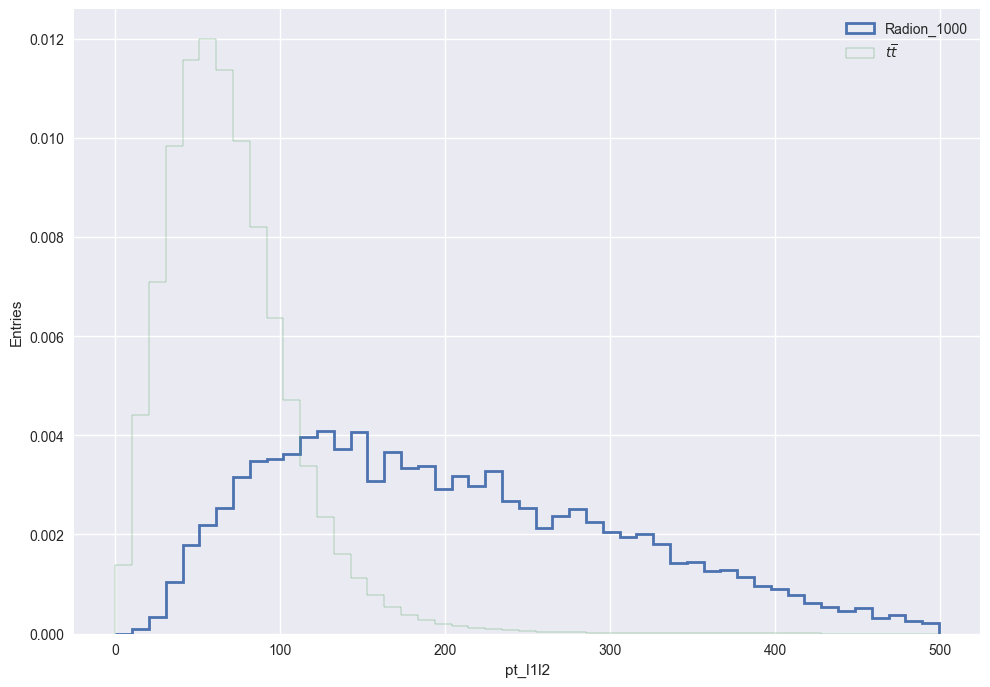

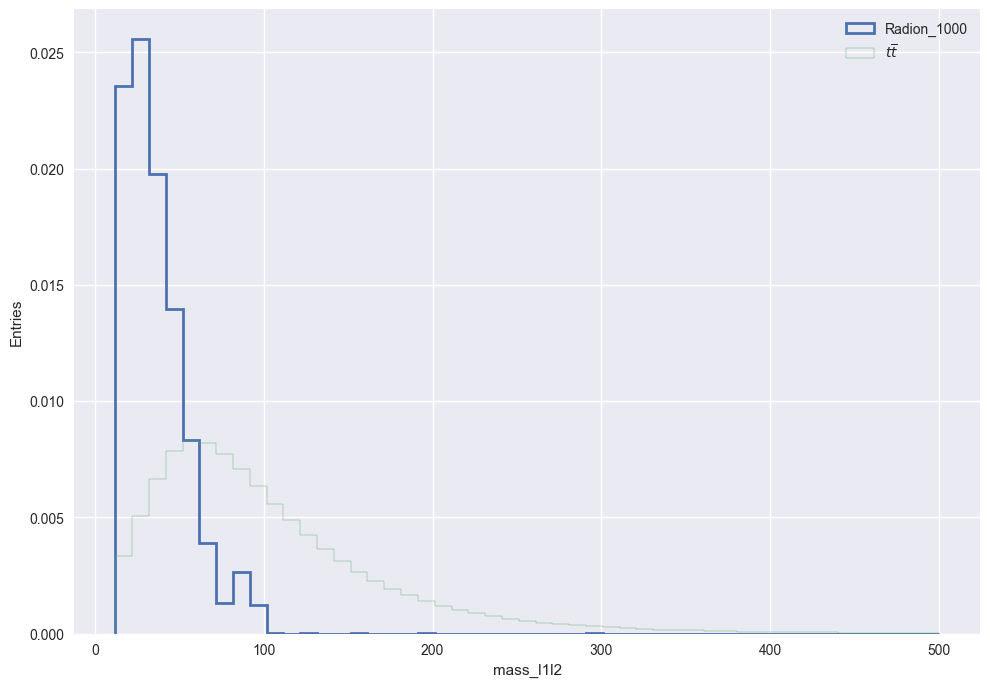

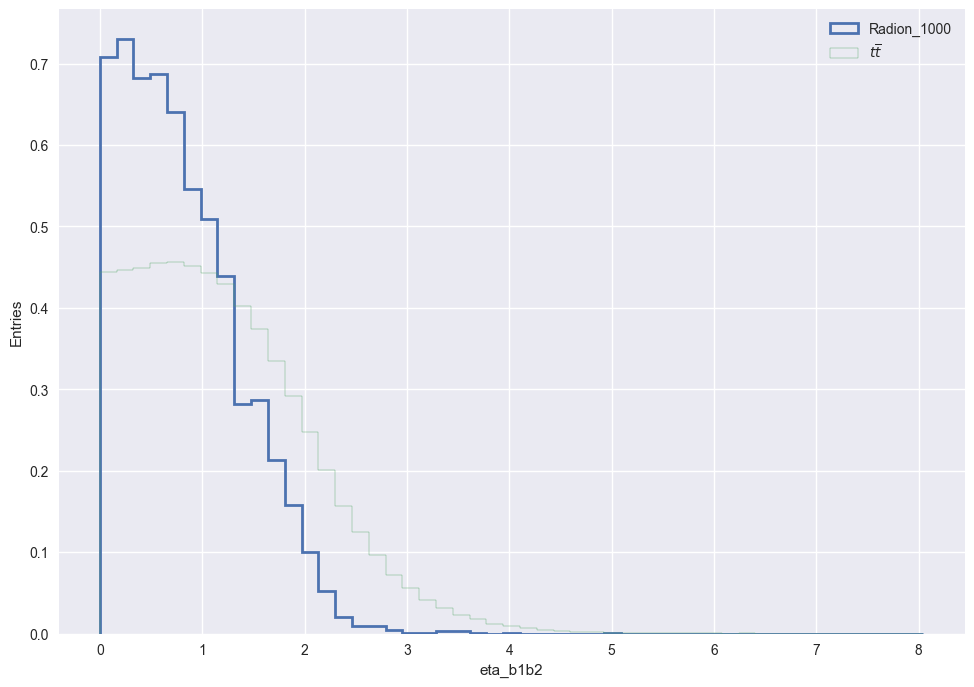

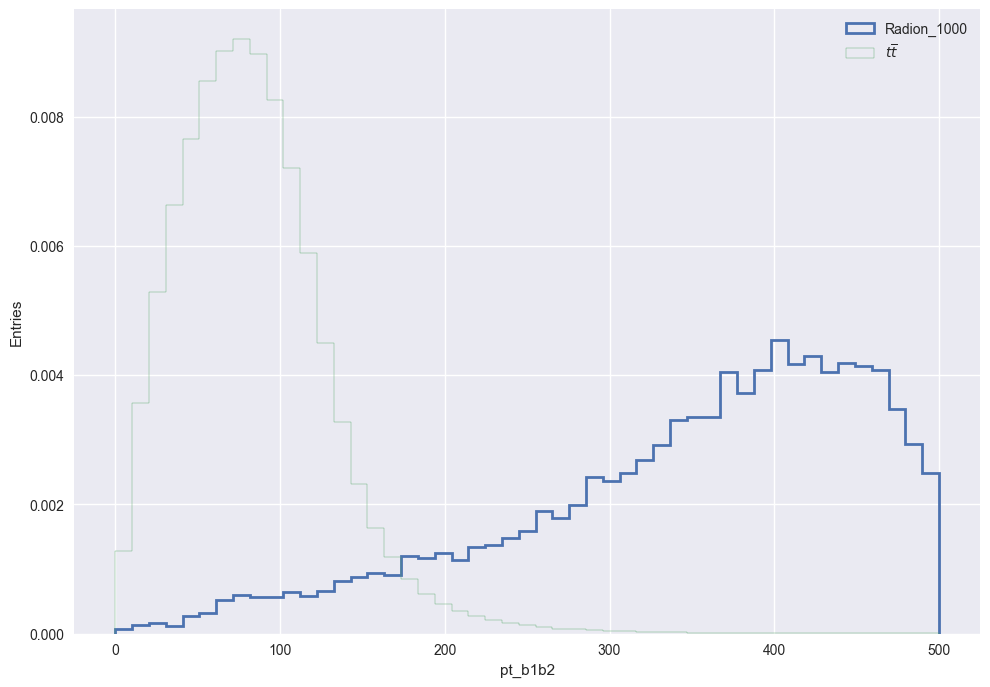

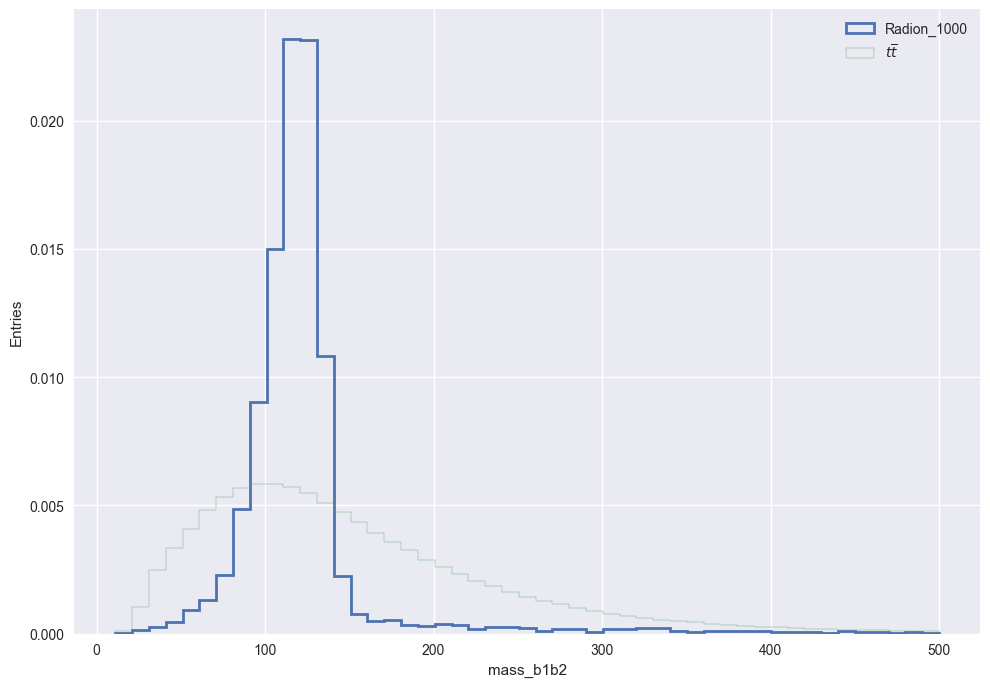

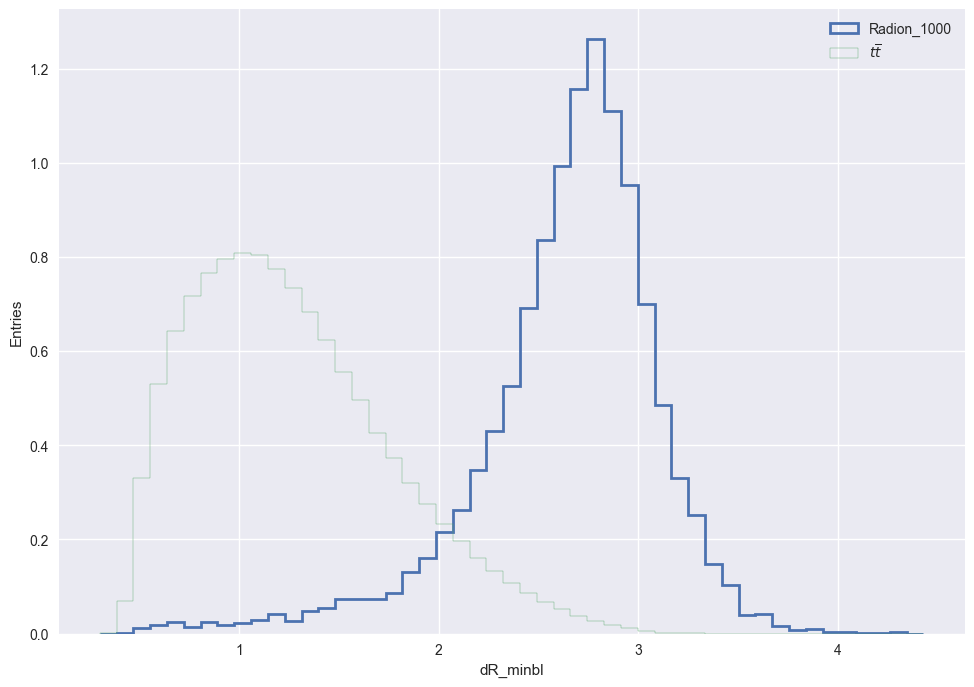

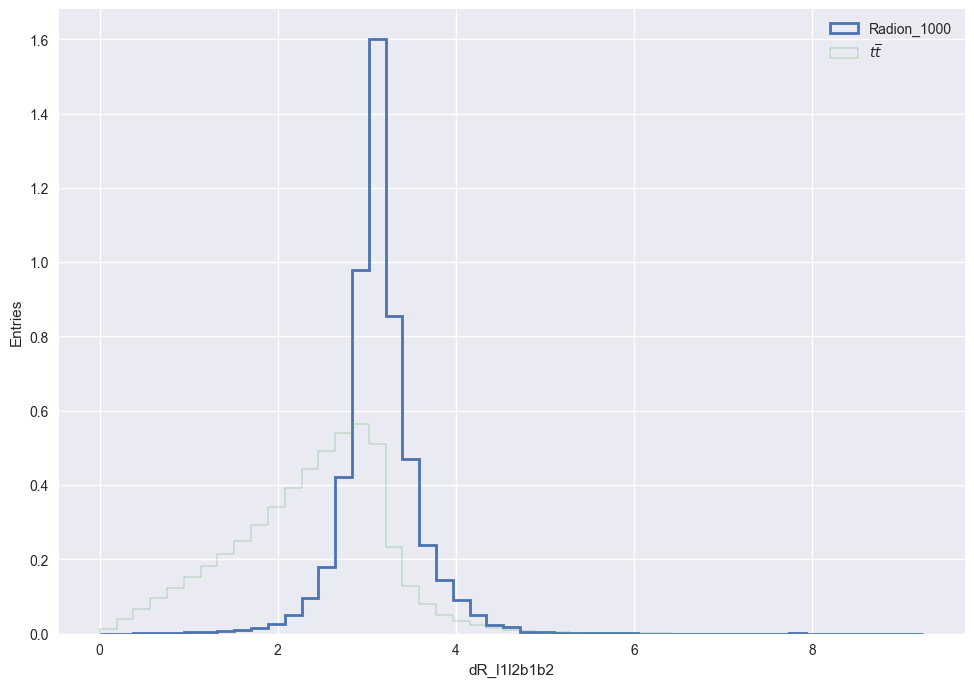

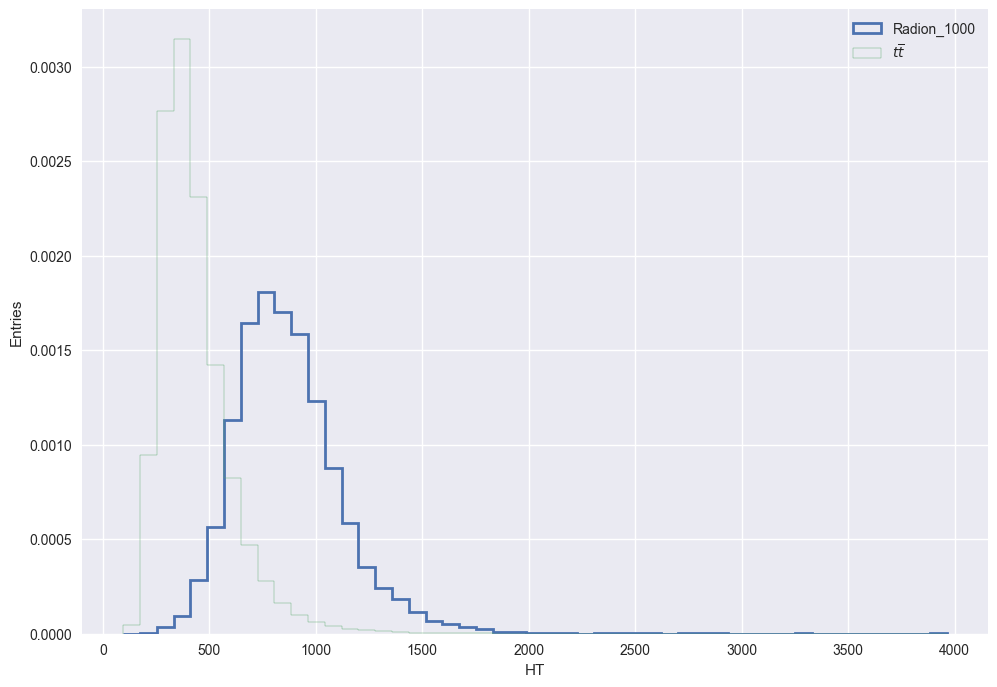

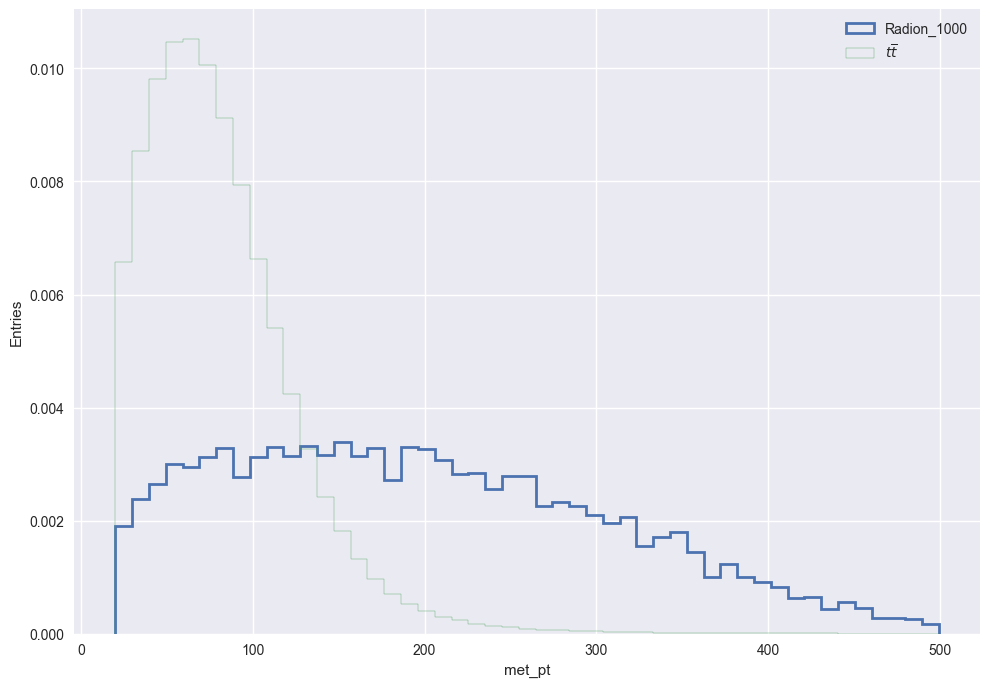

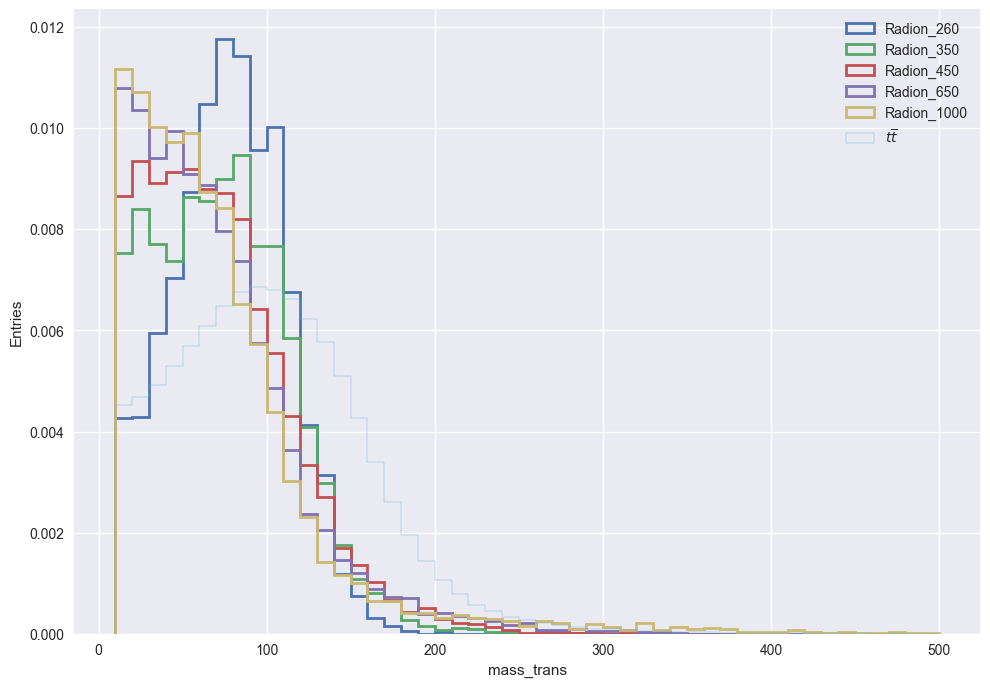

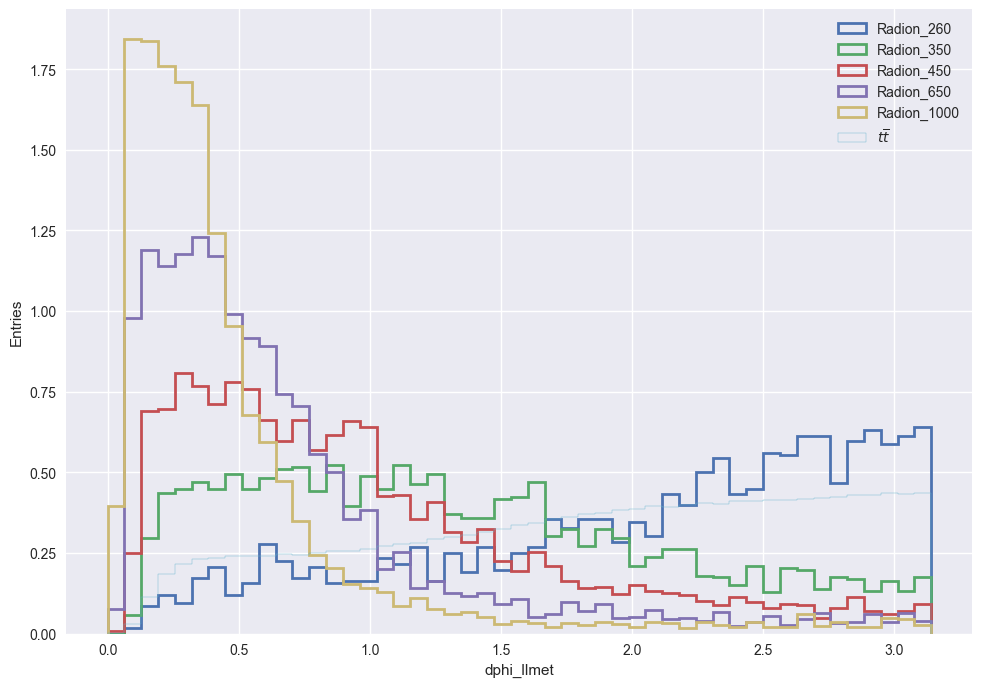

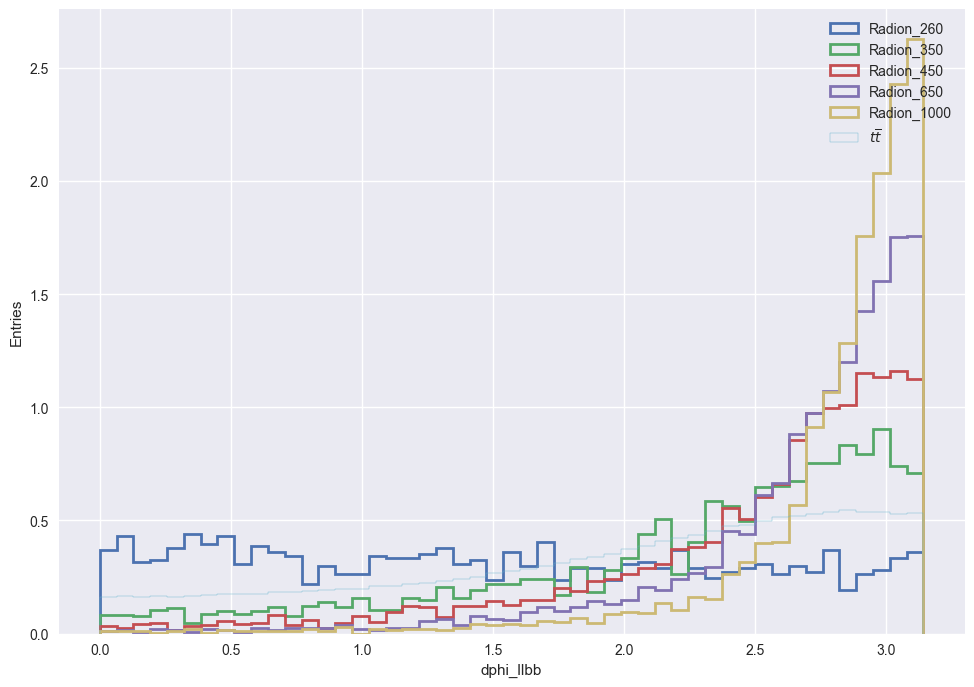

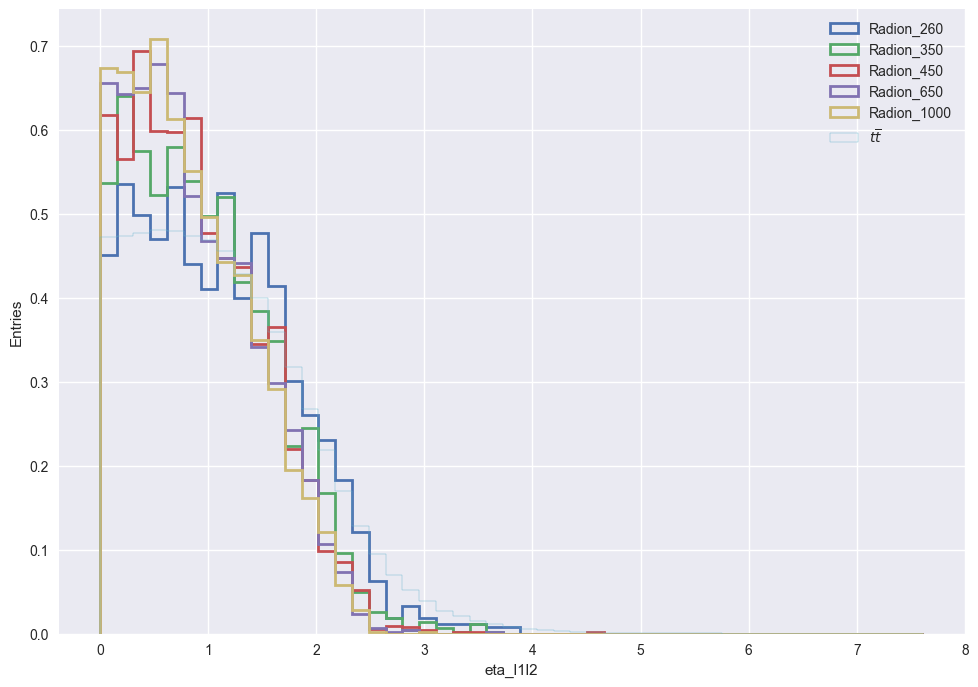

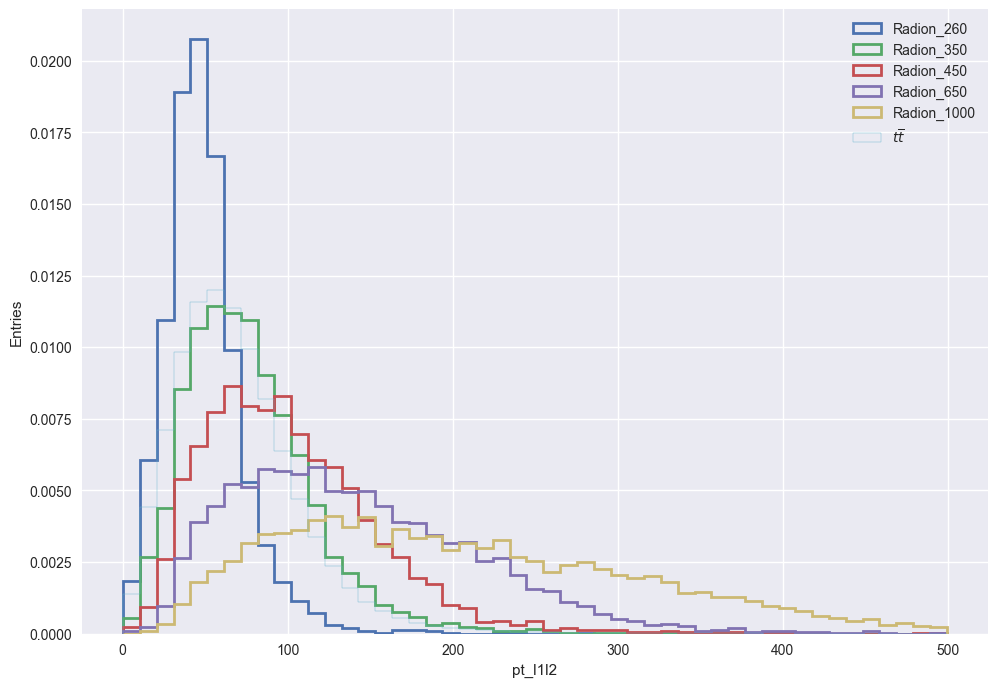

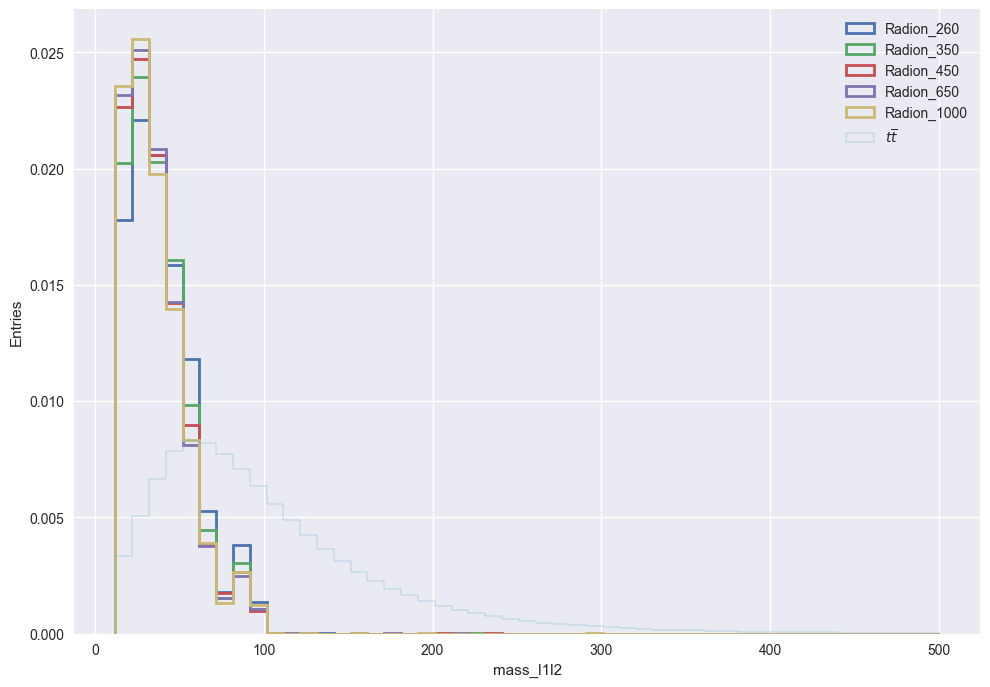

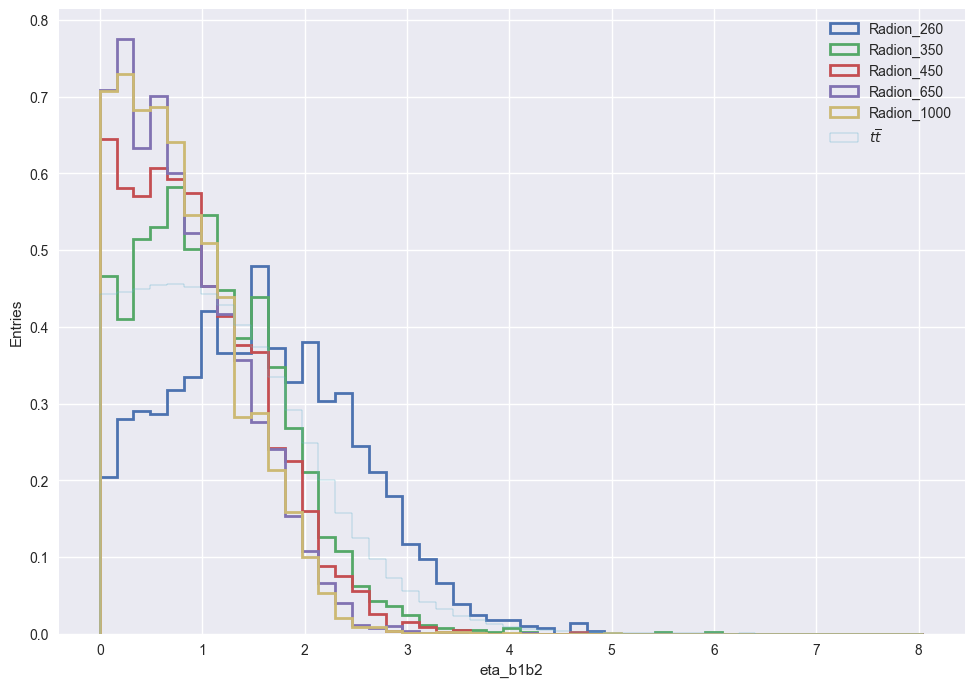

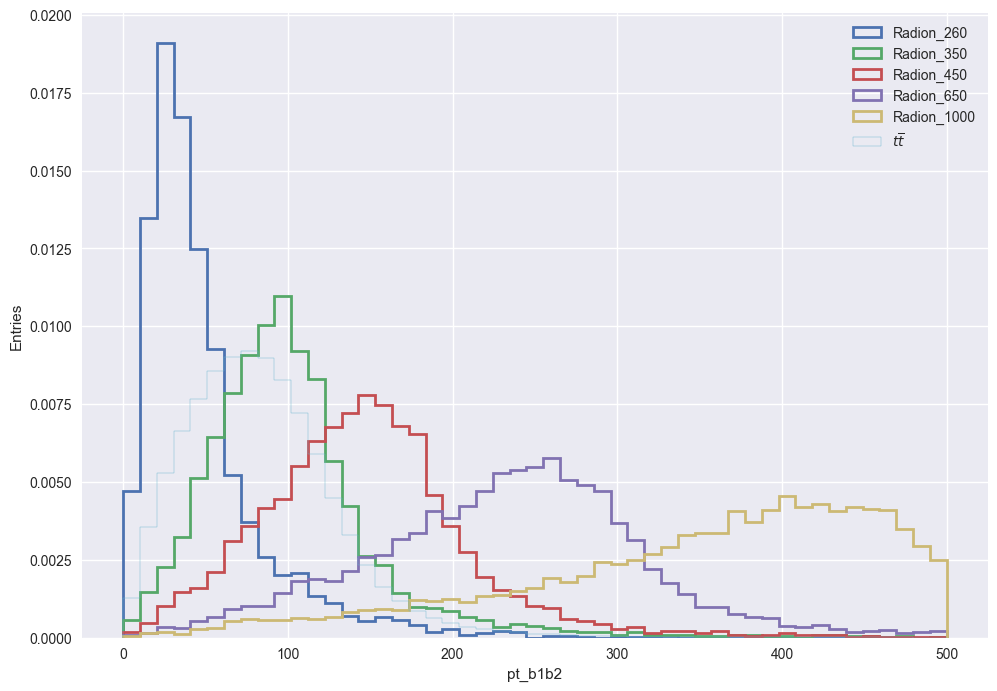

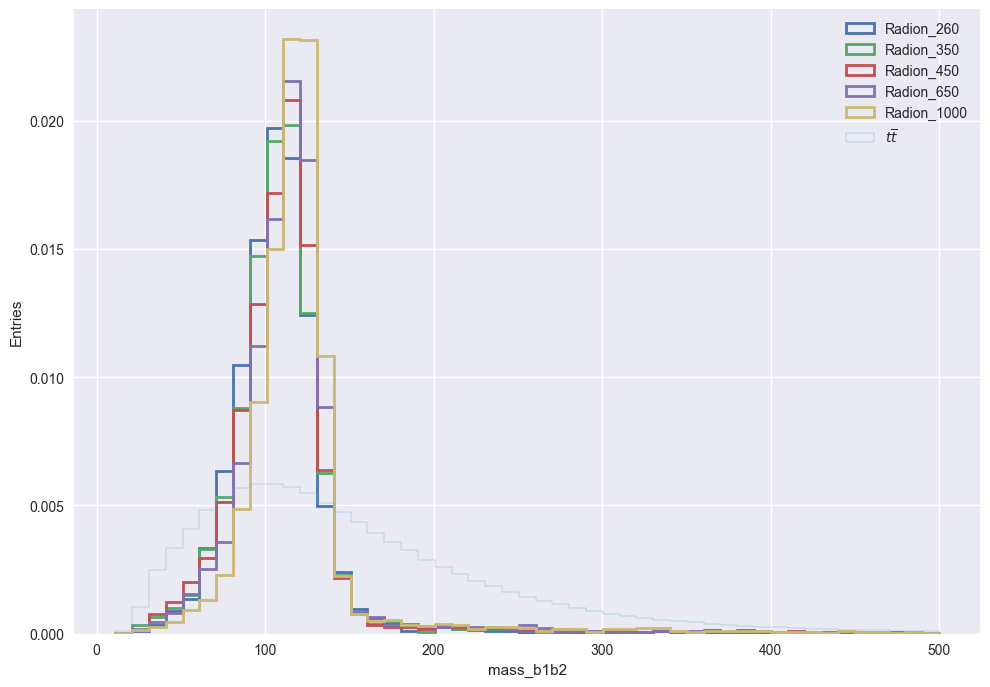

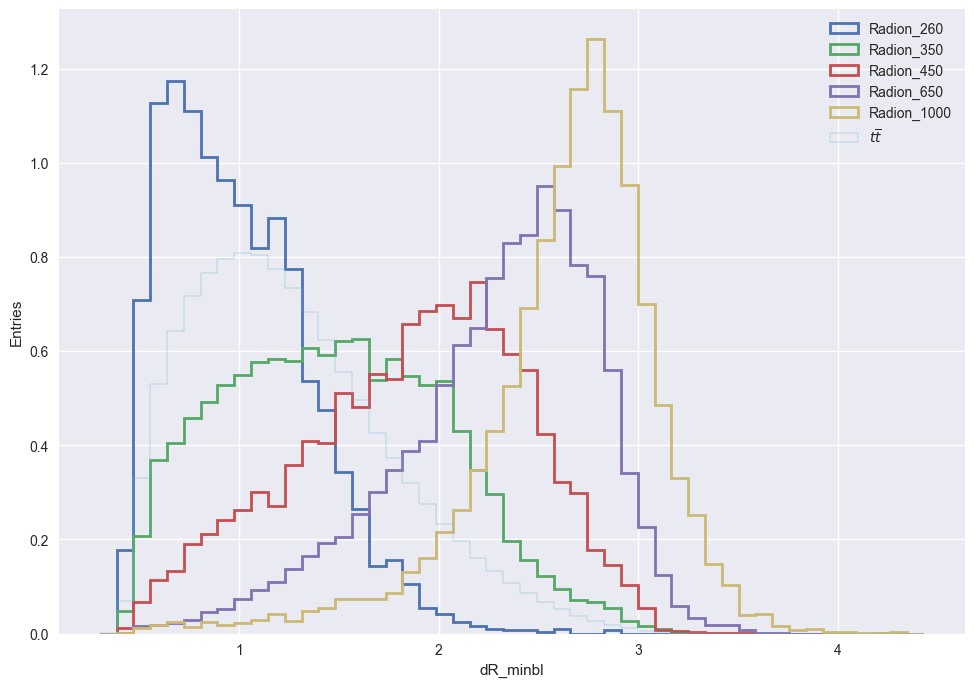

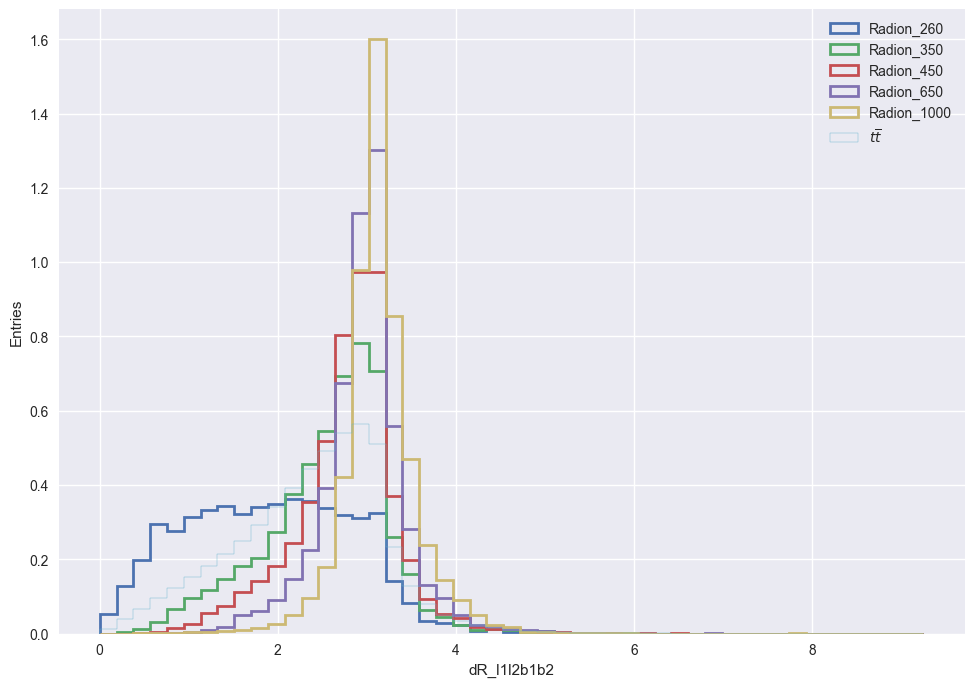

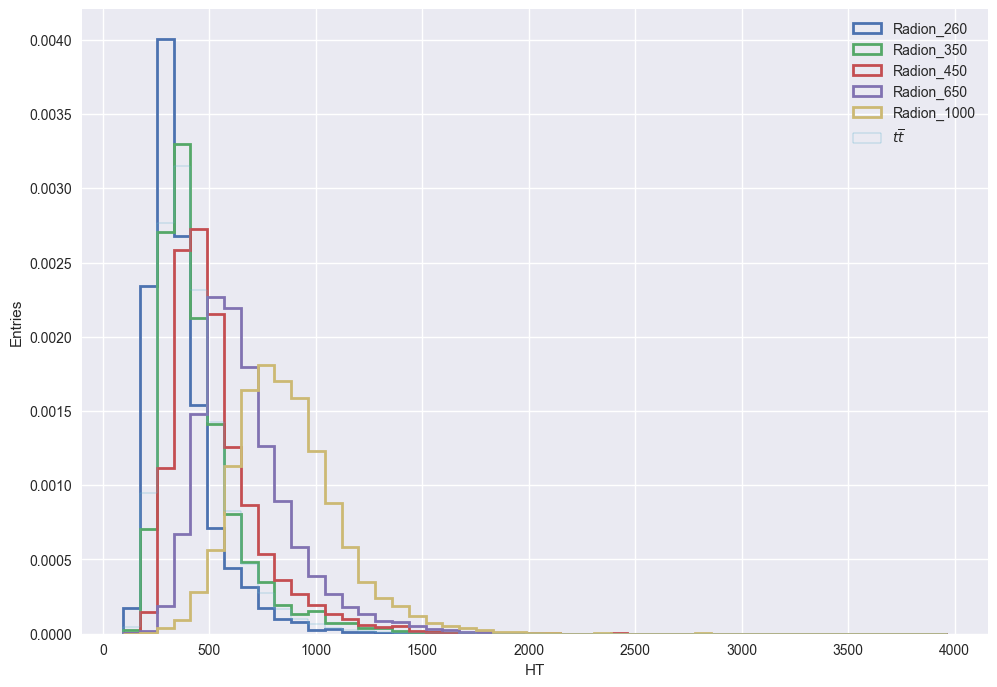

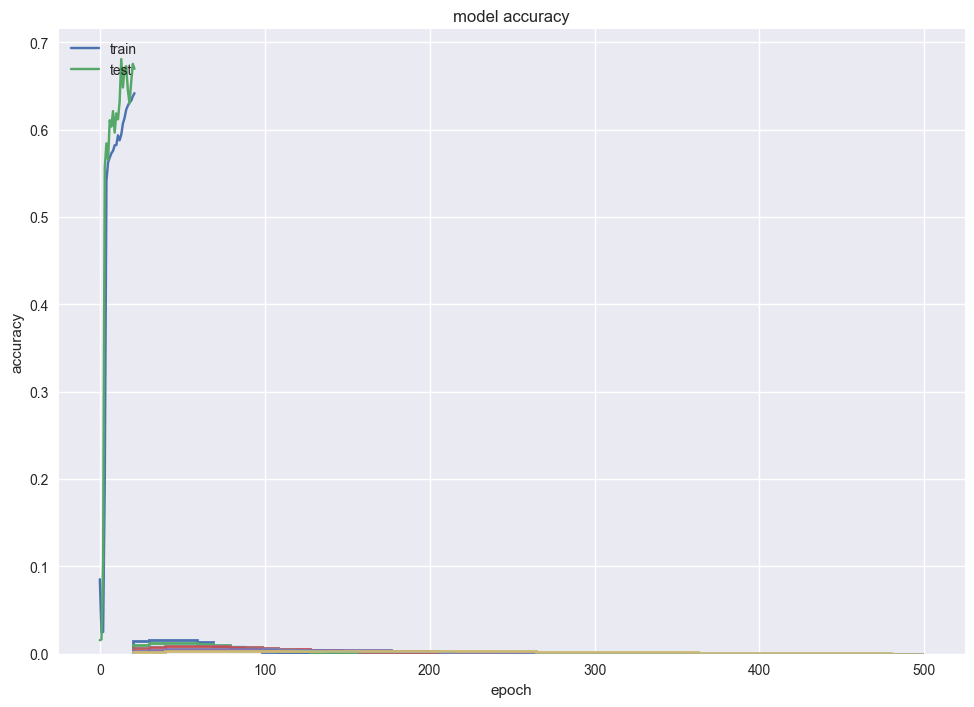

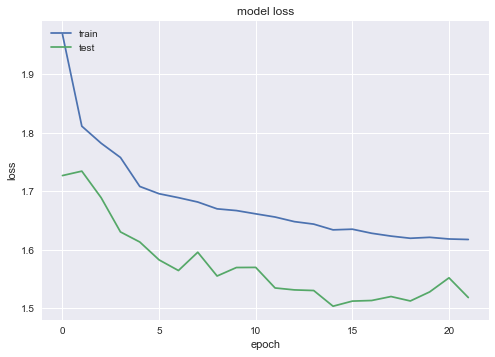

All data in hisotry are:  ['acc', 'loss', 'val_acc', 'val_loss']


In [10]:
# Let's make some plots about the convergence of our model. You can check if:
#  1. It’s speed of convergence over epochs (slope).
#  2. Whether the model may have already converged (plateau of the line).
#  3. Whether the mode may be over-learning the training data (inflection for validation line).

if debug:
    print "All data in hisotry are: ",history.history.keys()
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(folder + '/Check_accuracy.pdf')
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(folder + '/Check_loss.pdf')

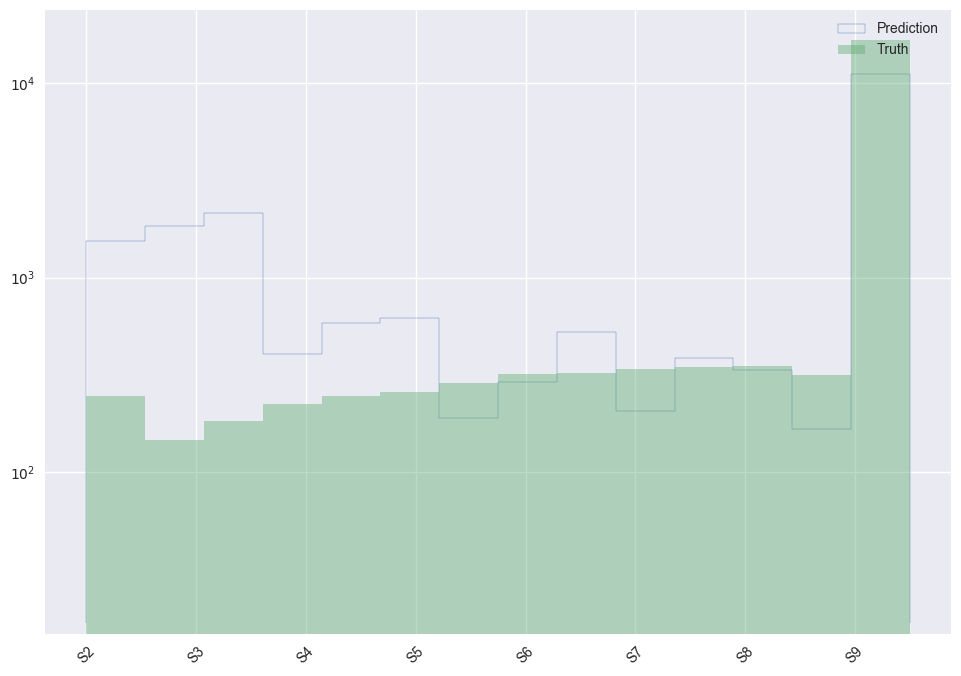

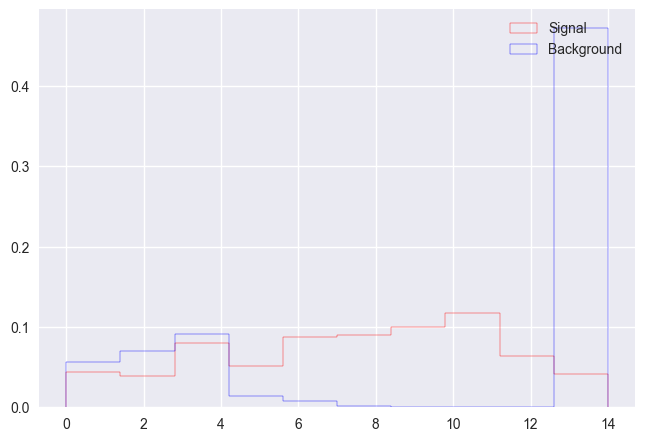

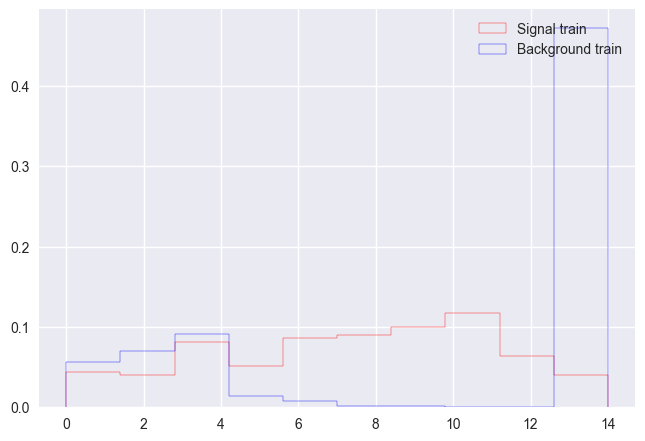

Saving weights...
Testing...
1395450/1396598 [============================>.] - ETA: 0s

In [11]:
# Load the best network (by default you return the last one, you if you save every time you have a better one you are fine loading it later)
model.load_weights('./models/tutorial-progress.h5')
print 'Saving weights...'
model.save_weights('./models/tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./models/tutorial.json', 'w').write(json_string)
print 'Testing...'
yhat = model.predict(X_test, verbose = True, batch_size = 50) # Return a vector of 2 indeces [probToBe_S,probToBe_B]
#Turn them into classes
yhat_cls = np.argmax(yhat, axis=1) # Transform [probToBe_S,probToBe_B] in a vector of 0 and 1 depending if probToBe_S>probToBe_B. Practically return the index of the biggest element (0 is is probToBe_S, if is probToBe_B)
# This should Normalized to the Xsec?
if MakePlots:
    bins = np.linspace(0,15,15)
    names = ['S1','S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S12','S13','S14','tt']
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    ax = plt.subplot()
    ax.set_xticklabels(names, rotation=45)
    _ = plt.hist(yhat_cls, bins=bins, histtype='step', label='Prediction',log=True, weights=w_test)
    _ = plt.hist(y_test, bins=bins, histtype='stepfilled',alpha=0.4, label='Truth',log=True, weights=w_test)
    plt.legend(loc='upper right')
    print('Saving:',folder + '/Performance.pdf')
    plt.savefig(folder + '/Performance.pdf')
    # Check the score (y_test==0 is a vector of bools). Ideally you want a distribution that is all red on left and all blue on right.
    fig = plt.figure(figsize=(7.69, 5.27), dpi=100)
    plt.hist(yhat_cls[y_test<14], label='Signal', normed=True, histtype='step', color='red', weights=w_test[y_test<14])
    plt.hist(yhat_cls[y_test==14], label='Background', normed=True, histtype='step', color='blue', weights=w_test[y_test==14])
    plt.legend()
    plt.show()
    plt.savefig(folder + '/Performance2.pdf')
    # Check it on the training (should be similar to the test)
    yhat_train = model.predict(X_train, verbose = True, batch_size = 50)
    yhat_cls_train = np.argmax(yhat_train, axis=1)
    fig = plt.figure(figsize=(7.69, 5.27), dpi=100)
    plt.hist(yhat_cls_train[y_train<14], label='Signal train', normed=True, histtype='step', color='red', weights=w_train[y_train<14])
    plt.hist(yhat_cls_train[y_train==14], label='Background train', normed=True, histtype='step', color='blue', weights=w_train[y_train==14])
    plt.legend()
    plt.show()
    plt.savefig(folder + '/Performance2_train.pdf')

In [ ]:
# With "(y_test != 0) & (yhat_cls == 0)" you get an arrate of bool: [False False False ..., False False False]
print 'Signal 1 efficiency:',     w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum(),    "(", w_test[(y_test == 0) & (yhat_cls == 0)].sum(),"/", w_test[y_test == 0].sum(),")"
print 'Signal 2 efficiency:',     w_test[(y_test == 1) & (yhat_cls == 1)].sum() / w_test[y_test == 1].sum(),    "(", w_test[(y_test == 1) & (yhat_cls == 1)].sum(),"/", w_test[y_test == 1].sum(),")"
print 'Signal 3 efficiency:',     w_test[(y_test == 2) & (yhat_cls == 2)].sum() / w_test[y_test == 2].sum(),    "(", w_test[(y_test == 2) & (yhat_cls == 2)].sum(),"/", w_test[y_test == 2].sum(),")" 
print 'Signal 4 efficiency:',     w_test[(y_test == 3) & (yhat_cls == 3)].sum() / w_test[y_test == 3].sum(),    "(", w_test[(y_test == 3) & (yhat_cls == 3)].sum(),"/", w_test[y_test == 3].sum(),")"
print 'Signal 5 efficiency:',     w_test[(y_test == 4) & (yhat_cls == 4)].sum() / w_test[y_test == 4].sum(),    "(", w_test[(y_test == 4) & (yhat_cls == 4)].sum(),"/", w_test[y_test == 4].sum(),")"
print 'Signal 6 efficiency:',     w_test[(y_test == 5) & (yhat_cls == 5)].sum() / w_test[y_test == 5].sum(),    "(", w_test[(y_test == 5) & (yhat_cls == 5)].sum(),"/", w_test[y_test == 5].sum(),")"
print 'Signal 7 efficiency:',     w_test[(y_test == 6) & (yhat_cls == 6)].sum() / w_test[y_test == 6].sum(),    "(", w_test[(y_test == 6) & (yhat_cls == 6)].sum(),"/", w_test[y_test == 6].sum(),")"
print 'Signal 8 efficiency:',     w_test[(y_test == 7) & (yhat_cls == 7)].sum() / w_test[y_test == 7].sum(),    "(", w_test[(y_test == 7) & (yhat_cls == 7)].sum(),"/", w_test[y_test == 7].sum(),")"
print 'Signal 9 efficiency:',     w_test[(y_test == 8) & (yhat_cls == 8)].sum() / w_test[y_test == 8].sum(),    "(", w_test[(y_test == 8) & (yhat_cls == 8)].sum(),"/", w_test[y_test == 8].sum(),")"
print 'Signal 10 efficiency:',    w_test[(y_test == 9) & (yhat_cls == 9)].sum() / w_test[y_test == 9].sum(),    "(", w_test[(y_test == 9) & (yhat_cls == 9)].sum(),"/", w_test[y_test == 9].sum(),")" 
print 'Signal 11 efficiency:',    w_test[(y_test == 10) & (yhat_cls == 10)].sum() / w_test[y_test == 10].sum(), "(", w_test[(y_test == 10) & (yhat_cls == 10)].sum(),"/", w_test[y_test == 10].sum(),")"
print 'Signal 12 efficiency:',    w_test[(y_test == 11) & (yhat_cls == 11)].sum() / w_test[y_test == 11].sum(), "(", w_test[(y_test == 11) & (yhat_cls == 11)].sum(),"/", w_test[y_test == 11].sum(),")"
print 'Signal 13 efficiency:',    w_test[(y_test == 12) & (yhat_cls == 12)].sum() / w_test[y_test == 12].sum(), "(", w_test[(y_test == 12) & (yhat_cls == 12)].sum(),"/", w_test[y_test == 12].sum(),")"
print 'Signal 14 efficiency:',    w_test[(y_test == 13) & (yhat_cls == 13)].sum() / w_test[y_test == 13].sum(), "(", w_test[(y_test == 13) & (yhat_cls == 13)].sum(),"/", w_test[y_test == 13].sum(),")"
print 'Background efficiency:',   w_test[(y_test == 14) & (yhat_cls < 14)].sum() / w_test[y_test == 14].sum(),  "(", w_test[(y_test == 14) & (yhat_cls <14)].sum(),"/", w_test[y_test == 14].sum(),")"
print "In Average:"
print 'Signal Efficiency:',     w_test[(y_test < 14) & (yhat_cls <14)].sum() / w_test[y_test <14].sum()
print 'Background efficiency:',   w_test[(y_test == 14) & (yhat_cls < 14)].sum() / w_test[y_test == 14].sum()

print "Asking to be not background"; print""
N_0 = w_test[(y_test == 0) & (yhat_cls < 14)].sum(); N_0_tot = w_test[y_test == 0].sum()
N_1 = w_test[(y_test == 1) & (yhat_cls < 14)].sum(); N_1_tot = w_test[y_test == 1].sum()
N_2 = w_test[(y_test == 2) & (yhat_cls < 14)].sum(); N_2_tot = w_test[y_test == 2].sum()
N_3 = w_test[(y_test == 3) & (yhat_cls < 14)].sum(); N_3_tot = w_test[y_test == 3].sum()
N_4 = w_test[(y_test == 4) & (yhat_cls < 14)].sum(); N_4_tot = w_test[y_test == 4].sum()
N_5 = w_test[(y_test == 5) & (yhat_cls < 14)].sum(); N_5_tot = w_test[y_test == 5].sum()
N_6 = w_test[(y_test == 6) & (yhat_cls < 14)].sum(); N_6_tot = w_test[y_test == 6].sum()
N_7 = w_test[(y_test == 7) & (yhat_cls < 14)].sum(); N_7_tot = w_test[y_test == 7].sum()
N_8 = w_test[(y_test == 8) & (yhat_cls < 14)].sum(); N_8_tot = w_test[y_test == 8].sum()
N_9 = w_test[(y_test == 9) & (yhat_cls < 14)].sum(); N_9_tot = w_test[y_test == 9].sum()
N_10 = w_test[(y_test == 10) & (yhat_cls < 14)].sum(); N_10_tot = w_test[y_test == 10].sum()
N_11 = w_test[(y_test == 11) & (yhat_cls < 14)].sum(); N_11_tot = w_test[y_test == 11].sum()
N_12 = w_test[(y_test == 12) & (yhat_cls < 14)].sum(); N_12_tot = w_test[y_test == 12].sum()
N_13 = w_test[(y_test == 13) & (yhat_cls < 14)].sum(); N_13_tot = w_test[y_test == 13].sum()
N_14 = w_test[(y_test == 14) & (yhat_cls < 14)].sum(); N_14_tot = w_test[y_test == 14].sum()
print 'Signal 1 efficiency:',   N_0/N_0_tot ,"(", N_0,"/",N_0_tot, "), S/sqrt(S+B):", N_0/sqrt(N_0+N_14)
print 'Signal 2 efficiency:',   N_1/N_1_tot ,"(", N_1,"/",N_1_tot, "), S/sqrt(S+B):", N_1/sqrt(N_1+N_14) 
print 'Signal 3 efficiency:',   N_2/N_2_tot ,"(", N_2,"/",N_2_tot, "), S/sqrt(S+B):", N_2/sqrt(N_2+N_14) 
print 'Signal 4 efficiency:',   N_3/N_3_tot ,"(", N_3,"/",N_3_tot, "), S/sqrt(S+B):", N_3/sqrt(N_3+N_14)
print 'Signal 5 efficiency:',   N_4/N_4_tot ,"(", N_4,"/",N_4_tot, "), S/sqrt(S+B):", N_4/sqrt(N_4+N_14)
print 'Signal 6 efficiency:',   N_5/N_5_tot ,"(", N_5,"/",N_5_tot, "), S/sqrt(S+B):", N_5/sqrt(N_5+N_14)
print 'Signal 7 efficiency:',   N_6/N_6_tot ,"(", N_6,"/",N_6_tot, "), S/sqrt(S+B):", N_6/sqrt(N_6+N_14)
print 'Signal 8 efficiency:',   N_7/N_7_tot ,"(", N_7,"/",N_7_tot, "), S/sqrt(S+B):", N_7/sqrt(N_7+N_14)
print 'Signal 9 efficiency:',   N_8/N_8_tot ,"(", N_8,"/",N_8_tot, "), S/sqrt(S+B):", N_8/sqrt(N_8+N_14)
print 'Signal 10 efficiency:',  N_9/N_9_tot ,"(", N_9,"/",N_9_tot, "), S/sqrt(S+B):", N_9/sqrt(N_9+N_14)
print 'Signal 11 efficiency:',  N_10/N_10_tot,"(", N_10,"/",N_10_tot,"), S/sqrt(S+B):",N_10/sqrt(N_10+N_14) 
print 'Signal 12 efficiency:',  N_11/N_11_tot,"(", N_11,"/",N_11_tot,"), S/sqrt(S+B):",N_11/sqrt(N_11+N_14)
print 'Signal 13 efficiency:',  N_12/N_12_tot,"(", N_12,"/",N_12_tot,"), S/sqrt(S+B):",N_12/sqrt(N_12+N_14)
print 'Signal 14 efficiency:',  N_13/N_13_tot,"(", N_13,"/",N_13_tot,"), S/sqrt(S+B):",N_13/sqrt(N_13+N_14)
print 'Background efficiency:', N_14/N_14_tot,"(", N_14,"/",N_14_tot
print "-> In Average:"
print 'Signal Efficiency:',     w_test[(y_test < 14) & (yhat_cls <14)].sum() / w_test[y_test <14].sum()
print 'Background efficiency:',   w_test[(y_test == 14) & (yhat_cls < 14)].sum() / w_test[y_test == 14].sum()


We Trained the MLP to distinguish 14 Signals and 1 Background. Let's see if this method is better compared to train a single MLP for each mass point.

Signal efficiency: 0.949929225605   
Background efficiency: 0.0542005451175 